In [1]:
%load_ext autoreload
%autoreload 2

# standard stuff
import os
import pandas as pd
import numpy as np
np.random.seed(123)
import json
import pickle 
import time
from tqdm import tqdm
import datetime as dt
from collections import Counter


# text processing
import re
with open('stopwords-de.json', 'r') as file:
    stopwords_de = json.load(file)
import spacy
nlp = spacy.load('de')


# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

# SK-LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Gensim LDA
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# custom imports
from data_handling import load_data, collapse_dfs
from text_preprocessing import df_processing, party_remover

In [ ]:
read_in = True
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/data_lda.pickle'
parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
dates = ['08-{:02d}'.format(i) for i in range(2,10)]


if read_in:
    parties = parties
    dates = dates
    data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        data = pickle.load(fid)
        print('data loaded')


  0%|          | 0/8 [00:00<?, ?it/s]

Loading: ['08-02', '08-03', '08-04', '08-05', '08-06', '08-07', '08-08', '08-09']


In [2]:
collapse = False
path_collapse = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data_lda.pickle' # path where pickle file is saved

if collapse:
    all_data = collapse_dfs(aug_data)
    df_processing(all_data)
    all_data = all_data.drop_duplicates('clean_text')
    all_data['user_id'] = all_data.loc[:, 'user'].map(lambda x: x['id_str'])
    all_data.drop('user', inplace=True, axis=1)
    print('dumping data to pickle')
    with open(path_collapse, 'wb') as fid:
        pickle.dump(all_data, fid)
    print('data dumped')
else: 
    print('loading data from pickle')
    with open(path_collapse, 'rb') as fid:
        all_data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


# LDA using the scikit-learn package

In [4]:
cv = CountVectorizer(stop_words=stopwords_de,
                    max_df=.1,
                    max_features=5000)

X = cv.fit_transform(all_data.loc[:, 'clean_text'])

In [5]:
lda = LatentDirichletAllocation(n_components=5,
                               random_state=123,
                               learning_method='batch')

X_topics = lda.fit_transform(X)

In [6]:
lda.components_.shape

(5, 5000)

In [7]:
n_top_words = 5
feature_names = cv.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print('Topic {}'.format(topic_idx + 1))
    print(' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words -1:-1]]))

Topic 1
aufstehen partei sammlungsbewegung linken wagenknecht
Topic 2
ueber nazis partei waehler rechts
Topic 3
cdu fdp csu wehrpflicht merkel
Topic 4
gruene politik einfach leute muessen
Topic 5
gruene deutschland csu seehofer bayern


In [47]:
def daily_topifier(df, cv_features, n_topics, n_top_words):
    dates = ['2018-08-{:02d}'.format(i) for i in range(2,10)]
    topics = {}
    
    for date in dates:
        cv = CountVectorizer(stop_words=stopwords_de, max_df=.1, max_features=cv_features)
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=123, learning_method='batch')
        X = cv.fit_transform(df.loc['{}'.format(date), 'clean_text'])
        X_topics = lda.fit_transform(X)
        feature_names = cv.get_feature_names()
        for topic_idx, topic in enumerate(lda.components_):
            topics['{}, {}'.format(date, topic_idx + 1)] = [' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words -1:-1]])]
            
    return topics

In [51]:
topics = daily_topifier(all_data, cv_features=5000, n_topics=5, n_top_words=5)

topics
# interesting: afd is very common but does not appear to be a topic

# LDA using gensim 

- take only words with certain tags from the cleaned text (tags in this context referring to word tags = nouns, adjectives, ect.)
- prepare a common dictionary
- prepare common corpus with vectorized (bow) words
- run lda on corpus and evaluate coherence using the coherence model and visualizations

In [129]:
text = all_data.loc[:, 'clean_text']

document = []

for row in text.iteritems():
    index, data = row
    document.append(data)

corpus = [[word for word in str(doc).lower().split() if word not in stopwords_de and len(word) > 2] for doc in document]
common_dictionary = corpora.Dictionary(corpus, prune_at=10000)
common_corpus = [common_dictionary.doc2bow(t) for t in corpus]

In [4]:
path_corpus = '../Data/lda_corpus.pkl'
path_dic = '../Data/lda_dic.pkl'
with open(path_corpus, 'wb') as fid:
    pickle.dump(common_corpus, fid)

with open(path_dic, 'wb') as fid:
    pickle.dump(common_dictionary, fid)

/home/franzi/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



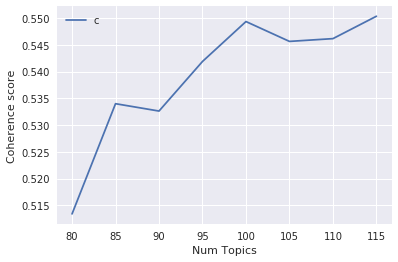

In [66]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute coherence for various number of topics

    Parameters:
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Plots coherence score over number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=0.1, )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

compute_coherence_values(common_dictionary, common_corpus, corpus, limit=120, start=80, step=5)

Following from coherence score curve
- choose 105 topics 

Following from LDA visualization
- comparing topic-bubbles of different numbers of topics: chosing 105 topics results in nicely distributed, hardly overlapping clusters

In [130]:
# divide by zero error: unsolved, not understood problem that apparently can be ignored
lda = LdaModel(common_corpus, num_topics=80, id2word=common_dictionary, alpha=2, random_state=123)

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

# Compute Coherence Score using u-mass
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='u_mass')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

ldavis_prepared = pyLDAvis.gensim.prepare(lda, common_corpus, common_dictionary)

pyLDAvis.display(ldavis_prepared)

Coherence Score:  0.6252636866666956
Coherence Score:  -16.522092405661727


/home/franzi/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

- A topic in LDA is a multinomial distribution over the (typically thousands of) terms in the vocabulary of the corpus. 

In [21]:
def daily_lda(df, stoplist, n_topics, n_words, startdate, stopdate):
    dates = ['2018-08-{:02d}'.format(i) for i in range(startdate, stopdate)]
    topics = {}
    
    for date in dates:
        text = all_data.loc['{}'.format(date), 'clean_text']

        document = []

        for row in text.iteritems():
            index, data = row
            document.append(data)

        corpus = [[word for word in str(doc).lower().split() if word not in stoplist and len(word) > 2] for doc in document]
        common_dictionary = corpora.Dictionary(corpus)
        common_corpus = [common_dictionary.doc2bow(t) for t in corpus]
        lda = LdaModel(common_corpus, num_topics=n_topics, id2word=common_dictionary, alpha=0.001, random_state=123)
        topic = lda.show_topics(num_topics=n_topics, num_words=n_words,formatted=False)
        topics['{}'.format(date)] = [(tp[0], [wd[0] for wd in tp[1]]) for tp in topic]
        
        coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print('Coherence Score {}:'.format(date), coherence_lda)
    return topics

In [27]:
daily_topics = daily_lda(all_data, stoplist=stopwords_de, n_topics=17, n_words=5, startdate=2, stopdate=10)

Coherence Score:  0.572570466436
Coherence Score:  0.611707517756
Coherence Score:  0.570369261323
Coherence Score:  0.517245772999
Coherence Score:  0.606693862622
Coherence Score:  0.595221152767
Coherence Score:  0.569435248234
Coherence Score:  0.5792940615


In [14]:
for i, row in enumerate(lda[common_corpus]):
    print(row)

[(19, 0.010631114), (89, 0.013850466)]
[(27, 0.010238169), (64, 0.010191331), (77, 0.010733784), (100, 0.010488632)]
[(25, 0.010762798), (27, 0.014451384), (34, 0.010376493), (68, 0.01124598)]
[(16, 0.010156296), (39, 0.011037946), (46, 0.010380659), (60, 0.010178515), (63, 0.014083118), (74, 0.015705647)]
[]
[(30, 0.010624082), (51, 0.010241734), (84, 0.014111804)]
[(21, 0.013978465), (51, 0.014005161), (77, 0.014066901)]
[(13, 0.010268118), (48, 0.01002345), (67, 0.01019917), (73, 0.013928127), (78, 0.014482616), (80, 0.014116098), (88, 0.010285084), (91, 0.010047792)]
[(1, 0.01165913), (15, 0.013888889), (18, 0.015051413), (38, 0.01000539), (43, 0.010476289), (65, 0.01378036), (82, 0.010532026), (96, 0.010310445)]
[(11, 0.010415997), (70, 0.010195152), (96, 0.010105642), (99, 0.013895395)]
[(0, 0.013903433), (26, 0.01152302), (37, 0.010140527), (43, 0.01067943), (57, 0.010878829), (64, 0.014494434), (73, 0.010310767), (82, 0.013363333), (94, 0.012686118)]
[(29, 0.013682046), (31, 0.

[(29, 0.010437421), (31, 0.01002947), (42, 0.013971522), (45, 0.013884327), (56, 0.011105212), (86, 0.012271941)]
[(13, 0.014129906), (56, 0.014061891), (78, 0.010003123)]
[(10, 0.010034744), (32, 0.010296057), (62, 0.010513371), (65, 0.011644674), (70, 0.013907026), (83, 0.010314874)]
[(12, 0.014018691), (32, 0.010697469), (39, 0.010433855), (51, 0.010043327), (100, 0.010363902), (101, 0.013947584)]
[(5, 0.011974388), (23, 0.013742306), (25, 0.011083637), (42, 0.010357256), (71, 0.014018691)]
[(24, 0.014157739), (34, 0.01001696), (52, 0.010010784), (55, 0.011369852), (61, 0.010823859)]
[(0, 0.010134502), (30, 0.010797769), (35, 0.012481917), (44, 0.010000475), (77, 0.014339576)]
[(3, 0.013584376), (16, 0.010191336), (19, 0.010722612), (29, 0.011187329), (35, 0.010159181), (38, 0.013638566), (42, 0.010208107), (46, 0.013801394), (80, 0.010069844), (81, 0.013836048), (95, 0.010104376)]
[(11, 0.013908613), (65, 0.014098607), (72, 0.01184668), (74, 0.011585666)]
[(67, 0.010186468)]
[(25, 

[(24, 0.010060767), (26, 0.012913967), (46, 0.013185793), (61, 0.010176328), (66, 0.013202827), (73, 0.010554582), (76, 0.010005843), (79, 0.010654858), (81, 0.010210278), (86, 0.010467906), (98, 0.011467074), (102, 0.014154338)]
[(69, 0.014128189), (79, 0.012327528), (92, 0.013848389), (101, 0.014213357)]
[(6, 0.010502853), (58, 0.013859136), (74, 0.014268185), (96, 0.014533651), (102, 0.01098453)]
[(30, 0.010417359), (67, 0.013213466), (74, 0.01002055)]
[(50, 0.010313778), (87, 0.014144478)]
[(7, 0.010117671), (10, 0.01073265), (18, 0.010126265), (44, 0.014093373), (101, 0.010807865), (103, 0.013890348)]
[(5, 0.013178645), (34, 0.014139723), (37, 0.013963899), (54, 0.014190249), (99, 0.010016873)]
[(3, 0.010128968), (31, 0.010319078), (62, 0.010667861), (85, 0.010058168)]
[(5, 0.014215647), (24, 0.013210547), (46, 0.013733248), (58, 0.018299947), (67, 0.013822496), (86, 0.014023624)]
[(7, 0.013973393), (11, 0.013793261), (44, 0.013944352), (48, 0.013768166)]
[(102, 0.014208719)]
[(24

[(1, 0.012861108), (4, 0.010019349), (30, 0.013876538), (31, 0.013899462), (63, 0.010547292), (86, 0.010026696), (102, 0.012931511)]
[(2, 0.011242792), (9, 0.013402137), (19, 0.010481033), (21, 0.012584093), (30, 0.011503438), (53, 0.010171492), (66, 0.013213425), (77, 0.013007266), (78, 0.013856201)]
[(59, 0.012090283), (71, 0.01369985)]
[(2, 0.011045499), (51, 0.010151758), (60, 0.01033421), (72, 0.010099052), (94, 0.01062928), (99, 0.010279733)]
[(7, 0.012417171), (8, 0.010700957), (29, 0.010229031), (51, 0.014112484), (78, 0.010359675)]
[(7, 0.01012044), (30, 0.013882227), (49, 0.01872905), (60, 0.0141761), (85, 0.010009791), (88, 0.012648626)]
[(1, 0.010440681), (27, 0.010206295), (49, 0.011059574), (52, 0.014395508), (54, 0.010068365), (60, 0.012090772), (61, 0.011089729), (72, 0.010058642), (93, 0.012114384)]
[(5, 0.01054043), (33, 0.011680244), (37, 0.011320229), (41, 0.011714173), (42, 0.010473989), (47, 0.013567578), (56, 0.010936633), (57, 0.013921904), (59, 0.01091502), (71

[(6, 0.010212611), (34, 0.014166855)]
[(1, 0.015153246), (76, 0.011025995), (78, 0.013888889), (87, 0.011148917), (100, 0.013813802)]
[(9, 0.010173601), (14, 0.010393568), (41, 0.011354743), (95, 0.012226331)]
[(0, 0.011162415), (6, 0.014099326), (14, 0.010056618), (65, 0.01238082), (92, 0.010273224)]
[]
[(69, 0.010591474), (74, 0.011164117), (81, 0.011055009)]
[(7, 0.013768331), (13, 0.012273759), (36, 0.011565972), (72, 0.014018735)]
[(0, 0.014218009)]
[(4, 0.010350353), (42, 0.010216267), (61, 0.010192025), (78, 0.012046932), (81, 0.01089731)]
[(6, 0.012939941), (45, 0.010101931), (87, 0.013264817), (98, 0.014484846), (100, 0.010208834)]
[(6, 0.010204145), (18, 0.010467313), (54, 0.011120409), (55, 0.011223041), (59, 0.010685148), (65, 0.013594887), (75, 0.010376491), (92, 0.010135586), (98, 0.011126407)]
[(49, 0.012708614), (63, 0.013772042), (75, 0.010327579), (77, 0.012353964), (83, 0.013989479), (97, 0.01305801), (98, 0.010090362)]
[(79, 0.014494722), (91, 0.014017537), (97, 0.0

[(3, 0.010542556), (14, 0.011620116), (36, 0.01388883), (86, 0.013269956), (92, 0.010759031), (98, 0.013962816)]
[(27, 0.010429289), (31, 0.010960964), (58, 0.010910764), (61, 0.010346641), (74, 0.01021878), (75, 0.014145254), (87, 0.010126764)]
[(31, 0.014092018), (37, 0.010108829), (41, 0.013682112)]
[(15, 0.014210172), (22, 0.0139303), (49, 0.010277864), (91, 0.013833832), (100, 0.013009967)]
[(93, 0.01384917)]
[(21, 0.010126926), (30, 0.010291014), (37, 0.010176834), (38, 0.013901569)]
[(15, 0.01408451), (33, 0.013581553), (77, 0.014084507)]
[(86, 0.014253631)]
[(12, 0.013640762), (42, 0.010022159), (49, 0.014117358), (51, 0.01398767), (56, 0.010139396)]
[(14, 0.011747606), (16, 0.010042237), (21, 0.010104524), (43, 0.010660527), (51, 0.010431075), (56, 0.012051322), (78, 0.010069658), (83, 0.010360884), (94, 0.010944718), (100, 0.010018051)]
[(2, 0.014165477), (3, 0.010068757), (8, 0.013888896), (19, 0.013606201), (31, 0.010212579), (38, 0.013050202), (62, 0.010642045)]
[(2, 0.010

[(53, 0.013860922), (62, 0.013773268), (66, 0.014162432), (68, 0.013697905), (85, 0.010469247), (88, 0.010164923), (90, 0.010241305), (95, 0.010254827), (98, 0.011312125), (101, 0.010568934)]
[(47, 0.010366534), (50, 0.010775054), (70, 0.010641279), (73, 0.011910988), (74, 0.012548756), (81, 0.010281922), (87, 0.010176428), (89, 0.010635193)]
[(38, 0.015098077), (39, 0.010309555), (50, 0.01013841), (76, 0.010135628), (83, 0.012211542), (91, 0.013797172), (97, 0.013930696)]
[(12, 0.014048603), (20, 0.010530723), (65, 0.010867529), (69, 0.010063251), (78, 0.010995038), (89, 0.012060126)]
[(13, 0.010162679), (69, 0.013791882)]
[(3, 0.012914918), (13, 0.010252196), (39, 0.013618891), (40, 0.010006512), (45, 0.010616918), (55, 0.011169378), (69, 0.013970988)]
[(45, 0.010291663), (67, 0.010050543), (83, 0.010551559)]
[(71, 0.014106238)]
[(6, 0.014850456), (8, 0.010597891), (43, 0.013122356)]
[(12, 0.013710807), (13, 0.013757294), (31, 0.011953088), (37, 0.014011789), (82, 0.010503382), (83, 

[(10, 0.010703145), (55, 0.013550448), (82, 0.014137681), (98, 0.010232199), (101, 0.010565944)]
[(43, 0.014524631), (51, 0.010838751), (62, 0.010173395)]
[]
[(2, 0.010018585), (42, 0.012081411), (43, 0.012661528), (45, 0.013306023), (48, 0.010273142), (54, 0.010189771), (78, 0.012542515), (89, 0.010418703), (90, 0.010549422)]
[(54, 0.010005558), (75, 0.013444115)]
[(18, 0.014261588), (25, 0.010787924), (34, 0.010105074), (51, 0.010190709), (65, 0.010742081), (68, 0.011345982)]
[(21, 0.014058046)]
[(1, 0.010013826), (104, 0.014499862)]
[(13, 0.010019686), (32, 0.010053849), (74, 0.010662304), (78, 0.010793595), (90, 0.010762594)]
[(82, 0.010061928)]
[(29, 0.010103793), (30, 0.014661423), (53, 0.012922245), (93, 0.010104016)]
[(2, 0.010138657), (12, 0.010017907), (42, 0.012191708), (43, 0.012782525), (54, 0.010317725), (82, 0.010003497), (89, 0.01056243), (90, 0.010660863)]
[(35, 0.010532823), (48, 0.01009861), (65, 0.010042609), (93, 0.010605459)]
[(36, 0.010067646), (47, 0.010028322),

[(0, 0.010243138), (6, 0.010719831), (60, 0.01110256)]
[(9, 0.011810873), (17, 0.010835517), (47, 0.010310347), (55, 0.010502611), (68, 0.01005266), (87, 0.011640431)]
[(51, 0.013743396), (58, 0.012808179), (62, 0.011945235), (74, 0.010069945), (79, 0.01016118), (95, 0.014772319), (99, 0.010029328)]
[(50, 0.014178428), (80, 0.010024089)]
[(32, 0.010302866), (57, 0.013828032), (64, 0.013501389)]
[(4, 0.010064465), (70, 0.010699179), (80, 0.014084507), (83, 0.010022345), (87, 0.010238133), (96, 0.010066842)]
[(4, 0.010003973), (52, 0.010315054), (76, 0.013331687)]
[]
[(5, 0.013891257), (52, 0.010190056), (55, 0.011394226), (73, 0.013770157)]
[(8, 0.01010592), (28, 0.010188757), (35, 0.010340243), (39, 0.010265766), (61, 0.013460157), (75, 0.010259496), (88, 0.010175365)]
[]
[(19, 0.010032268), (61, 0.010060346), (65, 0.010155604), (88, 0.010132342)]
[(6, 0.010110771), (48, 0.013953322), (50, 0.013694739), (67, 0.011571981)]
[(4, 0.01014711), (21, 0.010039075), (28, 0.013289521), (35, 0.0

[(18, 0.012641829), (24, 0.010514607), (52, 0.010351155), (54, 0.01005815), (62, 0.010151893), (69, 0.010645211), (85, 0.010041029), (98, 0.013569716), (103, 0.01534864)]
[(13, 0.0100699), (52, 0.010082007), (86, 0.010740472), (92, 0.014189661)]
[(0, 0.010715605), (15, 0.010392006), (29, 0.010556932), (46, 0.010096258), (54, 0.012990572), (57, 0.010069541), (83, 0.010316092)]
[(17, 0.013743265)]
[(77, 0.014347864)]
[]
[(42, 0.013866895), (43, 0.01000501), (61, 0.010336856), (67, 0.014346015), (76, 0.011548901), (102, 0.013701093)]
[(24, 0.010310198), (44, 0.010293818), (47, 0.010225302), (48, 0.011486692), (59, 0.011377019), (64, 0.013780235), (69, 0.010106421), (72, 0.014411628), (88, 0.011759759), (95, 0.011140815)]
[(9, 0.011580155), (21, 0.013875359), (40, 0.01130079), (47, 0.011234238), (54, 0.013054471), (85, 0.011392267), (88, 0.0100121)]
[(32, 0.010269825), (39, 0.010453135), (50, 0.010917125), (51, 0.010048104), (82, 0.010176886), (100, 0.010443793), (103, 0.013221977)]
[]
[(1

[(1, 0.013866777), (12, 0.010510026), (31, 0.010249381), (32, 0.012266578), (40, 0.01003008), (64, 0.014276339), (89, 0.010307455), (95, 0.010271026)]
[(8, 0.010080768), (17, 0.012370932), (43, 0.010073883), (47, 0.010029076), (72, 0.010032308)]
[(69, 0.013193202), (86, 0.01015994)]
[(1, 0.010271018), (35, 0.010398041), (86, 0.010002001)]
[]
[(63, 0.010019238), (93, 0.010038544)]
[]
[(13, 0.010115716), (18, 0.012609517), (25, 0.013987802), (48, 0.010432128), (73, 0.010148397), (99, 0.010026674)]
[(50, 0.011078249), (59, 0.013911612), (70, 0.010679205), (74, 0.012466582), (87, 0.010064543), (95, 0.014087343)]
[(40, 0.012852639), (52, 0.01062182), (55, 0.013767258)]
[]
[(83, 0.012065188)]
[(8, 0.010028082)]
[(3, 0.013217044), (13, 0.01075082), (15, 0.011349522), (31, 0.010278731), (35, 0.011847364), (39, 0.010180501), (50, 0.010159828), (79, 0.010041135), (92, 0.010213341), (95, 0.01052977), (99, 0.011138227)]
[(26, 0.011575949), (29, 0.010749009), (52, 0.010418513), (59, 0.01382646), (6

[(49, 0.010145453), (80, 0.011668976), (104, 0.011343928)]
[(45, 0.010039724), (98, 0.010414339)]
[(59, 0.01423613), (91, 0.010790909), (100, 0.010274699)]
[(35, 0.010671938)]
[]
[(29, 0.013953001), (44, 0.010757988), (88, 0.010412502), (89, 0.014101558)]
[]
[(14, 0.01011223), (100, 0.010032074)]
[(23, 0.013836933), (47, 0.010123743), (89, 0.014093764)]
[(2, 0.01015242), (29, 0.010076545), (54, 0.010027934), (89, 0.01072223)]
[(2, 0.01051458), (47, 0.014109825), (54, 0.010381587), (68, 0.010585999), (71, 0.010451648), (89, 0.01109365), (102, 0.010168482)]
[(10, 0.010320743), (27, 0.010168838), (64, 0.010175791), (77, 0.010542835), (79, 0.010125812), (100, 0.010314758)]
[(18, 0.012818283), (21, 0.011248265), (28, 0.010304186), (47, 0.010080773), (53, 0.012441821), (64, 0.013361747), (85, 0.012042261), (98, 0.010897822)]
[(2, 0.01014997), (29, 0.0100776), (54, 0.010029549), (89, 0.010724771)]
[]
[]
[(4, 0.01031772), (21, 0.010230566), (35, 0.010673983), (42, 0.013039501), (70, 0.01054711

[(2, 0.010080628), (34, 0.014084507), (54, 0.010004442), (60, 0.01405688), (89, 0.010476415)]
[(0, 0.010262598), (8, 0.011826635), (28, 0.011960438), (43, 0.012861615), (102, 0.011133626)]
[]
[(4, 0.010823973), (43, 0.013411767), (45, 0.010349848), (46, 0.010186825), (47, 0.014173885), (64, 0.010976875), (93, 0.013756788), (100, 0.010476411)]
[]
[(10, 0.014011228), (11, 0.010092921), (31, 0.010507254), (42, 0.010037906), (44, 0.01011333)]
[]
[(11, 0.013815298), (41, 0.010228289), (92, 0.015253199)]
[(0, 0.010041155), (1, 0.010351772), (18, 0.013730608), (32, 0.012774694), (39, 0.013817346), (89, 0.010499805)]
[]
[(78, 0.013896555)]
[(34, 0.014303919), (45, 0.014336253), (86, 0.010111304)]
[]
[]
[(19, 0.012257198), (54, 0.010212916), (75, 0.010655512), (77, 0.010124357)]
[(38, 0.010077964), (43, 0.012923681), (46, 0.010127148)]
[(37, 0.01111127), (58, 0.010671244), (61, 0.010332073), (74, 0.010259178), (78, 0.012215439), (83, 0.010990965), (93, 0.010771698)]
[(7, 0.010035393), (20, 0.01

[(20, 0.010083444), (39, 0.013289629), (74, 0.010226571), (80, 0.010066875)]
[(8, 0.015681271), (91, 0.010109261), (93, 0.018301103), (104, 0.014087304)]
[(2, 0.013000945), (8, 0.010030319), (13, 0.014095563), (75, 0.01272356), (95, 0.010481751)]
[(27, 0.011838241), (43, 0.012747333), (49, 0.01011605), (82, 0.010224383), (84, 0.012515822), (86, 0.010230896)]
[(39, 0.014106791), (44, 0.014192211), (98, 0.013437759)]
[]
[(7, 0.010037713), (11, 0.01000097), (16, 0.010020649), (24, 0.010172734), (34, 0.010066962), (42, 0.010144783), (52, 0.013886183), (54, 0.011019172), (56, 0.010215155), (58, 0.010528743), (62, 0.010264272), (76, 0.010019448), (97, 0.01016371), (101, 0.01394126), (103, 0.010209887)]
[(2, 0.010048199), (16, 0.010005759), (54, 0.010095719), (89, 0.011026565), (102, 0.010153514)]
[(7, 0.010138825), (8, 0.010095386), (16, 0.010077927), (19, 0.010107435), (24, 0.010810965), (54, 0.010477844), (78, 0.010180045), (82, 0.011482427), (88, 0.013520308), (103, 0.011778013)]
[(3, 0.0

[(43, 0.010139285)]
[]
[]
[(17, 0.010639611), (81, 0.01250738)]
[(23, 0.010371754), (65, 0.01221485), (96, 0.010615376)]
[(9, 0.010249312), (12, 0.01250081), (21, 0.010071171), (45, 0.010457899), (54, 0.010392209), (55, 0.010402478), (60, 0.010290067), (91, 0.010756177)]
[(50, 0.010782531), (54, 0.010422403), (74, 0.012484107), (81, 0.010272143), (89, 0.010614606), (102, 0.010100227), (103, 0.011012831)]
[(3, 0.010050141), (20, 0.010053173), (25, 0.010057037), (29, 0.013805806)]
[(54, 0.01002781), (77, 0.014209705)]
[(0, 0.010276932), (2, 0.010239657), (8, 0.012047825), (40, 0.014267405), (54, 0.010297949), (89, 0.010501274)]
[(9, 0.010132316), (12, 0.010241153), (16, 0.010912946), (28, 0.010079748), (37, 0.010161293), (44, 0.010312651), (59, 0.010074858), (65, 0.010236339)]
[]
[]
[(9, 0.013343059), (31, 0.010159744), (67, 0.014052516), (78, 0.013438666), (96, 0.010100815), (104, 0.013181772)]
[(6, 0.013224217), (32, 0.010031497), (48, 0.013908751), (75, 0.011920264), (99, 0.012807161)

[(7, 0.014150944)]
[(15, 0.010088182), (24, 0.011786244), (66, 0.010971228), (67, 0.010124804), (69, 0.010452638), (74, 0.011013008), (78, 0.010465743), (81, 0.010911331)]
[(12, 0.013851191), (67, 0.010164451)]
[(74, 0.012748048), (87, 0.014179865)]
[(12, 0.013907082), (67, 0.010149729)]
[]
[(27, 0.011735812), (47, 0.010657019), (58, 0.010179186)]
[(7, 0.013766404), (50, 0.013402505), (86, 0.010113108), (98, 0.014080415)]
[(34, 0.010037075), (39, 0.010044326), (65, 0.010279388)]
[]
[]
[(48, 0.010215146), (83, 0.010324815), (84, 0.010595353), (95, 0.010165257)]
[(16, 0.010136095), (24, 0.01049486), (44, 0.010267775), (47, 0.011532072), (89, 0.013649168)]
[(48, 0.010043905), (52, 0.012837874), (60, 0.010918409)]
[(11, 0.010032416), (67, 0.012670833)]
[(36, 0.014150944), (100, 0.013780187)]
[]
[(27, 0.011727666), (47, 0.010634313), (58, 0.010191556)]
[(31, 0.029073633), (56, 0.011430359), (59, 0.013636234)]
[(31, 0.013495653), (40, 0.010190532), (42, 0.010406838), (51, 0.010330919), (82, 

[(29, 0.011307139), (57, 0.014110802)]
[(20, 0.013985598), (55, 0.012794615), (60, 0.013294279), (72, 0.013471241), (83, 0.011905135), (92, 0.01016858)]
[]
[(1, 0.011620823), (49, 0.010341379), (71, 0.010409848), (81, 0.013523145), (85, 0.011050227), (91, 0.010074222), (100, 0.012910879)]
[(43, 0.012797452), (47, 0.013878865), (50, 0.010725503), (70, 0.01055088), (74, 0.012713447), (87, 0.01014866), (89, 0.010540039)]
[(12, 0.010648095), (24, 0.011401105)]
[(2, 0.010023646), (37, 0.01295163)]
[]
[(2, 0.01290747), (73, 0.010202446), (76, 0.014050416), (84, 0.010248699), (101, 0.01096117)]
[(3, 0.013950002), (16, 0.010176159), (24, 0.010614231), (34, 0.010027869), (40, 0.010702445), (54, 0.010375028)]
[(46, 0.010027451), (55, 0.011500647), (72, 0.011173179)]
[(10, 0.01164188), (29, 0.010113996), (36, 0.01179265), (50, 0.015690185), (54, 0.011755504), (70, 0.010495675), (74, 0.011787685), (75, 0.010271549), (89, 0.010579255)]
[(55, 0.010359184), (72, 0.010267807), (92, 0.012174034), (97, 

[(13, 0.01401705), (49, 0.010021202), (59, 0.010120215), (73, 0.014071545), (84, 0.010797527)]
[]
[(25, 0.012915661), (87, 0.010400021)]
[(10, 0.010235664), (44, 0.010143655), (86, 0.014372909)]
[(5, 0.012058277), (30, 0.01409717), (58, 0.010107217), (65, 0.010882149), (82, 0.010119788), (101, 0.013103082)]
[(18, 0.010996022), (43, 0.010615543), (68, 0.010577538)]
[(12, 0.010097603), (24, 0.011597588), (25, 0.010117494), (38, 0.010167496), (43, 0.010166361), (63, 0.010319591), (78, 0.010059212), (86, 0.010037609)]
[(15, 0.010250351), (55, 0.014192935)]
[]
[(64, 0.015167872), (103, 0.013065535)]
[(60, 0.014150944)]
[(2, 0.010052812), (44, 0.010526465), (64, 0.014117368)]
[(19, 0.013446719), (59, 0.010864232), (82, 0.01410899), (90, 0.012467695)]
[]
[(41, 0.011850628), (53, 0.010161255), (67, 0.010550323)]
[(16, 0.010101458), (50, 0.010938785), (54, 0.010475363), (70, 0.010525206), (74, 0.01273271), (78, 0.010109436), (87, 0.010146546), (89, 0.010605677), (96, 0.010414194), (97, 0.010142

[(77, 0.014150944)]
[(26, 0.0140917), (50, 0.010871856), (65, 0.014235547), (73, 0.010000922), (76, 0.010083691), (101, 0.014002224)]
[]
[(30, 0.010663891), (52, 0.010256674), (83, 0.010365414), (92, 0.010223717), (95, 0.012637003), (102, 0.010327832)]
[(16, 0.010032475), (35, 0.010502496), (74, 0.010060926), (100, 0.013919883), (101, 0.010214456)]
[(25, 0.014016799), (31, 0.013297226), (51, 0.014150251)]
[]
[(16, 0.010635192), (28, 0.010018784), (34, 0.010648157), (55, 0.0130296), (56, 0.01005646), (96, 0.014161047)]
[(41, 0.010574557), (79, 0.0100348), (84, 0.010372395), (102, 0.010247339)]
[(69, 0.014286734)]
[(43, 0.010030548), (51, 0.011078247), (76, 0.0100187)]
[]
[(15, 0.010455096), (98, 0.010067196)]
[(9, 0.010145389), (16, 0.011490697), (35, 0.010006573), (38, 0.014421905), (43, 0.010145853), (47, 0.01060937), (48, 0.010094619), (61, 0.010699936), (68, 0.010136744), (74, 0.010259311), (100, 0.013653528)]
[(63, 0.010076456)]
[(68, 0.010919496), (85, 0.011169519), (88, 0.0101809

[]
[(12, 0.011419185), (37, 0.010425665), (70, 0.010220783)]
[(26, 0.01423337), (72, 0.012929271), (104, 0.010585234)]
[(2, 0.011151443), (60, 0.010207386), (94, 0.010854623)]
[(16, 0.011191491), (26, 0.011389115), (27, 0.01020324), (35, 0.010862095), (61, 0.01063812), (64, 0.010886274), (87, 0.010572414), (99, 0.010675167), (101, 0.010553245)]
[]
[(29, 0.01046494), (40, 0.010147765), (54, 0.010163971), (77, 0.014225199), (85, 0.010474127), (89, 0.010768654), (94, 0.010591122)]
[(68, 0.010354924), (77, 0.010664728)]
[(13, 0.013949681), (77, 0.014269204)]
[(34, 0.010064751), (39, 0.011483669), (70, 0.010551293), (76, 0.014053476), (78, 0.013062589)]
[]
[(6, 0.010180272), (54, 0.01134628), (75, 0.010480858)]
[(2, 0.010059798), (3, 0.014644423), (72, 0.010680503), (83, 0.010772174)]
[]
[(0, 0.010631599), (2, 0.010257429), (49, 0.010071497), (76, 0.010726001)]
[(44, 0.011514832), (60, 0.010010079), (72, 0.010382511)]
[(0, 0.010594798), (17, 0.010137653), (23, 0.011149153), (34, 0.011273542

[(2, 0.012725531), (96, 0.01410546)]
[(63, 0.010085803)]
[(2, 0.010316137), (5, 0.010971021), (24, 0.010310056), (42, 0.010541743), (83, 0.010377841), (86, 0.010491552), (91, 0.010653776), (92, 0.010181063), (96, 0.013922892), (102, 0.010180873)]
[(3, 0.010137819)]
[(63, 0.014311606)]
[(25, 0.013352482)]
[(4, 0.011790975), (19, 0.010095572), (42, 0.010021854), (68, 0.010470246), (74, 0.010155676), (75, 0.010143722), (79, 0.010158098), (81, 0.010860282)]
[(16, 0.010352124), (55, 0.010661596)]
[(30, 0.014070078)]
[(2, 0.010027948), (29, 0.010083305), (70, 0.010685338), (72, 0.013771525), (87, 0.010216996), (89, 0.010678027)]
[]
[(16, 0.01430139), (68, 0.014387256)]
[(4, 0.010071184), (13, 0.010272669), (15, 0.010200977), (26, 0.010688124), (45, 0.010384577), (55, 0.01263107), (65, 0.010214307), (102, 0.010460516)]
[]
[(29, 0.01060505), (31, 0.010215865), (40, 0.014014893), (86, 0.010163358)]
[(43, 0.011386709), (55, 0.015411109), (91, 0.010223467)]
[(6, 0.013915392), (33, 0.01364183), (3

[]
[]
[(29, 0.013952531)]
[(2, 0.010223123), (14, 0.012761198), (15, 0.013800191), (69, 0.013920777), (75, 0.01385156)]
[(13, 0.010214476), (73, 0.010213534)]
[(86, 0.014098768)]
[(11, 0.010901822), (31, 0.01025503), (42, 0.010790569), (44, 0.010991321), (67, 0.010281907), (73, 0.0101466)]
[(2, 0.010102791), (16, 0.010134874), (20, 0.010016052), (27, 0.010042823), (34, 0.01080472), (85, 0.010947281)]
[]
[(19, 0.010313454), (26, 0.014022409), (31, 0.013873001), (54, 0.010582822), (57, 0.010165439), (60, 0.011042807), (65, 0.01321941)]
[(38, 0.011426593), (42, 0.010771886), (47, 0.012148147), (61, 0.010443074)]
[]
[(63, 0.010027177), (93, 0.010038132)]
[(19, 0.010367489), (26, 0.014088937), (31, 0.013937539), (54, 0.010357349), (60, 0.01092332), (65, 0.01325434)]
[(13, 0.010050258), (24, 0.010230122), (93, 0.011181138)]
[(27, 0.010157235), (37, 0.010100112), (41, 0.010899396), (53, 0.010386191), (63, 0.014909108), (80, 0.010100959), (97, 0.010256574)]
[(7, 0.010214194), (22, 0.010176598)

[(43, 0.01000353), (95, 0.010012502), (100, 0.014203083)]
[(73, 0.014062055)]
[(40, 0.014104685), (76, 0.014283909)]
[(21, 0.010635375), (40, 0.010059671), (94, 0.014375033)]
[]
[(47, 0.010055105)]
[]
[(63, 0.014204146)]
[]
[(12, 0.010133255), (24, 0.010029386), (57, 0.011346824)]
[(0, 0.014366872), (1, 0.01335936), (24, 0.010443522), (54, 0.010085477), (61, 0.01328709), (72, 0.010064653)]
[(23, 0.010528527), (41, 0.01337328), (52, 0.013994279), (62, 0.011861051), (102, 0.01057568)]
[(13, 0.010209225), (39, 0.010557057), (56, 0.013242264)]
[]
[(20, 0.010039016), (22, 0.014123673)]
[(3, 0.011888254), (14, 0.010005773), (36, 0.010468827), (54, 0.010046675), (67, 0.012420158), (91, 0.013788547)]
[(65, 0.013769008)]
[(27, 0.013694774), (88, 0.014188017)]
[(6, 0.011892217), (15, 0.017227465), (44, 0.010261881), (52, 0.010536452), (69, 0.011698929), (84, 0.014755284), (86, 0.011075487), (87, 0.012647578), (96, 0.013726812)]
[(14, 0.011369276), (28, 0.010058925), (33, 0.010439527), (48, 0.010

[(25, 0.010181068), (36, 0.010593788), (55, 0.010011543), (67, 0.011850642), (71, 0.011128384), (93, 0.013880714)]
[]
[(14, 0.010268172), (34, 0.014431176), (47, 0.010542943), (61, 0.010357852), (63, 0.011659672), (73, 0.011319445), (93, 0.010825931), (97, 0.011124955)]
[(21, 0.010064429), (52, 0.011214953), (73, 0.014090438), (94, 0.010529094)]
[(12, 0.010469825), (22, 0.010390377), (23, 0.010630877), (24, 0.010408056), (76, 0.010279569), (83, 0.010188692), (104, 0.01058888)]
[(68, 0.014248049)]
[(86, 0.010339251), (91, 0.010713799)]
[]
[(102, 0.013843321)]
[(63, 0.010100937)]
[]
[(76, 0.010065893), (91, 0.010068012), (103, 0.010192877)]
[(34, 0.010001125), (35, 0.014108362), (57, 0.014084917), (85, 0.010195627)]
[(0, 0.010331552), (5, 0.01043282), (8, 0.01199784), (80, 0.010402435), (84, 0.010600992)]
[(2, 0.011402367), (12, 0.010198883), (40, 0.013373919), (86, 0.011179676), (89, 0.010223564)]
[(2, 0.012327282), (31, 0.011759175), (73, 0.011373836)]
[(1, 0.010169801), (11, 0.0104627

[(26, 0.010032934), (37, 0.010108891), (47, 0.010126068), (61, 0.011326886), (78, 0.013410471), (92, 0.012613494), (93, 0.013276267), (103, 0.010795114)]
[(57, 0.014208811), (73, 0.011391724), (90, 0.013825397)]
[(10, 0.010022784), (50, 0.010483869), (76, 0.010433183)]
[(68, 0.010898551), (85, 0.011236157), (88, 0.010166286)]
[(51, 0.010223406), (86, 0.010100365)]
[(39, 0.013093834), (82, 0.015306834)]
[]
[(12, 0.01002957), (24, 0.010030444), (48, 0.013043119), (57, 0.01138823)]
[]
[(29, 0.010878531), (70, 0.010777659), (101, 0.011519166)]
[(38, 0.011611071), (47, 0.012107611)]
[(40, 0.013664984), (43, 0.014020928), (50, 0.010046472), (53, 0.010596848), (63, 0.011605747), (65, 0.010635053)]
[]
[(98, 0.010224416)]
[(0, 0.014073047)]
[(63, 0.010132348), (97, 0.013710998)]
[(27, 0.014019686)]
[(63, 0.010085708)]
[(28, 0.010323022), (49, 0.010076605), (50, 0.01034777), (55, 0.010719912), (72, 0.011091708), (92, 0.010248232), (96, 0.010339445)]
[]
[(14, 0.01062421), (24, 0.011446005), (36, 

[(0, 0.013889987), (49, 0.01404471), (84, 0.014011285)]
[]
[(0, 0.014058686), (56, 0.013108637), (84, 0.010789929), (99, 0.010104453)]
[(11, 0.014079754), (32, 0.014099928)]
[(2, 0.011004465), (41, 0.010337095), (81, 0.010032167), (84, 0.010216682), (101, 0.010212557)]
[(38, 0.010553233), (49, 0.014112766)]
[(47, 0.010368185), (63, 0.010235248), (77, 0.012258635), (90, 0.010801945), (95, 0.010168394)]
[(34, 0.014176562)]
[(13, 0.012740265), (32, 0.010303834), (77, 0.010864172)]
[]
[(15, 0.014638944), (47, 0.010463452)]
[]
[(3, 0.011202745)]
[(3, 0.010245344), (9, 0.010043312), (10, 0.010084648), (13, 0.010399621), (25, 0.013323571), (50, 0.01016469), (55, 0.010462369), (76, 0.010459802), (77, 0.010592156)]
[(3, 0.010007264), (64, 0.010046004)]
[]
[(14, 0.010241092), (24, 0.010415009), (44, 0.010338336), (76, 0.01035983), (82, 0.010173935), (92, 0.01116632), (94, 0.010819433), (104, 0.01000394)]
[(22, 0.010094542), (29, 0.010510505), (31, 0.010157736), (32, 0.01013603), (72, 0.010263938

[(54, 0.010049822), (74, 0.01017838), (88, 0.011292769)]
[(8, 0.01058823), (58, 0.011599211), (73, 0.010320266)]
[(22, 0.019010499), (27, 0.010183617), (37, 0.010718814), (78, 0.010171104), (85, 0.010124475), (96, 0.010341882), (104, 0.012825142)]
[(92, 0.010043745)]
[(6, 0.012378398), (48, 0.010349446), (49, 0.012608852), (65, 0.013582371), (94, 0.013631633)]
[(18, 0.010001094), (37, 0.010000529), (40, 0.010353645), (75, 0.011988726), (86, 0.010128574)]
[(18, 0.01043403), (59, 0.010737197), (90, 0.012378628)]
[(2, 0.010814856), (6, 0.014167567), (73, 0.010294505), (99, 0.010361291)]
[(5, 0.010013936), (20, 0.010136763), (36, 0.010203243), (43, 0.01091745), (51, 0.013963948), (59, 0.011051502), (75, 0.012022293), (85, 0.01028352), (101, 0.010649854)]
[(5, 0.010280923), (51, 0.010065026), (76, 0.012821251)]
[(94, 0.010206986)]
[(0, 0.010232521), (18, 0.010865102), (70, 0.010474754)]
[(63, 0.010131876), (97, 0.013712424)]
[]
[(1, 0.010208367), (22, 0.010298332), (43, 0.010060078), (47, 0

[(63, 0.01008625)]
[(41, 0.010094118), (53, 0.012484449), (79, 0.010095364)]
[(1, 0.01036814), (20, 0.010063545), (23, 0.010926331)]
[(3, 0.011679201), (46, 0.014107791), (50, 0.011449445), (55, 0.010927536), (92, 0.012419856)]
[(21, 0.014194487)]
[(3, 0.013713033), (27, 0.014085667)]
[(94, 0.01434147)]
[]
[(32, 0.010096851), (42, 0.013979116), (51, 0.011073278), (53, 0.014035376), (63, 0.010047105), (78, 0.011890984), (97, 0.010276148)]
[(40, 0.013521321)]
[]
[(2, 0.013723368), (42, 0.01414953)]
[(9, 0.011189437), (20, 0.010561296), (61, 0.010561679), (65, 0.010839292), (76, 0.011789955), (79, 0.010866367)]
[(24, 0.013434275), (25, 0.01118379), (51, 0.010056336), (53, 0.010079012), (56, 0.014414251), (86, 0.010098802), (98, 0.010241759)]
[]
[(27, 0.010001417), (88, 0.010547718), (98, 0.010109458)]
[(14, 0.012973198), (30, 0.011693317), (40, 0.010047161), (52, 0.013851524), (77, 0.010524644)]
[(8, 0.010422597), (13, 0.010153479), (21, 0.014104422), (22, 0.010413125), (61, 0.010721225)]

[(7, 0.014993859), (8, 0.01064091), (15, 0.013739659), (25, 0.012842508), (78, 0.010258203), (89, 0.012250103), (100, 0.012428555)]
[(69, 0.011149783), (83, 0.012133135)]
[(16, 0.011081677), (23, 0.010057168), (31, 0.010111609), (33, 0.012907907), (60, 0.013350018), (85, 0.010410517), (95, 0.010027139), (101, 0.010603177)]
[(3, 0.012748994), (4, 0.011869769), (6, 0.010096271), (14, 0.010867773), (16, 0.01032706), (31, 0.01017505), (47, 0.010266937), (60, 0.011635805), (61, 0.010333584), (64, 0.010734385), (96, 0.012291831)]
[(34, 0.014150944), (80, 0.010060127)]
[(0, 0.010357309), (70, 0.010045177), (82, 0.010155753), (84, 0.011003602)]
[(79, 0.0100078), (81, 0.010126634), (93, 0.011738257)]
[(13, 0.010179049), (17, 0.010076336), (49, 0.01000506), (82, 0.010010476), (103, 0.010709704)]
[(50, 0.010117992)]
[]
[(50, 0.010068461)]
[(40, 0.010623304), (61, 0.0103821), (81, 0.014074153), (104, 0.010455692)]
[(15, 0.014175316), (35, 0.010001679), (99, 0.010061088)]
[(13, 0.010299467), (14, 0

[(26, 0.010029194), (101, 0.01167498)]
[(48, 0.010204297), (49, 0.010055678), (57, 0.013506781), (82, 0.01029323)]
[(37, 0.013804096)]
[(25, 0.014900354), (71, 0.013919051), (87, 0.010051591)]
[(13, 0.011953218), (30, 0.010161559), (31, 0.010265778), (59, 0.010057443), (62, 0.010311469), (79, 0.011080589), (94, 0.01021323)]
[(14, 0.014385652), (20, 0.010223703)]
[(51, 0.010040903), (62, 0.0100443), (72, 0.010297997)]
[(63, 0.010076689)]
[(8, 0.012482133), (48, 0.010044085), (56, 0.010488235), (61, 0.010166257), (63, 0.010678296), (69, 0.010357792)]
[]
[(13, 0.011045346), (17, 0.011022705), (30, 0.012282023), (32, 0.010735748), (33, 0.012094179), (73, 0.010145191), (95, 0.010129706)]
[(59, 0.014967253), (97, 0.014083794)]
[(12, 0.010063116), (31, 0.010533267), (36, 0.010008883), (53, 0.019636966), (63, 0.010091436), (74, 0.012023018), (78, 0.010295737), (96, 0.010134903), (100, 0.010093077)]
[(27, 0.013041639)]
[(48, 0.010479114), (54, 0.010009608), (99, 0.010265161)]
[(16, 0.010116109)

[(25, 0.01680387), (87, 0.011047704)]
[(16, 0.011246175), (27, 0.011033079), (49, 0.012226955), (52, 0.010222271), (54, 0.010058927), (63, 0.010041896), (69, 0.010025826), (78, 0.011101746), (98, 0.015148898)]
[]
[(41, 0.010394319), (82, 0.013954713), (88, 0.010099841), (92, 0.010213517)]
[]
[(51, 0.014171391)]
[(4, 0.010073605), (7, 0.013969938), (13, 0.010085296), (29, 0.010143808), (57, 0.011724456), (63, 0.010034742), (74, 0.010339242)]
[(22, 0.014001936), (48, 0.010257288), (99, 0.010090697)]
[(35, 0.01146533), (36, 0.011706336), (40, 0.0108327), (41, 0.010322603), (53, 0.010760006), (56, 0.010099889), (59, 0.010274726), (67, 0.010924594), (78, 0.010240939)]
[(91, 0.014149996), (100, 0.010705274)]
[(32, 0.010056823), (34, 0.014093312), (75, 0.011151359)]
[(4, 0.010967532), (38, 0.01004991), (39, 0.010121539), (47, 0.010364322), (82, 0.010070644), (88, 0.011061583), (94, 0.010063566)]
[(63, 0.010069599), (92, 0.014058382)]
[(1, 0.012026311), (5, 0.010133747), (22, 0.010170091), (27

[(3, 0.013386261), (21, 0.01381781), (31, 0.010076401), (42, 0.010587945), (49, 0.010018037), (53, 0.013417419), (67, 0.010053878), (82, 0.010308717), (87, 0.010607224), (97, 0.010645148)]
[(15, 0.010166106), (42, 0.01129553), (50, 0.010020484), (103, 0.011007478)]
[(55, 0.010069863)]
[(3, 0.010039847), (6, 0.010314238), (7, 0.014216932), (37, 0.010070508), (99, 0.013746706), (100, 0.010145869)]
[(1, 0.010699509), (17, 0.01006055), (63, 0.013332234), (93, 0.013736342)]
[(6, 0.010135218), (13, 0.011147579), (26, 0.014920876), (42, 0.012925399), (45, 0.014248623), (51, 0.011856625), (69, 0.010058444), (78, 0.010082154)]
[]
[(13, 0.01038008), (32, 0.010461079)]
[(5, 0.010486955), (36, 0.013256579), (50, 0.010199303), (62, 0.010255584), (65, 0.010213226), (80, 0.01019513), (84, 0.010485149)]
[(0, 0.010201031), (8, 0.011565397), (23, 0.013935481), (43, 0.013426695), (52, 0.011816261), (64, 0.013128833), (81, 0.011576547)]
[(30, 0.014084507), (37, 0.013696534), (56, 0.014084507)]
[(29, 0.010

[(17, 0.013642335), (41, 0.01065759), (67, 0.010099641), (97, 0.010212115)]
[(63, 0.01000872), (86, 0.010035399)]
[(43, 0.010059047)]
[(6, 0.010541297), (14, 0.010317476), (36, 0.012406844), (98, 0.014280309)]
[]
[]
[(52, 0.010079584), (76, 0.013066878), (84, 0.014342871)]
[(22, 0.010004207), (43, 0.010188179)]
[(11, 0.012231088), (24, 0.010059184), (28, 0.010213382), (33, 0.011546723), (39, 0.010018092), (64, 0.01017123), (65, 0.010882731), (88, 0.010026283)]
[]
[(49, 0.014297791)]
[(15, 0.010293389), (29, 0.010430901), (32, 0.01112351), (96, 0.010045433)]
[(47, 0.010002445), (49, 0.012716119), (67, 0.013123519), (89, 0.011382274), (93, 0.012713479), (104, 0.010008338)]
[(24, 0.010318833)]
[(2, 0.010699356), (45, 0.011752416), (97, 0.010289825)]
[(16, 0.010106382), (39, 0.014683527)]
[(19, 0.010226379), (32, 0.010341908), (52, 0.014356845), (57, 0.010322297), (73, 0.010176063)]
[(65, 0.010911372), (92, 0.012603682), (101, 0.014003241)]
[(18, 0.014403604), (56, 0.010358749), (80, 0.011

[(66, 0.01364323), (104, 0.014046031)]
[(43, 0.014677375), (46, 0.010152505), (47, 0.013901931), (66, 0.012181573), (71, 0.010488906), (85, 0.014078129), (98, 0.011483404)]
[]
[(22, 0.014255258), (40, 0.010115814), (58, 0.010081001), (73, 0.01017138), (85, 0.010255832), (89, 0.01039313)]
[(12, 0.010105276), (29, 0.014081938), (47, 0.014087458)]
[(4, 0.013873225), (11, 0.013913632), (75, 0.013945521)]
[(32, 0.014710207), (86, 0.010590497)]
[(11, 0.014129603), (15, 0.010271903), (32, 0.010587074), (38, 0.010234767), (57, 0.010095823), (72, 0.010715386), (96, 0.01044019)]
[(0, 0.010156772), (4, 0.010298259), (9, 0.01005013), (41, 0.010143129), (84, 0.010243487), (88, 0.01492067), (92, 0.010325499), (102, 0.013985128)]
[(38, 0.011752904)]
[(69, 0.013703324)]
[(9, 0.010143369), (35, 0.010155227), (38, 0.01041312), (80, 0.011942368)]
[(41, 0.010007883), (102, 0.010176263)]
[(55, 0.010070569)]
[(3, 0.013953488), (4, 0.013953488), (11, 0.013951035), (13, 0.010077579), (53, 0.013754069)]
[(23, 

[(38, 0.010231433), (43, 0.01038543), (78, 0.010078007)]
[(9, 0.014225248)]
[(10, 0.015444555), (12, 0.014157289), (43, 0.014351042), (59, 0.011989613), (79, 0.010185118), (83, 0.010836606)]
[(18, 0.010077494), (24, 0.010022383), (26, 0.010840484), (33, 0.010681133), (69, 0.011104149), (88, 0.010499339), (97, 0.010026521)]
[(68, 0.013720857)]
[(40, 0.011809908), (61, 0.011802103)]
[]
[(10, 0.010299721), (44, 0.010469024)]
[(7, 0.010520123), (78, 0.010070047), (89, 0.010106843)]
[(19, 0.010386913), (23, 0.011313305), (72, 0.014115685)]
[(21, 0.010022981), (38, 0.010019948), (48, 0.014958926), (90, 0.01357853)]
[(61, 0.014150944)]
[(2, 0.010334787), (27, 0.010216511), (31, 0.013047718), (38, 0.012016744), (40, 0.010944244), (44, 0.010912498), (75, 0.010513569), (78, 0.010345773), (80, 0.010285872), (92, 0.010692108), (94, 0.011135059)]
[(81, 0.014113215)]
[(22, 0.010044778), (37, 0.013643033), (50, 0.010721299)]
[(44, 0.014193156)]
[(2, 0.010112281), (3, 0.01020407), (13, 0.010564779), (

[(28, 0.014115743), (39, 0.014599507), (53, 0.010682426), (87, 0.011594588)]
[(13, 0.010017456), (17, 0.010835279), (39, 0.014432988), (48, 0.01009396), (99, 0.010064535)]
[(1, 0.011876075), (5, 0.010044917), (85, 0.010108129)]
[]
[(4, 0.013449561), (17, 0.013894293), (22, 0.01003945), (37, 0.010064397), (51, 0.014355898), (82, 0.010068004)]
[(7, 0.014173421)]
[(0, 0.01300878), (8, 0.010786236), (10, 0.01046793), (72, 0.013907914), (82, 0.013535203)]
[(38, 0.010584629), (48, 0.010238507), (68, 0.010304788), (72, 0.014300575), (74, 0.013727134), (82, 0.010539187)]
[(0, 0.010126405), (18, 0.010700346), (50, 0.012399524), (60, 0.010249652), (61, 0.010031789), (65, 0.010199971), (70, 0.010338075), (89, 0.014028949)]
[(0, 0.011367337), (31, 0.011411948), (42, 0.010345816), (79, 0.012057521), (98, 0.010230673)]
[(22, 0.010792988), (49, 0.010489265), (51, 0.014217953), (90, 0.01059923)]
[(32, 0.014093334)]
[(7, 0.01301797), (36, 0.013649549), (50, 0.010593757), (57, 0.010011108), (73, 0.01047

[(4, 0.010573496), (17, 0.012275439), (38, 0.010151047), (51, 0.010232314), (77, 0.010411977), (84, 0.012293364)]
[(5, 0.010324964), (18, 0.014462653), (53, 0.010060907), (58, 0.014604248), (59, 0.010110489)]
[(16, 0.012220195), (35, 0.010328054), (51, 0.010009533), (72, 0.014085485), (74, 0.010830508), (85, 0.012837408), (98, 0.010464584), (101, 0.010461879), (104, 0.010797294)]
[(85, 0.014229427)]
[]
[(38, 0.013624447), (39, 0.014801187), (59, 0.014316883), (62, 0.010139654), (71, 0.010033494)]
[(3, 0.011486741), (20, 0.010094341), (26, 0.012047509), (42, 0.010210992), (62, 0.014398233), (73, 0.010732066), (74, 0.010284318), (86, 0.01004083)]
[(23, 0.010182474), (29, 0.014625825), (77, 0.01079785), (94, 0.01009219)]
[(56, 0.012517111), (57, 0.014150944), (61, 0.010050177)]
[(12, 0.010180362), (23, 0.010081927), (89, 0.014058999)]
[(12, 0.010012723), (18, 0.014554317)]
[(6, 0.013848944), (21, 0.014591873), (64, 0.010149715), (76, 0.010406969), (85, 0.010311227)]
[(85, 0.013675738)]
[]

[(41, 0.010140193), (79, 0.010107877), (83, 0.011488355), (88, 0.014420803)]
[(33, 0.010568593), (42, 0.01315035), (85, 0.011081981), (99, 0.010191773)]
[(38, 0.013200381), (94, 0.013293603)]
[(56, 0.012527385), (57, 0.014150944), (61, 0.010046761)]
[(38, 0.010622733), (100, 0.01004764)]
[]
[(39, 0.013666306)]
[]
[(2, 0.014393264), (24, 0.010160564), (26, 0.010888534), (28, 0.010064517), (33, 0.01056523)]
[(43, 0.010068526), (97, 0.01048495)]
[]
[(4, 0.010068064), (12, 0.014152475), (25, 0.010777844), (37, 0.010079802), (50, 0.012360473), (60, 0.010640802), (65, 0.010070548), (93, 0.01370428), (98, 0.01003497), (104, 0.011230331)]
[(29, 0.010019775), (35, 0.010705778), (79, 0.012406308)]
[(35, 0.010351644), (42, 0.010169575), (97, 0.011511993)]
[]
[(100, 0.013242363)]
[]
[(7, 0.01024005), (47, 0.010337114)]
[(5, 0.010073045), (8, 0.01369254), (95, 0.013464921)]
[(4, 0.010455156), (27, 0.013889563), (75, 0.011142663), (82, 0.010250397)]
[(62, 0.011205711), (95, 0.010003011), (104, 0.011

[(15, 0.010033955)]
[(3, 0.010788946), (27, 0.012036083), (38, 0.010390691), (86, 0.010371219)]
[(9, 0.010414719), (43, 0.010570326), (76, 0.010249523)]
[(30, 0.011163193), (32, 0.012273887), (89, 0.0105177), (100, 0.012145401)]
[(27, 0.010374523), (35, 0.010077797), (44, 0.01022053), (58, 0.013175711), (72, 0.010188032), (90, 0.012456641), (94, 0.01204694)]
[]
[(3, 0.010434308), (4, 0.010067821), (24, 0.010257496), (38, 0.010018629), (46, 0.013710547), (55, 0.010343385), (76, 0.010240088), (77, 0.010845503), (86, 0.010697608)]
[(25, 0.010030293), (62, 0.010010089), (86, 0.010114881)]
[(62, 0.010045297), (82, 0.010123325), (88, 0.013117784), (89, 0.01409642)]
[(10, 0.010596477), (54, 0.010012805), (92, 0.010876482)]
[]
[]
[(5, 0.010361574), (9, 0.010163276), (53, 0.010078999), (55, 0.013865496), (68, 0.012629912), (71, 0.013623614), (92, 0.01256962)]
[]
[(18, 0.010629199), (35, 0.010292899), (40, 0.010053813), (43, 0.010115031), (46, 0.010069572), (71, 0.010033741), (79, 0.01035089), (

[]
[(27, 0.010206326), (31, 0.011140072), (45, 0.010095572), (83, 0.011501906), (96, 0.010097258)]
[(9, 0.014170961), (56, 0.010078038), (86, 0.014009587)]
[(49, 0.012053134), (82, 0.010055781), (84, 0.010047022), (91, 0.010032739)]
[(62, 0.010000687), (73, 0.013611214), (77, 0.010878145)]
[(4, 0.010449158), (9, 0.010219471), (15, 0.010177295), (16, 0.010448329), (20, 0.010404346), (43, 0.010064729), (58, 0.010079153), (76, 0.014938552), (77, 0.010087933), (78, 0.010232838), (89, 0.010150958)]
[(2, 0.010023979), (37, 0.01067424)]
[(46, 0.010135353), (52, 0.013728793), (64, 0.013722998), (70, 0.010288743), (93, 0.010820818)]
[(14, 0.010034508), (18, 0.012726447), (53, 0.010020222), (82, 0.013355152), (90, 0.013112606)]
[(9, 0.012224681), (12, 0.013155684), (42, 0.010804811), (54, 0.010214453), (61, 0.010159214), (78, 0.01013652), (82, 0.010576127), (86, 0.010204415), (95, 0.010025419)]
[]
[]
[(3, 0.010772801), (38, 0.010914821), (48, 0.010233897), (99, 0.010142195)]
[(37, 0.013821253), 

[]
[(50, 0.014112187)]
[(28, 0.012008427), (52, 0.010205703), (93, 0.011653758), (98, 0.013979305), (100, 0.010220181)]
[(38, 0.010114989), (43, 0.012890457), (47, 0.014025779), (50, 0.010790419), (74, 0.012594736)]
[(6, 0.012365182), (17, 0.010390799), (28, 0.010434093), (39, 0.013403689), (47, 0.010218026), (67, 0.012564633), (84, 0.010020707)]
[(0, 0.010047655), (92, 0.014186631)]
[]
[(17, 0.010489401), (39, 0.011259866), (51, 0.012040116), (77, 0.010464193), (88, 0.010144688), (102, 0.012799087)]
[(26, 0.013219099)]
[(20, 0.010039428), (24, 0.010375298), (33, 0.010449634), (41, 0.01001057), (42, 0.010774815), (75, 0.010535839), (76, 0.010071374), (101, 0.011417226), (103, 0.010233284)]
[(35, 0.010042324), (82, 0.013555386), (96, 0.010083915)]
[]
[(31, 0.013893136), (52, 0.010084606), (81, 0.012131509)]
[(50, 0.014112187)]
[(39, 0.013994456), (44, 0.010168199)]
[(40, 0.011193714), (75, 0.010673092), (78, 0.010520321)]
[(10, 0.013893872), (18, 0.014253874), (43, 0.010048197), (59, 0.

[(0, 0.01111662), (3, 0.01036725), (42, 0.010229524), (72, 0.013837721), (76, 0.014242304), (95, 0.010606034), (97, 0.010124063), (98, 0.010059112)]
[(20, 0.013861181), (37, 0.013901789), (87, 0.023309546)]
[(2, 0.014033121), (16, 0.010764482), (28, 0.010029083), (46, 0.014047467), (59, 0.010168848), (85, 0.011279244), (88, 0.011555162)]
[(1, 0.010031896), (54, 0.010021529)]
[(11, 0.010463627), (70, 0.010309451), (96, 0.01008877)]
[(20, 0.010010712), (87, 0.014182153), (95, 0.01018816)]
[(45, 0.010339478), (48, 0.010138134), (55, 0.013051179), (83, 0.011363369), (99, 0.01007567)]
[(7, 0.010217309), (47, 0.010320211)]
[(17, 0.013936212), (46, 0.013824885), (83, 0.01058185), (94, 0.010146348), (98, 0.011575282), (102, 0.010434695)]
[(1, 0.010303313), (52, 0.010437613), (53, 0.010020627), (60, 0.01397823), (73, 0.012304231), (78, 0.010846595), (82, 0.011367503)]
[(11, 0.011793081), (17, 0.013208454), (19, 0.012895161), (49, 0.014574236), (80, 0.010246827), (99, 0.010492647), (104, 0.01396

[]
[(5, 0.014196422), (86, 0.010026526)]
[]
[(12, 0.011198531), (37, 0.010327209), (40, 0.010317425), (67, 0.010200414), (70, 0.01015179), (85, 0.010397219)]
[(15, 0.010344385), (56, 0.01005466)]
[(9, 0.010205531), (28, 0.010041327), (34, 0.010418908), (68, 0.010994405), (84, 0.013996463), (100, 0.010178055)]
[(5, 0.011538397), (6, 0.012497915), (34, 0.010913977), (62, 0.010382543), (65, 0.014477851), (80, 0.010077523)]
[(2, 0.010032126), (41, 0.010150004), (50, 0.010713109), (62, 0.011137777), (73, 0.010464283), (76, 0.013507699), (88, 0.013062609)]
[(3, 0.010026428), (21, 0.011162714)]
[(5, 0.014117325), (9, 0.010010288), (22, 0.015097168), (24, 0.013168292), (59, 0.010057343), (64, 0.010464579), (83, 0.010324992), (88, 0.011240882), (102, 0.010025336)]
[(1, 0.010064993), (5, 0.011692728), (15, 0.01030796), (51, 0.010260314), (62, 0.010120787), (63, 0.010064596), (66, 0.010874833), (72, 0.010192876), (73, 0.011708873), (89, 0.010005612)]
[(0, 0.012037351), (12, 0.01074285), (23, 0.01

[(7, 0.010215091), (9, 0.013954401), (11, 0.013919638), (15, 0.013677814)]
[]
[(38, 0.010125146), (72, 0.010720634), (76, 0.014104486), (92, 0.013341302)]
[(67, 0.010088947)]
[(102, 0.014218009)]
[(73, 0.014719148)]
[]
[(22, 0.014281495)]
[(93, 0.010044532)]
[(14, 0.01473679), (31, 0.013719507), (50, 0.010194092), (59, 0.012164491)]
[(2, 0.010115755), (16, 0.010212512), (24, 0.013932591), (28, 0.0100578), (33, 0.010361438), (44, 0.010588057), (54, 0.010227093), (74, 0.01010265), (78, 0.012110347), (81, 0.010308822)]
[(16, 0.010354199), (24, 0.014181367), (54, 0.010215757), (61, 0.010112166), (78, 0.012038804), (81, 0.010316326)]
[(44, 0.014326465), (86, 0.010719977)]
[(25, 0.010326363), (48, 0.010137644), (67, 0.010076602), (69, 0.010193518), (79, 0.010105163), (99, 0.010269617), (102, 0.010070032)]
[(24, 0.014352932), (25, 0.011547603), (26, 0.011661487), (31, 0.010133707), (35, 0.01011467), (43, 0.01131782), (48, 0.010956457), (93, 0.010595852), (99, 0.010519885)]
[]
[]
[(11, 0.01260

[(38, 0.010334503), (41, 0.014200621), (48, 0.011043506), (58, 0.010089786), (99, 0.010861884)]
[(3, 0.010822591), (38, 0.010659384), (52, 0.010007719), (83, 0.010103078)]
[(3, 0.010838299), (38, 0.010369371), (75, 0.010034588)]
[]
[]
[(33, 0.010009275), (53, 0.010329467), (82, 0.010159841), (95, 0.010110705), (99, 0.010369659), (103, 0.01001711)]
[]
[(10, 0.01004512), (65, 0.010912621), (103, 0.01014688)]
[]
[(35, 0.010661087), (37, 0.013095276), (38, 0.010982887), (48, 0.011641034)]
[(9, 0.010360225), (24, 0.010083501), (26, 0.010627835), (46, 0.012401856), (75, 0.012206654), (80, 0.015245195), (85, 0.0101241), (86, 0.010690104)]
[(1, 0.010000322), (26, 0.010130316), (78, 0.0100567), (80, 0.011523169)]
[(4, 0.013259705), (14, 0.010653288), (31, 0.01424613), (42, 0.01010688)]
[(3, 0.010132896), (35, 0.013109887), (48, 0.010531293), (83, 0.010222627), (96, 0.010870112), (104, 0.011874192)]
[(67, 0.010460657), (71, 0.014223961), (82, 0.010415161)]
[(70, 0.01084094), (87, 0.010260918), (

[(3, 0.010069479), (28, 0.012780702), (50, 0.010472152), (58, 0.014189729), (85, 0.010532663)]
[(83, 0.011992907)]
[(15, 0.010692894), (20, 0.010011787), (47, 0.010541923), (63, 0.010031646), (66, 0.010888214), (72, 0.010091319), (80, 0.010255465), (100, 0.013609819)]
[(1, 0.011755197), (36, 0.01011858), (37, 0.010093776), (61, 0.013571928), (67, 0.01068072)]
[(33, 0.010435265), (41, 0.012367329)]
[(62, 0.014257843), (68, 0.010174153)]
[(68, 0.013977734), (85, 0.014054686)]
[(35, 0.014542826), (45, 0.010010395), (64, 0.011223989)]
[(19, 0.013943071), (42, 0.013936662), (55, 0.011362636), (79, 0.012799135), (85, 0.01027716)]
[]
[(1, 0.010006937), (38, 0.010233736), (43, 0.010362522), (97, 0.010301348)]
[(26, 0.012363006), (42, 0.010191414), (53, 0.01015234)]
[(9, 0.014029047), (39, 0.013319449)]
[(7, 0.012812313), (22, 0.014063031), (41, 0.012536203), (67, 0.010272971), (76, 0.010361765)]
[(29, 0.012716764)]
[(3, 0.010065014), (13, 0.010155701), (25, 0.013865029), (50, 0.010250171), (78

[]
[(17, 0.014246363), (39, 0.011002217), (53, 0.011523337), (60, 0.014241708), (63, 0.010147444), (82, 0.010192744), (99, 0.010462413)]
[(11, 0.010020683), (15, 0.010018138), (42, 0.011190526), (72, 0.01044199), (76, 0.010190083)]
[(56, 0.013184447)]
[(5, 0.010228118), (77, 0.014067485), (95, 0.013124011), (102, 0.010068282), (104, 0.010003496)]
[(15, 0.014163041), (31, 0.013082889)]
[(15, 0.010723404), (20, 0.011343891), (22, 0.010209157), (34, 0.010487807), (52, 0.010494705)]
[(22, 0.010335086), (27, 0.01005644), (28, 0.010087867), (54, 0.012254837), (56, 0.010033737), (62, 0.010565133), (82, 0.01018699)]
[(0, 0.010465522), (38, 0.010383569), (40, 0.01146133), (41, 0.010397545), (82, 0.010413109), (84, 0.010785216), (90, 0.010085223)]
[(86, 0.014218009)]
[(8, 0.011527925), (12, 0.014331936), (82, 0.010758858)]
[(5, 0.010045947), (92, 0.012922515)]
[(86, 0.014218009)]
[]
[(4, 0.014182395), (14, 0.012034783), (35, 0.010387314), (45, 0.010106551), (49, 0.010104843), (56, 0.012074363), 

[(3, 0.010429204), (34, 0.010080129), (54, 0.01015694), (55, 0.010326742), (63, 0.010012916), (77, 0.010842113), (81, 0.010138649), (103, 0.010843328)]
[(30, 0.010845454), (56, 0.010167844), (58, 0.010281312), (67, 0.010024032), (68, 0.019079691), (70, 0.010052199), (78, 0.011967243)]
[(13, 0.010024748), (15, 0.010185478), (46, 0.011557933), (52, 0.010020917), (62, 0.010419535), (67, 0.010020767), (68, 0.010308115), (88, 0.010083428)]
[(14, 0.015050686), (36, 0.010304083), (48, 0.010360476), (58, 0.010051977), (68, 0.010568047), (82, 0.013421266)]
[(71, 0.014207728), (94, 0.010111808)]
[(54, 0.013712632)]
[(30, 0.013374189), (36, 0.010329696), (101, 0.010874793), (104, 0.010086969)]
[(3, 0.010287922), (4, 0.010413502), (26, 0.014572278), (55, 0.010099945), (77, 0.010637157), (96, 0.010153821), (102, 0.010021381)]
[(0, 0.010131998), (1, 0.010009513), (7, 0.013555134), (9, 0.010994298), (39, 0.01007014), (48, 0.012889566), (50, 0.010391495), (89, 0.010809159), (97, 0.010152264)]
[(38, 0.

[(0, 0.010298866), (1, 0.010454773), (23, 0.010774038), (49, 0.010150245), (63, 0.014762388), (70, 0.010392523), (82, 0.010741167), (84, 0.010682906)]
[(9, 0.014270841), (28, 0.010317756), (41, 0.014129777), (86, 0.013209651)]
[(4, 0.010253717), (97, 0.013308043)]
[(4, 0.010080279), (99, 0.011367977)]
[(37, 0.010961344), (51, 0.018841704), (93, 0.012216611)]
[]
[(51, 0.010029805), (63, 0.010027937), (72, 0.010265572)]
[]
[(10, 0.014009256), (20, 0.010113129), (51, 0.011948136), (61, 0.010105942), (103, 0.010140858)]
[(25, 0.012919221), (48, 0.010096177), (63, 0.010123118), (87, 0.010283615)]
[(6, 0.014437924), (57, 0.013961659)]
[(4, 0.010081146), (76, 0.014729206), (93, 0.014034825), (104, 0.011344165)]
[(36, 0.010002045)]
[]
[(18, 0.010045684), (24, 0.01051172), (26, 0.014004841), (78, 0.014120385), (81, 0.010193934)]
[(1, 0.013880032), (50, 0.01043745), (65, 0.010102087), (85, 0.010894722), (88, 0.010032924)]
[(2, 0.010178697), (59, 0.01185103), (73, 0.010056403)]
[(2, 0.010460755),

[(29, 0.012945407), (34, 0.010189305)]
[(0, 0.010231615), (26, 0.011139668), (33, 0.014032613), (54, 0.010159465), (57, 0.010996334), (58, 0.01090128), (69, 0.011825966)]
[(3, 0.011161389), (38, 0.010318019), (44, 0.011263466), (72, 0.010229281), (83, 0.010016699), (100, 0.014235163)]
[(22, 0.013863282)]
[(29, 0.01432392)]
[]
[(31, 0.010416782), (34, 0.010501765), (38, 0.010130192), (48, 0.010148204), (53, 0.012848936), (56, 0.014534124), (68, 0.01063053), (83, 0.01001505), (103, 0.011601255)]
[(20, 0.010608106), (31, 0.01067202), (45, 0.010210188), (46, 0.013086258), (53, 0.014597679), (58, 0.010056679), (83, 0.011970227), (92, 0.011599837), (104, 0.011919905)]
[(5, 0.010069385), (27, 0.012883493), (38, 0.010249751), (39, 0.010087227), (47, 0.010179348), (68, 0.010085571), (71, 0.010600739), (79, 0.010191542), (85, 0.011019102), (98, 0.010721684)]
[(7, 0.01391934), (20, 0.010180909), (36, 0.014228281), (37, 0.010393072), (98, 0.010043343)]
[(30, 0.010080534), (65, 0.011345668), (79, 0

[]
[(7, 0.014051652), (27, 0.014048973), (79, 0.013510578)]
[(10, 0.010626592), (25, 0.013954818), (86, 0.014127716), (101, 0.010734339)]
[(1, 0.011620875), (52, 0.010445437), (80, 0.010153065), (96, 0.01688947)]
[]
[(74, 0.010012458), (76, 0.011512685)]
[(8, 0.010299197), (25, 0.010458416), (28, 0.011298968), (35, 0.010010062), (58, 0.011532436), (73, 0.01005859), (78, 0.014347207), (93, 0.011489402)]
[(4, 0.01000907), (27, 0.010533017), (53, 0.010475041), (54, 0.013805127)]
[(26, 0.011175897), (43, 0.012961943), (49, 0.016035857), (59, 0.013880577), (80, 0.013819588), (91, 0.013884424)]
[(15, 0.013477093), (26, 0.013882361), (40, 0.010512928), (45, 0.012800546), (100, 0.013161905), (102, 0.013597737)]
[(9, 0.010054627), (11, 0.010128034), (12, 0.016108962), (27, 0.0103499), (32, 0.014014951), (89, 0.014228647)]
[(23, 0.010497213), (39, 0.012963922), (74, 0.010287649)]
[(26, 0.011981677), (49, 0.011049728), (65, 0.013776513)]
[(31, 0.013642159), (50, 0.0104268), (73, 0.012543371), (76

[(69, 0.014033504)]
[]
[(0, 0.010114677)]
[(0, 0.01469129), (10, 0.010000469), (67, 0.010091268)]
[(60, 0.014119377)]
[(3, 0.010382886), (43, 0.010111602), (53, 0.010048951), (57, 0.010039311), (78, 0.010168302), (80, 0.010135622), (95, 0.01065561)]
[]
[(0, 0.010149735), (3, 0.013547982), (25, 0.014368546), (65, 0.010276432), (82, 0.010130399), (84, 0.010873158)]
[(66, 0.01457701), (67, 0.010140542), (85, 0.010763002)]
[(3, 0.010226387), (31, 0.010408748), (62, 0.010767454)]
[(20, 0.010278225), (24, 0.010178185), (37, 0.010145686), (43, 0.010795357), (49, 0.010207967), (54, 0.010917917), (69, 0.010110301), (96, 0.01034393), (98, 0.010354333)]
[(96, 0.010006201)]
[(92, 0.014045881)]
[(4, 0.010358564), (10, 0.010787199), (39, 0.013521378), (73, 0.011684681), (81, 0.010174894), (85, 0.01381591), (97, 0.014370058)]
[]
[(20, 0.010227793), (73, 0.010745513), (74, 0.010008672)]
[(75, 0.019155573)]
[]
[(17, 0.010558181), (47, 0.010258983)]
[]
[(12, 0.01359992), (14, 0.013316831), (39, 0.010867

[(14, 0.013118128), (15, 0.010544716), (21, 0.010060346), (36, 0.010012012), (43, 0.010009627)]
[(89, 0.014174501)]
[(10, 0.010682227), (92, 0.01019306)]
[]
[]
[(3, 0.01084553), (6, 0.010670129), (17, 0.010261216), (22, 0.010480939), (33, 0.010491902), (34, 0.012370269), (38, 0.011243065), (52, 0.011382684), (58, 0.013998606), (81, 0.01028031)]
[(67, 0.010405273), (82, 0.010273683), (99, 0.010082425), (103, 0.010208616)]
[(5, 0.010270507), (51, 0.01030858), (70, 0.010213179), (82, 0.013179937), (84, 0.010500525), (89, 0.013582135), (92, 0.01270877), (103, 0.010275066)]
[(14, 0.013393045), (29, 0.010133548), (42, 0.010952432), (57, 0.012995466), (78, 0.010292842), (95, 0.010087862)]
[(1, 0.010062556), (13, 0.010015961), (22, 0.014104302), (35, 0.010418125), (39, 0.01032374), (97, 0.010138604), (99, 0.010268541)]
[(11, 0.010769044), (22, 0.012597023), (57, 0.011742525), (91, 0.010306946), (96, 0.011518182), (103, 0.010005121)]
[(5, 0.010046722), (95, 0.013715313)]
[]
[(86, 0.010714593)]


[(4, 0.010499644), (60, 0.010969045)]
[(1, 0.012211606), (30, 0.010305388), (57, 0.013664274), (86, 0.014119046)]
[(2, 0.010077342), (51, 0.01003716), (78, 0.010593478), (80, 0.010094287)]
[]
[(2, 0.011540078), (50, 0.010460694), (57, 0.011232292), (73, 0.010064572)]
[]
[(16, 0.010383035), (34, 0.010016269), (41, 0.010059383), (60, 0.011393707), (68, 0.010239684), (78, 0.010879111), (80, 0.011083969), (89, 0.011965256), (99, 0.013517998)]
[(13, 0.010111384), (89, 0.010151935)]
[(30, 0.010649162), (87, 0.01450167)]
[(9, 0.010726795), (40, 0.010441893), (72, 0.010002621)]
[(15, 0.013932547), (30, 0.01410546), (44, 0.011472395), (72, 0.010254734)]
[]
[]
[(8, 0.01421105), (34, 0.010129983), (40, 0.010174183), (97, 0.013928209)]
[]
[(7, 0.012112458), (8, 0.013144149), (14, 0.010478554), (36, 0.013851529), (56, 0.010361563), (78, 0.010241389), (100, 0.013533479)]
[(28, 0.010476738), (57, 0.010064702), (67, 0.010214926)]
[]
[(71, 0.013911916), (72, 0.014084507)]
[(22, 0.010016765), (50, 0.010

[(59, 0.01042323), (62, 0.010102614), (67, 0.010605345), (68, 0.010017292), (91, 0.01065997), (100, 0.012728477), (104, 0.010154607)]
[(15, 0.010074538), (16, 0.013863829), (41, 0.013855582), (47, 0.010026987), (80, 0.012559112), (87, 0.013825034), (88, 0.010078871), (97, 0.010177533)]
[(7, 0.010095763), (12, 0.010001475), (25, 0.014298261), (31, 0.01033166), (47, 0.011330985), (54, 0.010073449), (65, 0.010039385), (75, 0.010114452), (99, 0.012288654)]
[(42, 0.010005611), (82, 0.01902335)]
[(60, 0.017746303), (95, 0.010026919)]
[(5, 0.013833408)]
[(7, 0.014607931)]
[(29, 0.010479188), (31, 0.010115203), (58, 0.013873359), (86, 0.010110884)]
[(9, 0.010095603), (16, 0.010419376), (70, 0.014346588)]
[(11, 0.015930859), (31, 0.013660102), (50, 0.012657255), (51, 0.014802566), (65, 0.013795537)]
[]
[(24, 0.011581325), (97, 0.013950986), (102, 0.013582578)]
[(14, 0.010194823), (40, 0.010133579), (77, 0.014072278), (78, 0.012025812)]
[(11, 0.010953276), (41, 0.01014575), (50, 0.013296314), (6

[(97, 0.013915882)]
[(4, 0.010189041), (52, 0.013326359)]
[(0, 0.010366859), (1, 0.011602869), (6, 0.013781792), (8, 0.011570799), (53, 0.014008997), (85, 0.010104897), (87, 0.013980288)]
[(21, 0.013051338), (30, 0.010038782)]
[(43, 0.010031144), (53, 0.010725941), (54, 0.014392794), (57, 0.010207296), (86, 0.014056013), (87, 0.011799601)]
[(6, 0.011147808), (58, 0.012749203), (59, 0.010380267), (62, 0.010132445), (63, 0.010124606), (67, 0.011631333), (77, 0.011968764), (91, 0.010691635)]
[]
[(1, 0.010293791), (29, 0.014160939), (83, 0.01360469), (104, 0.014018307)]
[]
[(100, 0.014252191)]
[(19, 0.01469921), (33, 0.010084136), (56, 0.010057558), (75, 0.010362768), (86, 0.010133093), (91, 0.010674845), (95, 0.010317042)]
[]
[(72, 0.01401259)]
[(1, 0.013940694), (58, 0.013767294), (62, 0.014175993), (79, 0.010714102)]
[(3, 0.010978919), (6, 0.014019839), (56, 0.013766388)]
[(37, 0.01434578)]
[(32, 0.01095854), (40, 0.010725527), (68, 0.01008828), (76, 0.010054331), (90, 0.014200424)]
[]


[]
[(18, 0.01237822), (71, 0.011206686), (80, 0.010680663), (87, 0.012904243)]
[(13, 0.010042666), (31, 0.01000896), (35, 0.010949973), (76, 0.010261988)]
[(28, 0.012971759), (41, 0.012953735), (42, 0.010879178), (70, 0.011585385), (73, 0.010327146), (86, 0.012223176)]
[(27, 0.010289973), (31, 0.011329899)]
[(29, 0.010656724), (53, 0.019092701), (86, 0.010038426)]
[(0, 0.013853567), (1, 0.014018347), (33, 0.010465943), (39, 0.010274822), (41, 0.010153766)]
[(8, 0.010000014), (23, 0.010289243), (72, 0.010124818), (77, 0.010702967), (86, 0.010132259), (94, 0.010110402)]
[(32, 0.013174575), (64, 0.010241305), (83, 0.01002827), (89, 0.010343997)]
[(35, 0.012422407), (49, 0.010235622), (70, 0.010046453), (92, 0.011172235), (103, 0.010561566)]
[(84, 0.014078281)]
[(15, 0.010104731), (19, 0.013763684), (20, 0.013989241), (51, 0.014311308), (87, 0.010019231), (88, 0.010046568)]
[(21, 0.010089917), (30, 0.010657286), (102, 0.013479222)]
[(28, 0.010392065), (69, 0.010244471), (79, 0.010375176), 

[(6, 0.010520622), (17, 0.010213368), (30, 0.010298871), (72, 0.010826117), (84, 0.010382731)]
[(38, 0.010147901), (48, 0.010392454), (99, 0.010177111)]
[(58, 0.010185384)]
[(40, 0.011390568), (61, 0.011624269)]
[]
[(16, 0.014123464), (36, 0.014230296)]
[(0, 0.013411862), (25, 0.010595778), (34, 0.010214476), (39, 0.013747836), (68, 0.011551281)]
[(31, 0.010565113), (92, 0.01006488), (93, 0.010021125), (95, 0.01077872)]
[(23, 0.014217002)]
[(71, 0.010056086)]
[(8, 0.011749457), (37, 0.010243422), (86, 0.010031191), (91, 0.010381905), (97, 0.01007908), (98, 0.010287941)]
[(27, 0.018408179), (38, 0.010476263)]
[(2, 0.010039349), (24, 0.013783041), (29, 0.010150375), (72, 0.01374647), (89, 0.010465585)]
[(31, 0.012390717), (36, 0.010525045), (49, 0.010495698), (71, 0.014101554), (76, 0.010306415), (81, 0.010031564), (85, 0.010000399), (94, 0.010293017)]
[(38, 0.010052935), (43, 0.012929642), (46, 0.010081433)]
[(2, 0.010565539), (99, 0.010383147)]
[(2, 0.010523461), (4, 0.010113282), (27,

[(20, 0.010134927), (22, 0.010279395), (23, 0.011660414), (30, 0.010357386), (35, 0.010090871), (36, 0.010077281), (71, 0.010173431), (80, 0.011273295), (95, 0.010050341)]
[(31, 0.01000929), (40, 0.013640782)]
[(15, 0.010098508), (24, 0.010396977), (38, 0.010161133), (40, 0.010075719), (41, 0.013946186), (48, 0.011464329), (68, 0.011261224), (101, 0.010047719)]
[(28, 0.010168337), (64, 0.011011357), (67, 0.014794645)]
[(0, 0.01008257), (18, 0.010266759), (25, 0.010028984), (28, 0.010783591), (32, 0.018130749), (46, 0.011584892)]
[(38, 0.014675945), (48, 0.010261099), (68, 0.010275316)]
[(7, 0.018557962), (8, 0.010049021), (39, 0.014396048), (69, 0.010925146)]
[(69, 0.010072468), (79, 0.010093473), (95, 0.011401147)]
[(15, 0.010350259), (41, 0.014397839), (58, 0.013510223), (76, 0.010039274)]
[(103, 0.013070186), (104, 0.011557341)]
[(0, 0.013907136)]
[(29, 0.012746589)]
[(33, 0.010689457), (39, 0.010401832), (89, 0.010067399), (96, 0.010071235)]
[(48, 0.010442005), (68, 0.010407373)]
[

[]
[(7, 0.010739859), (11, 0.012213185), (38, 0.0100466), (43, 0.012850874), (46, 0.010074904), (50, 0.01000685)]
[(38, 0.010046951), (47, 0.010482827), (57, 0.011558553), (60, 0.010208227), (82, 0.010671372), (88, 0.012584662)]
[(3, 0.010046364)]
[(8, 0.010000155), (14, 0.013980515), (24, 0.011878534), (31, 0.010207769), (86, 0.010034135), (90, 0.014727307)]
[(3, 0.010087776), (47, 0.010061643)]
[(38, 0.014244639)]
[(18, 0.010175732), (28, 0.010388914), (46, 0.011821193)]
[(18, 0.010019499), (24, 0.010397413), (68, 0.010604068), (81, 0.010138598), (86, 0.012381969), (92, 0.014359554)]
[(5, 0.010085344), (24, 0.010258897), (39, 0.010042065), (68, 0.010135695)]
[]
[(38, 0.010171127), (43, 0.010078615), (58, 0.013900901), (80, 0.010080139), (94, 0.012913045), (103, 0.014656763)]
[(2, 0.010108411), (43, 0.014079026), (44, 0.010239228), (71, 0.010273342), (72, 0.012326028), (88, 0.01073353), (101, 0.010013408)]
[(23, 0.011410909), (30, 0.0103709), (41, 0.010859866), (56, 0.010194157), (78,

[]
[(20, 0.010649146), (65, 0.011322582), (69, 0.010039965)]
[(12, 0.01297673), (80, 0.010068235), (88, 0.014355143)]
[(36, 0.010221223), (67, 0.014257716), (97, 0.013368845)]
[(19, 0.01045075), (20, 0.01024728), (25, 0.011026813), (43, 0.016237296), (53, 0.010121565), (63, 0.010233347), (88, 0.010019132)]
[(2, 0.010165995), (13, 0.010092373), (59, 0.011585635), (61, 0.010371887), (95, 0.010653602), (103, 0.010004808)]
[(7, 0.010357795), (10, 0.012004008), (26, 0.01153687), (31, 0.010383148), (49, 0.011223149), (67, 0.010189403), (83, 0.010170348), (95, 0.010523771), (101, 0.011870598)]
[(10, 0.014311247)]
[(1, 0.010048629)]
[(88, 0.01041884), (90, 0.010416181), (101, 0.011359889)]
[(5, 0.010029999), (6, 0.012264205), (64, 0.010182422), (78, 0.012115691), (83, 0.010976448), (86, 0.011175684), (89, 0.010752203), (91, 0.010000311), (94, 0.01013975), (98, 0.012717191), (104, 0.012208112)]
[(24, 0.010028106), (25, 0.010251722)]
[(3, 0.010371491), (15, 0.010192177), (17, 0.010623067), (26, 

[(21, 0.014393458), (24, 0.010845169), (44, 0.010214658), (47, 0.010561477), (61, 0.010229387), (66, 0.013794875), (101, 0.012965187)]
[(8, 0.010084115), (22, 0.013914639), (36, 0.010106604), (62, 0.011949951), (77, 0.010050511), (92, 0.010252018), (95, 0.010085899)]
[(8, 0.01006614), (86, 0.010307875)]
[(5, 0.0116748), (15, 0.010380944), (18, 0.010042388), (66, 0.011404384), (73, 0.011875014), (79, 0.01008434), (96, 0.010034276)]
[(31, 0.010058542), (34, 0.010348982), (35, 0.013814461), (40, 0.010135027)]
[(8, 0.011456695), (58, 0.014584139), (73, 0.010962381)]
[]
[(21, 0.010025063), (23, 0.012689743), (38, 0.013542369), (57, 0.011177552), (58, 0.013389003), (91, 0.010238725), (95, 0.010704695), (103, 0.010056391)]
[(5, 0.011050631)]
[(3, 0.014521032), (29, 0.010494356), (31, 0.010294201), (38, 0.010281331), (50, 0.010178004), (78, 0.010056466), (80, 0.010385552), (81, 0.010061073), (87, 0.010492465), (100, 0.010818725)]
[(15, 0.015123948), (31, 0.010302471), (42, 0.011851282), (53, 0

[(46, 0.016036279)]
[(19, 0.014213927), (85, 0.012669276), (102, 0.014064275)]
[(0, 0.010447841), (41, 0.011123266), (53, 0.010190106), (60, 0.010251932), (62, 0.012333881), (67, 0.01049416), (99, 0.013797371)]
[(53, 0.014577926)]
[(104, 0.012271457)]
[(45, 0.014175404)]
[(12, 0.010120997), (25, 0.010205169), (34, 0.012810105), (85, 0.010469531)]
[(22, 0.010067536), (69, 0.011433046)]
[(47, 0.010109298), (66, 0.013775154), (68, 0.010302131), (80, 0.010055812)]
[(43, 0.010587755), (52, 0.01007909), (56, 0.01805242), (74, 0.010256267), (80, 0.010035443), (94, 0.013825573)]
[(2, 0.010043215), (64, 0.010002591)]
[(34, 0.013439791), (42, 0.011509186), (62, 0.018418763), (104, 0.01082274)]
[]
[(6, 0.010267932), (54, 0.011163848), (68, 0.010620111), (73, 0.01008995), (75, 0.010340393), (99, 0.01000732)]
[]
[(10, 0.014123376)]
[(5, 0.010771233), (45, 0.010263788), (64, 0.011213909), (81, 0.013450583), (88, 0.010785022), (91, 0.010014786), (101, 0.010008965)]
[]
[(61, 0.014080696), (69, 0.01095

[(8, 0.012479269), (79, 0.010835308), (86, 0.010553135)]
[(43, 0.010212813), (63, 0.011918141), (76, 0.012507408), (84, 0.010097158)]
[(2, 0.010080027), (37, 0.014095767), (59, 0.011661843), (73, 0.010002752), (75, 0.013284832)]
[(79, 0.014364325)]
[(10, 0.010038842), (32, 0.013365233), (102, 0.014085873)]
[(54, 0.014315634)]
[]
[(10, 0.010540099), (51, 0.010120601), (70, 0.010042533), (85, 0.010598241), (92, 0.010046052), (104, 0.011725584)]
[(36, 0.010303712), (97, 0.01321281)]
[(0, 0.010582658), (16, 0.011035442), (18, 0.010701425), (48, 0.010177705), (61, 0.010103512), (70, 0.010382487), (99, 0.012150583)]
[(8, 0.014833587), (11, 0.010201175), (22, 0.01211604), (36, 0.01102013), (49, 0.010095812), (80, 0.010153137), (96, 0.0107146)]
[(48, 0.013938544), (54, 0.010001213), (73, 0.010080686), (94, 0.010056442)]
[(27, 0.010061373), (31, 0.010091326), (36, 0.013127392), (63, 0.012109047), (67, 0.010372736), (84, 0.010135138)]
[(15, 0.01388787), (48, 0.010617943), (61, 0.013876832), (76,

[(9, 0.010013337), (95, 0.010033127)]
[]
[(2, 0.010197503), (40, 0.010424634), (54, 0.014225774), (62, 0.010193009), (69, 0.010653014), (70, 0.011600135), (75, 0.010337573), (85, 0.01044496), (104, 0.011233319)]
[]
[(5, 0.010309208), (13, 0.012240902), (31, 0.010179269), (59, 0.010187126)]
[(13, 0.010357195), (48, 0.010180949), (54, 0.011389481), (86, 0.010185177), (94, 0.010657076)]
[(7, 0.013781792), (31, 0.010257006), (33, 0.010884598), (73, 0.01291316), (104, 0.010513606)]
[(15, 0.01425828)]
[(15, 0.011526155), (25, 0.010292366), (27, 0.010416438), (43, 0.014146357)]
[(17, 0.010251872), (95, 0.01002866)]
[]
[(1, 0.010119046), (13, 0.010017224), (56, 0.014104638), (97, 0.010207977), (99, 0.010317095)]
[(52, 0.012876958), (82, 0.013575486)]
[(7, 0.012772141), (27, 0.010210576), (58, 0.013409614), (77, 0.01055235), (100, 0.010259816)]
[(14, 0.010401692), (88, 0.010003516)]
[(24, 0.01001587), (28, 0.010160293), (39, 0.010251441), (65, 0.010275769)]
[(35, 0.010569368), (38, 0.011657737)

[(49, 0.010753952), (56, 0.010614592), (90, 0.010102405), (103, 0.014080235)]
[(40, 0.01032559), (45, 0.010680022)]
[]
[(27, 0.013487295), (55, 0.014079262), (90, 0.012274167)]
[(5, 0.010083186), (24, 0.010212071), (26, 0.010948416), (95, 0.013484334)]
[(23, 0.011652869), (73, 0.011014252)]
[(33, 0.010277441)]
[(4, 0.010227459), (14, 0.010586388), (32, 0.01172389), (54, 0.010024297), (98, 0.010054611), (104, 0.011954371)]
[(60, 0.014334582), (94, 0.010276487)]
[]
[(12, 0.010035597), (13, 0.010160055), (22, 0.012327867), (56, 0.010833937), (63, 0.010716037), (72, 0.011407882)]
[(44, 0.011019415), (56, 0.013974779), (74, 0.011630489), (75, 0.010391624), (95, 0.010113074)]
[(99, 0.013713215)]
[(46, 0.012661622), (77, 0.01014086)]
[(20, 0.011322171), (25, 0.014021773), (91, 0.012399336)]
[(4, 0.010321148), (27, 0.012855062), (76, 0.013945991), (80, 0.010296141)]
[(14, 0.010608803), (48, 0.010585574), (49, 0.012853883), (69, 0.010381004), (104, 0.011430492)]
[(34, 0.011429585), (75, 0.01070

[(6, 0.018848872)]
[(97, 0.010007985)]
[(13, 0.010525704), (90, 0.012642363)]
[(2, 0.010188651), (59, 0.011746866)]
[(26, 0.010014855), (49, 0.010108456), (80, 0.011606365), (82, 0.010421235), (84, 0.012075653)]
[(71, 0.010930184), (76, 0.01041625), (103, 0.011024236)]
[(81, 0.014015592)]
[(10, 0.010077924), (31, 0.013882236), (84, 0.013915781), (95, 0.013007248)]
[]
[(3, 0.010064222), (30, 0.010509856), (34, 0.010015908), (35, 0.012447881), (51, 0.01013368), (77, 0.013980332), (79, 0.010147935), (92, 0.010126599)]
[(32, 0.010850046), (69, 0.013873751)]
[(43, 0.013718791), (82, 0.010184875)]
[(6, 0.013821853), (17, 0.013948814), (65, 0.011807671), (72, 0.014095795), (90, 0.013955795), (92, 0.015261414)]
[(0, 0.013412574), (13, 0.014631171), (17, 0.010259933), (49, 0.012028784), (57, 0.014199401), (61, 0.013932694)]
[(24, 0.010144636), (44, 0.014662386), (47, 0.010292897), (83, 0.010357049), (102, 0.010626067)]
[(2, 0.010384348), (3, 0.013339536), (14, 0.012851668), (19, 0.014382499)]
[

[(7, 0.010420538), (15, 0.011578248), (28, 0.010311596), (64, 0.011688463), (73, 0.013550874)]
[(4, 0.011018614), (47, 0.010217018), (74, 0.011344153), (93, 0.010084266)]
[(3, 0.013759311), (60, 0.011076324), (64, 0.010023662), (100, 0.011722798)]
[(37, 0.014269073), (87, 0.010158257)]
[]
[]
[(1, 0.010767149), (16, 0.010070116), (32, 0.010204203), (34, 0.010530576), (50, 0.01013572), (75, 0.01031315)]
[(10, 0.010113643)]
[(47, 0.01047462), (63, 0.014179894)]
[(92, 0.014494271)]
[(3, 0.010127389)]
[(6, 0.012753896), (80, 0.010050014)]
[(37, 0.010189056), (59, 0.010031212), (65, 0.010067113), (78, 0.012507445), (80, 0.010123841), (99, 0.010006074)]
[(104, 0.014389064)]
[(26, 0.013199206), (36, 0.014359658), (37, 0.010514663), (61, 0.014178764)]
[(27, 0.013898133), (44, 0.014453224), (54, 0.010899583), (55, 0.013891925)]
[]
[(4, 0.010509118), (10, 0.011873555), (41, 0.010449111), (67, 0.021759631), (71, 0.010386796), (73, 0.010377932), (77, 0.01022788)]
[(17, 0.010707109), (27, 0.01204941

[(53, 0.014166725), (57, 0.013419037), (67, 0.010331401), (76, 0.012498458)]
[(13, 0.010006658), (89, 0.010121088), (103, 0.014384862)]
[(81, 0.010467111), (93, 0.010979483), (99, 0.010505775)]
[(61, 0.011272828), (65, 0.010156369), (80, 0.010968188), (81, 0.012683335), (99, 0.010513873)]
[(58, 0.012294097), (97, 0.010116222)]
[(7, 0.014376832), (30, 0.010055588), (63, 0.010342641), (71, 0.0103414)]
[]
[(6, 0.010298455), (10, 0.014395271), (21, 0.010728044), (23, 0.01313777), (98, 0.01088759)]
[(4, 0.013328518), (5, 0.012524066), (8, 0.012253435), (9, 0.011602928), (61, 0.010472524), (65, 0.010665876), (76, 0.013977773), (82, 0.011541695)]
[(2, 0.014190436), (29, 0.013858972), (31, 0.013421299), (45, 0.011222281), (88, 0.010105262), (90, 0.010320816), (92, 0.013828399), (93, 0.010135357), (101, 0.010779314)]
[(24, 0.010013702), (31, 0.010251343), (41, 0.013185857)]
[(2, 0.011123483), (12, 0.010348682), (89, 0.010001085)]
[]
[(14, 0.014054859)]
[(7, 0.012843028), (9, 0.01034355), (15, 0

[(0, 0.012952426), (14, 0.01091547), (22, 0.01389602), (43, 0.010607489), (46, 0.010236955), (61, 0.010062537), (62, 0.011870123), (76, 0.013450141), (78, 0.010815262)]
[]
[(16, 0.010055269), (17, 0.01420944), (68, 0.010005124), (69, 0.010055743), (78, 0.014178598)]
[(5, 0.01038068), (6, 0.010814986), (21, 0.012771551), (34, 0.013887666), (53, 0.013269803)]
[(8, 0.010455118), (18, 0.014386458), (82, 0.014131192), (87, 0.010028202)]
[(7, 0.013566785), (16, 0.014055049), (18, 0.010200107), (30, 0.010191527), (38, 0.010340329), (41, 0.010102879), (59, 0.010776597), (71, 0.012859972), (74, 0.010542356), (94, 0.011654416)]
[(0, 0.014236676), (27, 0.011879767), (86, 0.010383617)]
[(89, 0.013473597)]
[]
[(40, 0.010282661), (68, 0.010230893), (101, 0.010090244)]
[(13, 0.010050353), (17, 0.010165341), (41, 0.010603616), (73, 0.010543576)]
[(10, 0.010260322), (12, 0.010343321), (22, 0.010302655), (101, 0.010655276)]
[(79, 0.014162032)]
[(27, 0.010146667), (64, 0.014266461)]
[(33, 0.010020046), (

[(31, 0.010033539), (85, 0.010215647)]
[(6, 0.010002038)]
[(22, 0.01006897), (58, 0.010063936), (85, 0.011112737), (89, 0.010207266)]
[(6, 0.012662897), (38, 0.010827082), (42, 0.010667652), (61, 0.010560344)]
[(24, 0.014014827), (28, 0.010678858), (76, 0.011033459)]
[(0, 0.010309039), (12, 0.0121225), (15, 0.013995529), (41, 0.011189449), (53, 0.010119037), (67, 0.010481291), (98, 0.011516565)]
[(15, 0.010069928)]
[(0, 0.010306858), (12, 0.012141497), (15, 0.01399574), (41, 0.011181604), (53, 0.010119337), (67, 0.010487938), (98, 0.011495274)]
[(8, 0.010015455), (18, 0.013317474), (60, 0.010445631), (87, 0.01000405)]
[(73, 0.014217976)]
[(4, 0.01039093), (64, 0.014333914), (97, 0.013213674)]
[(25, 0.017701901), (37, 0.013099811), (43, 0.012900954), (47, 0.013848379), (50, 0.011404671), (74, 0.012442007)]
[]
[(2, 0.010523426), (65, 0.010874015), (78, 0.010507357), (80, 0.010047936), (93, 0.013987282)]
[]
[]
[(6, 0.012343309), (30, 0.010625566), (32, 0.010435527), (52, 0.010266575), (72

[(39, 0.010008297), (48, 0.010015571), (61, 0.010079752), (98, 0.011802562)]
[(6, 0.010009634), (8, 0.01006023), (15, 0.010180655)]
[(39, 0.010560298), (40, 0.010006158), (44, 0.010580966), (82, 0.010101085), (94, 0.010140723), (95, 0.010472837)]
[(56, 0.010068833)]
[]
[(38, 0.010239781), (72, 0.010817735), (83, 0.012927694)]
[(37, 0.014116383), (64, 0.010286366), (77, 0.010165246), (83, 0.010567403), (102, 0.010317684)]
[(9, 0.010079571), (73, 0.010104831), (91, 0.010608119), (94, 0.010014654)]
[(1, 0.010013686), (2, 0.010190331), (28, 0.013930199), (31, 0.010114033), (43, 0.010077381), (47, 0.01010899), (56, 0.010266188), (89, 0.010385878)]
[(88, 0.010170326), (89, 0.014210839)]
[(1, 0.010775371), (12, 0.015456996), (16, 0.010298258), (21, 0.010463973), (37, 0.010654186), (49, 0.010771835), (52, 0.010137435), (64, 0.010804432), (95, 0.010197551)]
[(27, 0.014172457), (45, 0.010911227), (56, 0.012149036), (61, 0.014505025), (98, 0.01187964)]
[(5, 0.010306162), (36, 0.010330494), (53, 0

[(2, 0.010036614), (25, 0.010375183), (43, 0.010062372), (45, 0.010108882), (52, 0.010279636), (57, 0.010774918), (61, 0.010424164), (68, 0.010009809), (74, 0.010186179)]
[(0, 0.011175424), (12, 0.013080796), (14, 0.010052887), (22, 0.010040564), (48, 0.010185482), (95, 0.01043454)]
[(16, 0.010414192), (23, 0.01266799), (42, 0.011145456), (89, 0.013702386), (103, 0.010089466)]
[]
[(1, 0.010087802), (23, 0.010697713), (41, 0.010257179), (48, 0.010263205), (61, 0.01002618), (64, 0.010027967), (77, 0.010924217), (94, 0.010180045)]
[(39, 0.011404019), (52, 0.012018721), (55, 0.010204173), (84, 0.01174417)]
[]
[]
[(28, 0.013573693), (31, 0.010278235), (33, 0.010732908), (66, 0.010086921), (93, 0.010767231)]
[(24, 0.01004048), (28, 0.011037464), (32, 0.01058365), (38, 0.010244055), (53, 0.010079973), (65, 0.010201757), (70, 0.014808283), (81, 0.012337925)]
[(26, 0.013124621), (74, 0.0143606)]
[(0, 0.013917866), (51, 0.014272616), (98, 0.014055199)]
[(66, 0.014110792)]
[]
[(67, 0.010481969), 

[(51, 0.014193807)]
[(43, 0.014035377), (67, 0.012613201)]
[(5, 0.01007063), (25, 0.011137355), (29, 0.013908428), (52, 0.013530861), (53, 0.010077126), (61, 0.010681646), (86, 0.010003605), (98, 0.010149864)]
[(85, 0.010015534)]
[(3, 0.014127403), (67, 0.010041625)]
[(76, 0.014176997), (86, 0.010124877)]
[]
[(3, 0.010799215), (38, 0.010386577)]
[]
[(14, 0.013298633), (15, 0.011100293), (31, 0.01314683), (34, 0.01008183), (54, 0.010168191), (86, 0.0131089), (99, 0.01176824), (101, 0.01033345)]
[(3, 0.01013311), (75, 0.014275063)]
[(32, 0.01401946), (54, 0.010135239), (96, 0.010368693)]
[]
[(41, 0.010001545), (100, 0.010235234)]
[(4, 0.010126261), (13, 0.010115325), (43, 0.010380467), (58, 0.012080727), (73, 0.014278012), (99, 0.010040883), (104, 0.011877234)]
[(15, 0.014165156), (24, 0.010719588), (34, 0.01010711), (35, 0.0137263)]
[(12, 0.013055538), (80, 0.010165935)]
[(5, 0.010084055), (46, 0.014377343), (50, 0.01026227), (67, 0.01030903), (68, 0.010403375), (104, 0.010202223)]
[(27

[(5, 0.013853338), (33, 0.011292951), (41, 0.014292171), (71, 0.012608149), (81, 0.011265155), (88, 0.010230849), (92, 0.011083661), (94, 0.010852903)]
[(4, 0.011429387), (6, 0.013735868), (15, 0.010184248), (16, 0.010013862), (21, 0.013254321), (30, 0.010387846), (60, 0.01102339), (64, 0.010717824)]
[]
[(7, 0.010279672), (45, 0.010006248), (49, 0.01013816), (82, 0.010282737), (83, 0.013941215)]
[(3, 0.011211594), (29, 0.011877996)]
[(40, 0.012837538)]
[(4, 0.010103142), (25, 0.011304093), (30, 0.013906392), (53, 0.010224687), (85, 0.010023718), (86, 0.010021315), (98, 0.010240363)]
[(5, 0.010254234), (24, 0.011734379), (65, 0.010078082), (95, 0.013395902)]
[(33, 0.010529308), (38, 0.011261643), (44, 0.018496288), (65, 0.013841429), (74, 0.013950825)]
[]
[(32, 0.010311219), (63, 0.010185963), (86, 0.010057931)]
[(0, 0.010387366), (52, 0.011705263), (84, 0.010019752)]
[(4, 0.010125609), (28, 0.010455512), (48, 0.010137353), (75, 0.011944791), (79, 0.010200563), (81, 0.010072905)]
[(38, 

[(102, 0.013849559)]
[]
[(3, 0.014302058), (15, 0.010215307), (35, 0.014216628), (86, 0.010444945)]
[]
[(10, 0.010312165), (37, 0.010108467), (67, 0.010301003)]
[(4, 0.010092351), (28, 0.014092154), (38, 0.010417049), (52, 0.013211794), (74, 0.01365324)]
[(0, 0.010019016), (12, 0.010184214), (44, 0.013435235), (72, 0.010123503), (98, 0.010023427)]
[(17, 0.011332468), (35, 0.010016019), (52, 0.010299107), (72, 0.010260385), (102, 0.010237512)]
[(15, 0.014171085)]
[(28, 0.011038705), (93, 0.011832843)]
[]
[(6, 0.010164059), (12, 0.010480624), (21, 0.010379924), (35, 0.010744494), (54, 0.011103797), (57, 0.013031497), (75, 0.010411127)]
[]
[(65, 0.014215496)]
[(26, 0.012187319), (42, 0.010255914), (53, 0.010101528), (74, 0.011053625), (75, 0.010446689), (89, 0.010755178)]
[(31, 0.014448823), (35, 0.010477315), (63, 0.010165215), (101, 0.010041142)]
[]
[(5, 0.014011005)]
[(12, 0.010331892), (40, 0.010006877), (69, 0.010148223)]
[(17, 0.01384625), (88, 0.011583605), (96, 0.010001792)]
[(9, 

[(82, 0.014446123)]
[(7, 0.010038329), (16, 0.010168299), (60, 0.014098361), (75, 0.012027602)]
[(1, 0.010396976), (5, 0.010970726), (35, 0.010280489)]
[(15, 0.014100925), (28, 0.010037201), (67, 0.010651652), (78, 0.010040002), (88, 0.010837304), (91, 0.010154967)]
[(9, 0.010217478), (14, 0.010433306), (79, 0.014271176)]
[]
[(103, 0.011144405)]
[(15, 0.011440124), (28, 0.010333266), (40, 0.010304214), (75, 0.011602509), (83, 0.013756217), (96, 0.010206158)]
[]
[(31, 0.01005432), (34, 0.010420605), (40, 0.01026179)]
[(1, 0.010746411), (36, 0.010139858), (47, 0.010445184), (58, 0.010754495), (61, 0.010344027), (74, 0.010198681), (97, 0.013196984)]
[]
[(14, 0.011161167), (20, 0.01010289), (27, 0.012143663), (37, 0.013949744)]
[]
[]
[]
[(15, 0.014181924)]
[(9, 0.010088681), (62, 0.010138121), (93, 0.010370687)]
[(74, 0.013952857), (89, 0.013975207), (90, 0.014095335)]
[(15, 0.012224196), (42, 0.011180567), (49, 0.012190419), (82, 0.010150637)]
[(2, 0.010696482), (19, 0.010887098), (58, 0.

[(8, 0.010553335), (38, 0.02105237), (68, 0.010051662), (73, 0.010047232), (74, 0.011097117), (86, 0.011665059), (97, 0.014058554)]
[]
[(10, 0.01084016), (101, 0.01070704)]
[]
[]
[(17, 0.014478314)]
[(8, 0.014073162), (22, 0.010072647), (50, 0.010639388), (82, 0.010232097)]
[(20, 0.010013515), (36, 0.014036752), (43, 0.010779993), (59, 0.012729632), (80, 0.014212298), (92, 0.010058023), (101, 0.010019094)]
[(5, 0.010023696), (23, 0.014065593), (38, 0.010070123), (50, 0.010303955), (61, 0.011035093), (68, 0.010147518), (76, 0.011637835), (94, 0.010493628)]
[(35, 0.0126169)]
[(12, 0.011352723), (32, 0.010059009), (49, 0.011381468), (63, 0.010287935), (75, 0.010322278), (76, 0.010072261), (98, 0.014185544), (103, 0.010375972)]
[(56, 0.013883173), (97, 0.014150437)]
[(1, 0.010774241), (3, 0.010171977), (14, 0.01056874), (47, 0.010500391), (92, 0.010141057)]
[(55, 0.01401038), (64, 0.010316147), (77, 0.010140529), (83, 0.010558712), (102, 0.010275818)]
[(66, 0.014129637)]
[(56, 0.012317069)

[(3, 0.010066612), (21, 0.010202162), (23, 0.010028588), (50, 0.011338138), (59, 0.010276177), (84, 0.010301303), (85, 0.010626515)]
[(4, 0.012565375), (5, 0.010308986), (18, 0.013796406), (55, 0.013850337), (63, 0.014221922), (84, 0.010537715), (103, 0.010408082)]
[(1, 0.010712563), (34, 0.011051559), (82, 0.014018691)]
[(34, 0.014106907), (43, 0.010100716)]
[(12, 0.012314691), (89, 0.011317383), (92, 0.013965698)]
[(0, 0.010067523), (5, 0.010020935), (9, 0.010287967), (18, 0.01089109), (61, 0.010024045), (70, 0.011071471)]
[]
[(9, 0.012003124), (43, 0.010064669), (61, 0.010520141), (97, 0.010028683)]
[]
[(4, 0.010308177), (27, 0.012761836), (30, 0.010741206), (95, 0.012484414)]
[(38, 0.010298853), (72, 0.010805434)]
[(4, 0.010015274), (5, 0.014343054), (9, 0.010122988), (14, 0.01033191)]
[(10, 0.013349836), (21, 0.010113315), (87, 0.010088714)]
[]
[(6, 0.011091636), (20, 0.013268604), (22, 0.013897764), (88, 0.010056458), (89, 0.01224796), (97, 0.013902872)]
[(20, 0.013374317), (22, 

[(2, 0.010988457), (59, 0.010315899), (62, 0.010379479), (67, 0.010746985)]
[(37, 0.010098747), (40, 0.011446299), (44, 0.01003256), (54, 0.010811093), (64, 0.010218057), (96, 0.010062702), (100, 0.010162517)]
[(1, 0.010640867), (20, 0.010201866), (40, 0.010141703), (69, 0.010067139), (71, 0.010027368), (98, 0.010325829), (99, 0.010222109)]
[]
[(14, 0.01362519), (19, 0.010380609), (21, 0.010080487), (48, 0.010014678)]
[(30, 0.010617249), (84, 0.010156265), (89, 0.010155996), (90, 0.011780455)]
[]
[(16, 0.01109559), (18, 0.010717458), (24, 0.01085702), (33, 0.011337471), (43, 0.010458265), (68, 0.010252777), (72, 0.010242276), (88, 0.010024991)]
[]
[(84, 0.012877997)]
[(58, 0.012993586), (76, 0.010465212), (87, 0.010077308)]
[]
[(3, 0.010664221), (27, 0.011785978), (36, 0.013218321), (38, 0.010292435), (65, 0.010078775), (70, 0.01097419), (83, 0.01115886), (86, 0.010244643), (104, 0.010573038)]
[(3, 0.010787128), (27, 0.011898824), (38, 0.010404827), (86, 0.010338644)]
[(43, 0.010010718

[(17, 0.010102038), (70, 0.010815986), (84, 0.010850151), (99, 0.013693026)]
[(0, 0.011370919), (42, 0.010707554), (62, 0.010020382), (73, 0.010381992), (89, 0.013993651), (98, 0.010125354)]
[(3, 0.010342126), (20, 0.010251326), (31, 0.01049601), (36, 0.010298568), (62, 0.010571995), (65, 0.010111686), (67, 0.01591205), (76, 0.012592643)]
[(18, 0.011140157), (37, 0.010322436), (43, 0.010541449), (68, 0.010528546), (103, 0.010553873)]
[]
[(55, 0.013845599), (59, 0.013908969), (87, 0.01016897), (92, 0.013890105)]
[(25, 0.010215869), (65, 0.010236518), (73, 0.010194536)]
[(78, 0.014128382), (97, 0.014362901)]
[(18, 0.012980159), (57, 0.011053418), (58, 0.013265841), (84, 0.010272517), (95, 0.010690087), (96, 0.010068444), (103, 0.010146142)]
[]
[(9, 0.010209753), (44, 0.010468718), (85, 0.010348764), (88, 0.010024566)]
[(23, 0.0118824), (27, 0.010327184), (30, 0.010599839), (41, 0.010573819), (53, 0.010284199), (61, 0.010008689), (78, 0.014003062), (88, 0.010062112)]
[(11, 0.010666424), (

[(5, 0.010017922), (14, 0.010047822), (64, 0.01039716), (89, 0.010554052), (102, 0.014088449)]
[(6, 0.012388104), (33, 0.010006139), (40, 0.010658149), (49, 0.010172647), (88, 0.010656479), (103, 0.010620367)]
[(38, 0.010261629), (60, 0.010006924)]
[(12, 0.014131471), (89, 0.013647159)]
[(25, 0.010248721), (51, 0.010512335), (70, 0.010096751), (104, 0.010201361)]
[(23, 0.01004466), (41, 0.013652016)]
[]
[(49, 0.014150944)]
[(9, 0.0100932), (14, 0.010444535), (32, 0.01032022), (75, 0.011047992), (93, 0.014474276)]
[(28, 0.010535844), (79, 0.010402272), (81, 0.01025211), (85, 0.010053421), (91, 0.010950288)]
[]
[(64, 0.013806122), (77, 0.013831557)]
[(73, 0.014218009)]
[(0, 0.01400874), (15, 0.010116799), (44, 0.010313567), (47, 0.012886554), (57, 0.010384804), (62, 0.010362438), (72, 0.010060094), (98, 0.010233912), (101, 0.010168125)]
[(4, 0.010032691), (33, 0.010206495), (47, 0.014324184)]
[(22, 0.014114295), (37, 0.014362521), (59, 0.011901475)]
[(9, 0.010210675), (14, 0.01052478)]
[

[(43, 0.013910286)]
[(53, 0.010613959), (65, 0.015333171)]
[(19, 0.010102408), (23, 0.010365658), (35, 0.010070988), (76, 0.014017577)]
[(9, 0.010510432), (68, 0.010125482), (69, 0.01015042), (78, 0.010684465)]
[(20, 0.013511064), (43, 0.01048957), (68, 0.010165631), (82, 0.013919848), (104, 0.011304157)]
[(6, 0.011875007), (14, 0.014491993), (16, 0.011224706), (18, 0.010511979), (48, 0.012715592), (54, 0.011461092), (56, 0.010264494), (59, 0.0105717), (75, 0.010199511)]
[(73, 0.010527634)]
[(16, 0.014024334), (34, 0.010127387), (45, 0.011540532), (47, 0.010473936), (50, 0.013422146), (97, 0.011235964)]
[(22, 0.010161513), (27, 0.010086321), (37, 0.010537345), (82, 0.01049831)]
[]
[(16, 0.012443539), (22, 0.014055379), (53, 0.010233857), (88, 0.010130377)]
[(27, 0.011706787), (41, 0.010284321), (58, 0.010306075), (64, 0.010233991)]
[(5, 0.0109891), (7, 0.01016831), (11, 0.013944192), (17, 0.010455316), (28, 0.010267724), (67, 0.010079693)]
[(25, 0.010409594), (34, 0.010062658), (61, 0.

[(1, 0.010283326), (23, 0.010519947), (26, 0.014015355), (31, 0.010002012), (44, 0.010139617), (59, 0.01388344), (68, 0.011249602), (98, 0.011505228)]
[(6, 0.012638689), (38, 0.010921634), (41, 0.010437526), (79, 0.01003863), (84, 0.010351984), (102, 0.010050036)]
[(32, 0.010043516), (56, 0.011990881), (86, 0.014091756), (91, 0.01133749)]
[(7, 0.01285766), (29, 0.014448082), (89, 0.0100184)]
[(11, 0.010276024), (34, 0.013717626), (52, 0.011221881), (58, 0.010114796), (67, 0.012428238), (94, 0.01020773)]
[(57, 0.010070835), (60, 0.01184431), (63, 0.014034286), (97, 0.010479019), (99, 0.010235767), (103, 0.014137392)]
[(40, 0.018786144), (72, 0.014471165)]
[(28, 0.012732941), (48, 0.010761802)]
[(43, 0.010122218), (51, 0.011071512)]
[(0, 0.010539709), (2, 0.010984967), (25, 0.010234565), (40, 0.010177249), (45, 0.011076293), (52, 0.010646814), (69, 0.010042102), (72, 0.012144716), (79, 0.011346134), (92, 0.010123735), (94, 0.010062226), (95, 0.010156003)]
[(7, 0.010288485), (24, 0.014470

[(3, 0.010199187), (19, 0.010247156), (83, 0.010327594)]
[]
[(54, 0.010030943)]
[(40, 0.011385835), (46, 0.010097674), (79, 0.014126394), (100, 0.010471747)]
[]
[(1, 0.011636116), (31, 0.010121149), (54, 0.014293414), (71, 0.014030704)]
[]
[(2, 0.011391706), (6, 0.010845674), (22, 0.010462695), (29, 0.014230005), (38, 0.010200734), (47, 0.015504472)]
[(4, 0.010234477), (6, 0.010714491), (63, 0.010605327), (69, 0.014006102), (90, 0.010173156)]
[(47, 0.010187333), (57, 0.010168223), (77, 0.011180104)]
[(6, 0.010240792), (54, 0.011572335), (75, 0.010490216)]
[(19, 0.014269437), (74, 0.01412452)]
[(2, 0.010364021), (29, 0.01016974), (42, 0.016008561), (46, 0.01008593), (49, 0.012643787), (91, 0.013118049)]
[(3, 0.010526302), (95, 0.010768848)]
[(92, 0.014150175), (94, 0.014150944)]
[]
[(3, 0.011492294), (23, 0.014034915), (55, 0.011246742)]
[(8, 0.010015355), (17, 0.012439423), (28, 0.01437697), (75, 0.012955016), (76, 0.010090152)]
[(18, 0.011110128), (31, 0.010226842), (35, 0.010183865),

[(11, 0.014098424), (29, 0.010112952)]
[(28, 0.012706148), (40, 0.013726446), (48, 0.010761555), (68, 0.010052702)]
[(26, 0.014084482), (72, 0.010435494), (76, 0.010184164), (80, 0.0139199)]
[]
[(1, 0.01026566), (4, 0.010557831), (11, 0.01038169), (22, 0.010126709), (27, 0.01014643), (63, 0.014578905), (64, 0.010020898), (74, 0.010350242), (81, 0.012200958), (86, 0.010040725), (90, 0.01103139), (103, 0.011153475)]
[(44, 0.014084507), (84, 0.014084507)]
[(4, 0.014035151), (20, 0.010144841), (22, 0.010275445), (54, 0.010027164), (67, 0.010124133), (76, 0.01028432), (90, 0.012628973)]
[(54, 0.011368834), (62, 0.010882132), (68, 0.010554034), (77, 0.010561456), (97, 0.010129633)]
[(8, 0.01029022), (74, 0.010182044), (103, 0.010204931)]
[]
[]
[(14, 0.010586171), (22, 0.013981788), (32, 0.011407914), (43, 0.011852321), (55, 0.010592528), (91, 0.010179559)]
[(33, 0.013956956)]
[(0, 0.01000324), (31, 0.010135851), (39, 0.014475279), (47, 0.010418789)]
[(69, 0.013968016), (82, 0.013791137), (86

[(17, 0.012825962), (18, 0.014028884), (27, 0.014257072), (45, 0.010391378), (48, 0.013611723), (90, 0.013898942)]
[(14, 0.010298179), (26, 0.010046931), (35, 0.010060432), (40, 0.010156821), (78, 0.011876782), (96, 0.012720932)]
[]
[(7, 0.014031768), (56, 0.010340198), (80, 0.010657601), (104, 0.011835444)]
[(17, 0.012866568), (18, 0.014062665), (27, 0.014100458), (45, 0.010398632), (48, 0.013674165), (90, 0.013888889)]
[]
[(20, 0.013650427)]
[]
[]
[(6, 0.012711473), (61, 0.013412517), (80, 0.0100022)]
[(12, 0.010432026), (95, 0.010775565)]
[(7, 0.013979423), (56, 0.010310546), (80, 0.010738384), (97, 0.013972952), (104, 0.011815253)]
[(23, 0.014223551), (90, 0.014018761), (96, 0.010017826), (101, 0.013901524)]
[]
[(24, 0.010556763), (26, 0.013547556), (34, 0.010054973), (52, 0.010781664), (59, 0.012008723), (102, 0.012178064)]
[]
[(57, 0.010081438), (78, 0.010201227)]
[(40, 0.014307058)]
[(20, 0.013332362)]
[(25, 0.011993187), (78, 0.010011692), (81, 0.012065512), (91, 0.013015869)]


[]
[(21, 0.010056655), (87, 0.010038131)]
[(0, 0.013035755), (15, 0.0105739), (51, 0.01188169), (53, 0.013876226), (57, 0.010033917), (58, 0.010066777), (83, 0.010678058)]
[(22, 0.014097354), (88, 0.010165891)]
[(13, 0.010051562), (17, 0.010165186), (41, 0.01060785), (73, 0.010539255)]
[(43, 0.013236252), (88, 0.013540766)]
[]
[(13, 0.010158895), (39, 0.010525194)]
[(86, 0.010055277)]
[(17, 0.010336552), (28, 0.01349916), (52, 0.013362556), (64, 0.011152892), (86, 0.011444328)]
[(20, 0.010236873), (63, 0.011254801), (98, 0.010186102)]
[(4, 0.013542), (6, 0.010425089), (39, 0.010615174), (44, 0.011108313)]
[]
[(2, 0.010223548), (11, 0.011392199), (44, 0.010357308), (69, 0.010304292), (92, 0.014614238), (93, 0.010049337), (96, 0.01227318)]
[(14, 0.010031522), (16, 0.011461544), (29, 0.010167598), (61, 0.010631808), (64, 0.010801724)]
[]
[(27, 0.014015505), (28, 0.01325146), (55, 0.012848693), (88, 0.014544354), (91, 0.010400101), (101, 0.013047252), (104, 0.014013705)]
[]
[(3, 0.01018714

[(31, 0.014076636)]
[(17, 0.010055976), (52, 0.01317165), (79, 0.016681509), (88, 0.010007089)]
[(16, 0.010501003), (24, 0.0101834), (28, 0.010026708), (51, 0.014247844), (55, 0.013480631), (77, 0.01367645), (81, 0.010280104), (93, 0.010719486), (99, 0.010273707)]
[(0, 0.013709704), (56, 0.010426484), (80, 0.010640753), (104, 0.011891587)]
[(58, 0.012858373), (79, 0.010419166), (81, 0.011992438)]
[(23, 0.013353092), (48, 0.010112787), (51, 0.014075279)]
[(7, 0.01408675), (31, 0.010131823), (53, 0.012984624)]
[]
[(59, 0.014158885)]
[(94, 0.013473837)]
[(56, 0.014008592)]
[(31, 0.01289033), (52, 0.010474192), (73, 0.012305911), (89, 0.014143257), (91, 0.01075908)]
[(14, 0.012658529), (40, 0.010180706)]
[(21, 0.010059403), (49, 0.01428975), (52, 0.011204621), (81, 0.014005834), (94, 0.010003336)]
[(13, 0.010107123), (50, 0.013635995), (63, 0.014372626)]
[(20, 0.010309353), (98, 0.01001538)]
[]
[(10, 0.013938197), (54, 0.011350696), (92, 0.013553957), (94, 0.010866525)]
[(13, 0.010362204),

[(35, 0.010007408), (80, 0.014189694)]
[(1, 0.012699048), (22, 0.01390228), (65, 0.01091032), (75, 0.014001003), (86, 0.010464747), (92, 0.012314839)]
[]
[(1, 0.018149005), (13, 0.010341144), (16, 0.010160127), (31, 0.010743611), (40, 0.01055669), (45, 0.011952073), (60, 0.01024613), (89, 0.010114397), (97, 0.010032197)]
[(9, 0.01330512), (16, 0.011796996), (27, 0.013629779), (33, 0.013821866), (57, 0.010139493), (59, 0.01014951), (61, 0.010412022), (64, 0.0125662)]
[(17, 0.014597662), (35, 0.01005464)]
[(20, 0.014218009)]
[(17, 0.012728447), (41, 0.012743549), (45, 0.010994185), (47, 0.010261085), (54, 0.010351368), (60, 0.014517503), (62, 0.010080259)]
[(8, 0.010647027), (10, 0.010141845), (26, 0.010294779), (32, 0.012690461), (35, 0.010804889), (41, 0.010585235), (59, 0.01001111), (80, 0.010437313), (85, 0.012311176), (89, 0.010217626), (97, 0.010123132), (101, 0.011236737)]
[(71, 0.014101903), (100, 0.010191844)]
[(49, 0.013932742), (62, 0.010051155), (76, 0.012431797), (93, 0.0102

[(14, 0.016923735), (25, 0.014027112), (32, 0.012297791), (41, 0.013641189)]
[(26, 0.010300409), (78, 0.010483963), (96, 0.010128187)]
[(39, 0.010105212), (46, 0.014054503), (86, 0.010380644), (94, 0.011078659), (95, 0.010048603)]
[(20, 0.010680308), (65, 0.011049732), (69, 0.01017906)]
[]
[]
[(77, 0.014205138)]
[(17, 0.010776335), (32, 0.01009226), (53, 0.010030848), (57, 0.013481881), (60, 0.011470977), (61, 0.010866209), (72, 0.010096366), (75, 0.010376977), (95, 0.010331569)]
[(8, 0.010307522), (19, 0.010098683), (24, 0.0100361), (25, 0.010517821), (43, 0.010007245)]
[(17, 0.011058034), (29, 0.010602023), (31, 0.010059998), (50, 0.010924308), (62, 0.010857806), (73, 0.013825751), (81, 0.011624712), (85, 0.012297275), (86, 0.01014752)]
[(37, 0.010314236)]
[]
[(12, 0.010286589), (53, 0.012352127), (62, 0.010051246), (95, 0.010391771), (97, 0.010023634)]
[(14, 0.018950814), (74, 0.011205483), (75, 0.010299399), (95, 0.010136791), (101, 0.01394198)]
[(14, 0.013777777)]
[(93, 0.01004311

[(14, 0.011091356), (43, 0.010228097), (50, 0.010138388), (59, 0.011115151), (75, 0.010609056), (84, 0.012780881), (94, 0.012195744), (95, 0.010233072)]
[(45, 0.013253281), (68, 0.010022867), (73, 0.010491459), (92, 0.01414584), (100, 0.010535384)]
[(27, 0.010134339), (69, 0.014078463)]
[(19, 0.010328306), (38, 0.01001214), (103, 0.01185332)]
[(16, 0.010876201), (43, 0.013688549), (60, 0.010225739), (76, 0.011290029), (89, 0.010208148), (91, 0.013568901)]
[(1, 0.010130968), (11, 0.010310308), (23, 0.012165967), (30, 0.010042545), (49, 0.010588665), (56, 0.010209071), (60, 0.013932239), (70, 0.010534043), (96, 0.010139808)]
[(14, 0.01082178), (43, 0.010312296), (50, 0.010257407), (59, 0.011237303), (75, 0.010740937), (94, 0.01218704)]
[(1, 0.010036352), (22, 0.013989334), (60, 0.013924612), (91, 0.013227366)]
[(22, 0.01391321), (25, 0.014018691), (83, 0.014008553)]
[(24, 0.013976526), (75, 0.014150047)]
[(21, 0.014192926), (53, 0.013448303), (61, 0.014177358)]
[(39, 0.014132245)]
[(9, 0

[(34, 0.01308862)]
[(98, 0.014053567)]
[(3, 0.011714916), (4, 0.013456749), (37, 0.010144336)]
[(21, 0.011145293), (70, 0.01007653)]
[]
[(8, 0.014151049), (45, 0.010217417), (64, 0.011286241)]
[(51, 0.01000906), (59, 0.010660144), (78, 0.01053617), (86, 0.010586172), (93, 0.010120823)]
[(2, 0.010055479), (22, 0.014219346), (52, 0.012581273), (59, 0.011954783), (66, 0.010109853)]
[(6, 0.013104651), (15, 0.010198119), (21, 0.013528613), (44, 0.013670141), (84, 0.010143152), (92, 0.010565625), (97, 0.014230181), (103, 0.012869476)]
[(97, 0.014157481)]
[(98, 0.01380715), (100, 0.010299149)]
[(23, 0.010559988), (86, 0.014108879)]
[(46, 0.013616861), (63, 0.010859582)]
[]
[(2, 0.014202966), (44, 0.011796586), (72, 0.010261297), (84, 0.013887959), (91, 0.010674005)]
[]
[(12, 0.010252586), (18, 0.01049031), (35, 0.010299302), (59, 0.01082381), (76, 0.010145997)]
[(5, 0.010122838), (13, 0.010380282), (38, 0.010079682)]
[(13, 0.010051159), (24, 0.010252994), (29, 0.014447596), (64, 0.010809486),

[]
[(0, 0.013770794), (2, 0.01046746), (43, 0.010166379), (44, 0.010548024), (47, 0.013988138), (76, 0.014115684), (84, 0.010727765), (86, 0.013172193), (104, 0.01108301)]
[(12, 0.010542474), (18, 0.010106282), (25, 0.01020091), (41, 0.010618126), (64, 0.013526822), (69, 0.010165138), (88, 0.010151369), (92, 0.010099424), (98, 0.010172585)]
[(17, 0.010660221)]
[(27, 0.013871977), (30, 0.013329349), (104, 0.010219374)]
[(10, 0.010554974), (38, 0.010373563), (92, 0.010246865)]
[(20, 0.012896667), (28, 0.010927878)]
[(8, 0.011939671), (12, 0.011560428), (35, 0.0100944), (38, 0.010528811), (59, 0.010445186), (83, 0.010332156), (86, 0.010220719)]
[(49, 0.010048884), (61, 0.014240647)]
[]
[(5, 0.011118218), (14, 0.013962621), (23, 0.010503702), (86, 0.013970393)]
[(93, 0.010096272)]
[]
[(38, 0.010354657), (43, 0.013156797), (51, 0.01787021), (82, 0.01355102), (103, 0.013822339)]
[(93, 0.010095432)]
[(38, 0.010556497), (43, 0.013222311), (51, 0.011966043), (91, 0.010105064)]
[(8, 0.010126453)

[(62, 0.014235063), (64, 0.010975211)]
[(39, 0.011879364), (69, 0.010290293)]
[]
[(7, 0.010577244), (8, 0.012969418), (23, 0.010126719), (32, 0.014188688), (40, 0.010400459), (64, 0.010181674), (69, 0.010012415), (77, 0.010355976), (99, 0.010490372), (100, 0.010137936)]
[(7, 0.014442945), (34, 0.010994777), (56, 0.010144949)]
[(1, 0.012230604), (9, 0.010046742), (23, 0.010031004), (28, 0.010128983), (38, 0.010972326), (44, 0.010084862), (53, 0.01052379), (61, 0.0102716), (63, 0.011516178), (65, 0.010484735), (82, 0.010082709), (95, 0.010311843)]
[(15, 0.014055534), (44, 0.01143455), (82, 0.010331028), (88, 0.010230372), (100, 0.010025224)]
[(5, 0.011908902), (13, 0.010685896), (35, 0.01475943), (42, 0.010143785), (62, 0.013829677), (64, 0.013847833), (65, 0.010432377), (73, 0.010566979), (96, 0.013972562)]
[(16, 0.012417126), (18, 0.012499613), (34, 0.011104539), (61, 0.010489906), (63, 0.010144004), (68, 0.013786984), (85, 0.010322179), (94, 0.010212672)]
[(0, 0.010758451), (23, 0.011

[(1, 0.012400631), (38, 0.01103884), (61, 0.013947497), (92, 0.014002145)]
[(12, 0.010298227), (15, 0.010027488), (18, 0.012419489), (35, 0.010120623), (44, 0.014009264), (52, 0.011317473), (73, 0.012246429), (89, 0.012385591)]
[(1, 0.014236928), (2, 0.013939024)]
[(0, 0.01249564), (7, 0.010247941), (9, 0.010017299), (10, 0.010415317), (12, 0.010467908), (19, 0.010416398), (29, 0.010008099), (30, 0.011604689), (32, 0.010018334), (41, 0.010046302), (47, 0.010088402), (50, 0.010067598), (76, 0.013885559), (84, 0.010025145), (101, 0.010425583)]
[(16, 0.011894804), (28, 0.01502649)]
[(18, 0.014218009)]
[(73, 0.013208936), (77, 0.010026749)]
[(15, 0.010409926), (38, 0.010516655), (43, 0.010216823), (55, 0.014571177)]
[(10, 0.010659929), (79, 0.014326313), (92, 0.010150202)]
[]
[(19, 0.010033983), (30, 0.010602851), (35, 0.010073763), (41, 0.010362951), (83, 0.011510421)]
[(25, 0.010019968), (28, 0.010548376), (30, 0.011129156), (38, 0.010403545), (44, 0.014067546), (45, 0.010048755), (55, 0

[(14, 0.010001218), (53, 0.012926858), (63, 0.010756331), (68, 0.010081008), (73, 0.010213456), (99, 0.010001904)]
[(32, 0.010019725), (41, 0.010016315), (68, 0.014068562), (102, 0.010214102)]
[(13, 0.010187057), (37, 0.010048957), (62, 0.010321053), (84, 0.010073743), (97, 0.014660303), (101, 0.010732851), (102, 0.010427238)]
[(81, 0.014218009)]
[(4, 0.012205601), (19, 0.010857288), (37, 0.010646251), (57, 0.010187561), (59, 0.010035878), (60, 0.010318745), (65, 0.010010223), (72, 0.010000001), (88, 0.010135282)]
[(16, 0.010361609), (60, 0.010249), (89, 0.010035511)]
[(29, 0.014403807)]
[(10, 0.010203071), (12, 0.010189743), (22, 0.010277126), (67, 0.014141104), (68, 0.013322305), (95, 0.014018995), (101, 0.010457183)]
[(18, 0.012560789), (83, 0.010265013), (84, 0.010240514), (86, 0.016201446), (104, 0.013957672)]
[(32, 0.010205104), (41, 0.010404572), (48, 0.010147627), (102, 0.0100994)]
[(63, 0.010601434), (82, 0.018541876)]
[(18, 0.010629707), (99, 0.012205156)]
[(1, 0.011990201), 

[]
[(12, 0.010167778), (24, 0.011535611)]
[]
[(24, 0.013437319), (29, 0.014324905), (32, 0.010004429), (33, 0.010043932), (42, 0.010852879), (61, 0.012758315), (71, 0.010016035), (80, 0.010672213)]
[(14, 0.013394342), (53, 0.010177176), (60, 0.010481454), (62, 0.011247031), (77, 0.011956483), (81, 0.010236819), (85, 0.01016386), (102, 0.010166787)]
[(24, 0.013439017), (71, 0.01023068)]
[(5, 0.010113482), (27, 0.013341809), (69, 0.013607134)]
[(0, 0.010660444), (5, 0.010294485), (20, 0.010080341), (38, 0.010305027), (46, 0.010064851), (67, 0.010339291), (68, 0.010070256), (76, 0.012367927), (83, 0.010406091)]
[(35, 0.014071533), (63, 0.010188006), (95, 0.014039308)]
[(16, 0.011779878), (84, 0.013056384), (91, 0.013983095)]
[(47, 0.010311238), (51, 0.011902115), (54, 0.011199175), (62, 0.010189847), (65, 0.011179673), (89, 0.013942394)]
[(12, 0.010487599), (76, 0.01412862), (95, 0.010460137)]
[]
[(18, 0.012992426), (32, 0.014101147), (35, 0.010679133), (63, 0.010402199)]
[(12, 0.01163171

[(9, 0.01389552), (13, 0.010108151), (17, 0.010968297), (32, 0.010972795), (35, 0.010203635), (88, 0.013020745), (95, 0.013336028), (96, 0.010223994)]
[(21, 0.014116613), (30, 0.010098969), (50, 0.010448852), (54, 0.011011545), (59, 0.013661623), (75, 0.010303001), (81, 0.014152378), (94, 0.010151893)]
[(1, 0.014408943), (41, 0.010728254), (80, 0.010057594), (97, 0.010459604)]
[(5, 0.010554275), (80, 0.010229306), (84, 0.010564272)]
[(10, 0.010004251), (12, 0.014893479), (22, 0.010027019), (40, 0.010973491), (69, 0.013933116), (75, 0.010720792), (78, 0.010351365), (101, 0.010763861)]
[(2, 0.011087882), (20, 0.014070471), (25, 0.011180886), (34, 0.010206281), (68, 0.011197542), (102, 0.01395116)]
[(19, 0.010353912), (38, 0.010055443), (59, 0.012348993), (84, 0.010150924), (94, 0.010441256), (103, 0.011768851)]
[(39, 0.010056126), (48, 0.010312709), (51, 0.014131551), (68, 0.010237887)]
[]
[]
[(80, 0.010680747), (87, 0.01290349)]
[(9, 0.010276482), (56, 0.013751515)]
[(15, 0.010100997), 

[(41, 0.010333341), (79, 0.010105263), (83, 0.011712569), (85, 0.010106469)]
[(39, 0.010074778), (68, 0.010372926), (73, 0.010083814), (79, 0.01024139)]
[(10, 0.010626518), (92, 0.010217831)]
[]
[(8, 0.010599522), (15, 0.010219751), (29, 0.010274292), (62, 0.010196857), (63, 0.011161252), (67, 0.01005257), (71, 0.013820734), (77, 0.013814306)]
[(29, 0.010087482), (30, 0.010182387), (53, 0.014102755)]
[(40, 0.014150944), (67, 0.014150944)]
[(29, 0.010096359), (30, 0.010284648), (53, 0.014099743), (98, 0.010316496)]
[]
[(18, 0.013892701), (20, 0.010322532), (35, 0.010390527), (61, 0.010243919), (101, 0.012665515)]
[]
[]
[(2, 0.010098797), (63, 0.014143483), (89, 0.010319493), (93, 0.013792003)]
[]
[(19, 0.014178114), (29, 0.010045143)]
[]
[(10, 0.010109163), (19, 0.010027817), (67, 0.010354175), (97, 0.010370618)]
[(54, 0.010029798)]
[(39, 0.014543734)]
[(15, 0.010001946)]
[]
[(19, 0.014133125)]
[(9, 0.012214333), (19, 0.010397775), (53, 0.010282461), (64, 0.011557737), (79, 0.013876937)

[(11, 0.014477774), (39, 0.01039631), (41, 0.010194457), (50, 0.011780451), (83, 0.012784282), (103, 0.012887855)]
[]
[(93, 0.010061331)]
[(33, 0.014147782)]
[(20, 0.010349355), (29, 0.010024833), (32, 0.010241057), (34, 0.010387796), (35, 0.014672682), (78, 0.0103895), (81, 0.012719379), (85, 0.010224776), (95, 0.010389639)]
[(14, 0.010443339), (42, 0.014034761), (54, 0.010090422), (60, 0.010089531), (80, 0.011329084), (100, 0.014097877)]
[(8, 0.010817502), (30, 0.010053808), (34, 0.010168165), (55, 0.013873158), (56, 0.013250512), (83, 0.011484742)]
[(62, 0.014218009)]
[(30, 0.010514359), (53, 0.011317909), (65, 0.012588583), (95, 0.010028291)]
[]
[(10, 0.010033645), (31, 0.011870278), (35, 0.010673013), (44, 0.010276112), (52, 0.010139088), (54, 0.010714401), (55, 0.013724227), (65, 0.010834184), (67, 0.013504466), (87, 0.011456308), (89, 0.012385221), (92, 0.012322446)]
[(0, 0.014030856), (7, 0.014144997)]
[(19, 0.01004497), (20, 0.014442281), (22, 0.01005054), (36, 0.010417209), (

[(27, 0.011294564), (37, 0.013912609), (81, 0.012544436), (91, 0.010093476)]
[(36, 0.010605918), (66, 0.013602648), (71, 0.010084869), (73, 0.010903331), (100, 0.01439584)]
[]
[(26, 0.01403165), (40, 0.013353619), (101, 0.014098958)]
[(6, 0.010085987), (38, 0.010598162)]
[(38, 0.010974159), (64, 0.011557822), (71, 0.011576039), (91, 0.010036165), (94, 0.010615966)]
[(27, 0.010114217), (31, 0.011286072), (63, 0.010801572), (64, 0.010102537), (78, 0.01002225), (83, 0.010095847)]
[(25, 0.010068764), (51, 0.010350025), (70, 0.010202447), (104, 0.010166921)]
[(1, 0.010536581), (14, 0.013858777), (25, 0.013833228), (46, 0.013835178), (47, 0.010382365), (72, 0.010253411)]
[]
[(8, 0.012333048), (37, 0.013925728)]
[(1, 0.014271345), (65, 0.010190275), (75, 0.013107465), (76, 0.010252788)]
[(51, 0.014084507), (75, 0.012124888), (85, 0.010241251), (95, 0.014084507)]
[(47, 0.010036855), (69, 0.010221647), (87, 0.010122516), (103, 0.010235976)]
[]
[(17, 0.010111859)]
[(10, 0.013689072), (20, 0.0102

[(17, 0.010536473), (22, 0.012631985), (33, 0.011926074), (38, 0.010177243), (87, 0.01061158), (91, 0.010028577), (103, 0.01037103)]
[(1, 0.010522866), (13, 0.010177128), (21, 0.010218467), (32, 0.010019667), (38, 0.011252025), (41, 0.010433661), (47, 0.013196642), (70, 0.010465411), (71, 0.010871017), (73, 0.010104445), (74, 0.010032514), (94, 0.011125152), (99, 0.010013626)]
[(102, 0.014218009)]
[]
[(86, 0.010621429), (91, 0.013379764)]
[(24, 0.014215959), (61, 0.014124079)]
[(10, 0.010289383), (13, 0.010034947), (21, 0.010106158)]
[(1, 0.010558421), (6, 0.010082789), (9, 0.010065614), (34, 0.010212759), (62, 0.013842886), (67, 0.010878856), (68, 0.010970604), (70, 0.010567239), (93, 0.014050728), (102, 0.013882369)]
[(38, 0.010167398), (71, 0.011114098), (94, 0.010647528)]
[(24, 0.010060293), (29, 0.010454999), (36, 0.01014868), (43, 0.010918981), (52, 0.01015212), (55, 0.01121909), (59, 0.011167989), (82, 0.010590977), (94, 0.011481868)]
[(8, 0.010061305), (16, 0.010053412), (17, 0

[(49, 0.014072726), (102, 0.014113892)]
[(4, 0.010126364), (24, 0.010305185), (38, 0.010037553), (56, 0.010074511), (76, 0.010765054), (86, 0.010602705), (100, 0.010300077)]
[(12, 0.010138353), (28, 0.010405), (31, 0.013561192), (53, 0.012376674)]
[(38, 0.011894929), (39, 0.014021735), (59, 0.011729931)]
[(93, 0.014214808)]
[(41, 0.01022516), (54, 0.01027604), (83, 0.011535012), (92, 0.010418955)]
[(3, 0.010097484), (8, 0.010178627), (17, 0.012699024), (88, 0.010009687)]
[(34, 0.0102448), (56, 0.010028197), (63, 0.010152428), (68, 0.010382378), (74, 0.014452109), (76, 0.012261604), (89, 0.010042168), (94, 0.013871188), (100, 0.010369858)]
[(5, 0.014047592)]
[(4, 0.010712016), (13, 0.010486481), (55, 0.011287022), (62, 0.011479002), (63, 0.010216952), (74, 0.010481475), (81, 0.011233489)]
[(38, 0.010364248), (43, 0.012627958), (46, 0.010210753), (47, 0.015770236), (85, 0.010030053), (87, 0.014053449)]
[(0, 0.012211635), (9, 0.010149223), (12, 0.010874641)]
[(39, 0.013359187), (66, 0.010

[(3, 0.010516823), (37, 0.012877886)]
[(12, 0.010125057), (57, 0.011700103), (96, 0.012866096)]
[(6, 0.010021853), (63, 0.01019585), (101, 0.010208485)]
[]
[(32, 0.01002884), (75, 0.011213669)]
[(4, 0.011514695), (63, 0.010022976), (98, 0.010129999)]
[(65, 0.012046394), (74, 0.014840004), (82, 0.014003168), (92, 0.01019942)]
[(18, 0.010044418), (20, 0.01074699), (33, 0.010499354), (80, 0.010157801)]
[(32, 0.011147105), (56, 0.010047082)]
[(60, 0.010540552)]
[(13, 0.010601744), (31, 0.010141594), (57, 0.010903571), (65, 0.013987759), (77, 0.01190972), (78, 0.011612218), (95, 0.010724811), (103, 0.010635554)]
[(49, 0.010210435), (62, 0.010081264), (63, 0.010062705), (72, 0.010225831), (82, 0.010118075), (103, 0.010638067)]
[(13, 0.010070718), (54, 0.010098714), (74, 0.013971047), (76, 0.010176971)]
[(50, 0.010197554), (76, 0.012527714), (100, 0.0109103)]
[(4, 0.010418086), (26, 0.010013822), (69, 0.01005714), (96, 0.011319531)]
[(26, 0.010210848), (28, 0.012658729), (34, 0.010126942), (3

[(1, 0.010885098), (21, 0.010581852), (37, 0.01073941), (44, 0.011426754), (64, 0.010901108), (72, 0.010311935)]
[(28, 0.013952282), (30, 0.011071476), (41, 0.01351039), (99, 0.01424629)]
[(17, 0.010108398), (29, 0.010127646), (64, 0.010100328), (66, 0.012965257), (93, 0.010179426)]
[(17, 0.010143077), (41, 0.010844719), (63, 0.010245424), (65, 0.010830421), (73, 0.010473603)]
[(5, 0.01227694), (99, 0.010966433)]
[]
[(24, 0.010435333), (95, 0.014193046)]
[(29, 0.01393205)]
[(6, 0.012408566), (68, 0.010027953), (69, 0.010248241), (87, 0.013079982), (94, 0.010018057)]
[(40, 0.010253823), (52, 0.013803179), (68, 0.015172646), (101, 0.010154077)]
[(25, 0.010011859), (99, 0.010301363)]
[(100, 0.014184123)]
[(19, 0.010206262)]
[(96, 0.014292495)]
[(20, 0.010071849), (33, 0.010545053)]
[(6, 0.014061962), (103, 0.014021879)]
[(27, 0.011859331), (62, 0.010307061)]
[(95, 0.014222695)]
[(13, 0.014117976), (75, 0.013795851), (92, 0.014474479)]
[(17, 0.010112382), (29, 0.01012819), (64, 0.010099696

[(20, 0.011983466), (44, 0.010025034), (68, 0.013929839), (97, 0.010093114)]
[]
[(1, 0.011725263), (18, 0.014274978), (49, 0.010117928)]
[(24, 0.010102829), (33, 0.010495613), (37, 0.010022344), (38, 0.011134322), (44, 0.010107903), (47, 0.010205916), (54, 0.010462617), (60, 0.010563761), (73, 0.01326673), (76, 0.010292532), (79, 0.010514218), (87, 0.011911946), (93, 0.010417661)]
[(6, 0.010417664), (9, 0.011442875), (10, 0.010129127), (36, 0.012358421), (61, 0.010000604), (63, 0.010228395), (68, 0.010033973), (71, 0.010103776), (78, 0.012056589), (91, 0.010264275)]
[]
[(2, 0.010254251), (38, 0.010064197), (89, 0.013746969), (99, 0.014082533)]
[(7, 0.013403051), (15, 0.011395242), (25, 0.010304905), (27, 0.01032592), (101, 0.010078784)]
[(6, 0.010098108), (18, 0.010848921), (27, 0.012967613), (30, 0.010216668), (43, 0.010447553), (52, 0.010326198), (67, 0.010173559), (68, 0.010431462), (73, 0.012812957)]
[(2, 0.010100055), (53, 0.010620197), (57, 0.010056565), (81, 0.013158833)]
[(2, 0

[(41, 0.010505854), (83, 0.011389464)]
[(29, 0.010184841)]
[]
[(37, 0.010040736)]
[(30, 0.010823387), (102, 0.010011788)]
[]
[(30, 0.013915571), (58, 0.013504358)]
[(11, 0.010138927), (34, 0.010734926), (44, 0.0113269), (70, 0.010118226), (72, 0.010173691), (96, 0.010264611)]
[(83, 0.010171796), (98, 0.013314409)]
[(14, 0.013520078), (32, 0.010672744), (48, 0.011250366), (53, 0.010111989)]
[(15, 0.014049989), (85, 0.01479326)]
[(64, 0.014046417)]
[(77, 0.01256219), (98, 0.010242893)]
[(30, 0.01400337)]
[(12, 0.010204039), (14, 0.010483007), (16, 0.011692196), (26, 0.010106034), (40, 0.010474509), (43, 0.010571158), (54, 0.010054129), (78, 0.011889897), (96, 0.01057934)]
[(50, 0.014311968), (73, 0.011794863), (91, 0.010838412), (97, 0.010216234)]
[]
[]
[(31, 0.014240332), (54, 0.01131318), (59, 0.013958184), (75, 0.010257304), (79, 0.013892691)]
[(0, 0.010261421), (4, 0.010363949), (9, 0.010078892), (18, 0.010081787), (37, 0.010128175), (44, 0.01322323), (69, 0.010151551), (84, 0.010180

[(14, 0.014379279)]
[(72, 0.01092409), (76, 0.010208413)]
[]
[(4, 0.010489795), (42, 0.010134427), (81, 0.010909303)]
[(8, 0.011203986), (9, 0.01165655), (24, 0.010960412), (25, 0.010205805), (30, 0.010004998), (77, 0.010341858), (102, 0.010651256)]
[(50, 0.010210098), (64, 0.014158356)]
[(24, 0.010003493), (61, 0.010208019), (103, 0.010244124)]
[(2, 0.010228337), (9, 0.010406846), (58, 0.010048929), (61, 0.013347098), (93, 0.013986483), (99, 0.013053055)]
[(27, 0.010429932), (38, 0.01169612), (74, 0.011885553)]
[(6, 0.010269283), (13, 0.011678521), (37, 0.01015215), (67, 0.010000343)]
[(27, 0.010409157), (31, 0.011131799), (85, 0.011069624), (98, 0.011012475)]
[(22, 0.010579197), (59, 0.010399945), (62, 0.010124286), (67, 0.010572829), (68, 0.010257385), (79, 0.01438602), (84, 0.012656101), (88, 0.010206983)]
[(2, 0.014112823), (54, 0.010006222)]
[(47, 0.010047832), (74, 0.010154835)]
[(28, 0.011663565), (38, 0.011666714), (40, 0.010757653), (62, 0.010138554)]
[(15, 0.010580192), (23,

[]
[(5, 0.013064469), (24, 0.010724584), (51, 0.010591944)]
[(0, 0.010211919), (5, 0.010417474), (14, 0.01039777), (18, 0.010329837), (24, 0.010480084), (59, 0.010811048), (72, 0.01230225), (73, 0.014029228)]
[(3, 0.013897807), (33, 0.010002987), (34, 0.010575807), (46, 0.01380094), (48, 0.011761881), (52, 0.010342358), (85, 0.011026173), (99, 0.010027082)]
[(0, 0.01034251), (48, 0.010475113), (70, 0.014134179), (90, 0.010164207), (99, 0.014233232)]
[(36, 0.010557689), (65, 0.010228465)]
[(70, 0.01398608), (84, 0.014031674), (88, 0.010215892)]
[(2, 0.013029275), (31, 0.010857563)]
[(18, 0.014084507), (69, 0.014103269)]
[(7, 0.014155747)]
[]
[(25, 0.010373582), (33, 0.011126948), (49, 0.014136454), (85, 0.010815142)]
[]
[(9, 0.014139075), (33, 0.013519698), (68, 0.010047985), (99, 0.010313042)]
[]
[(80, 0.014225172)]
[(9, 0.01401333), (13, 0.014012245), (76, 0.014030195), (101, 0.013042421)]
[(54, 0.010120806), (59, 0.011423658), (104, 0.020471262)]
[(11, 0.010152424), (23, 0.01050212),

[(8, 0.01048684), (15, 0.014315965), (26, 0.013714068), (28, 0.010168179), (44, 0.010636125), (69, 0.014309898), (71, 0.010321507), (87, 0.010417704), (96, 0.010035991)]
[(65, 0.014021084), (76, 0.014178733), (89, 0.013268648)]
[(6, 0.010094375), (22, 0.010119322), (39, 0.010387675), (40, 0.010433743), (44, 0.010341135), (45, 0.010094606), (63, 0.012035799), (87, 0.010268039), (98, 0.013828957)]
[(39, 0.013883455), (86, 0.014332636)]
[(4, 0.010519569), (16, 0.010156722), (20, 0.01043387), (47, 0.010097151), (70, 0.010354518), (95, 0.010171971)]
[(81, 0.010447581), (86, 0.013208335)]
[(4, 0.010014683), (54, 0.010058081), (60, 0.010642577)]
[(28, 0.014038469), (37, 0.014289258), (68, 0.010036868)]
[(4, 0.010014516), (54, 0.010058091), (60, 0.010642623)]
[(16, 0.010660249), (28, 0.010108117), (64, 0.010445775), (80, 0.011705313), (100, 0.015106441)]
[(5, 0.014133325), (12, 0.010429904), (58, 0.01101092), (85, 0.010032758), (95, 0.010380905)]
[(24, 0.014621714), (27, 0.01057207), (39, 0.01

[(4, 0.010071176), (38, 0.010625451)]
[(34, 0.014193258)]
[(11, 0.010012346), (18, 0.011852125), (49, 0.010019008), (74, 0.010014455), (76, 0.011535022), (87, 0.010243759)]
[(44, 0.013386764), (61, 0.013957756)]
[(29, 0.011591286), (37, 0.014400968), (41, 0.010043671), (68, 0.010025819), (83, 0.011506826), (93, 0.013458642), (96, 0.01072669), (99, 0.011509533)]
[(20, 0.014012258), (51, 0.013803073), (61, 0.010149536), (78, 0.0120477)]
[(85, 0.010082386)]
[(9, 0.010125969), (14, 0.01033977), (41, 0.011642254), (58, 0.010216861), (59, 0.010718404)]
[(19, 0.010193883), (22, 0.010185999), (36, 0.010770037), (75, 0.010296275)]
[]
[(41, 0.011476417), (58, 0.010201361), (59, 0.010714143)]
[(13, 0.014218009)]
[(10, 0.013109187), (16, 0.010084166), (42, 0.014150302), (50, 0.010345225), (68, 0.014410895), (97, 0.014596717)]
[(10, 0.010096317), (59, 0.011982067), (65, 0.010567374), (78, 0.013504548)]
[(6, 0.010534024), (9, 0.011375926), (10, 0.010343476), (28, 0.011946549), (33, 0.010016358), (36

[(6, 0.012519292), (20, 0.013495082), (27, 0.010033939), (38, 0.010889135), (42, 0.013917703), (67, 0.011302221), (71, 0.013922509), (76, 0.012020106), (88, 0.010357279)]
[(3, 0.01007016), (29, 0.010039294), (34, 0.013604389), (37, 0.013750139), (43, 0.010462143), (48, 0.01002594), (51, 0.010671746), (91, 0.010008736), (95, 0.010362855)]
[(39, 0.011878091), (69, 0.010120675)]
[(38, 0.010424995), (90, 0.014914647), (94, 0.014084784)]
[(20, 0.010189415), (27, 0.01200142), (43, 0.013892256), (51, 0.01003651), (86, 0.010605721), (96, 0.014531189)]
[]
[]
[(24, 0.01396546), (29, 0.01145458), (83, 0.010014652), (96, 0.010014366)]
[]
[(0, 0.010456879), (8, 0.012016507)]
[(48, 0.010293094), (86, 0.012799609)]
[(25, 0.012141478), (32, 0.013985382), (81, 0.011131184)]
[(63, 0.01402998), (93, 0.013811395)]
[(32, 0.010824336), (39, 0.014099053), (48, 0.011522884), (53, 0.010341616)]
[(11, 0.012467842), (18, 0.010664631), (24, 0.011508971), (50, 0.010310079), (54, 0.010101233), (65, 0.010670743), (7

[(27, 0.011103841), (30, 0.010167592), (39, 0.010969979), (54, 0.010513808), (74, 0.014006376), (81, 0.010712334), (96, 0.010155438)]
[]
[(3, 0.010199184), (5, 0.010747044), (11, 0.010143214), (17, 0.010594665), (45, 0.010696098), (60, 0.010395477), (72, 0.012317413), (77, 0.010433136), (96, 0.01529927)]
[(3, 0.010151143), (31, 0.010532181), (62, 0.010668773), (71, 0.01013312)]
[(61, 0.013631612), (74, 0.013883327), (81, 0.014141909), (91, 0.014036007)]
[(58, 0.014152603)]
[(16, 0.018480519), (23, 0.013902937), (34, 0.01339121)]
[(20, 0.010179286), (41, 0.010002988), (57, 0.012148152)]
[(70, 0.014217944)]
[(0, 0.010055749), (15, 0.01198949), (38, 0.010134533), (42, 0.011362435), (48, 0.014122883), (80, 0.010049528), (83, 0.013208651), (98, 0.012469594), (103, 0.010523413)]
[(6, 0.012253122), (77, 0.014090233), (94, 0.013025944)]
[(32, 0.01002013), (89, 0.013929433)]
[(74, 0.012801748)]
[(14, 0.011411974), (51, 0.010228297), (78, 0.011248404)]
[]
[(7, 0.014027746), (9, 0.011830021), (47

[(9, 0.010216176), (37, 0.010603348), (44, 0.010034969), (59, 0.0107945), (65, 0.011107848)]
[(76, 0.014042612), (79, 0.013850476), (82, 0.014069281)]
[(31, 0.01065571), (62, 0.011382458), (77, 0.010573257), (93, 0.013884597), (102, 0.010128768)]
[]
[]
[]
[(2, 0.010806733), (19, 0.011948096), (22, 0.013847283), (88, 0.011542219)]
[(87, 0.013776066), (91, 0.014133557)]
[(48, 0.01015217), (62, 0.013091854), (98, 0.013963701)]
[(37, 0.010056429), (92, 0.010155602), (99, 0.010074878)]
[(12, 0.010180196), (13, 0.01054662), (21, 0.010122105), (29, 0.011035714), (53, 0.010142667), (55, 0.011333791), (87, 0.010160887)]
[(12, 0.014042279), (13, 0.010658165), (18, 0.010037504), (30, 0.013875667), (68, 0.014534794)]
[(8, 0.011958698), (61, 0.013160969), (90, 0.013700079)]
[(2, 0.014084507), (30, 0.014166111)]
[(4, 0.01004), (46, 0.011307876), (48, 0.013911176), (67, 0.010026474), (78, 0.010147167)]
[(16, 0.010986678)]
[(33, 0.010178271), (41, 0.010611948), (75, 0.013992951), (93, 0.013741469)]
[(

[(96, 0.0100396)]
[(1, 0.010894204), (8, 0.011913544), (34, 0.012314907), (53, 0.013708722), (70, 0.010186565), (83, 0.01140686), (91, 0.013102385)]
[(10, 0.010265932), (12, 0.010390908), (48, 0.010252938), (59, 0.011000652), (63, 0.010047792), (99, 0.01007048)]
[(67, 0.013931492)]
[(28, 0.0101642), (38, 0.014056301), (65, 0.010116455)]
[(79, 0.013949753)]
[(25, 0.013079309), (29, 0.014084507), (54, 0.014084507), (78, 0.010234478)]
[(4, 0.010015337), (52, 0.010303929), (76, 0.01336265)]
[(52, 0.010186138), (76, 0.01320568)]
[(22, 0.010316332), (27, 0.010084664), (68, 0.010796621), (85, 0.011108617), (88, 0.010108542)]
[(6, 0.010023701), (13, 0.010020523), (16, 0.010123571), (32, 0.010827554), (38, 0.010141732), (39, 0.010382211), (47, 0.010609879), (49, 0.010115573), (79, 0.010252628), (96, 0.010645245)]
[]
[(13, 0.010481017), (18, 0.015275434), (32, 0.014117718)]
[(17, 0.013908906)]
[(45, 0.010057744), (61, 0.010072262), (90, 0.014182127)]
[(23, 0.011087758), (45, 0.013723988), (48, 0

[(40, 0.010717464)]
[(24, 0.010133236), (28, 0.010028051), (47, 0.010494295), (62, 0.010640312), (65, 0.010121861), (68, 0.010003733), (93, 0.010017922), (94, 0.011199974), (97, 0.010022103)]
[(8, 0.012475779), (33, 0.010632003), (38, 0.011372201)]
[(16, 0.010465429), (29, 0.013991025), (97, 0.013899464), (103, 0.010078199)]
[]
[(59, 0.010178441), (78, 0.014149765), (88, 0.011491597)]
[(1, 0.014285274), (23, 0.010186931), (37, 0.013867335), (77, 0.014180176)]
[(2, 0.011555523), (11, 0.012501792), (22, 0.010066402), (24, 0.013563372), (46, 0.012531613)]
[(31, 0.010235326), (37, 0.01008941), (53, 0.010047681), (85, 0.010082929), (96, 0.010387361)]
[(44, 0.010470678), (68, 0.010610748), (80, 0.011367578), (95, 0.010597046)]
[(8, 0.010020396), (19, 0.010153098), (25, 0.010422988)]
[(43, 0.01279507), (46, 0.010024292), (47, 0.01402743)]
[(35, 0.01213078), (39, 0.01484047), (41, 0.011785421), (61, 0.011479945), (68, 0.013698376), (80, 0.010571955), (85, 0.013857023), (88, 0.011495133), (104,

[(2, 0.014130882), (12, 0.010236839), (18, 0.012248659), (40, 0.010834184), (61, 0.010575741), (100, 0.010065349), (104, 0.01044091)]
[(88, 0.010431675), (90, 0.010536336), (101, 0.010978104)]
[(19, 0.010108131), (25, 0.010187894), (59, 0.010142502), (62, 0.013159918), (84, 0.010100963), (98, 0.010190411), (100, 0.010233099)]
[(4, 0.012545881), (13, 0.011830811), (17, 0.013413143), (40, 0.010678377), (45, 0.012090755), (57, 0.014031244), (69, 0.011196427)]
[(10, 0.013200537), (93, 0.010085709)]
[(16, 0.014139431), (48, 0.010124178), (61, 0.010086258), (95, 0.01019436), (98, 0.011779631)]
[]
[(4, 0.014368101), (93, 0.014076628)]
[(62, 0.01032272)]
[(27, 0.010191678), (39, 0.01399003), (44, 0.010340052), (64, 0.010058134)]
[(22, 0.010397458), (31, 0.010271463), (33, 0.01095043), (34, 0.010530937), (73, 0.011941807)]
[(31, 0.014132407)]
[]
[(8, 0.0103147), (22, 0.010678603), (31, 0.011200427), (54, 0.010065896), (61, 0.010709186), (77, 0.010035419), (79, 0.012103228), (91, 0.010070996)]
[

[(2, 0.014095236), (6, 0.013979738), (27, 0.011447528), (46, 0.010093184), (61, 0.014016528), (74, 0.013164655)]
[(42, 0.010087562), (44, 0.010282515), (46, 0.013807609)]
[(88, 0.010094594)]
[(3, 0.010380578), (7, 0.014169411), (16, 0.013786103), (65, 0.018552186)]
[(0, 0.013326375), (91, 0.010239748), (96, 0.010005302), (99, 0.013120033)]
[(68, 0.010206427), (69, 0.014120203), (94, 0.01149634), (101, 0.010128193)]
[(6, 0.010047854), (10, 0.011006064), (17, 0.01011871), (37, 0.010031067), (59, 0.010113858), (65, 0.010254043)]
[(96, 0.010118171), (99, 0.012885943)]
[(64, 0.014098164)]
[]
[(8, 0.010835051)]
[(15, 0.013814545), (26, 0.014829974), (47, 0.011016473), (53, 0.012151754), (88, 0.01093244)]
[(15, 0.01049389), (35, 0.010294256), (47, 0.010138664), (51, 0.010812754), (76, 0.010145907), (103, 0.013153896)]
[(32, 0.010284782), (75, 0.010415913)]
[(15, 0.014245851), (35, 0.010483821), (39, 0.010371788), (97, 0.013378019)]
[(21, 0.010147857), (87, 0.010185883), (93, 0.014215552)]
[]


[(2, 0.014047133), (3, 0.013120632), (28, 0.010491221), (30, 0.014468792), (33, 0.010204346), (42, 0.010314173), (43, 0.013934591), (58, 0.013704952), (80, 0.010083491), (97, 0.010281402)]
[(17, 0.010066491), (24, 0.013844394), (40, 0.010116583), (45, 0.010098714), (68, 0.010017852), (70, 0.014080823), (76, 0.010562317)]
[(22, 0.013886146)]
[(2, 0.010025962), (45, 0.010187675), (76, 0.01063602), (85, 0.010056017)]
[(73, 0.010358139), (84, 0.010397855), (101, 0.011186091)]
[]
[(47, 0.010103934), (74, 0.010295244)]
[(11, 0.010045044), (12, 0.012860505), (13, 0.010485753), (18, 0.010123321), (19, 0.014765937), (31, 0.011409103), (37, 0.012607078), (63, 0.010009966), (82, 0.01005303), (87, 0.010060496), (97, 0.010015122)]
[(9, 0.010009704), (19, 0.010125672), (22, 0.010056236), (36, 0.010817448), (74, 0.01042963), (75, 0.010491075)]
[(26, 0.013880342), (59, 0.014084507), (96, 0.012709117)]
[]
[(4, 0.013131614), (47, 0.014173299), (54, 0.010402042), (56, 0.011282827), (86, 0.011294455)]
[(4

[(13, 0.01199439), (31, 0.010308728), (50, 0.010064457), (59, 0.010039774)]
[(64, 0.010351331), (89, 0.010281471), (97, 0.010057175)]
[(2, 0.010118242)]
[(41, 0.014150944)]
[(0, 0.010915905), (43, 0.010196748), (51, 0.010911316), (59, 0.010693302), (60, 0.010061514), (70, 0.010151224), (86, 0.010575736), (93, 0.010091723)]
[(33, 0.010076584), (56, 0.01004092), (74, 0.010005991)]
[(53, 0.012495643), (55, 0.010076939)]
[(13, 0.010522184), (20, 0.010030879), (30, 0.010142814), (54, 0.010096005), (55, 0.011303597)]
[(10, 0.011026775), (17, 0.010076904), (52, 0.013806597)]
[(2, 0.010649255), (8, 0.01301352), (24, 0.011432929), (35, 0.010477727), (90, 0.010057723), (93, 0.011717562)]
[(53, 0.014030014), (60, 0.010449815)]
[(17, 0.010430659), (27, 0.011984538), (35, 0.010006197)]
[(47, 0.010013393), (71, 0.01428881), (96, 0.010536465)]
[(17, 0.013590651), (18, 0.010911324), (50, 0.010181881), (58, 0.01002966), (70, 0.010319667), (98, 0.013537932), (104, 0.013987818)]
[]
[(20, 0.010388095), (4

[(15, 0.010014912), (64, 0.010163778), (69, 0.011088452), (88, 0.010819558)]
[(4, 0.012097083), (16, 0.010753619), (68, 0.01045434), (73, 0.011421042), (93, 0.010920624), (98, 0.010022149)]
[(25, 0.010014779), (26, 0.011929715), (32, 0.010035912), (36, 0.010650926), (63, 0.010733606), (70, 0.014080394), (75, 0.010260331), (83, 0.012764197)]
[(8, 0.010031489), (17, 0.012462489), (24, 0.010424833), (76, 0.010065845), (89, 0.013464595), (104, 0.010004165)]
[(86, 0.014247555), (88, 0.010371641)]
[(82, 0.013718199)]
[(28, 0.013282799), (41, 0.010539111), (80, 0.010168112), (97, 0.010425367)]
[(28, 0.013280623), (41, 0.010537523), (80, 0.010166606), (97, 0.010427861)]
[]
[(10, 0.010920112), (37, 0.010130697), (39, 0.013338813), (52, 0.013678729), (59, 0.010136777), (65, 0.010181253)]
[(6, 0.014307049), (62, 0.010630402), (67, 0.01028713), (76, 0.012262092), (104, 0.011200262)]
[]
[(17, 0.010095917), (18, 0.010554709), (35, 0.010243126), (59, 0.010932731), (74, 0.010133902)]
[(55, 0.010662282

[(2, 0.011756527), (19, 0.012396576), (23, 0.010590473), (29, 0.010120475), (39, 0.010130654), (89, 0.010695213)]
[(2, 0.010057183), (26, 0.010880622), (82, 0.012593519), (85, 0.01089588), (94, 0.010944667)]
[(40, 0.010488847), (55, 0.013951814), (58, 0.011029629), (63, 0.010174419), (85, 0.011203069), (87, 0.010012508)]
[(2, 0.011800513), (19, 0.012357628), (23, 0.010590938), (29, 0.010116939), (39, 0.010132287), (89, 0.010694262)]
[(4, 0.010542928), (75, 0.01126528)]
[]
[(83, 0.013688081)]
[(34, 0.014039689), (68, 0.010224083), (94, 0.010933784), (101, 0.010056168)]
[(46, 0.013100008)]
[(18, 0.013927214), (26, 0.01380062), (44, 0.010514921), (64, 0.010257038), (80, 0.011533526), (87, 0.013830994), (97, 0.010830523), (100, 0.014847605)]
[(3, 0.010003318), (17, 0.010035005), (27, 0.011913415), (44, 0.0137433)]
[(25, 0.010275532), (55, 0.010320848), (63, 0.010017449), (96, 0.010061546)]
[(50, 0.014159027)]
[(27, 0.011752283), (58, 0.010230225)]
[(51, 0.010557637), (62, 0.010207138), (66

[(0, 0.010355945), (8, 0.011953657), (21, 0.01175737), (44, 0.013973436)]
[(0, 0.010121382), (8, 0.010688567), (9, 0.013529005), (30, 0.01018729), (51, 0.01041848), (75, 0.013042109)]
[(4, 0.010449848), (42, 0.010179287), (81, 0.010976935)]
[]
[(10, 0.010068867), (57, 0.010022366), (65, 0.010643867), (69, 0.010056593), (76, 0.010014493), (95, 0.013045631), (98, 0.013904134), (104, 0.014081234)]
[(24, 0.013607647), (48, 0.014630084)]
[(31, 0.014085812), (62, 0.014090919)]
[(25, 0.010948874), (29, 0.011235536), (63, 0.010012723), (79, 0.012240419), (84, 0.010369384)]
[(13, 0.010176762), (39, 0.01055722)]
[(38, 0.010220861), (39, 0.013958988), (43, 0.012672387), (51, 0.010110348), (64, 0.01381266), (70, 0.010168207)]
[(0, 0.014431584), (28, 0.010429802), (70, 0.010671943), (87, 0.010547192)]
[]
[]
[(28, 0.010685686), (30, 0.011366324), (45, 0.010253919), (56, 0.012036183), (91, 0.011375432), (98, 0.011067715)]
[(45, 0.010609163), (55, 0.01053), (60, 0.01047672)]
[(13, 0.010377588), (25, 0

[(46, 0.013934383), (75, 0.011995242), (81, 0.010856944)]
[(92, 0.011694126), (94, 0.011071586)]
[(68, 0.010897444), (85, 0.011110535), (88, 0.010103642)]
[(11, 0.010436662), (31, 0.014052787), (40, 0.010139311), (42, 0.010151462), (68, 0.010228239), (70, 0.010160373), (96, 0.010032218)]
[]
[(85, 0.013970033)]
[]
[(21, 0.01012341), (38, 0.010074086), (43, 0.012958617), (46, 0.010160265), (62, 0.01385277), (87, 0.010042533)]
[(8, 0.012552625), (56, 0.014155922), (88, 0.013985708)]
[(12, 0.010433818), (38, 0.010136068), (67, 0.01002044), (70, 0.010082446), (82, 0.011898804), (87, 0.010829227), (95, 0.010969832), (101, 0.010594141), (103, 0.010134406)]
[]
[(78, 0.014130723)]
[(0, 0.010306602), (28, 0.013020136), (32, 0.014190125), (41, 0.010392619), (52, 0.011410885), (80, 0.010097438), (97, 0.010291504), (103, 0.013984851)]
[(38, 0.011522815), (41, 0.01032352), (44, 0.013928812), (78, 0.012087691), (92, 0.010142449)]
[(100, 0.014044672)]
[(17, 0.013468138), (29, 0.013692402), (40, 0.0103

[(34, 0.01413196), (71, 0.013885676), (98, 0.01425479)]
[(38, 0.013936709)]
[(22, 0.014015771)]
[]
[(17, 0.010036352), (51, 0.012979174), (74, 0.010100697)]
[(3, 0.012720983), (10, 0.014117927), (15, 0.013887021), (50, 0.010287471), (65, 0.01385538), (75, 0.010466242), (76, 0.014297648)]
[(5, 0.014340751), (23, 0.014076923), (58, 0.010870623)]
[(22, 0.014005563), (26, 0.010944349), (28, 0.012387484), (44, 0.010347221), (71, 0.010136616), (77, 0.011773647), (95, 0.010003846)]
[(7, 0.013745496), (14, 0.013076873), (96, 0.013398316), (98, 0.012010836), (100, 0.013953488), (102, 0.010070666)]
[(29, 0.010087312)]
[(8, 0.010245461), (29, 0.010538875), (30, 0.013820668), (31, 0.010025521), (74, 0.0100287), (86, 0.010144555), (99, 0.013348028), (103, 0.010145668)]
[(10, 0.013770116), (38, 0.011558468), (53, 0.013953488), (74, 0.011727293), (103, 0.013953413)]
[(13, 0.011532716), (30, 0.010463327), (54, 0.010060085), (55, 0.013351365), (85, 0.014038431)]
[]
[(23, 0.013304501)]
[(1, 0.010676041)

[(14, 0.010172823), (23, 0.014065221), (44, 0.011060545), (45, 0.013331355), (58, 0.01048714), (65, 0.010095297)]
[(8, 0.010088171), (17, 0.012468195), (23, 0.0103186), (50, 0.010044213), (79, 0.010196356), (100, 0.014028848)]
[(4, 0.013420997), (31, 0.010049073)]
[(1, 0.010489905), (34, 0.011656336), (50, 0.012310943), (53, 0.01008953), (60, 0.011597269), (72, 0.010092397), (75, 0.010500678), (82, 0.010090655), (99, 0.010160722)]
[(82, 0.014684988), (89, 0.010247388), (102, 0.010192905)]
[(5, 0.010380048), (46, 0.012495663), (50, 0.010747869), (65, 0.010080068), (85, 0.010585265), (102, 0.010216494)]
[(35, 0.013889426), (44, 0.010477926), (71, 0.010174484), (83, 0.010038556), (101, 0.010692327)]
[]
[(5, 0.011970676), (75, 0.014309697), (99, 0.011066468)]
[(19, 0.014133953), (81, 0.014358602), (99, 0.01321035)]
[(54, 0.010009875), (87, 0.010029239)]
[(14, 0.010176679), (23, 0.014065213), (44, 0.01106832), (45, 0.013327246), (58, 0.010486078), (65, 0.010094991)]
[(54, 0.010009972), (87,

[(5, 0.013620811), (24, 0.010284276), (32, 0.010214051), (36, 0.011727093), (79, 0.010113208), (81, 0.010117676), (84, 0.010057409), (88, 0.010418091), (93, 0.011454)]
[(70, 0.01403699), (72, 0.013554353), (82, 0.010032117), (104, 0.014009207)]
[(49, 0.010019206)]
[(11, 0.012189551), (67, 0.014171216), (81, 0.010187401), (99, 0.01030814)]
[]
[(2, 0.010213899), (49, 0.010185069), (86, 0.010193337), (91, 0.010802956)]
[(0, 0.010359237), (43, 0.013640565), (54, 0.010236489), (59, 0.012073664), (62, 0.013049633), (63, 0.010029875), (104, 0.010291029)]
[(17, 0.010290789), (22, 0.010090639), (43, 0.012795392), (45, 0.010312726), (46, 0.010025406), (101, 0.010015965)]
[(15, 0.011335409), (16, 0.013876182), (17, 0.010583537), (31, 0.011460723), (33, 0.010132279), (45, 0.01057429), (50, 0.012085016), (52, 0.010126092), (54, 0.01015379), (69, 0.010185607), (97, 0.010846052)]
[(17, 0.010337348), (51, 0.016857132), (74, 0.01044935)]
[(43, 0.01014171), (72, 0.012535066), (74, 0.011505666)]
[(49, 0.

[]
[]
[(52, 0.014218009)]
[(9, 0.010410635), (19, 0.010424182), (31, 0.01040153), (75, 0.010291127)]
[]
[(18, 0.011490147), (50, 0.010801835), (53, 0.01034626), (74, 0.012661668), (80, 0.010445192), (81, 0.012793274)]
[(40, 0.011463694), (100, 0.010434842)]
[]
[(104, 0.012332865)]
[(50, 0.014019289)]
[(50, 0.010957613), (74, 0.012739067)]
[]
[]
[(20, 0.014112412), (50, 0.010276854)]
[(28, 0.014171683)]
[(38, 0.011544795), (45, 0.010642118), (55, 0.01022597), (60, 0.010472988), (78, 0.011739891)]
[(33, 0.01450651), (49, 0.014124771), (53, 0.014089516)]
[(29, 0.011022924), (59, 0.011415605), (63, 0.010010059), (75, 0.010484961), (77, 0.01378612)]
[(11, 0.013522987), (16, 0.010120172), (68, 0.010063874), (71, 0.010533695), (73, 0.01005555), (99, 0.010522713)]
[(99, 0.010227337)]
[(72, 0.01004698), (79, 0.01004152)]
[(4, 0.010342809), (13, 0.010733086), (36, 0.010152794), (51, 0.010563476), (86, 0.010393237), (103, 0.010004247)]
[(31, 0.014263416)]
[(43, 0.014026782)]
[(29, 0.011209353), (

[(27, 0.011848416), (62, 0.010328519)]
[(26, 0.013154781), (29, 0.011248366), (35, 0.01007396), (62, 0.014115347)]
[]
[(16, 0.010022522), (19, 0.010586417), (20, 0.010121268), (53, 0.010222142), (54, 0.014853305), (96, 0.010038998)]
[(10, 0.01030373), (21, 0.01017459)]
[(2, 0.010113617), (3, 0.011022756), (14, 0.013701933)]
[(21, 0.010626553), (40, 0.01006694), (62, 0.01027368)]
[(26, 0.013037759), (60, 0.010274134), (62, 0.011444299), (67, 0.010024394), (85, 0.010307102)]
[]
[(16, 0.01002082), (29, 0.010071482), (46, 0.010238161), (60, 0.010217106), (62, 0.01134077), (85, 0.01000082), (93, 0.010594551)]
[(45, 0.010107702), (61, 0.010121056)]
[(73, 0.014218009)]
[(34, 0.010105171), (61, 0.010908782)]
[(31, 0.010011326), (44, 0.010944117), (58, 0.010568717), (65, 0.010220165), (80, 0.010072902)]
[(37, 0.010213586), (103, 0.010809961)]
[(6, 0.010270821), (13, 0.010112595), (44, 0.010044284), (53, 0.01003893), (85, 0.010370765), (103, 0.010333863)]
[(68, 0.010123793), (88, 0.012139871)]
[

[]
[(3, 0.013557913), (9, 0.010115136), (39, 0.010054739), (43, 0.01042462), (44, 0.010370266), (59, 0.014402967), (65, 0.010087959), (85, 0.010254648), (86, 0.012591223)]
[(24, 0.013606249)]
[(15, 0.018666839), (27, 0.010100373), (64, 0.011369531), (70, 0.010023708)]
[(10, 0.013884285)]
[(14, 0.012675858), (40, 0.010192356)]
[(3, 0.011212274), (30, 0.010635392), (35, 0.012186404), (39, 0.013893239), (42, 0.010023139), (60, 0.01034134), (94, 0.014108079)]
[(14, 0.014535434), (19, 0.010025418), (68, 0.010921312), (93, 0.010003952)]
[(7, 0.013756971), (8, 0.010316491), (23, 0.014146762), (56, 0.010483265), (65, 0.013011982), (71, 0.012800793), (78, 0.012178937), (102, 0.013478496)]
[(79, 0.014218009)]
[(31, 0.010210992), (50, 0.014138979), (89, 0.013483166), (93, 0.014934732), (95, 0.010436565)]
[(43, 0.010551301), (59, 0.014208753), (86, 0.01278899)]
[(43, 0.012421771), (55, 0.010403584), (57, 0.010324118), (60, 0.010066451), (69, 0.012956256), (90, 0.01227265), (91, 0.010731096)]
[(10,

[(23, 0.01397885), (52, 0.010185951), (65, 0.011200992), (68, 0.010552308), (73, 0.012815575), (78, 0.013994263), (85, 0.010993832), (88, 0.010377146), (94, 0.012024414)]
[(5, 0.010293732), (9, 0.010029081), (10, 0.010342977), (13, 0.01004541), (14, 0.010367627), (33, 0.010076981), (35, 0.010617505), (37, 0.010539544), (80, 0.010019174), (87, 0.010174037), (92, 0.012852878), (98, 0.010930946)]
[(3, 0.013150199)]
[]
[(11, 0.0102476), (61, 0.013223024), (70, 0.010224642), (96, 0.010087512)]
[(3, 0.010188945), (21, 0.011711333), (29, 0.010085726), (49, 0.010135589), (98, 0.011615806)]
[]
[(35, 0.010054233), (52, 0.010651888), (56, 0.013150495), (67, 0.013818178), (77, 0.013840875), (89, 0.011989169), (90, 0.013799195), (93, 0.010575643)]
[(19, 0.010839322), (20, 0.010159965), (38, 0.010209666), (53, 0.010184573), (54, 0.010227168), (92, 0.010706951), (101, 0.010007655)]
[(14, 0.01195826), (56, 0.011230007)]
[(26, 0.013219085), (29, 0.011232872), (35, 0.010103291), (62, 0.014180654)]
[(51,

[]
[(15, 0.012502218), (24, 0.010566832), (34, 0.01023702), (39, 0.012838296), (57, 0.010238992), (62, 0.01029523), (98, 0.010347281)]
[(87, 0.010031728), (89, 0.01009966)]
[(79, 0.014188532)]
[]
[(3, 0.013815859)]
[(55, 0.014211426)]
[(21, 0.010036558), (24, 0.010383882), (50, 0.010191773), (77, 0.010222281), (100, 0.011125441)]
[(9, 0.010150411), (12, 0.010927828), (14, 0.010425633), (48, 0.010190048), (63, 0.010078029), (88, 0.010139094)]
[(6, 0.010556029), (28, 0.012716509), (33, 0.010486318), (48, 0.010485956), (71, 0.010580692), (75, 0.010993257), (85, 0.010865323), (89, 0.010242268), (91, 0.010032216), (103, 0.010767326), (104, 0.01074618)]
[(50, 0.014388048)]
[(4, 0.014199655), (37, 0.010185494), (53, 0.010461304), (95, 0.010049988)]
[(0, 0.010011799)]
[(46, 0.012838025), (59, 0.010989345), (71, 0.010944637), (90, 0.012472312), (94, 0.010661856)]
[(82, 0.011951807), (101, 0.010809301), (103, 0.011067873)]
[(15, 0.014108634), (35, 0.01005937), (50, 0.014084507)]
[(25, 0.01421800

[(14, 0.013635011), (31, 0.010028218)]
[(11, 0.013925541)]
[(37, 0.010180625), (42, 0.01008257), (54, 0.010203397)]
[(5, 0.010078087), (74, 0.013848585), (78, 0.012766012)]
[(13, 0.011978316), (31, 0.010307047), (51, 0.01003376), (59, 0.010060272), (68, 0.010025063), (79, 0.011058178), (100, 0.010424004)]
[(67, 0.010089997)]
[(49, 0.010954165), (52, 0.010277129), (59, 0.014150944)]
[(6, 0.010606444), (36, 0.010296839), (37, 0.010627626), (68, 0.010073985), (69, 0.01003514), (90, 0.010062005)]
[(2, 0.010051654), (29, 0.010122988), (32, 0.010144542), (54, 0.010149206), (72, 0.010261493), (89, 0.010459849)]
[(13, 0.014232332), (27, 0.010245399), (42, 0.01340257), (60, 0.010474255)]
[(12, 0.011347761), (33, 0.010383948), (41, 0.010157835), (42, 0.010620588), (64, 0.010143507), (99, 0.010871508), (101, 0.01020739)]
[(19, 0.010201414), (47, 0.010048777), (68, 0.010822485), (93, 0.010077383)]
[(55, 0.010045072), (72, 0.010059618)]
[]
[(1, 0.01043377), (37, 0.014175658), (40, 0.01123433), (59,

[(10, 0.011025009), (17, 0.010115173)]
[(29, 0.013308202)]
[]
[(1, 0.010976316), (11, 0.010121347), (18, 0.010290278), (30, 0.010023973), (57, 0.013990349), (64, 0.010193677), (70, 0.014902553), (98, 0.010749572)]
[(23, 0.01027783), (77, 0.010852663), (94, 0.010235076)]
[(1, 0.014373589)]
[(92, 0.014099625)]
[(35, 0.010513768), (38, 0.013606424), (48, 0.010181067), (65, 0.010029702), (93, 0.010561416)]
[(0, 0.010168196), (6, 0.01067087), (13, 0.010195045), (25, 0.010325897), (33, 0.010748672), (60, 0.011053458), (85, 0.011061568)]
[(1, 0.01007373), (50, 0.013833328), (72, 0.01059569), (89, 0.010848572), (91, 0.010081459)]
[]
[(53, 0.013930032), (100, 0.010001898)]
[]
[]
[(28, 0.013283749), (41, 0.010539245), (80, 0.010167647), (97, 0.010424144)]
[]
[(4, 0.010411765), (42, 0.010128612), (81, 0.010915997)]
[]
[(20, 0.010145992), (38, 0.010090084), (40, 0.010050164), (47, 0.010029185), (48, 0.010058727), (70, 0.010018253)]
[(25, 0.010000738), (67, 0.010092317), (73, 0.01045914), (94, 0.01

[(0, 0.01019238), (8, 0.012113023), (17, 0.01004026), (20, 0.010109315), (60, 0.014176944), (70, 0.010494182)]
[(5, 0.011650634), (15, 0.016017267), (66, 0.012439988), (67, 0.010280115), (73, 0.011510401), (76, 0.010430233), (88, 0.013926568)]
[(13, 0.010262249), (51, 0.010058638), (59, 0.010224542), (62, 0.01071609), (63, 0.010214553), (90, 0.01000637), (96, 0.010049289), (100, 0.010231143)]
[(47, 0.01414027)]
[(12, 0.010394338), (19, 0.014116654), (44, 0.010968119), (54, 0.010186803), (57, 0.012910669), (97, 0.010955147)]
[(2, 0.01044705), (58, 0.010079917), (70, 0.010069842)]
[]
[]
[(6, 0.01366247), (94, 0.010072422)]
[(3, 0.01074305), (38, 0.010672727)]
[(68, 0.01082192), (85, 0.011107355), (88, 0.010491456), (94, 0.01004607)]
[(2, 0.011484349), (9, 0.010173075), (48, 0.010447988)]
[(2, 0.010544747)]
[(28, 0.010109094), (33, 0.010595453), (68, 0.010056375), (81, 0.01001802)]
[(4, 0.010473683), (5, 0.010049872), (11, 0.010355741), (19, 0.010102388), (29, 0.010142543), (64, 0.0100110

[(8, 0.013932298), (22, 0.013801798), (37, 0.010168198), (40, 0.010130344), (54, 0.010370787), (80, 0.011342316), (85, 0.010893701)]
[(15, 0.010417614)]
[(85, 0.011523036), (86, 0.010145104), (98, 0.010774495)]
[(3, 0.013600348), (4, 0.010687831), (30, 0.013272695), (39, 0.010328602), (61, 0.010648188), (65, 0.010657648)]
[(72, 0.010020982)]
[(85, 0.011503782), (86, 0.010144995), (98, 0.010789064)]
[(28, 0.014084507), (49, 0.013982453), (62, 0.010287401), (84, 0.010264268), (101, 0.010231936)]
[(11, 0.010291792), (59, 0.014060468), (70, 0.010495571), (96, 0.010160405)]
[(20, 0.010665623), (33, 0.010079154), (34, 0.010544331), (54, 0.010555681), (76, 0.010333356), (95, 0.010057498)]
[(33, 0.010413682), (41, 0.012290518), (49, 0.014028423)]
[]
[(31, 0.013903899), (69, 0.014189006)]
[(6, 0.013481359), (36, 0.010134392), (63, 0.01223486), (84, 0.010237779)]
[(28, 0.01353527), (61, 0.013898543), (84, 0.014000112), (87, 0.013635776), (94, 0.013782037)]
[(4, 0.010284145), (98, 0.010139138), (

[(61, 0.01020295), (78, 0.012156799)]
[]
[(2, 0.013110712), (17, 0.01001816), (52, 0.010015846), (76, 0.013261667), (99, 0.010194705)]
[(13, 0.014213684), (15, 0.013914241), (79, 0.013956662), (98, 0.012017071), (102, 0.010158712)]
[(102, 0.013795367)]
[(20, 0.010106536), (54, 0.010097784)]
[(19, 0.014222512)]
[(8, 0.010300712), (54, 0.010172865), (56, 0.010090594), (69, 0.0141079), (74, 0.010008126), (78, 0.010521593), (89, 0.01387513), (100, 0.01026113)]
[(2, 0.010098248), (53, 0.010300894), (86, 0.010471832), (102, 0.010056051), (103, 0.010056131)]
[(12, 0.010522371), (24, 0.011717107), (25, 0.010799672), (40, 0.010848971), (63, 0.01011485), (80, 0.010765157), (100, 0.010604259)]
[(3, 0.018618336), (19, 0.0100568), (28, 0.014184512)]
[(3, 0.01390129), (4, 0.010159545), (48, 0.010252496), (53, 0.010152495), (68, 0.013843315), (75, 0.011904422), (89, 0.010171699)]
[(70, 0.01418087)]
[(13, 0.010359732), (28, 0.010830823), (33, 0.012006765), (45, 0.010262709), (68, 0.010524179), (73, 0.

[(4, 0.012661733), (27, 0.014031161), (40, 0.010177924), (47, 0.01021091), (63, 0.010096041), (85, 0.010406225), (90, 0.010706102), (94, 0.010611989), (95, 0.010013112)]
[(8, 0.010020002), (61, 0.010514982), (62, 0.012130268), (63, 0.011667426)]
[(72, 0.01425793)]
[(43, 0.010321852), (58, 0.012593696)]
[(11, 0.012620657), (40, 0.010471895), (58, 0.013424222), (61, 0.010311338), (95, 0.013823709), (104, 0.010347555)]
[(8, 0.013982213), (18, 0.012515769), (20, 0.013911438), (37, 0.01372187), (69, 0.010050665), (73, 0.014722778), (84, 0.010650699), (86, 0.010222783)]
[(15, 0.010333735)]
[(28, 0.012341306), (80, 0.010033702), (93, 0.011696931), (96, 0.010143508)]
[(37, 0.01003802), (56, 0.010326441), (86, 0.010166149)]
[(30, 0.01376147), (31, 0.012587766), (38, 0.011879884), (44, 0.010996882), (54, 0.014246271), (65, 0.010067572), (71, 0.014565547)]
[(3, 0.01007608), (53, 0.010297692), (62, 0.010035525), (70, 0.010082576), (89, 0.010191607), (90, 0.010078267)]
[(57, 0.014773953)]
[(12, 0.0

[(2, 0.011345996), (3, 0.011007839), (12, 0.010411457)]
[(7, 0.012220905), (14, 0.010048707), (59, 0.010101561), (67, 0.013295282), (69, 0.011217686), (73, 0.012821577), (78, 0.010278887), (99, 0.01280554)]
[(22, 0.012538032), (36, 0.011235129), (54, 0.010161767), (60, 0.010664129)]
[]
[(45, 0.013897995), (67, 0.010145759), (74, 0.01393408)]
[]
[]
[(10, 0.010435316), (15, 0.010026229), (38, 0.013322897), (55, 0.010623851), (56, 0.010185512), (78, 0.010704454), (100, 0.013351544)]
[(55, 0.013956059), (65, 0.010979218), (84, 0.014052876)]
[(17, 0.010110199)]
[(23, 0.014150944), (70, 0.010631494)]
[(102, 0.014217964)]
[(33, 0.011492939), (72, 0.010100755), (88, 0.010302149)]
[(5, 0.010181885), (15, 0.014186382), (51, 0.010067061), (76, 0.012845221)]
[(6, 0.010783408), (12, 0.010257748), (17, 0.013995606), (73, 0.010587875), (74, 0.010029186), (100, 0.01026943), (103, 0.012428292)]
[]
[(65, 0.019163901)]
[(6, 0.010190533), (18, 0.0105345), (28, 0.012748951), (48, 0.01040565), (54, 0.011111

[(8, 0.011887458), (35, 0.014065139)]
[(3, 0.0104727), (12, 0.010141273), (30, 0.010078052)]
[(42, 0.010149126)]
[]
[]
[(35, 0.010313504), (52, 0.01014249), (62, 0.010500683), (70, 0.013891741), (75, 0.010197075), (88, 0.010303115), (89, 0.012446455)]
[]
[(20, 0.014185498), (24, 0.010160821), (38, 0.010018076), (52, 0.010553492), (76, 0.010402173), (86, 0.01084269), (102, 0.012169465)]
[]
[(38, 0.014243082), (77, 0.014599662), (103, 0.013382304)]
[(75, 0.013474616), (76, 0.014060446), (83, 0.010479207), (86, 0.01145026), (103, 0.010059634)]
[(3, 0.014052255), (54, 0.01113855), (75, 0.010386069)]
[(11, 0.010125445), (73, 0.012816861), (79, 0.012748557)]
[(82, 0.014031349)]
[(82, 0.014031672)]
[(12, 0.010475385), (48, 0.010148023), (63, 0.010062672)]
[(9, 0.010038703), (35, 0.01064399), (66, 0.014210617)]
[(38, 0.013500459)]
[(7, 0.012666728), (20, 0.010444293), (28, 0.017480673), (32, 0.013830866), (42, 0.013665054), (51, 0.010810846), (56, 0.01088628)]
[(4, 0.010528969), (9, 0.01086050

[(24, 0.013887502)]
[]
[]
[(61, 0.010148259), (78, 0.012105821)]
[]
[(2, 0.010058761), (4, 0.011298857), (16, 0.010675103), (59, 0.01025687), (73, 0.011527793), (98, 0.010022603), (102, 0.010032898)]
[(13, 0.014213655), (15, 0.013914232), (79, 0.013956662), (98, 0.012011289), (102, 0.010162819)]
[]
[(17, 0.010423324), (24, 0.01037176), (47, 0.010287885)]
[]
[(62, 0.014204912)]
[(7, 0.014188266), (62, 0.010321359), (74, 0.010011506), (87, 0.012812197)]
[(3, 0.010182518), (14, 0.010899043), (51, 0.010063029), (92, 0.010632914), (100, 0.01025074)]
[]
[(1, 0.011823365), (25, 0.010014996), (46, 0.012632187)]
[(63, 0.010026158), (93, 0.010037807)]
[]
[(6, 0.014035878)]
[(1, 0.010658124), (43, 0.011020405), (61, 0.010043928), (64, 0.010013797), (72, 0.010028112)]
[(16, 0.010017499), (26, 0.011212095), (35, 0.010430945), (57, 0.01113433), (61, 0.014072902), (74, 0.010060126), (101, 0.010140989)]
[]
[(36, 0.013060399), (41, 0.014031618), (51, 0.01101447), (56, 0.01058706), (64, 0.010661123), (6

[]
[(19, 0.010149864), (33, 0.011428711), (80, 0.010076484), (86, 0.011289788)]
[(11, 0.014170767), (14, 0.010061324), (76, 0.013743859)]
[(31, 0.01419218)]
[(15, 0.011665209), (25, 0.010196587), (27, 0.010315909), (73, 0.010340783), (78, 0.010447431), (80, 0.010032242), (100, 0.01332227)]
[(11, 0.010371326), (28, 0.010486391), (58, 0.010215474), (76, 0.011088731)]
[(33, 0.013934721), (49, 0.013943401), (63, 0.010111296)]
[(17, 0.010408775), (31, 0.010109956), (33, 0.014041905), (77, 0.014018691)]
[]
[(14, 0.010338535), (27, 0.010160602), (54, 0.010108194)]
[(16, 0.010259376), (29, 0.010158838), (39, 0.011130383), (42, 0.013319761), (53, 0.010328283), (65, 0.010068783), (88, 0.010026923), (103, 0.010359447)]
[]
[(19, 0.013953486), (25, 0.010631532), (40, 0.010813545), (99, 0.010164401), (100, 0.010268931), (102, 0.014704889)]
[]
[(31, 0.010250031), (37, 0.010038472), (65, 0.014198887), (96, 0.010507372)]
[(16, 0.010089345), (35, 0.010754039), (74, 0.010043528), (92, 0.010277556), (101,

[(60, 0.010070422), (85, 0.010275333)]
[(39, 0.013281679), (74, 0.010308485)]
[(24, 0.013531297), (50, 0.01399876), (61, 0.013367002)]
[(11, 0.010056552), (36, 0.014093921), (75, 0.010065676)]
[(36, 0.014146042)]
[(36, 0.014059691)]
[(7, 0.010028581), (10, 0.010040619), (27, 0.011038766), (40, 0.010491411), (59, 0.010841548), (75, 0.011571501), (103, 0.013547587)]
[(43, 0.010105995), (51, 0.010990297), (92, 0.010005906)]
[(96, 0.013044031)]
[]
[]
[(18, 0.016245149), (43, 0.010184033), (68, 0.010125272), (78, 0.014001455), (85, 0.010691837), (101, 0.010072771)]
[(47, 0.013544187), (93, 0.010068253)]
[(2, 0.010103622), (12, 0.010377198), (42, 0.01067999), (61, 0.010335909), (95, 0.010676441), (104, 0.011390503)]
[(50, 0.014218009)]
[(38, 0.014101748)]
[(13, 0.010579243), (35, 0.010487611), (59, 0.011321774), (83, 0.012676081), (86, 0.014567385), (92, 0.013917403), (97, 0.013767067)]
[(44, 0.013583548)]
[(2, 0.012424134), (12, 0.010120938), (45, 0.010254865), (59, 0.014873339), (97, 0.010

[(1, 0.013743845), (9, 0.013715181), (13, 0.010285144), (40, 0.013978838), (60, 0.010028503), (62, 0.011086757), (64, 0.011252388), (78, 0.013908058)]
[(12, 0.011969514), (14, 0.010177309), (31, 0.010090219), (61, 0.01034261), (95, 0.011510174), (100, 0.010180319)]
[(16, 0.01117363), (24, 0.010101435), (27, 0.011600725), (55, 0.013366782), (58, 0.010174996), (74, 0.011144657), (75, 0.010501699), (89, 0.010157946)]
[]
[(15, 0.010097367)]
[(1, 0.010767363), (21, 0.010707249), (37, 0.010663514), (64, 0.01094503), (75, 0.013152116), (91, 0.010130801)]
[]
[(28, 0.013891323), (44, 0.013826763), (49, 0.014071007), (60, 0.010218878), (62, 0.010139691), (72, 0.010922134), (84, 0.010119904), (101, 0.010084265), (102, 0.010093953)]
[(2, 0.011086897), (12, 0.010239609), (73, 0.01063207), (81, 0.010388242), (97, 0.014132536), (101, 0.010134529)]
[(101, 0.01019252)]
[(6, 0.013903977), (15, 0.010057795)]
[(4, 0.010574608), (60, 0.01105212)]
[(39, 0.013806202), (74, 0.010276111), (77, 0.010647275)]
[(

[(27, 0.011780953), (73, 0.013212468), (74, 0.012609215), (86, 0.010296916), (88, 0.013357277)]
[(99, 0.010172929), (104, 0.01491603)]
[(40, 0.010506392), (42, 0.010403391), (45, 0.010127505), (74, 0.010313402), (75, 0.011813401), (87, 0.010014649)]
[(28, 0.010186918), (33, 0.010401594), (40, 0.010675573), (48, 0.013994534), (61, 0.010458713), (63, 0.010666229), (104, 0.010232405)]
[(9, 0.013651902), (47, 0.010570653), (67, 0.012207278), (74, 0.013787581)]
[(6, 0.010984485), (9, 0.010457079), (78, 0.010734616), (89, 0.012484062)]
[(0, 0.011157351), (14, 0.01069455), (88, 0.011082403)]
[(17, 0.010141861), (95, 0.010028957)]
[(2, 0.010221489), (10, 0.01353009), (55, 0.01026413), (67, 0.014030477), (73, 0.010060249)]
[(62, 0.010015372), (72, 0.010204896), (73, 0.014347699)]
[(50, 0.010003493), (54, 0.011775077), (65, 0.010045861), (68, 0.010024324), (77, 0.012228142), (92, 0.010671081)]
[(12, 0.010007579), (82, 0.010066312)]
[]
[]
[(9, 0.010333247), (22, 0.010512901), (54, 0.013990036), (

[(31, 0.010506726), (75, 0.010287964)]
[(14, 0.013631287), (54, 0.010199632), (58, 0.010895286), (61, 0.010311238), (67, 0.014114961), (83, 0.011953452), (88, 0.010037358)]
[]
[(2, 0.011351854)]
[(23, 0.018020578), (24, 0.013755541), (97, 0.014018691)]
[(8, 0.015012712), (58, 0.011954076), (73, 0.010163195)]
[(8, 0.011623006), (46, 0.011065629), (58, 0.018263321), (72, 0.018369298), (73, 0.01148046), (95, 0.014779212)]
[(11, 0.01023484), (13, 0.010215459), (39, 0.010436559), (43, 0.010116305), (72, 0.01018039)]
[]
[]
[(0, 0.010454241), (4, 0.010210181), (8, 0.011666505), (31, 0.010283106), (67, 0.010221744), (73, 0.010223452), (75, 0.010028023), (76, 0.012381271), (99, 0.013412915)]
[(95, 0.013240198)]
[(43, 0.010141284)]
[(13, 0.010150312), (65, 0.010132444), (98, 0.010127221), (99, 0.013608205)]
[(3, 0.013745701), (20, 0.013715729), (42, 0.013173749), (47, 0.010764217), (56, 0.013540552), (57, 0.01378661), (63, 0.012300082), (96, 0.013782682), (99, 0.010014726)]
[]
[(25, 0.014150315)

[]
[(7, 0.012319731), (14, 0.010305729), (21, 0.015057744), (42, 0.010146716)]
[(15, 0.014041151), (53, 0.014038743), (99, 0.01331255)]
[]
[(28, 0.012797576), (48, 0.010637568), (86, 0.010736164)]
[(17, 0.010029429), (49, 0.010185394), (103, 0.01077998)]
[(15, 0.015914941), (31, 0.013888072), (44, 0.01014255), (86, 0.010301519)]
[]
[(14, 0.010108362), (19, 0.011271277), (36, 0.013112291), (55, 0.013916391), (78, 0.013824885), (94, 0.012059504)]
[(103, 0.013329287)]
[(47, 0.010473342), (98, 0.01011628)]
[]
[(91, 0.013116992), (93, 0.013564276)]
[(65, 0.011550225), (94, 0.011815749), (103, 0.013357902)]
[]
[(5, 0.011636479), (20, 0.013993179), (34, 0.010958643), (40, 0.013961297)]
[]
[(46, 0.014150944), (52, 0.014150944)]
[(15, 0.010230742), (50, 0.010116901), (52, 0.014450132)]
[(72, 0.014122263)]
[(40, 0.010296937), (43, 0.010254481), (58, 0.012368095), (62, 0.014039624), (64, 0.011172486), (85, 0.010380193)]
[(19, 0.010042638), (23, 0.010174515), (32, 0.01017193), (35, 0.010431115), (

[(51, 0.01013431), (53, 0.013035829)]
[]
[(45, 0.010148447), (74, 0.010188248), (82, 0.010202281), (89, 0.014582403), (98, 0.011213341)]
[(15, 0.010245686), (63, 0.010643884), (67, 0.010271285), (92, 0.014249475), (93, 0.010091702)]
[(57, 0.013801998)]
[(15, 0.013814026)]
[(25, 0.014005825)]
[]
[(3, 0.010497894), (78, 0.010609783), (81, 0.01289062), (86, 0.014213924), (89, 0.011662504), (95, 0.010760236)]
[(2, 0.013850122), (20, 0.010203969), (51, 0.014565308), (70, 0.010567694), (80, 0.010030335), (82, 0.010017606), (88, 0.01172602), (91, 0.013725432)]
[(9, 0.010043809), (12, 0.010405701), (16, 0.010591939), (23, 0.010292985), (32, 0.01124522), (34, 0.010226189), (72, 0.010446948), (75, 0.010667698), (80, 0.010083046), (100, 0.010082644)]
[(0, 0.010664641), (46, 0.011068949), (57, 0.010018857), (83, 0.010369398), (100, 0.010133456)]
[(20, 0.012101165), (38, 0.010294529), (62, 0.01035798), (76, 0.010649351)]
[(78, 0.014197498)]
[(81, 0.013390346), (99, 0.010536221)]
[(22, 0.010139531),

[(0, 0.010520267), (15, 0.010415404), (24, 0.010021862), (45, 0.010498204), (46, 0.011638087), (55, 0.01026185), (60, 0.010301774), (83, 0.010433471)]
[(1, 0.010031517), (5, 0.010838697), (37, 0.010014016), (67, 0.01031379), (68, 0.013753616), (103, 0.010975339)]
[(0, 0.013795764), (23, 0.013897057), (31, 0.013194513), (40, 0.010468242), (45, 0.011882595), (47, 0.013840294), (62, 0.011010977), (85, 0.01121176), (94, 0.013082842), (104, 0.010863872)]
[(32, 0.013832738), (42, 0.013280498)]
[]
[]
[(50, 0.012169425), (60, 0.010470919), (65, 0.010427762)]
[(15, 0.010423942), (24, 0.011513978), (78, 0.010344599), (88, 0.010330246), (90, 0.010309448), (98, 0.010044977), (101, 0.011147468)]
[(40, 0.014244517), (50, 0.013951991)]
[(46, 0.013489977), (59, 0.014141577)]
[(41, 0.013871147), (84, 0.014091185)]
[(17, 0.010618076), (24, 0.010572228), (55, 0.010464027), (76, 0.010037864), (87, 0.011716692), (94, 0.010221594), (104, 0.010528095)]
[(88, 0.014183811)]
[]
[(68, 0.01022311), (86, 0.0126120

[(20, 0.010239626), (25, 0.013457543), (36, 0.010303074), (38, 0.010043505), (44, 0.011324259), (75, 0.010058306), (78, 0.010273165), (98, 0.011385061)]
[(64, 0.011021711)]
[(6, 0.010000349), (25, 0.013635949), (38, 0.010010839), (44, 0.011481456), (98, 0.011296137)]
[]
[(6, 0.014405485), (38, 0.010459485), (45, 0.01083733), (99, 0.012719256), (100, 0.01000796)]
[(30, 0.014817703), (51, 0.011830783), (77, 0.010974085)]
[(28, 0.010159027), (29, 0.010253747), (33, 0.010005746), (39, 0.010063376), (78, 0.010328232), (91, 0.014082007)]
[(47, 0.014160627), (59, 0.010267484), (84, 0.01020952)]
[(28, 0.01015766), (29, 0.010251111), (33, 0.010006912), (39, 0.010062866), (78, 0.01033285), (91, 0.014082012)]
[(26, 0.010113324), (46, 0.010701099)]
[(30, 0.010041101), (44, 0.011029026), (57, 0.012545192), (79, 0.011064795), (82, 0.010220192), (84, 0.012634271), (88, 0.010201677)]
[(18, 0.010140016), (24, 0.010308546), (79, 0.014470295), (81, 0.010196424), (103, 0.014074357)]
[]
[(5, 0.01012673), (

[(6, 0.010168355), (8, 0.010055791), (20, 0.013464225), (54, 0.010340075), (59, 0.012020063), (104, 0.0103903)]
[(33, 0.014155112), (59, 0.010172738), (88, 0.011669386)]
[(59, 0.010227245), (88, 0.011758702)]
[(32, 0.010379501), (34, 0.014112188), (43, 0.010490255), (51, 0.01151677), (63, 0.01045947), (69, 0.010196145), (75, 0.01007981), (93, 0.013536941), (96, 0.010074582)]
[(31, 0.014044534), (52, 0.014163631)]
[(8, 0.010337021), (58, 0.011979635), (90, 0.014083179), (100, 0.01394718)]
[(24, 0.010279837), (32, 0.010274133), (54, 0.010054901), (63, 0.01001097), (80, 0.010521444), (100, 0.013646768)]
[(31, 0.010868677), (101, 0.010040864)]
[(9, 0.011400559), (10, 0.010357943), (22, 0.010776405), (33, 0.010116412), (62, 0.010332008), (78, 0.012357737), (80, 0.010823459)]
[(28, 0.013353125), (75, 0.014455728), (83, 0.01054641), (84, 0.013268611), (86, 0.011074238)]
[]
[(67, 0.014014642)]
[(17, 0.01056735), (20, 0.014277172), (35, 0.011464303), (40, 0.012419705), (41, 0.011172858), (47, 0

[(2, 0.010430605), (25, 0.013599526), (78, 0.010507144)]
[]
[(19, 0.010589105), (20, 0.010293181), (38, 0.011653115), (47, 0.011883796), (53, 0.010167108), (64, 0.012583305), (101, 0.010052349)]
[]
[(4, 0.014052492), (39, 0.013004852), (46, 0.014018691)]
[(3, 0.013419621)]
[(24, 0.010726791), (34, 0.010152299), (45, 0.010088646), (87, 0.013120628), (103, 0.012535968)]
[]
[(64, 0.013528112), (75, 0.014156552)]
[(28, 0.01414385), (68, 0.011277904), (98, 0.011553658)]
[(5, 0.010324634), (10, 0.012931083), (45, 0.014051584), (50, 0.01001746), (52, 0.010585516), (81, 0.010046048)]
[(13, 0.014028783), (29, 0.013604349), (40, 0.01377998), (42, 0.013099446), (47, 0.013680404), (68, 0.011306213), (98, 0.011370267)]
[(11, 0.01140423), (41, 0.010172609), (50, 0.012459841), (62, 0.010881801), (67, 0.010049262), (83, 0.011633939), (94, 0.011691659)]
[(22, 0.014091133), (23, 0.011671221), (36, 0.012176097), (51, 0.0129524), (62, 0.011249116), (77, 0.013838831), (101, 0.010083533), (102, 0.010009657)

[(6, 0.014064389), (14, 0.011239318), (20, 0.010320282), (98, 0.010428074), (100, 0.013287785)]
[]
[(13, 0.010213455), (73, 0.010213721)]
[]
[]
[]
[(32, 0.010242485), (69, 0.010015607), (75, 0.010383221)]
[(4, 0.010448061), (12, 0.010193582), (22, 0.010623716), (23, 0.010624195), (83, 0.010065787)]
[(13, 0.014148659), (47, 0.01401225), (54, 0.010151156), (92, 0.010350684), (99, 0.014307615)]
[(25, 0.010087209), (42, 0.0140952)]
[(10, 0.013588961), (32, 0.010719632), (48, 0.010993362), (53, 0.010108082), (56, 0.010037841)]
[]
[(73, 0.013778756)]
[(68, 0.014194374)]
[(28, 0.011033089), (31, 0.01055229), (81, 0.012368543), (86, 0.010190003), (95, 0.010709441), (98, 0.013049019)]
[(22, 0.014108202)]
[(0, 0.013937045), (2, 0.010966111), (12, 0.010057027), (37, 0.014486142), (60, 0.010844178), (67, 0.010138181), (89, 0.010014833), (100, 0.011602388), (103, 0.010886148)]
[(10, 0.010841189), (13, 0.010032801), (37, 0.013993716), (40, 0.010092761), (57, 0.013725513), (73, 0.010010515)]
[(14, 0.

[(8, 0.010988758), (14, 0.010007181), (53, 0.013976166), (58, 0.013849757), (59, 0.01010153), (69, 0.010832442)]
[(23, 0.010219804), (24, 0.010105059), (28, 0.010305519), (39, 0.010340332), (65, 0.010033766), (76, 0.010080258), (77, 0.010439939)]
[(24, 0.010129742), (29, 0.013993291), (73, 0.010238118), (91, 0.010749682), (94, 0.010061564)]
[(4, 0.010166746)]
[(8, 0.010082438), (14, 0.01015399), (53, 0.013981486), (59, 0.01014604), (69, 0.01103319)]
[(36, 0.010797647), (55, 0.010115932), (71, 0.010637223), (73, 0.011202886), (79, 0.01004589)]
[(6, 0.014018691), (14, 0.011212519), (20, 0.010287907), (98, 0.010422901), (100, 0.013322326)]
[(22, 0.010706018), (49, 0.010479001), (58, 0.010216347), (90, 0.010438887)]
[(25, 0.01374022)]
[(104, 0.014163254)]
[(24, 0.013712553), (46, 0.010690662), (71, 0.010129696), (103, 0.013088983)]
[(45, 0.015070392), (70, 0.010547265), (79, 0.017654123), (83, 0.010131001), (85, 0.010231552)]
[(4, 0.014366415), (67, 0.013157997)]
[(45, 0.012601471), (48, 0

[(71, 0.014192262)]
[]
[(10, 0.010201239), (12, 0.010342111), (22, 0.01021577), (101, 0.010525553)]
[(21, 0.014545791), (34, 0.012816854), (54, 0.010384412), (59, 0.011823241), (68, 0.01004116), (104, 0.01021478)]
[]
[(22, 0.010242586)]
[(56, 0.013537011)]
[]
[(24, 0.010084737), (35, 0.010371899), (42, 0.010890555), (89, 0.013973446), (93, 0.011049999)]
[(17, 0.010172446), (72, 0.010894458), (79, 0.010022244)]
[(75, 0.014117479), (100, 0.014077234)]
[]
[(20, 0.010057013), (24, 0.011494755), (75, 0.010155222), (93, 0.010409945)]
[]
[(27, 0.014153021), (93, 0.010212268), (95, 0.013860704)]
[(47, 0.010218425), (73, 0.010201806), (80, 0.012424814), (97, 0.010377185)]
[(36, 0.014103997), (86, 0.010710042)]
[(15, 0.010308012)]
[(9, 0.013679458), (17, 0.010077514), (72, 0.010759844)]
[(27, 0.010706536), (39, 0.010961327), (56, 0.013608221), (81, 0.011010558), (82, 0.010027905)]
[(0, 0.010182261), (18, 0.010845286), (61, 0.010002573), (70, 0.010533624)]
[(56, 0.013687427), (82, 0.010075488)]
[

[]
[(2, 0.010715974), (39, 0.014454322), (81, 0.010050207), (99, 0.013224621)]
[(66, 0.013533707), (98, 0.011993182), (100, 0.013314939), (102, 0.010086027), (104, 0.013989802)]
[(35, 0.014152689)]
[(2, 0.011275497), (96, 0.014293477)]
[(31, 0.010205776), (33, 0.010677404), (104, 0.014962158)]
[(31, 0.010193188), (33, 0.010667318), (104, 0.014967314)]
[(29, 0.010050402), (31, 0.013011889), (35, 0.010165696), (38, 0.010623576), (50, 0.010002781)]
[(31, 0.010012629), (34, 0.010014795), (55, 0.011611676), (104, 0.014118976)]
[(26, 0.014252699), (39, 0.013206686), (76, 0.013889031), (104, 0.013888489)]
[(12, 0.014304049), (28, 0.010822356), (36, 0.010142609), (63, 0.010450453), (72, 0.010012275), (100, 0.010067118)]
[(49, 0.010108075), (72, 0.0140623), (103, 0.010604734)]
[(23, 0.014186722)]
[(7, 0.014146586), (89, 0.014137243)]
[(88, 0.010078977)]
[(26, 0.014147634), (39, 0.013350032), (104, 0.014018288)]
[(3, 0.010348897), (8, 0.010169993), (10, 0.013954162), (13, 0.010023025), (22, 0.01

[(14, 0.010764844), (29, 0.014201371), (52, 0.013967226), (94, 0.012119793)]
[(50, 0.01072874), (66, 0.010109058), (76, 0.011068554), (100, 0.013449296)]
[(12, 0.010035594), (24, 0.012084564), (36, 0.010891439), (42, 0.010005871), (65, 0.010258456), (104, 0.014403123)]
[(2, 0.011142684), (69, 0.013901595)]
[(63, 0.010355991), (71, 0.015125643), (87, 0.010019463), (98, 0.010199522)]
[(10, 0.010190443), (12, 0.010027327), (16, 0.010199039), (21, 0.010117879), (29, 0.01038028), (60, 0.010155545), (72, 0.010023077)]
[(0, 0.010226885), (9, 0.010322534), (58, 0.010113331), (62, 0.017318498), (98, 0.010108384)]
[(5, 0.010462468), (86, 0.010046463), (102, 0.010253592)]
[(16, 0.011194914), (26, 0.011603411), (49, 0.010791231), (78, 0.01432648)]
[]
[]
[(5, 0.010138776), (51, 0.010765825), (91, 0.010058732), (94, 0.010019422), (100, 0.010040851)]
[(11, 0.010212493), (40, 0.010170345), (70, 0.010263066), (74, 0.01008089), (75, 0.010375437), (85, 0.010440974), (94, 0.010426982), (96, 0.010006727), 

[(48, 0.01005914), (62, 0.010052178), (95, 0.010249433), (100, 0.010955134)]
[(11, 0.010298202), (38, 0.01372437), (65, 0.01037189), (67, 0.010361414), (74, 0.01021629), (76, 0.011179833)]
[(26, 0.01064032), (37, 0.014085936), (55, 0.011066881), (79, 0.010152566)]
[(16, 0.010842401), (42, 0.010113833), (64, 0.011370102), (65, 0.018781614), (82, 0.010346625), (86, 0.010233298), (94, 0.01037682)]
[(28, 0.010179492), (29, 0.010188283), (60, 0.011037828), (78, 0.010337201), (100, 0.011984232)]
[(11, 0.010103291), (26, 0.010197077), (27, 0.010690692), (44, 0.010077193), (45, 0.010113988), (46, 0.010394122), (76, 0.013278464), (83, 0.01304342), (96, 0.010062221), (100, 0.013941022), (101, 0.011143028)]
[(26, 0.010328887), (46, 0.010604287), (100, 0.013461714), (101, 0.011442725)]
[(38, 0.010269653), (43, 0.010481333), (78, 0.010255571)]
[(7, 0.010246892), (16, 0.010285168), (29, 0.010003336), (75, 0.011923503), (104, 0.012133338)]
[(28, 0.010634543), (34, 0.010316013), (40, 0.010111098), (41

[(6, 0.010542999), (11, 0.010542573), (12, 0.010018718), (18, 0.010500191), (42, 0.01002437), (54, 0.011327905), (59, 0.0106768), (70, 0.010064872), (74, 0.010086353), (75, 0.010303535), (96, 0.010017561)]
[(0, 0.012547947), (8, 0.011787076), (12, 0.014573645), (25, 0.010232077), (37, 0.01027957), (51, 0.012160823), (57, 0.010134283), (83, 0.010609331)]
[(21, 0.014281938), (81, 0.010253939), (100, 0.013460207)]
[(0, 0.011231839), (14, 0.01086002), (68, 0.014219581), (88, 0.011070683)]
[(2, 0.012464588), (19, 0.010276549), (34, 0.011086773), (42, 0.01042532), (48, 0.010155285), (49, 0.010051101), (75, 0.010449979), (83, 0.010518221), (97, 0.013753505), (98, 0.013882566), (102, 0.010305669), (103, 0.013711914)]
[]
[(19, 0.013993022), (23, 0.010169616), (41, 0.017814524), (74, 0.013921754)]
[(94, 0.010013067)]
[(82, 0.013154408), (87, 0.010023715)]
[(11, 0.01047773), (12, 0.010017357), (27, 0.010877033), (73, 0.013926405)]
[(20, 0.01049895), (51, 0.010137242), (63, 0.010601556), (65, 0.01

[(82, 0.010365195), (84, 0.012213511)]
[(31, 0.010092179), (60, 0.011652573), (67, 0.010002315), (100, 0.010019082), (104, 0.014057945)]
[(47, 0.010410317), (50, 0.010328653), (70, 0.013457743), (76, 0.010343357), (80, 0.010216767)]
[]
[(13, 0.010172501), (32, 0.011901268), (48, 0.011003803), (52, 0.010051629), (53, 0.010036967), (88, 0.010329648)]
[(9, 0.010064207), (12, 0.010054551), (31, 0.010139196), (33, 0.010730155), (101, 0.010103264), (104, 0.010356985)]
[(1, 0.014183965), (62, 0.010243113), (65, 0.014513898)]
[(21, 0.013990016), (36, 0.01424706), (85, 0.013641194)]
[(49, 0.014042945)]
[(69, 0.010027322), (97, 0.01356485)]
[(2, 0.010031789), (3, 0.011875657), (34, 0.011451721), (36, 0.011546669), (40, 0.010865136), (61, 0.010526977), (73, 0.010692327), (77, 0.010189774), (99, 0.010800164), (104, 0.010321767)]
[(16, 0.010376991), (29, 0.014182089), (79, 0.014005527), (103, 0.010120508)]
[(58, 0.014033956)]
[(9, 0.010148144), (58, 0.013956536), (80, 0.012093399)]
[(54, 0.01003536

[(2, 0.01120561), (30, 0.010830567), (69, 0.013006806), (86, 0.010028224)]
[(13, 0.014083338), (88, 0.010272504), (98, 0.010144785)]
[(44, 0.014218009)]
[(6, 0.013866419), (19, 0.014040135), (60, 0.010575283)]
[]
[(30, 0.013888892), (31, 0.012710506), (38, 0.012039204), (44, 0.010974432), (54, 0.014230712), (65, 0.010224339), (103, 0.010010709)]
[]
[(69, 0.013210959)]
[(45, 0.014415627), (47, 0.014194218), (48, 0.013921639)]
[]
[(21, 0.014218009)]
[(23, 0.010239379), (28, 0.010657314), (36, 0.010156319), (44, 0.010736213), (56, 0.01270565), (58, 0.010425082), (65, 0.010040676), (72, 0.010181569), (79, 0.010003467)]
[(35, 0.010010296), (98, 0.013438002)]
[(98, 0.012250051), (102, 0.010265807)]
[(70, 0.011278355), (84, 0.010975523)]
[(16, 0.010179105), (29, 0.014075873), (48, 0.010237454), (60, 0.010465794)]
[(35, 0.010381679), (41, 0.010256712), (50, 0.010682798), (63, 0.010507656), (64, 0.010062022), (65, 0.010426044), (76, 0.010753743), (77, 0.012051867)]
[(1, 0.014457112), (11, 0.010

[(12, 0.010396088), (15, 0.014000189), (39, 0.011057277), (48, 0.010110389), (53, 0.010107266), (88, 0.010414611), (104, 0.013395434)]
[(13, 0.010391248), (35, 0.010177051), (40, 0.010904238), (47, 0.013513307), (58, 0.01026334), (64, 0.010159061)]
[(5, 0.010097141), (21, 0.01053286), (25, 0.010222718), (40, 0.010031248), (55, 0.010209751), (63, 0.010238337), (96, 0.010003812)]
[(82, 0.01411252)]
[(0, 0.010390239), (16, 0.010028443), (52, 0.011670385)]
[(14, 0.01396317), (28, 0.01321785), (90, 0.013840022)]
[(13, 0.010073231), (35, 0.014375228)]
[(96, 0.013945693), (97, 0.01017995), (101, 0.014641846)]
[(38, 0.013932542), (40, 0.014035369), (69, 0.010422368), (74, 0.01096595), (81, 0.010838953)]
[(8, 0.012414803), (79, 0.014071915)]
[(1, 0.010106495), (7, 0.012702683), (35, 0.010194131), (61, 0.010093803), (68, 0.013412614), (86, 0.010214824)]
[(14, 0.010625942), (26, 0.013325235), (37, 0.010432119), (54, 0.010312808), (62, 0.011752256), (81, 0.011203757), (83, 0.013586021), (95, 0.010

[(63, 0.010219417), (70, 0.010532739), (73, 0.010093501), (84, 0.010291686), (91, 0.010074588)]
[(1, 0.010040685), (14, 0.01006842)]
[]
[(36, 0.011890199), (101, 0.010034038)]
[]
[(11, 0.014120791)]
[(11, 0.014129112), (31, 0.010009633), (34, 0.010287374), (40, 0.010264318)]
[(31, 0.010020594), (34, 0.010325487), (40, 0.010297054), (58, 0.010014815)]
[(9, 0.010103352), (16, 0.01047166), (100, 0.011269939)]
[(2, 0.011362446), (10, 0.010104014), (30, 0.010992368), (32, 0.013405275), (46, 0.011358188), (67, 0.010011053), (68, 0.010068837), (72, 0.014709637)]
[(6, 0.010046879), (54, 0.011170495), (59, 0.013691642), (75, 0.010423474)]
[(5, 0.010111759), (24, 0.013814869), (69, 0.014623428), (95, 0.013543434), (96, 0.010160867)]
[(1, 0.010653913), (9, 0.012051469), (33, 0.01004616), (58, 0.010030231), (82, 0.015745271)]
[(28, 0.012674769)]
[(79, 0.014237021)]
[(9, 0.010509481), (43, 0.010512285), (46, 0.010000058), (76, 0.010167009)]
[(4, 0.010043966), (13, 0.010623126), (17, 0.01029899), (1

[(72, 0.01421534)]
[(25, 0.01119731), (46, 0.01246789), (82, 0.013060547), (101, 0.010976673)]
[(8, 0.010015913), (10, 0.010041219), (19, 0.01011627), (24, 0.010133665), (29, 0.010203004), (38, 0.014326289), (49, 0.012567542), (81, 0.010177427), (93, 0.010624036), (99, 0.010484423), (102, 0.010580939), (103, 0.011553759)]
[(3, 0.013260717), (33, 0.010376928), (42, 0.010114466), (44, 0.010528973), (45, 0.014033267), (49, 0.010849756), (52, 0.010656784), (75, 0.010391238), (86, 0.010229237), (88, 0.010210958)]
[]
[(6, 0.014088799), (14, 0.010949181), (27, 0.012400232), (100, 0.013300051)]
[(36, 0.013788234), (52, 0.014006683), (81, 0.010972338), (89, 0.013968977), (90, 0.010178156), (103, 0.01020267)]
[(79, 0.010091617)]
[(6, 0.013913926), (13, 0.010632921)]
[(3, 0.013579351), (86, 0.010100312)]
[(71, 0.014622208)]
[(44, 0.013407364)]
[(2, 0.011196288), (9, 0.011823891), (47, 0.010088393), (84, 0.010011062)]
[(11, 0.014235944), (65, 0.010394757), (82, 0.010702515), (91, 0.010483547), (10

[(77, 0.014163947)]
[(27, 0.010161497), (44, 0.010632188), (87, 0.012327971)]
[(32, 0.010440747), (35, 0.013995988), (44, 0.01067652), (59, 0.014266609), (78, 0.012450298), (97, 0.011037856)]
[(73, 0.013250694)]
[(16, 0.01103853)]
[(19, 0.010355778), (38, 0.010094577), (103, 0.011827343)]
[(0, 0.013953488), (29, 0.013916666), (42, 0.013090186), (52, 0.013907917), (57, 0.013953464)]
[(14, 0.014416209), (32, 0.013900312), (40, 0.013476934), (47, 0.013970367), (94, 0.010305054)]
[(16, 0.010273639), (34, 0.010796834), (49, 0.010274441), (96, 0.010164119)]
[(99, 0.010134698), (103, 0.01003533)]
[(35, 0.014190431)]
[(37, 0.010043528), (46, 0.012279115), (55, 0.010125739), (62, 0.010205982), (101, 0.010667319)]
[(67, 0.014249132)]
[]
[(43, 0.013279611), (76, 0.010357181), (85, 0.010035334), (87, 0.011676114)]
[(0, 0.01003416), (2, 0.010035356), (9, 0.010340128), (36, 0.010275682), (83, 0.010027356), (85, 0.010088394), (95, 0.010089999), (99, 0.013705174)]
[(48, 0.01003751), (55, 0.014010845),

[(12, 0.014774135), (19, 0.0108477), (40, 0.010453749), (43, 0.013787467), (85, 0.010378932)]
[(88, 0.010431953)]
[(13, 0.011879321), (27, 0.010288605), (31, 0.010192662), (34, 0.010312772), (63, 0.011158082), (64, 0.010126158), (71, 0.010010098), (102, 0.010990358)]
[(54, 0.01027406), (56, 0.010050122), (60, 0.010728762), (77, 0.013993593), (80, 0.010186912), (82, 0.010156437), (94, 0.013056705)]
[]
[(2, 0.011437325), (3, 0.010001508), (54, 0.01012124)]
[]
[(6, 0.012653782), (9, 0.014158995), (30, 0.010555001), (62, 0.010136226), (72, 0.010265114)]
[(104, 0.014423762)]
[(52, 0.013942613), (72, 0.010013997), (76, 0.010288103)]
[(16, 0.010306666), (73, 0.012005579), (100, 0.014218695), (101, 0.010563978)]
[(48, 0.010247806), (79, 0.0138637), (99, 0.010157957)]
[(28, 0.010408449), (42, 0.010662097), (46, 0.017171299), (61, 0.010206944), (76, 0.011028239), (104, 0.010793741)]
[(3, 0.012828393), (17, 0.010032338), (29, 0.010082634), (31, 0.010061545), (33, 0.016108701), (37, 0.014438749), 

[]
[(57, 0.013729187), (69, 0.010313665), (99, 0.010238302)]
[(1, 0.010061312), (41, 0.010007097), (42, 0.010306732), (53, 0.010199177)]
[(20, 0.010602273), (49, 0.010393399), (65, 0.010162574), (67, 0.013930731), (85, 0.011051022), (98, 0.010997728), (103, 0.01400339)]
[(12, 0.01036581), (24, 0.011515004), (31, 0.010024369)]
[(14, 0.012970897), (21, 0.010048533)]
[(13, 0.01025264), (15, 0.011261407), (30, 0.010249875), (42, 0.010919183), (44, 0.010189976), (56, 0.010331445), (59, 0.010032652)]
[(2, 0.011352144), (85, 0.01365391)]
[(0, 0.010416271), (8, 0.011945063), (83, 0.014129685)]
[(47, 0.011428468), (53, 0.012012925), (77, 0.013896169)]
[(4, 0.010235311), (11, 0.01006103), (60, 0.01462222), (80, 0.01024447), (85, 0.010738297), (103, 0.013273702), (104, 0.0117155)]
[]
[(11, 0.010156984), (43, 0.010179057), (48, 0.010150159), (61, 0.013107643), (70, 0.010048995), (85, 0.01482393), (86, 0.0125355)]
[]
[(73, 0.014226035)]
[(1, 0.010076622), (26, 0.010004308), (80, 0.011606894)]
[(45,

[(55, 0.014137963)]
[(10, 0.014334464), (13, 0.013709391), (22, 0.011984709), (26, 0.012039455), (36, 0.011148546), (45, 0.010338128), (61, 0.010169324), (69, 0.011389371), (83, 0.011631696)]
[(55, 0.014137955)]
[(37, 0.010472364), (64, 0.010882441)]
[(78, 0.013966675)]
[(21, 0.011636847), (23, 0.010078953), (53, 0.010033965), (64, 0.010071458), (78, 0.012027878), (83, 0.010880926), (101, 0.013888889)]
[]
[]
[(65, 0.014222355)]
[(16, 0.011028122), (37, 0.010411896), (65, 0.010134141), (73, 0.01040625), (77, 0.013875585), (91, 0.010805762)]
[(21, 0.011590538), (53, 0.01415918)]
[(55, 0.014137977)]
[(16, 0.014374248), (30, 0.014399969), (43, 0.013762567), (53, 0.010626186), (87, 0.011538266)]
[(1, 0.011530599), (5, 0.010098966), (13, 0.010005401), (16, 0.010498995), (19, 0.010185051), (58, 0.010614268), (61, 0.010104051), (62, 0.013737241), (67, 0.011227747), (73, 0.010501641), (81, 0.010331765)]
[(1, 0.011536711), (5, 0.010099866), (13, 0.010004971), (16, 0.010501955), (19, 0.010183101)

[(8, 0.010072885), (18, 0.014601294), (57, 0.011934254), (69, 0.010164427), (91, 0.013167647), (94, 0.013912871), (103, 0.010189384)]
[(15, 0.014258354), (102, 0.014248585)]
[(15, 0.010266636), (18, 0.011708797), (24, 0.013118934), (30, 0.01079932), (66, 0.010833204), (70, 0.010019082), (71, 0.01001151), (82, 0.010015725), (87, 0.010063643), (100, 0.013513194)]
[(89, 0.01022585), (102, 0.010261214)]
[(12, 0.01325947), (32, 0.01023928), (75, 0.010372233)]
[(8, 0.013572936), (14, 0.01094755), (32, 0.011266235), (38, 0.014099646)]
[(37, 0.010103895), (65, 0.013745415)]
[(6, 0.010217055), (7, 0.013145786), (42, 0.012148255), (55, 0.014024587), (90, 0.010368488)]
[(70, 0.010001682)]
[(3, 0.010730903), (18, 0.010943004), (19, 0.010335386), (26, 0.010879301), (37, 0.010129103), (82, 0.013002914), (83, 0.010332163), (96, 0.010347767), (99, 0.012566243), (103, 0.010468805)]
[(1, 0.011530069), (7, 0.014113127), (32, 0.010034565), (51, 0.010130098), (63, 0.011697844), (86, 0.010027244)]
[(1, 0.01

[(31, 0.012864054), (89, 0.014613047)]
[(75, 0.014149478)]
[(22, 0.010447421), (36, 0.010114619), (80, 0.010901392)]
[]
[]
[(6, 0.012679464), (23, 0.012955155), (48, 0.014961852)]
[]
[]
[]
[]
[(40, 0.014180607), (42, 0.010565567), (61, 0.01033872), (78, 0.010716523), (82, 0.011068343), (99, 0.010096068)]
[]
[]
[(43, 0.014126059), (51, 0.010013992), (68, 0.012739825), (77, 0.014126641)]
[(77, 0.014294787)]
[]
[(45, 0.010085559), (74, 0.010450311)]
[(15, 0.010809105), (19, 0.010086811), (34, 0.010322001), (40, 0.01004572), (52, 0.010151124), (71, 0.010451426)]
[(19, 0.010257851), (68, 0.01405172), (85, 0.012960864)]
[(11, 0.010322386), (19, 0.010075371), (27, 0.010103027), (34, 0.013861977), (43, 0.013347021), (74, 0.014493902), (79, 0.014227827), (85, 0.0106413), (94, 0.010141943), (100, 0.014593394)]
[(0, 0.014249593), (18, 0.010463871), (99, 0.012468189)]
[(5, 0.010932749), (17, 0.010411096), (65, 0.013818808), (80, 0.01157236), (90, 0.013696697)]
[(13, 0.010126724), (17, 0.013613073)

[(34, 0.014080145), (92, 0.014139813)]
[(9, 0.012402295), (36, 0.010023749), (39, 0.014174299), (47, 0.010144674), (52, 0.010881579), (88, 0.011977773), (102, 0.012195097)]
[(10, 0.014545002), (23, 0.013557596), (67, 0.013053363)]
[]
[]
[(15, 0.010029246), (35, 0.010494964), (40, 0.014357795), (45, 0.010824332), (47, 0.010818467), (50, 0.010526204), (51, 0.010448571), (76, 0.01090065), (104, 0.010154068)]
[(11, 0.010410172), (39, 0.010702999), (70, 0.010136373), (85, 0.010672161), (92, 0.013634419), (95, 0.010159454), (100, 0.010676954)]
[(3, 0.010129933), (39, 0.010185949), (40, 0.013539601), (41, 0.010178603), (46, 0.010154999), (63, 0.010035395), (64, 0.010123135), (80, 0.010039531), (83, 0.011441332), (100, 0.011939775)]
[(2, 0.01041525), (14, 0.01277688)]
[]
[(63, 0.010423694), (86, 0.010359559)]
[(73, 0.01347988), (90, 0.014077018)]
[(22, 0.010009463), (34, 0.010145741), (40, 0.010349448), (82, 0.013984243)]
[(29, 0.010001728), (55, 0.010554187), (68, 0.010136191), (72, 0.011032)

[(73, 0.014769387)]
[(32, 0.010422903), (34, 0.014169485), (63, 0.010557474), (69, 0.010163528), (75, 0.010164223), (93, 0.01366409)]
[(54, 0.014202889), (57, 0.013786493), (71, 0.01404796)]
[(9, 0.01032023), (12, 0.010453873), (14, 0.010054773), (36, 0.010636619), (58, 0.010191166), (65, 0.010216116), (68, 0.01004013), (73, 0.010620153), (101, 0.010045034)]
[(62, 0.014049144)]
[]
[(20, 0.011475919), (96, 0.014084507)]
[(56, 0.012556442), (69, 0.012737769), (81, 0.013635987), (93, 0.012470117), (98, 0.013276406), (100, 0.010603658), (104, 0.010014746)]
[(31, 0.010042913)]
[(32, 0.010815973), (49, 0.011517486), (72, 0.010550615)]
[]
[(73, 0.011558251), (79, 0.013540789), (85, 0.010467621)]
[(1, 0.018548582), (20, 0.010125854), (36, 0.010009969), (41, 0.012420768), (85, 0.011077158), (90, 0.013901722)]
[(42, 0.018942758), (79, 0.014483419), (95, 0.013809909)]
[(3, 0.013989148), (45, 0.010333218), (74, 0.010390603), (99, 0.010000939)]
[]
[]
[(37, 0.010547382)]
[(31, 0.010045434)]
[(16, 0.

[(26, 0.01088136), (32, 0.010416264), (51, 0.011417402), (58, 0.010026163), (72, 0.010026552), (76, 0.010168527), (81, 0.011936413), (93, 0.013605936)]
[]
[]
[(42, 0.010612887), (61, 0.010155288), (65, 0.014134653), (85, 0.013661058), (99, 0.010033102), (101, 0.01004984)]
[]
[]
[(5, 0.014218009)]
[(36, 0.010222981), (71, 0.010188613)]
[(40, 0.015206293), (104, 0.014018299)]
[(3, 0.010024202), (42, 0.010027263), (80, 0.010158215), (103, 0.010198677)]
[(1, 0.01411543), (5, 0.012095548), (42, 0.010295862), (85, 0.01411043), (88, 0.010165537)]
[(59, 0.013855826)]
[(39, 0.013234396), (40, 0.011234612), (58, 0.014227802), (63, 0.010587627), (67, 0.010018458), (100, 0.01022322)]
[(1, 0.01025545), (6, 0.01021689), (62, 0.014148533)]
[(7, 0.01247786)]
[(28, 0.014330532), (67, 0.013806446)]
[(40, 0.010001619), (44, 0.010142552), (54, 0.010872648)]
[]
[(6, 0.011145307), (59, 0.010530851), (88, 0.01008438), (89, 0.012320628), (92, 0.010281452), (101, 0.010197493)]
[]
[(94, 0.01000777)]
[(31, 0.014

[(30, 0.010140502), (65, 0.011243364)]
[(15, 0.014210989)]
[(14, 0.012946975), (26, 0.010084379), (67, 0.014064505), (83, 0.014012081), (92, 0.010258039), (94, 0.010025847)]
[(74, 0.01015093)]
[(2, 0.011199755), (69, 0.013935561)]
[(67, 0.012149333), (71, 0.010973236)]
[(101, 0.010132853)]
[(12, 0.010000519), (38, 0.013509998)]
[(13, 0.010135465), (16, 0.01103613), (34, 0.010317661), (47, 0.01014164), (65, 0.010089305), (83, 0.012454146), (86, 0.010465641), (90, 0.010750712), (95, 0.010265162)]
[(9, 0.010574392), (35, 0.010380159), (58, 0.010162679), (74, 0.01010943), (87, 0.012773652), (88, 0.011174628), (96, 0.010116374), (99, 0.010536186)]
[(50, 0.01006291), (63, 0.010224075), (91, 0.013154149)]
[(8, 0.012111001), (82, 0.01023873), (91, 0.011939423), (96, 0.012992255)]
[(12, 0.010004228), (38, 0.013506284)]
[(49, 0.01399566), (79, 0.010040218), (93, 0.010090586)]
[]
[]
[(4, 0.010031179), (48, 0.014369934), (60, 0.012002077)]
[(9, 0.011204244), (24, 0.010899199), (28, 0.010848342), (

[(16, 0.010265282), (53, 0.014088806), (60, 0.010340441)]
[(4, 0.010013479), (38, 0.010617494), (95, 0.014182525)]
[]
[]
[]
[(4, 0.013416228), (34, 0.01412909), (44, 0.010092764)]
[(38, 0.010237172), (43, 0.011062949), (49, 0.010133148)]
[(38, 0.011789541)]
[]
[(100, 0.014137961)]
[(29, 0.010185288), (35, 0.010193149), (93, 0.014261402)]
[(52, 0.010030232), (57, 0.010241017), (79, 0.010000517)]
[(52, 0.013350735), (54, 0.011190426), (80, 0.01417439), (94, 0.010527024), (100, 0.013870651)]
[(93, 0.014497141), (100, 0.010120576)]
[(52, 0.010029479), (57, 0.0102284), (79, 0.010003768)]
[(7, 0.013971749), (11, 0.010307646), (54, 0.013460313), (57, 0.011484368), (70, 0.01017888), (83, 0.012493103), (96, 0.010178859)]
[]
[(76, 0.010090576), (103, 0.010147718), (104, 0.01413881)]
[]
[(43, 0.010253917)]
[(0, 0.014150932), (41, 0.012544783), (76, 0.010099562)]
[(7, 0.014150944), (54, 0.013714417)]
[]
[(17, 0.010182338), (33, 0.010200309), (43, 0.010259354), (49, 0.010451359), (72, 0.01038597), 

[(38, 0.013460976)]
[]
[]
[(19, 0.01307389), (30, 0.011827612), (42, 0.010105811), (49, 0.01024201), (54, 0.01002933), (73, 0.010060371), (99, 0.010101281)]
[(11, 0.010490335), (25, 0.010165471), (39, 0.010858247), (91, 0.011174311), (100, 0.010664134)]
[]
[(1, 0.01002363), (42, 0.010045938), (79, 0.011090432), (102, 0.01005287)]
[(16, 0.014285825)]
[(12, 0.010125571), (22, 0.010254712), (23, 0.010600384), (83, 0.012966617)]
[(0, 0.01049914), (48, 0.010585651), (60, 0.010018332), (90, 0.010162322)]
[(24, 0.010223191), (81, 0.013113943), (99, 0.010322866)]
[(3, 0.01444284), (20, 0.01355626), (24, 0.010084759), (32, 0.010289724)]
[(0, 0.010014596), (3, 0.014148727), (25, 0.011315817), (43, 0.011382248), (47, 0.010374368), (50, 0.010834226), (62, 0.010511634), (64, 0.01247777), (84, 0.010316219), (101, 0.010288945)]
[(1, 0.014011829), (25, 0.014056687), (86, 0.010297556)]
[(60, 0.014324233), (65, 0.010201295), (71, 0.010267641)]
[(12, 0.010045799), (14, 0.013568622), (19, 0.010152756), (2

[(29, 0.014150006), (102, 0.014150944)]
[(4, 0.013974445), (12, 0.010125685), (53, 0.012380058), (58, 0.01228449), (91, 0.010595042)]
[(50, 0.014261928)]
[(10, 0.010118735), (16, 0.013911085), (19, 0.010190905), (37, 0.014504362), (43, 0.012414645), (62, 0.014003223)]
[(64, 0.014153419)]
[(4, 0.014147247)]
[(27, 0.010267289), (32, 0.01025533), (59, 0.012213068), (77, 0.010234404), (80, 0.013282709), (94, 0.010503488)]
[(1, 0.010335678), (5, 0.010031404), (24, 0.010423182), (35, 0.010634546), (54, 0.010602232), (76, 0.010234659), (80, 0.01012432), (83, 0.010001999)]
[(34, 0.013953502), (55, 0.012759579), (70, 0.013905935), (102, 0.010203282)]
[(13, 0.010327891), (14, 0.011566592), (55, 0.011006277), (74, 0.011131894), (75, 0.010557122), (89, 0.01004015), (98, 0.010373176)]
[(23, 0.013900451), (36, 0.014035645), (75, 0.014165989), (79, 0.013939704)]
[(31, 0.010028045), (50, 0.011601164), (76, 0.01412943), (99, 0.01009499)]
[(17, 0.010792669), (23, 0.010271983), (47, 0.010214471), (53, 0.

[]
[]
[(54, 0.010510754)]
[(8, 0.010013149), (39, 0.011747641), (69, 0.010057622)]
[]
[(4, 0.010622403), (38, 0.012266238)]
[(26, 0.010208093), (63, 0.010130378), (68, 0.010325626), (78, 0.010308316), (96, 0.010032621), (104, 0.014046349)]
[(5, 0.014154076)]
[]
[(0, 0.011778769), (14, 0.011958546), (15, 0.010819333), (18, 0.013236595), (19, 0.010465502), (27, 0.01010866), (45, 0.0107428), (47, 0.010511775), (62, 0.010164235), (64, 0.010082467), (69, 0.010467414), (84, 0.010350322), (104, 0.011240997)]
[]
[]
[(39, 0.010060531), (43, 0.014063561), (68, 0.010271426)]
[(16, 0.014211697), (58, 0.010096545), (70, 0.011614955)]
[]
[]
[(72, 0.013947487), (93, 0.013882902)]
[(13, 0.010086255), (56, 0.010008888), (86, 0.01017588)]
[(10, 0.010168115), (12, 0.010137714), (22, 0.010556162), (51, 0.01013098), (56, 0.014498345), (72, 0.010661416), (76, 0.010172101), (101, 0.010562154)]
[(7, 0.01077313), (8, 0.010234139), (11, 0.012197654), (74, 0.010135969), (103, 0.010195737)]
[(3, 0.010563524), (7,

[(16, 0.014413876), (18, 0.013967873)]
[(26, 0.013394706), (79, 0.010016244)]
[(10, 0.010046123), (14, 0.010293758), (25, 0.012112132), (41, 0.010223298), (43, 0.01098154), (81, 0.01094647), (87, 0.01016425), (96, 0.010441341), (97, 0.010588098), (98, 0.011946562)]
[(11, 0.012607339), (18, 0.014192344), (50, 0.011490628), (65, 0.010125282), (71, 0.013875174), (72, 0.014195616)]
[]
[]
[]
[(10, 0.012877686), (14, 0.013665699), (35, 0.0184504), (43, 0.011601605), (55, 0.010227548), (57, 0.014020481), (91, 0.010644734)]
[]
[]
[(1, 0.013778972), (67, 0.01390556), (76, 0.012225744), (98, 0.013526129), (100, 0.010620086), (102, 0.013886989)]
[(24, 0.013978796), (39, 0.013892866), (61, 0.013953488), (62, 0.011030419), (104, 0.011073754)]
[]
[(10, 0.010304828), (15, 0.013705856), (28, 0.010124392), (34, 0.010150845), (38, 0.01070984), (41, 0.017125061), (62, 0.011826919), (65, 0.010341643), (83, 0.011737583)]
[(16, 0.013907181), (56, 0.01412783)]
[(100, 0.014233994)]
[(9, 0.010112921), (14, 0.0

[(5, 0.010735722), (38, 0.010241254), (40, 0.010057636), (68, 0.010221393)]
[(20, 0.013036733), (95, 0.014008673), (98, 0.013569523)]
[(20, 0.013033702), (95, 0.01400866), (98, 0.013570569)]
[(14, 0.014302886), (25, 0.012153579), (34, 0.010799682), (68, 0.013625213), (92, 0.010303362)]
[]
[(80, 0.013785888)]
[(15, 0.014489545), (38, 0.010521973)]
[(18, 0.010023112), (26, 0.013728037), (76, 0.010217543)]
[(22, 0.014381541)]
[(43, 0.010156642), (72, 0.011556876), (98, 0.011838362)]
[]
[]
[(55, 0.013099736), (66, 0.013878944), (77, 0.013834978), (78, 0.01026803), (79, 0.012798854), (89, 0.013974554)]
[(18, 0.014084505), (45, 0.010507844), (85, 0.014084507), (92, 0.010906757)]
[(26, 0.012153885), (27, 0.011480906), (42, 0.010103873), (53, 0.010087985), (69, 0.010013368), (101, 0.014063415), (104, 0.010076273)]
[(28, 0.010028964), (54, 0.014943827), (69, 0.010028775), (96, 0.010411699)]
[]
[]
[(29, 0.010245857), (69, 0.011826184)]
[(39, 0.010628245), (96, 0.014158699)]
[(80, 0.014498626)]
[

[(9, 0.010114142), (40, 0.010489048), (43, 0.010391074), (48, 0.010125226), (50, 0.010243147), (61, 0.01001709), (72, 0.013990834), (75, 0.01356151), (76, 0.010104073), (96, 0.01575234), (104, 0.010662447)]
[(42, 0.013270138)]
[(27, 0.013217368), (53, 0.010174837), (99, 0.013870787), (102, 0.010097219)]
[(8, 0.010141845), (11, 0.010380614), (27, 0.010258389), (31, 0.010229073), (47, 0.01151204), (90, 0.014836336), (92, 0.010021962)]
[]
[(26, 0.010923618), (56, 0.010398571), (80, 0.010711768), (82, 0.012589442), (104, 0.011877812)]
[(24, 0.014280733)]
[(44, 0.010095641), (63, 0.012100055), (86, 0.010066271), (95, 0.010204908), (99, 0.012947032)]
[(2, 0.010394368), (44, 0.010145916), (55, 0.010404382), (73, 0.010222776)]
[]
[]
[(4, 0.011339081), (63, 0.010052925), (67, 0.013418724), (98, 0.010043221)]
[(16, 0.013891337), (43, 0.010273806), (79, 0.012571826), (101, 0.010064846)]
[(26, 0.010881484), (56, 0.010299196), (59, 0.011162989), (75, 0.010548099), (80, 0.010607776), (82, 0.01252168

[(0, 0.010247935), (5, 0.011505565), (8, 0.010325204), (47, 0.011340781), (62, 0.01246616), (64, 0.010080407), (87, 0.010032491)]
[(34, 0.014100801), (88, 0.012129461)]
[(32, 0.010958045), (38, 0.010323461), (58, 0.010017502), (70, 0.011560758), (83, 0.012540516), (98, 0.010479306)]
[(1, 0.012204975), (30, 0.010374297)]
[(1, 0.01043669), (52, 0.010152176), (103, 0.010776684)]
[(93, 0.012947667), (104, 0.010189126)]
[(3, 0.011376512), (8, 0.010553102), (33, 0.010550565), (38, 0.01020969), (39, 0.010099553), (46, 0.013415761), (48, 0.010141931), (62, 0.010192794), (80, 0.010002841), (89, 0.011204583), (100, 0.010590807)]
[(32, 0.010964831), (38, 0.010319548), (58, 0.010016783), (70, 0.011561357), (83, 0.012540699), (98, 0.010483166)]
[(12, 0.010174433), (15, 0.010049821), (23, 0.010200321), (35, 0.010940067), (44, 0.013587262), (47, 0.010229786), (67, 0.013985927), (73, 0.010048724), (76, 0.010825606), (102, 0.013596583), (103, 0.010976166)]
[(6, 0.010012062), (36, 0.01319359), (39, 0.01

[(6, 0.010145937), (48, 0.014070169), (61, 0.01007812), (85, 0.014102743), (102, 0.010996372)]
[(61, 0.010129475)]
[(10, 0.010220442), (32, 0.010839063), (39, 0.010506312), (44, 0.010038954), (77, 0.013920371), (81, 0.010049143), (100, 0.010453261)]
[(16, 0.012116933), (39, 0.013719821)]
[(8, 0.010147077), (31, 0.010131614), (39, 0.013089413), (47, 0.01012602), (88, 0.010194489)]
[(3, 0.010076103), (50, 0.010416113), (51, 0.01197442), (77, 0.010426217), (85, 0.010489748), (96, 0.013866923), (102, 0.013846396)]
[(81, 0.010108893), (95, 0.010159099)]
[(61, 0.010130655)]
[(45, 0.010165489), (46, 0.013687037)]
[(1, 0.012255614), (12, 0.011576522), (14, 0.012950154), (21, 0.012010207), (28, 0.012966675), (34, 0.010221907), (37, 0.011891052), (42, 0.011049337), (54, 0.013314252), (58, 0.011045465), (64, 0.012141704), (85, 0.010290854), (95, 0.010125738), (97, 0.010159507)]
[(6, 0.012714776), (53, 0.014387188)]
[(1, 0.010665096), (3, 0.012331806), (38, 0.010452305), (45, 0.01378037), (80, 0.0

[(16, 0.010113339), (17, 0.014464205), (26, 0.010459756), (55, 0.01116935), (96, 0.017666223), (98, 0.01003523), (99, 0.01028977)]
[]
[(7, 0.014106293), (8, 0.010903952)]
[(17, 0.01000331), (42, 0.013303845), (51, 0.013144617), (74, 0.010067689)]
[(20, 0.011955478), (27, 0.013952132), (63, 0.010007999), (75, 0.013935614), (80, 0.013998462), (97, 0.010105281)]
[(3, 0.010108128), (4, 0.012004293), (38, 0.013639603), (42, 0.010013341), (91, 0.011044549), (92, 0.013963538)]
[]
[(58, 0.014114888), (86, 0.01343643)]
[(12, 0.012672813), (29, 0.010136395), (41, 0.010417263), (42, 0.01300927), (44, 0.014170564), (79, 0.01059944), (84, 0.010092)]
[(1, 0.010640212), (47, 0.010611478), (85, 0.010481494)]
[(11, 0.018740967), (17, 0.0103694), (33, 0.010427428), (37, 0.014196168), (39, 0.010576201), (63, 0.013745181), (96, 0.010257084)]
[(53, 0.012919745), (62, 0.014493442), (64, 0.010170162)]
[(17, 0.01009416), (96, 0.013521205), (98, 0.010261929)]
[]
[(1, 0.010493007), (27, 0.010160223), (38, 0.011

[(73, 0.01191897), (91, 0.011163695)]
[(0, 0.014292135), (32, 0.010246164), (52, 0.010054952), (83, 0.014077049)]
[(9, 0.011028436), (14, 0.013518753), (24, 0.011022882), (30, 0.010101927), (69, 0.010001578)]
[]
[]
[(6, 0.013523247), (13, 0.014011276), (94, 0.010145716)]
[(25, 0.014635943), (50, 0.010022823), (62, 0.010383078), (70, 0.010900049), (84, 0.010778811)]
[(40, 0.011847768), (66, 0.014018338), (91, 0.010872447)]
[]
[(48, 0.01406854), (74, 0.011188579), (75, 0.010466536), (89, 0.010069167), (101, 0.014020151)]
[]
[(17, 0.010017253), (49, 0.010795921), (57, 0.014111971), (89, 0.011497008), (101, 0.010361467)]
[(9, 0.01025565), (13, 0.010202461), (14, 0.010275247), (29, 0.010073464), (53, 0.013815124), (63, 0.014116496)]
[(0, 0.011193122), (14, 0.010011822), (38, 0.010132569), (73, 0.0148045), (82, 0.010645863)]
[(32, 0.010234199), (45, 0.010335321), (76, 0.010741895)]
[]
[(24, 0.010032655), (26, 0.015809556), (29, 0.010061216), (43, 0.010455152), (71, 0.014151481), (96, 0.01037

[(4, 0.010207563), (34, 0.014121629), (95, 0.014094907), (104, 0.011559473)]
[]
[(13, 0.01408465), (66, 0.013879471), (103, 0.012558312)]
[(2, 0.010928499), (9, 0.01027496), (43, 0.010037635), (48, 0.010102998), (52, 0.010002291), (60, 0.011062966), (73, 0.010006924), (94, 0.010156286), (100, 0.011719074)]
[]
[(16, 0.010136375), (22, 0.01188997), (39, 0.010485264), (52, 0.01006108), (94, 0.010775728), (103, 0.010225436)]
[(46, 0.014155304), (68, 0.010132403), (80, 0.010103927), (87, 0.014266413)]
[(4, 0.010114742), (42, 0.013347122)]
[(35, 0.010215232), (43, 0.010570033), (63, 0.010104124), (96, 0.010782515), (97, 0.014178509), (99, 0.013204511)]
[(49, 0.010089315), (63, 0.010039268), (79, 0.010179375), (93, 0.011605871), (104, 0.014151125)]
[(1, 0.010050115), (7, 0.010409192), (33, 0.010153642), (51, 0.010958738), (73, 0.01004687), (89, 0.010016934), (97, 0.010136096), (99, 0.01070861)]
[(3, 0.011807518), (19, 0.014259414), (51, 0.010149439)]
[(66, 0.014130825)]
[(23, 0.010116642), (5

[(13, 0.011032604), (35, 0.010822448), (46, 0.010199075)]
[(43, 0.013741059)]
[(25, 0.010569853), (34, 0.015356563), (51, 0.014357627), (68, 0.011082126)]
[]
[(3, 0.013971868), (8, 0.010046343), (23, 0.013496558), (30, 0.013955047), (47, 0.01012895), (88, 0.010283791)]
[(43, 0.010028832), (56, 0.010062537), (84, 0.013559209)]
[(3, 0.011870869), (63, 0.014120089)]
[(82, 0.014042), (90, 0.010031301), (91, 0.010056593), (95, 0.01012267)]
[(5, 0.010014375), (15, 0.010288702), (28, 0.011975268), (39, 0.010061316), (50, 0.010535096), (68, 0.010197494)]
[(6, 0.010346154), (53, 0.010007679), (62, 0.011862678)]
[(12, 0.011690611), (33, 0.010417968), (54, 0.014149051), (99, 0.011197619)]
[(85, 0.012567043), (88, 0.01014461), (97, 0.010160043)]
[(1, 0.010019147), (11, 0.010211997), (16, 0.014255049), (26, 0.010006172), (34, 0.010056068), (61, 0.010782554), (80, 0.01262614)]
[(21, 0.011030873), (49, 0.010158242), (76, 0.014765791), (78, 0.01024281)]
[(6, 0.01030836), (30, 0.010407427), (84, 0.0101

[(23, 0.012907002), (45, 0.010321183), (63, 0.010041808), (70, 0.010599107), (78, 0.012219721), (80, 0.010538992), (83, 0.010175686), (84, 0.010045933), (96, 0.013997102)]
[(27, 0.010080763), (63, 0.010172921), (99, 0.01305993)]
[(4, 0.010000308), (10, 0.013414014), (18, 0.010025488), (32, 0.011467839), (38, 0.011567988)]
[(23, 0.013380152), (37, 0.010392782), (58, 0.013017815), (64, 0.013976402), (68, 0.010343109), (86, 0.013907121)]
[(2, 0.010288309), (4, 0.010394169), (38, 0.010234071), (41, 0.01303033), (55, 0.010150461), (63, 0.010057872), (73, 0.01516859), (74, 0.010325562), (84, 0.014100076)]
[(2, 0.010069317), (27, 0.010397696), (51, 0.010072398), (73, 0.014183928), (77, 0.010464841), (78, 0.010699586), (100, 0.010224348)]
[(6, 0.012876833), (38, 0.010867754), (78, 0.010118891)]
[(6, 0.01265685), (12, 0.012771064), (27, 0.014185978), (96, 0.013997416)]
[(4, 0.010104719), (15, 0.010079986), (32, 0.011576629), (38, 0.01142424)]
[]
[(25, 0.010080164), (30, 0.010605628), (40, 0.010

[(12, 0.013392836), (21, 0.011054176), (57, 0.010026189), (62, 0.010057655), (77, 0.011320519)]
[(12, 0.010186328), (34, 0.010283799), (70, 0.014275428), (72, 0.010180895)]
[(51, 0.011829722), (73, 0.012171018), (85, 0.011118053), (98, 0.010733232)]
[(88, 0.011133942), (90, 0.011989483)]
[(11, 0.013517192), (35, 0.012528665), (58, 0.011729888), (59, 0.010435179), (69, 0.01064096), (79, 0.01240142), (88, 0.010588977), (101, 0.013815964)]
[(83, 0.014097225), (84, 0.010069795), (90, 0.011770344)]
[(83, 0.014087106), (84, 0.010118494), (90, 0.011834422)]
[(8, 0.014169309), (69, 0.01074881), (88, 0.010763309)]
[(42, 0.010724964), (46, 0.013733469), (77, 0.013029514), (91, 0.010327497), (96, 0.014359586)]
[(99, 0.01386155)]
[(0, 0.013591477)]
[(67, 0.01347153)]
[(4, 0.010049606), (67, 0.01411112)]
[(8, 0.01362648), (58, 0.010010867)]
[(44, 0.010812785), (88, 0.010448186)]
[]
[]
[(0, 0.010648508), (60, 0.010110498), (70, 0.01010205), (87, 0.011101798), (88, 0.012507233)]
[(1, 0.010804757), (2

[(6, 0.010038092), (39, 0.010094826), (63, 0.010115458), (69, 0.010084961), (95, 0.011335663), (98, 0.010963757), (99, 0.013061458)]
[]
[(25, 0.010078398), (38, 0.010470483), (43, 0.010327374), (78, 0.01002622)]
[(55, 0.010007625), (63, 0.010147117), (72, 0.010045045), (79, 0.010019035)]
[]
[(101, 0.010165641)]
[]
[(23, 0.010444275), (79, 0.01039453), (90, 0.010079511), (98, 0.010068445)]
[(66, 0.014075383), (75, 0.013369674)]
[]
[]
[]
[(53, 0.010055215)]
[(101, 0.01018873)]
[(45, 0.014120718)]
[(59, 0.011242178), (68, 0.014037683), (75, 0.010531006), (81, 0.013672835), (91, 0.014018691)]
[(97, 0.014150898)]
[(9, 0.010423996), (14, 0.010381452)]
[(25, 0.014277069), (65, 0.010021289)]
[(45, 0.010087799), (59, 0.012273617), (63, 0.01453625), (70, 0.01002156), (94, 0.010486471), (100, 0.014102433)]
[(10, 0.010111173), (34, 0.013890849), (37, 0.01124709), (44, 0.010220327), (93, 0.011182815), (96, 0.010193779)]
[(9, 0.012145801), (61, 0.010588611), (99, 0.010058444)]
[(59, 0.01124471), (68

[(65, 0.014179456)]
[]
[(9, 0.013917696), (62, 0.010515711), (72, 0.010013808), (76, 0.010113783), (86, 0.014118175), (99, 0.0100711)]
[(73, 0.013947931)]
[(3, 0.01058917), (95, 0.010787266), (103, 0.013960222)]
[]
[(49, 0.010002602), (79, 0.010010761), (81, 0.010075649), (93, 0.01170958)]
[(19, 0.010113097), (35, 0.010331992), (38, 0.01099841), (51, 0.011234329), (67, 0.01412504), (70, 0.010112121), (76, 0.010120398), (93, 0.010000586), (97, 0.01026992), (103, 0.011390943)]
[(0, 0.011309693), (14, 0.011237212), (37, 0.010134884), (43, 0.011195432), (49, 0.010151521), (83, 0.010505638), (86, 0.011252283), (92, 0.010111147), (103, 0.010000953)]
[(52, 0.01055329), (66, 0.014044358), (87, 0.012266593)]
[(14, 0.013498671), (16, 0.011707505), (42, 0.013963356), (61, 0.010708433), (89, 0.014049551)]
[(42, 0.011045218), (44, 0.01008095), (56, 0.010120243), (104, 0.014507801)]
[(12, 0.010066438), (15, 0.011339558), (25, 0.010509562), (27, 0.010521297), (68, 0.01360102), (83, 0.0101211)]
[]
[(1

[(66, 0.01406371)]
[]
[(9, 0.010209094), (46, 0.012722959), (48, 0.010191727), (60, 0.010726243), (99, 0.010000396)]
[(25, 0.013448897), (68, 0.014259927)]
[(51, 0.010078651), (93, 0.014284349)]
[(0, 0.010994912), (17, 0.010026741), (31, 0.010400042), (58, 0.010436687), (64, 0.013953105), (72, 0.010167347), (75, 0.010322473), (82, 0.010441239), (87, 0.010227991), (99, 0.010093205), (104, 0.010134889)]
[(3, 0.013075891), (43, 0.014303962), (46, 0.014279271), (50, 0.010562218), (71, 0.012607788)]
[(7, 0.014172065)]
[]
[(36, 0.010125815), (71, 0.010008543)]
[]
[(66, 0.014024466)]
[]
[(33, 0.0100242), (99, 0.014087866)]
[(27, 0.01028444), (37, 0.010082034), (41, 0.010290406), (49, 0.010107156), (87, 0.010035872), (101, 0.014140452)]
[]
[(4, 0.013736915), (12, 0.011325314), (37, 0.010095854), (47, 0.010044497), (50, 0.018176148), (51, 0.011443897), (63, 0.010433136), (77, 0.011058916), (99, 0.013106228)]
[(13, 0.012167893), (31, 0.010137075), (68, 0.014016525), (70, 0.013923883)]
[(2, 0.010

[(33, 0.012181516), (40, 0.011456702)]
[(63, 0.010030787), (66, 0.014199826)]
[(31, 0.010045017), (56, 0.012658882)]
[(37, 0.010108853), (40, 0.014081392), (63, 0.010304064), (74, 0.014043914)]
[(1, 0.011222829), (4, 0.011345034), (6, 0.011125547), (16, 0.010101696), (27, 0.010474888), (52, 0.010091033), (83, 0.010236071), (92, 0.010393087)]
[(30, 0.014098586), (67, 0.014354349)]
[(12, 0.012900842), (38, 0.014003205), (61, 0.010020636), (69, 0.010079685), (72, 0.013625685)]
[(7, 0.013433815), (18, 0.01080435), (19, 0.010294517), (21, 0.012136834), (59, 0.010011231), (103, 0.011760325)]
[(12, 0.011437781), (33, 0.010643322), (41, 0.010547937), (80, 0.010157635), (97, 0.010417784), (99, 0.010766668)]
[(54, 0.010394378), (100, 0.013243846)]
[(10, 0.010177646), (16, 0.010753265), (21, 0.010173814), (75, 0.014119831), (82, 0.014062881)]
[(47, 0.010055212), (50, 0.01026349), (65, 0.010041045), (78, 0.010039432), (91, 0.010788432)]
[(2, 0.010029429), (16, 0.010651271), (48, 0.013960251), (68,

[(26, 0.014065011), (47, 0.010446447), (80, 0.010027372)]
[(1, 0.01069672), (20, 0.010069996), (23, 0.010722114), (35, 0.0104616), (75, 0.014134229), (90, 0.010136313)]
[(98, 0.010051181)]
[(47, 0.013371503), (55, 0.011322135), (72, 0.013801858), (93, 0.010014604), (97, 0.014018691)]
[(46, 0.013479074), (53, 0.0101436), (70, 0.010054069), (89, 0.010043177)]
[(8, 0.014133662)]
[(5, 0.011362965), (17, 0.010238222), (28, 0.013612558), (102, 0.012910026)]
[(12, 0.010025773), (13, 0.010348684), (53, 0.010391093), (55, 0.011349522)]
[(25, 0.01025692), (29, 0.010659426), (46, 0.012499334), (56, 0.012450926), (62, 0.010258065), (77, 0.010017038)]
[(51, 0.014166754)]
[]
[(0, 0.010543467), (1, 0.010584849), (47, 0.010461499), (52, 0.010032784), (60, 0.010069512), (66, 0.013854074), (70, 0.010087295)]
[(4, 0.01309074), (8, 0.010507572), (54, 0.010471861), (67, 0.010003324), (78, 0.012507971)]
[(30, 0.010003085), (42, 0.010821086), (61, 0.010366016)]
[(6, 0.013495903), (22, 0.01428672), (32, 0.010

[(99, 0.010371561)]
[(26, 0.01183598), (41, 0.010997935), (50, 0.013292419), (53, 0.015166777), (62, 0.011934), (67, 0.010475839)]
[(5, 0.010515397), (8, 0.010141351), (33, 0.010333867), (38, 0.011210065), (69, 0.011029182), (72, 0.010559319), (76, 0.010063798), (81, 0.010654449)]
[(0, 0.014973671), (14, 0.010164059), (54, 0.010196119), (61, 0.010390406), (86, 0.010244522), (98, 0.010015919), (100, 0.010062963), (101, 0.012382817)]
[(38, 0.013976828), (93, 0.014017349)]
[(70, 0.010003961)]
[(4, 0.010090755)]
[]
[(27, 0.010135755), (40, 0.014178543)]
[(94, 0.013479622)]
[(66, 0.014045462)]
[(51, 0.010001441), (67, 0.010029784), (87, 0.010049909)]
[(8, 0.011867531), (9, 0.013949535), (46, 0.013466797), (63, 0.010883668)]
[(21, 0.014514842), (24, 0.010120379)]
[]
[(10, 0.010363533), (24, 0.010131299), (86, 0.014294641), (102, 0.010565512), (103, 0.010956258)]
[(1, 0.010199215), (5, 0.010237118), (24, 0.011576852), (27, 0.01055499), (32, 0.010053554), (34, 0.010581278), (52, 0.013890546), 

[(7, 0.010231873), (78, 0.010059016), (80, 0.010030234), (82, 0.011924251)]
[(77, 0.014216209)]
[(46, 0.013979808), (74, 0.010647024), (78, 0.010645018), (90, 0.010530147), (99, 0.013647447)]
[]
[]
[(7, 0.010230745), (78, 0.010061522), (80, 0.010028788), (82, 0.011921038)]
[(0, 0.013628526), (49, 0.012157206), (82, 0.010177704)]
[(37, 0.011055391), (47, 0.010014096), (57, 0.010051272), (77, 0.011335998), (93, 0.012290859)]
[(74, 0.014101181)]
[(7, 0.014310373), (18, 0.010015846), (24, 0.010462989), (81, 0.010282558)]
[(0, 0.010025864), (25, 0.013423458), (28, 0.01006164), (39, 0.010271607), (47, 0.011968384), (65, 0.01029922), (97, 0.010292707), (100, 0.011344332)]
[(28, 0.010086701), (39, 0.010337122), (47, 0.012041925), (65, 0.010419515), (100, 0.011492476)]
[(9, 0.013713633), (34, 0.014150189)]
[(69, 0.013240103)]
[(10, 0.013885952), (25, 0.013977796), (93, 0.013432197)]
[(34, 0.011270073), (36, 0.01176137)]
[]
[(9, 0.010432942), (42, 0.010029674), (43, 0.018431295), (45, 0.01013977

[(0, 0.011902792), (2, 0.01070364), (12, 0.010847611), (14, 0.013364181), (17, 0.013490518), (47, 0.010142063), (53, 0.013825313), (73, 0.010267886), (81, 0.010372013), (101, 0.01005332), (102, 0.010089502)]
[(14, 0.010037619), (53, 0.010031115), (70, 0.010206263), (72, 0.01015409), (76, 0.010385606)]
[(22, 0.01416867), (58, 0.014116676)]
[(27, 0.010150064), (33, 0.011002044), (37, 0.011901859), (42, 0.014197635), (96, 0.010254297)]
[(9, 0.01417911), (56, 0.013337725), (61, 0.013288458)]
[(65, 0.010077527), (91, 0.010160482)]
[(38, 0.010064513), (65, 0.010144855), (104, 0.010001685)]
[(51, 0.010265535)]
[(66, 0.014186875)]
[(9, 0.013989349), (10, 0.013076379), (44, 0.013235935), (83, 0.010521066), (96, 0.011649275)]
[]
[(14, 0.014223999), (35, 0.010580652)]
[(3, 0.014480487), (9, 0.014121312)]
[]
[(37, 0.010635073), (93, 0.017326159)]
[]
[(0, 0.012830912), (63, 0.010029397), (99, 0.010307327)]
[]
[(9, 0.010076448), (62, 0.010055252), (93, 0.010284081)]
[]
[(37, 0.014150944)]
[(9, 0.010

[(51, 0.010156262), (63, 0.010806977), (99, 0.013022867)]
[(56, 0.014277423), (59, 0.010256578), (80, 0.010099319), (104, 0.013882052)]
[(10, 0.014126221), (80, 0.010058149)]
[(43, 0.010098833)]
[(3, 0.013365373), (36, 0.010085212), (97, 0.013190706)]
[(15, 0.010218672), (23, 0.013827292), (31, 0.013962728), (36, 0.012017697), (45, 0.011889259), (72, 0.010448703), (88, 0.013896214), (103, 0.010829699)]
[(32, 0.010376233)]
[(15, 0.013709581), (57, 0.01001758)]
[(28, 0.012433204), (59, 0.012306413), (74, 0.013976401), (87, 0.014629218), (94, 0.010340868), (102, 0.010239637)]
[(51, 0.012949646), (74, 0.010148062)]
[(6, 0.010130149), (9, 0.01028236), (10, 0.010924204), (12, 0.010061585), (54, 0.010099975), (56, 0.01000148), (58, 0.010119274), (65, 0.010592817), (67, 0.010266089), (71, 0.010095271), (87, 0.010249893), (100, 0.011290257)]
[(4, 0.011429279), (63, 0.010106166), (98, 0.010171368)]
[(39, 0.013462706), (70, 0.010222103), (72, 0.010498773), (74, 0.012098368), (76, 0.0147702), (78,

[(6, 0.010239399), (37, 0.013054796), (42, 0.010665434), (61, 0.010205581), (62, 0.011766813)]
[(15, 0.011512069), (51, 0.011251317), (53, 0.010541077), (63, 0.013961353), (65, 0.01069144), (75, 0.010967795)]
[]
[(33, 0.01028097), (39, 0.010376669), (51, 0.014023634), (68, 0.014134051), (98, 0.01011844)]
[(6, 0.010154303), (39, 0.010202248), (92, 0.010036035), (98, 0.011235295)]
[(72, 0.010026243)]
[(33, 0.010284944), (39, 0.010370109), (51, 0.014023684), (68, 0.014134036), (98, 0.010116159)]
[(63, 0.010043779), (74, 0.013769037), (99, 0.013308733)]
[(15, 0.011526166), (51, 0.011229847), (53, 0.010550248), (63, 0.013961367), (65, 0.010686364), (75, 0.010960259)]
[(16, 0.011631238), (26, 0.010321571), (36, 0.011573019), (49, 0.013416296), (52, 0.010497339), (73, 0.012324714), (101, 0.012299202)]
[(33, 0.010270971), (39, 0.010318142), (51, 0.013971099), (68, 0.014067492), (98, 0.010164473)]
[(26, 0.014076215), (31, 0.010032021), (34, 0.010117216), (40, 0.010474407)]
[(24, 0.010064443)]
[

[(13, 0.010113466), (25, 0.011266581), (34, 0.010112892), (43, 0.011533273), (48, 0.010085622), (49, 0.010240965), (60, 0.01384937), (66, 0.013761916), (83, 0.010056181), (84, 0.010279938), (95, 0.010082734)]
[(22, 0.010063149), (50, 0.010701624), (82, 0.010368676)]
[(63, 0.014214426)]
[(32, 0.013837675)]
[(0, 0.012674953), (15, 0.013770501), (19, 0.013957221), (69, 0.010517947), (70, 0.011500681), (84, 0.012924689), (99, 0.010164442), (102, 0.013781929)]
[(12, 0.012190622), (27, 0.013737753), (98, 0.01116038)]
[(66, 0.013976317), (75, 0.013291372)]
[(22, 0.014150944), (92, 0.010004033)]
[(2, 0.010141974), (59, 0.011757799)]
[(0, 0.012869079), (19, 0.014229344), (63, 0.010083177), (99, 0.010347105)]
[(1, 0.013818736), (13, 0.010061016), (61, 0.010129414), (78, 0.012074029), (86, 0.010077407)]
[(14, 0.010254223)]
[(57, 0.014145092), (70, 0.010864161), (84, 0.010861793)]
[(3, 0.010516632), (82, 0.010210204), (95, 0.010645665)]
[(27, 0.010114014), (44, 0.010165773), (51, 0.010182739), (70

[(15, 0.01000775), (51, 0.010918409), (79, 0.014088808), (89, 0.014178234)]
[(51, 0.010255686)]
[(15, 0.010049589), (35, 0.010227866), (47, 0.010293548), (76, 0.010241845)]
[(8, 0.014018691), (44, 0.010076375), (51, 0.010863442), (71, 0.012760683), (78, 0.010440007), (80, 0.010066445)]
[(1, 0.014887072), (6, 0.010058416), (13, 0.011413836), (26, 0.013813927), (44, 0.010171223), (70, 0.014053131), (77, 0.010265072), (92, 0.010309044)]
[(23, 0.010488742), (45, 0.013258105), (51, 0.01006385), (94, 0.010029024)]
[(3, 0.010063683), (18, 0.013023589), (20, 0.011086525), (39, 0.010495804), (50, 0.010812116), (51, 0.011668904), (62, 0.01000112), (84, 0.010373077), (85, 0.010384039)]
[(53, 0.014247903), (62, 0.01009626)]
[(22, 0.010705665), (49, 0.010486599), (90, 0.010446144)]
[(25, 0.01413999), (45, 0.013734634), (46, 0.018782103)]
[(44, 0.010615744), (93, 0.010006648)]
[(29, 0.012747211), (87, 0.014132566)]
[(51, 0.010864074), (79, 0.014189291), (89, 0.014228942)]
[(34, 0.010080386), (47, 0.

[(57, 0.010993404), (95, 0.011006261), (103, 0.0102295)]
[(15, 0.010786329), (16, 0.011422836), (24, 0.013678119), (28, 0.010681042), (51, 0.012204042), (52, 0.010084853), (89, 0.013772838), (93, 0.011219411), (96, 0.010093744), (104, 0.013446434)]
[(8, 0.010050839), (19, 0.010258896), (25, 0.010426112)]
[(37, 0.018432248), (46, 0.013833403), (48, 0.014246916), (87, 0.010838703)]
[(6, 0.010565861), (18, 0.010019091), (35, 0.010224715), (40, 0.012138646), (63, 0.013876863), (75, 0.011371179), (78, 0.013784618), (98, 0.010744054)]
[(3, 0.013260908)]
[(38, 0.014131997), (93, 0.014164016)]
[(89, 0.014136329), (100, 0.014487428)]
[(56, 0.014171666)]
[(17, 0.010598943), (58, 0.011447221), (74, 0.01411844)]
[]
[(28, 0.014059018), (68, 0.014631267), (77, 0.011230631)]
[]
[]
[(16, 0.014003442), (33, 0.014004023), (53, 0.012384754), (88, 0.011492833)]
[(6, 0.010291278), (21, 0.01001672), (39, 0.010230729), (98, 0.011055996)]
[(11, 0.014075154), (34, 0.014012909), (60, 0.010065108), (62, 0.011254

[(14, 0.011147888), (18, 0.01404381), (27, 0.012263023), (80, 0.010000305)]
[(15, 0.010397035), (35, 0.010085384), (40, 0.0107994), (50, 0.010566494), (87, 0.014055373), (90, 0.013366866)]
[(83, 0.014390392)]
[(45, 0.010037085), (46, 0.012826771), (59, 0.012525034), (62, 0.010111897), (94, 0.010955928)]
[(3, 0.013157546), (51, 0.011723018), (62, 0.010186433), (97, 0.013920776)]
[(42, 0.010613611), (91, 0.010845145), (93, 0.014285383)]
[(68, 0.013026674)]
[(19, 0.013916694), (79, 0.014566381)]
[(15, 0.018467437), (23, 0.013592778), (40, 0.011783764), (70, 0.010572599), (91, 0.010598999)]
[(25, 0.014279334)]
[(14, 0.012452736), (40, 0.01001204), (60, 0.013993239), (69, 0.013974527), (70, 0.01431136)]
[(9, 0.014088199), (20, 0.010054529), (76, 0.01189879)]
[]
[(23, 0.014273167), (38, 0.010014572), (63, 0.013742588), (72, 0.010694003), (86, 0.010178653), (91, 0.01051999)]
[]
[(43, 0.010665759), (51, 0.012018759), (93, 0.010037291), (96, 0.010488166)]
[]
[(25, 0.013113813), (83, 0.010037641

[(38, 0.013908687), (57, 0.014008765), (66, 0.013963134), (79, 0.013990979)]
[(2, 0.010331832), (22, 0.010176099), (34, 0.010099894), (56, 0.012838948), (62, 0.011900327), (73, 0.012313076), (76, 0.012097033)]
[(28, 0.010086108), (96, 0.010345658), (101, 0.010125661)]
[(13, 0.010608353), (25, 0.013557246), (27, 0.013694991), (52, 0.017732942)]
[]
[]
[]
[(15, 0.010283907), (28, 0.012004668), (50, 0.010554942)]
[(63, 0.01073726), (66, 0.013877453)]
[(0, 0.010580061), (27, 0.012230782), (48, 0.010052973), (50, 0.010014265), (86, 0.011193621), (92, 0.01440311), (104, 0.012587657)]
[(19, 0.014155531), (21, 0.014127643)]
[(4, 0.010021959), (60, 0.010324256), (61, 0.010038066), (85, 0.010178939), (94, 0.010295189)]
[(19, 0.014121971), (21, 0.014164564)]
[(15, 0.013715472), (24, 0.013808484), (81, 0.014052667)]
[(19, 0.014121976), (21, 0.014164564)]
[(35, 0.010001485), (38, 0.010473352), (72, 0.017373087), (88, 0.010380593)]
[(4, 0.010733269), (15, 0.01377428), (39, 0.010380648), (62, 0.011927

[(2, 0.01092095), (29, 0.014208717), (36, 0.010068994), (51, 0.010931448), (70, 0.010036713), (94, 0.01076242), (97, 0.014941964)]
[(41, 0.010029453), (64, 0.010194097), (101, 0.010021156)]
[(0, 0.014376752), (4, 0.010126193), (14, 0.010396334), (68, 0.010044262), (95, 0.011379203)]
[(33, 0.010676242), (38, 0.011470912), (74, 0.010211655), (88, 0.011458719)]
[(14, 0.010428313), (68, 0.014054378)]
[(103, 0.01113176)]
[(6, 0.014218315), (42, 0.010034063), (51, 0.010121749), (73, 0.010245847), (77, 0.014017875), (91, 0.01099701), (96, 0.010247229), (98, 0.010910838)]
[(31, 0.014139006), (38, 0.013846084), (79, 0.012566818)]
[(30, 0.010032193), (42, 0.011830228), (46, 0.010098427), (61, 0.010259939), (91, 0.011116199)]
[]
[(1, 0.013831077), (43, 0.013039965), (46, 0.013821225), (76, 0.01230505), (77, 0.013819205), (96, 0.013842312)]
[(18, 0.012157302), (49, 0.010034983), (51, 0.010052809), (64, 0.010279883), (77, 0.010272545), (83, 0.010597426), (87, 0.01016777), (102, 0.010224781)]
[(20, 

[(39, 0.01421408), (44, 0.01076398), (51, 0.012183847), (58, 0.010365876), (65, 0.01052489), (77, 0.01039253), (84, 0.013818382)]
[(103, 0.011078439)]
[(1, 0.012526851), (23, 0.010359502), (48, 0.013894099), (76, 0.010215247), (90, 0.01035167)]
[(19, 0.013957605), (63, 0.010031804)]
[(47, 0.010504151)]
[]
[(32, 0.010136733), (43, 0.0102875), (46, 0.010081462), (47, 0.010331346), (72, 0.010154768), (80, 0.010184461), (91, 0.010058199)]
[(13, 0.010157513), (39, 0.010529567)]
[]
[(23, 0.010210156), (59, 0.013423221), (63, 0.010316721), (76, 0.010184253), (86, 0.01010087), (90, 0.010131039), (99, 0.010027184)]
[(4, 0.0102745), (30, 0.010560868), (39, 0.010447242), (46, 0.010079455), (60, 0.010291186), (61, 0.010711213), (65, 0.010518247), (80, 0.011192953), (95, 0.012650948)]
[(0, 0.010095994), (28, 0.010749583), (31, 0.01021451), (34, 0.013288124), (36, 0.010042944), (47, 0.010827963), (72, 0.010026676), (100, 0.010136481)]
[(0, 0.012974459), (21, 0.011232482), (84, 0.014535827), (99, 0.0

[(2, 0.013508049), (51, 0.0108975), (89, 0.014167112)]
[(32, 0.010692907), (63, 0.010053883), (67, 0.011472574), (82, 0.01251472), (99, 0.013175407)]
[(11, 0.010019161), (67, 0.012485728)]
[(24, 0.010271688), (74, 0.010032536), (76, 0.010260882), (86, 0.010537867), (89, 0.013869146), (104, 0.013630396)]
[(63, 0.014078939), (83, 0.01018801)]
[]
[(44, 0.013329466), (93, 0.013939869)]
[]
[(15, 0.010799208), (17, 0.010050322), (52, 0.014384295), (75, 0.010495445), (101, 0.017347578)]
[(19, 0.014069444), (41, 0.010557047), (43, 0.010058209), (57, 0.010120382), (74, 0.010992761), (75, 0.010643529), (89, 0.01061573), (91, 0.010048043), (92, 0.010399648)]
[]
[(3, 0.010483255), (77, 0.01244493), (95, 0.010760204), (98, 0.010198572)]
[(43, 0.010400745), (45, 0.014089742), (46, 0.010199621), (59, 0.014036718), (60, 0.010235375), (80, 0.011243519), (91, 0.010860472), (93, 0.010242381), (96, 0.010264087)]
[(8, 0.01005005), (44, 0.014349265), (86, 0.010150606)]
[(26, 0.014204627), (80, 0.014202691)]

[(43, 0.010919274), (46, 0.013852694), (96, 0.010522829)]
[]
[]
[(21, 0.013942395), (30, 0.013961753), (51, 0.010039775), (80, 0.010143199), (87, 0.013966365)]
[(2, 0.01050734), (15, 0.010003652), (19, 0.010084592), (29, 0.011537744), (38, 0.013777889), (42, 0.010236531), (43, 0.010031749)]
[(0, 0.012125002), (2, 0.010278831), (12, 0.01083399), (14, 0.013547901), (17, 0.013717332), (73, 0.010486578), (81, 0.010299185)]
[]
[(4, 0.014140153), (23, 0.01035171), (90, 0.010079673), (99, 0.010102122)]
[]
[(60, 0.014236083)]
[(23, 0.013045855)]
[(24, 0.013873634), (51, 0.010140686), (92, 0.011996913), (96, 0.014512355), (101, 0.01136102)]
[(76, 0.013860556)]
[(39, 0.010092673), (41, 0.012481467), (45, 0.012017168), (60, 0.013871103), (72, 0.01054578), (82, 0.013824885)]
[(20, 0.010506074), (21, 0.014211282), (76, 0.012761679), (85, 0.011364049)]
[(38, 0.010370051), (42, 0.012378177), (63, 0.01002663)]
[(76, 0.013826625)]
[(51, 0.010274649), (63, 0.010107201), (77, 0.012279238), (92, 0.0120381

[(4, 0.010749897), (6, 0.010106274), (38, 0.010080455), (39, 0.011007443), (67, 0.013340319), (98, 0.010891115)]
[]
[(24, 0.013963102), (96, 0.014197555)]
[(3, 0.013260713), (65, 0.010037952), (77, 0.010568091), (100, 0.010137274), (102, 0.01018569)]
[]
[(25, 0.010030263), (51, 0.010264064), (70, 0.010295914), (87, 0.014064884), (88, 0.012045101), (104, 0.010042717)]
[(27, 0.011519399), (56, 0.015148748), (62, 0.010116108), (67, 0.01008903), (72, 0.014073309)]
[(78, 0.018795922), (82, 0.010155763)]
[(3, 0.010656983), (9, 0.010032114), (23, 0.0102382), (88, 0.012061738), (95, 0.011425315)]
[]
[]
[(18, 0.013462359), (27, 0.011966258), (84, 0.010236965), (95, 0.010051705)]
[(63, 0.010151397), (97, 0.014578035), (99, 0.013091028)]
[]
[(21, 0.010699066), (37, 0.010866078), (97, 0.010013531)]
[]
[]
[]
[]
[(7, 0.010537131), (16, 0.01119373), (46, 0.013420602), (51, 0.011723911), (61, 0.010038012), (62, 0.01014828), (98, 0.010230248)]
[(12, 0.010345897), (40, 0.010171445), (47, 0.010151593), (

[(11, 0.013644615), (17, 0.01003127), (26, 0.010340448), (78, 0.01035494), (96, 0.010041847), (100, 0.010132715)]
[(18, 0.012840958), (84, 0.010370481)]
[(14, 0.013846334), (81, 0.013237359), (91, 0.014021352)]
[(39, 0.013728026), (43, 0.010731442), (60, 0.010474153), (96, 0.010489332)]
[]
[(37, 0.010642518)]
[(14, 0.01391366), (91, 0.014087075)]
[(52, 0.010514539), (87, 0.012282518), (94, 0.010435455)]
[(16, 0.010158191)]
[(15, 0.014182707), (22, 0.010346529)]
[(30, 0.010038458), (62, 0.010037749), (63, 0.010455235), (71, 0.010246379)]
[(66, 0.014141823)]
[(27, 0.015307041), (40, 0.010068775), (46, 0.013601578), (48, 0.013978238), (53, 0.010201035)]
[(82, 0.01025392), (95, 0.010002796)]
[]
[(2, 0.014151672)]
[(52, 0.014142227)]
[]
[(28, 0.010367877), (43, 0.01002482), (49, 0.01003693), (62, 0.010025528), (80, 0.010237557), (93, 0.010286752), (96, 0.01045999)]
[(102, 0.014177817)]
[(38, 0.010424138), (42, 0.012434821), (63, 0.010080602)]
[(82, 0.010368862)]
[(27, 0.010474789), (32, 0.0

[(0, 0.010365681), (27, 0.014091258), (58, 0.010294269), (68, 0.014120025), (72, 0.014855749)]
[(51, 0.010146043), (92, 0.010010014)]
[(3, 0.011727743), (10, 0.010305163), (34, 0.01006896), (37, 0.010667783), (40, 0.010125587), (59, 0.011195552)]
[(20, 0.010030818), (30, 0.014112584)]
[(7, 0.010186602), (15, 0.01151792), (28, 0.010451593), (41, 0.014013652), (60, 0.011581932)]
[(27, 0.011738349), (54, 0.01047415), (67, 0.010445243), (76, 0.012541096), (78, 0.010969877)]
[(66, 0.013859521), (89, 0.010153581), (102, 0.010085728)]
[(0, 0.010229041), (22, 0.010294739), (34, 0.010205442), (52, 0.01150759), (65, 0.014717171), (73, 0.013059231)]
[(6, 0.013058475), (37, 0.010754454), (38, 0.010803371), (42, 0.01399893), (73, 0.011221893)]
[(27, 0.010125136), (47, 0.010064144), (58, 0.013018573), (68, 0.010367267)]
[(23, 0.010545943), (59, 0.014029234), (95, 0.010195676)]
[(4, 0.013253156), (25, 0.010291043), (38, 0.010509975), (53, 0.010555948), (63, 0.010529429), (82, 0.010253069), (99, 0.013

[(46, 0.014208843)]
[(101, 0.010139617)]
[(20, 0.010142695), (49, 0.010033901)]
[(28, 0.01254425), (59, 0.012245947), (94, 0.011159741), (97, 0.010087649)]
[(13, 0.010357145), (14, 0.010508045), (34, 0.01410531), (83, 0.01205815), (86, 0.010130467), (92, 0.010009668)]
[(43, 0.010170326), (57, 0.010392434)]
[]
[(8, 0.010041188), (62, 0.012462427), (87, 0.010241531), (95, 0.010092882), (99, 0.01001553)]
[(48, 0.014079826), (88, 0.011576454)]
[(8, 0.012060199)]
[]
[(15, 0.013568277), (16, 0.013785151), (38, 0.010004022), (41, 0.012963091), (42, 0.013242426)]
[(3, 0.010781255), (9, 0.010505148), (66, 0.014009232), (92, 0.010001959)]
[(1, 0.013951084), (51, 0.012393317), (60, 0.010430424), (61, 0.010012096), (77, 0.010862046), (98, 0.0143229)]
[(1, 0.014262132), (2, 0.010048705), (44, 0.013334593), (47, 0.011574199), (67, 0.018327687), (80, 0.010260439), (95, 0.011287893)]
[(47, 0.013908566), (51, 0.010758029)]
[(42, 0.014023175), (45, 0.011712037), (67, 0.013885252)]
[(4, 0.01174616), (9, 

[(77, 0.012164437), (79, 0.010209124), (100, 0.010139022)]
[(51, 0.010287984)]
[(18, 0.013523287), (36, 0.01431423)]
[(59, 0.012390872), (94, 0.010843181)]
[(1, 0.010750686), (15, 0.019211484), (21, 0.010422576), (37, 0.010696748), (64, 0.010795577)]
[]
[(17, 0.017641356), (44, 0.010249122), (48, 0.010985983), (59, 0.011533976), (63, 0.01006939), (99, 0.013019054)]
[(41, 0.014163091)]
[(15, 0.014145373), (30, 0.010573998)]
[(9, 0.010056803), (15, 0.010110076), (39, 0.014073341), (59, 0.010340651), (80, 0.011971254)]
[(44, 0.01071776), (89, 0.010018147)]
[(49, 0.010182339)]
[(25, 0.010216887), (94, 0.010021646)]
[]
[(17, 0.013647135), (35, 0.013272387), (101, 0.014194365)]
[(7, 0.010016155), (48, 0.011217728), (59, 0.011618369), (67, 0.011549942)]
[]
[(44, 0.013807672), (46, 0.010145664), (49, 0.01397032), (74, 0.012531572)]
[(41, 0.014010655), (57, 0.014151447)]
[(1, 0.010168779), (7, 0.010338833), (11, 0.013396537), (23, 0.010447565), (52, 0.010082128), (67, 0.014206921), (89, 0.01428

[(21, 0.014130845), (93, 0.01404047)]
[(67, 0.010088541), (71, 0.013926685)]
[(11, 0.010481918), (26, 0.014168332), (75, 0.010010504), (89, 0.014132329)]
[(82, 0.014218009)]
[(70, 0.014214761)]
[(20, 0.012741747), (28, 0.012483912), (54, 0.010320066), (59, 0.012123974), (94, 0.011363306), (97, 0.011153966)]
[(18, 0.013144474), (102, 0.010425229)]
[(11, 0.01417484)]
[(2, 0.010218315), (20, 0.010247902), (28, 0.012475598), (34, 0.010325457), (41, 0.010909272), (43, 0.010000321), (51, 0.010838677), (52, 0.010068006), (54, 0.011100838), (59, 0.013636161), (62, 0.010841823), (94, 0.011054869), (97, 0.010447372)]
[(16, 0.010456024), (20, 0.012174063), (24, 0.010073141), (38, 0.010331587), (48, 0.010245816), (65, 0.010017193), (76, 0.014184164), (93, 0.010699809), (103, 0.010205135)]
[]
[(24, 0.013786338), (53, 0.01328241)]
[(13, 0.01189997), (43, 0.010060032), (51, 0.010914535), (59, 0.010085563), (65, 0.010015399), (69, 0.01145663)]
[]
[]
[(16, 0.010539423), (24, 0.010126307), (65, 0.010346

[]
[(1, 0.011904426), (30, 0.013921306), (45, 0.010063323), (90, 0.010378064)]
[]
[]
[(2, 0.01029317), (29, 0.010301767), (32, 0.010191284), (65, 0.012651702)]
[]
[]
[(1, 0.010385602), (43, 0.012976675), (49, 0.01402961), (60, 0.010990871), (96, 0.012819921), (99, 0.010984719)]
[(52, 0.010092628), (102, 0.010464876)]
[(19, 0.014266553), (78, 0.010124404), (94, 0.01409353), (96, 0.014084072)]
[(10, 0.013277302), (17, 0.010060813)]
[(27, 0.010241906), (63, 0.010347687), (83, 0.010065655)]
[]
[(31, 0.010146211)]
[]
[(15, 0.010542982), (28, 0.0118824), (50, 0.010551595), (61, 0.014166068)]
[(51, 0.01020278), (82, 0.014333515)]
[(57, 0.011725993), (63, 0.010243738), (99, 0.013012312)]
[(5, 0.010281241), (20, 0.010018611), (46, 0.013954096), (63, 0.01044398)]
[(3, 0.010252083), (10, 0.010690852), (20, 0.010023581), (73, 0.011728879), (94, 0.014275481), (99, 0.010139496), (100, 0.011007118)]
[(23, 0.010047992), (51, 0.011159456), (61, 0.013571672), (82, 0.013976957)]
[(1, 0.013680897), (5, 0.

[(6, 0.012384157), (27, 0.013609849), (33, 0.013883628), (35, 0.010294331), (38, 0.010912191), (42, 0.013920482), (76, 0.010073227)]
[]
[(51, 0.013774206), (59, 0.010212841), (79, 0.011156887), (84, 0.010104503)]
[(21, 0.014104416), (68, 0.010069596)]
[(3, 0.014127712), (90, 0.013988829)]
[]
[]
[(54, 0.01637011), (82, 0.010297492), (84, 0.012148346), (94, 0.010355821)]
[]
[(7, 0.01383007), (20, 0.010603238), (23, 0.013449301), (27, 0.014203764), (38, 0.010325097), (39, 0.010469889), (51, 0.010570319), (70, 0.013973013)]
[]
[(43, 0.013282321), (53, 0.010303423), (89, 0.010120812), (97, 0.013518717)]
[(39, 0.010077173), (60, 0.013964159)]
[(91, 0.010848062), (98, 0.01374293)]
[(62, 0.012263644), (78, 0.013955773), (81, 0.013430378), (102, 0.010052918)]
[(10, 0.012371116), (28, 0.0111395), (34, 0.010358034), (81, 0.012352035)]
[(56, 0.010039901), (59, 0.011944266), (68, 0.010184843)]
[(28, 0.01053691), (67, 0.010076537)]
[(59, 0.014072045), (90, 0.013507)]
[(43, 0.010110671), (97, 0.01010

[(61, 0.010307339), (69, 0.010066665), (79, 0.013389474), (84, 0.013341499), (87, 0.014359039)]
[(41, 0.011308447), (53, 0.010194662), (67, 0.01069582)]
[(18, 0.013955147), (20, 0.011173801), (39, 0.010429158), (51, 0.011590813), (70, 0.014059502), (97, 0.014039404)]
[]
[]
[]
[(9, 0.01007905), (19, 0.014060941), (21, 0.011158067), (89, 0.014220909)]
[(0, 0.010308372), (10, 0.010223614), (15, 0.014078971), (24, 0.010252682), (52, 0.011581197), (102, 0.010726356)]
[(19, 0.010289926), (22, 0.010127228), (36, 0.010483515), (53, 0.012821117), (75, 0.010352287)]
[(16, 0.014218009)]
[(7, 0.010284117), (10, 0.014018702), (28, 0.014016286)]
[(62, 0.010032127), (72, 0.013947604)]
[(59, 0.012309695), (94, 0.01059047)]
[(50, 0.01181132), (99, 0.010311776)]
[(33, 0.010517423), (34, 0.011156645), (36, 0.011718436)]
[(35, 0.010202712), (39, 0.013719622), (40, 0.010870055), (58, 0.010117603)]
[(14, 0.011580413), (98, 0.010514472)]
[]
[(30, 0.010006535), (34, 0.010457239), (54, 0.010038977)]
[(5, 0.010

[(95, 0.010189096), (99, 0.01246731)]
[(33, 0.010147125), (46, 0.014053839), (80, 0.011467182), (86, 0.010101364), (91, 0.010683322)]
[(40, 0.010032956), (48, 0.01022287), (51, 0.010132216), (86, 0.012887557)]
[(87, 0.010279963)]
[]
[(6, 0.0101059), (64, 0.013989715), (79, 0.010108165), (99, 0.010558072), (100, 0.010377083)]
[(3, 0.010045089), (27, 0.013818687), (29, 0.014048096), (50, 0.010557836), (85, 0.010599284)]
[(91, 0.014249186)]
[]
[(18, 0.01004455), (23, 0.010303892), (28, 0.010195696), (40, 0.010072697), (46, 0.011652616), (83, 0.010577441)]
[(16, 0.014130216), (67, 0.013193433), (75, 0.014084266)]
[(0, 0.010210598), (6, 0.012946906), (9, 0.011761217), (10, 0.010043193), (22, 0.010795143), (37, 0.010001169), (47, 0.012164162), (58, 0.010268055), (59, 0.010925224), (61, 0.010342655), (85, 0.011394976), (99, 0.011426853)]
[(1, 0.01396867), (48, 0.012945531)]
[(3, 0.013490262), (26, 0.012638749), (29, 0.011675015), (41, 0.013782941), (46, 0.013673373), (74, 0.013962214), (99, 0

[(0, 0.010355613), (29, 0.011119586), (52, 0.011635877)]
[]
[(72, 0.014091738)]
[]
[(26, 0.013338687), (48, 0.014315077)]
[]
[(82, 0.014247682), (97, 0.010857969), (99, 0.010591398), (100, 0.010038257), (101, 0.010225793)]
[(2, 0.010049719), (43, 0.011039161)]
[]
[(8, 0.010188467), (34, 0.010861565), (48, 0.011603377), (52, 0.010489791), (59, 0.010625909), (62, 0.010155991), (88, 0.010075413)]
[(0, 0.010328339), (29, 0.011049434), (50, 0.010684284), (52, 0.011558067), (59, 0.01000444), (66, 0.010044819), (76, 0.011172894)]
[(82, 0.010208302)]
[(21, 0.013824602), (27, 0.010271644), (31, 0.011325673)]
[(70, 0.01410076)]
[(33, 0.010345514)]
[(82, 0.010237813)]
[(0, 0.010265985), (29, 0.010990388), (30, 0.010491507), (50, 0.010626203), (51, 0.010168564), (52, 0.011523894), (76, 0.01112368)]
[(20, 0.011243889), (40, 0.011225259), (61, 0.011852365)]
[(15, 0.010123334), (44, 0.017606836)]
[(13, 0.010346618), (32, 0.010149264), (38, 0.010035137), (49, 0.013101324), (65, 0.013539334), (72, 0.01

[(59, 0.014254881)]
[(17, 0.013732092), (68, 0.014021203)]
[(5, 0.010047566), (18, 0.010009055), (26, 0.01326242)]
[(1, 0.010878416), (31, 0.013455683), (47, 0.010463515), (85, 0.01022886), (96, 0.010192539)]
[(21, 0.011193443), (29, 0.015012811), (57, 0.013688941), (61, 0.010330744), (86, 0.012047756), (101, 0.013063193), (102, 0.010109958)]
[(1, 0.01099526), (47, 0.010548148), (85, 0.010319636), (96, 0.010054144)]
[(87, 0.014228671)]
[(1, 0.010587638), (15, 0.010074906), (37, 0.010078077), (42, 0.011498239), (47, 0.010411636), (59, 0.010142062), (65, 0.010200177), (104, 0.010708972)]
[(89, 0.010137932)]
[(4, 0.010748343), (52, 0.017398378), (89, 0.010962884), (95, 0.011723331)]
[(20, 0.010023366), (33, 0.010511958), (72, 0.013947573)]
[(20, 0.010192733), (40, 0.010025376), (43, 0.010024598), (98, 0.010033761), (104, 0.010177255)]
[(9, 0.013757345), (20, 0.010186471), (43, 0.01441872), (98, 0.010007653)]
[(20, 0.010144701), (55, 0.010035426), (84, 0.0146212), (104, 0.010059082)]
[(16,

[(1, 0.01389427), (40, 0.018388854), (43, 0.010480191), (50, 0.011559939), (96, 0.010358402)]
[(68, 0.014002202), (76, 0.013876056), (90, 0.013617058)]
[(29, 0.014462154), (56, 0.010201623)]
[(32, 0.011119685), (38, 0.010243897), (47, 0.01032563)]
[(41, 0.01019402), (68, 0.010823747), (74, 0.015082095), (85, 0.0111484), (88, 0.010425123)]
[(1, 0.011855222), (31, 0.010006863)]
[(80, 0.010188811)]
[]
[(1, 0.010241555), (9, 0.010745898), (17, 0.010282222), (34, 0.010157942), (35, 0.010195898), (54, 0.010009118), (63, 0.010021682), (78, 0.010184217), (91, 0.010152918), (94, 0.01017289), (96, 0.010173258)]
[]
[(13, 0.011353553), (35, 0.010710175), (46, 0.010085981), (63, 0.010135243), (72, 0.010196525), (80, 0.010180758), (102, 0.010576466)]
[(10, 0.012198011), (34, 0.010461852)]
[]
[(66, 0.014611791), (94, 0.010093156)]
[(7, 0.010065737), (11, 0.010167337), (63, 0.010056495), (87, 0.010163259), (98, 0.01432752)]
[]
[(20, 0.010026406), (46, 0.014166759)]
[(23, 0.013425691), (48, 0.010100247

[(36, 0.010014812), (48, 0.011055365), (59, 0.01166452)]
[(26, 0.014103105), (28, 0.010453157)]
[(10, 0.013824885), (16, 0.012441507), (25, 0.013824885), (27, 0.01349054), (53, 0.010044842), (70, 0.013829451), (88, 0.013858371)]
[(5, 0.010118054), (41, 0.01045645), (80, 0.010618299), (87, 0.010049339), (97, 0.010917639)]
[]
[]
[]
[(47, 0.010138208), (57, 0.01021637), (77, 0.011383441)]
[(13, 0.010241308), (65, 0.010003894), (73, 0.010206121)]
[(13, 0.011078859), (35, 0.010911858), (46, 0.010094513)]
[]
[(46, 0.013766535)]
[(24, 0.010392559), (31, 0.010049532), (78, 0.010436747), (81, 0.010290698), (100, 0.010258352)]
[(45, 0.010065162), (76, 0.010678219)]
[(8, 0.010099377), (14, 0.01060326), (49, 0.013842336), (69, 0.010737187), (74, 0.013669559), (104, 0.011621555)]
[(17, 0.010581833), (74, 0.01415171)]
[(8, 0.01012618), (14, 0.010585988), (49, 0.013906882), (69, 0.010791181), (74, 0.013657741), (103, 0.010006882), (104, 0.011679225)]
[(5, 0.010092664), (9, 0.01230034), (33, 0.0103941

[(8, 0.010548293), (67, 0.010122913), (78, 0.012586288)]
[(12, 0.0100206), (13, 0.01015455), (47, 0.010125502), (78, 0.010550378)]
[(1, 0.010358217), (80, 0.010049826)]
[(79, 0.012677577)]
[(5, 0.013753825), (13, 0.010083688), (29, 0.010310391), (44, 0.011116919), (53, 0.01002017), (74, 0.011494253), (86, 0.010471909), (91, 0.013909698)]
[(17, 0.010153177), (72, 0.010840588), (79, 0.010013427)]
[]
[(2, 0.010007716), (87, 0.014098424), (104, 0.011466756)]
[]
[]
[(3, 0.014066938), (41, 0.010010853), (46, 0.011425638), (68, 0.010024614), (79, 0.010092536)]
[(11, 0.011457393), (50, 0.010885296)]
[]
[]
[(57, 0.014218009)]
[(67, 0.010220711)]
[(13, 0.010898356), (35, 0.010705549), (46, 0.010097991), (72, 0.010461363), (74, 0.012972686), (75, 0.011603077), (89, 0.010794325)]
[(19, 0.013940452), (47, 0.013267322), (63, 0.013831976), (70, 0.013830806), (72, 0.010017367), (88, 0.010432672), (90, 0.010121711), (91, 0.010583895), (101, 0.010682695)]
[]
[(17, 0.010049999), (43, 0.010627124), (96, 0

[(11, 0.011123911), (26, 0.011937959), (39, 0.013558554), (43, 0.010547546), (50, 0.010365886), (53, 0.010458205), (96, 0.010321319)]
[(27, 0.010458492), (61, 0.013667064)]
[(96, 0.014218009)]
[(3, 0.010146763), (13, 0.011034205), (35, 0.010739919), (46, 0.010067794), (66, 0.014125396), (80, 0.010232549), (100, 0.010005982)]
[(5, 0.010284009), (38, 0.010048247), (43, 0.010367264), (59, 0.010326698)]
[(43, 0.010153455)]
[(30, 0.010592645), (99, 0.010064507)]
[(12, 0.012000661), (16, 0.011912628), (23, 0.010258852), (24, 0.010467215), (28, 0.010655324), (29, 0.013623457), (36, 0.010176101), (58, 0.01167545), (70, 0.0102908), (82, 0.011253017), (98, 0.013761468), (100, 0.010631155)]
[(25, 0.010021374)]
[]
[]
[(5, 0.012282045), (36, 0.013339709), (42, 0.010403249)]
[(6, 0.010418564), (62, 0.011748957), (94, 0.013696346), (98, 0.014469964)]
[(2, 0.011194493), (12, 0.010619337), (14, 0.010171115), (43, 0.013981375), (73, 0.010072163), (100, 0.010164782)]
[(0, 0.010155662), (26, 0.011129263),

[(4, 0.010088981), (25, 0.013977896), (32, 0.013937012), (42, 0.013125297), (96, 0.010190208)]
[(3, 0.010009769), (49, 0.012135733), (56, 0.010162272), (72, 0.010290648), (74, 0.012796768), (75, 0.011443748), (89, 0.01078904), (90, 0.013373294), (94, 0.010139418)]
[]
[]
[(0, 0.01065506), (21, 0.014056128), (69, 0.010596991), (70, 0.012495019)]
[(21, 0.011878076)]
[(28, 0.010319169), (49, 0.010006638), (53, 0.013606044), (79, 0.013766731), (91, 0.013999896), (96, 0.010269962)]
[(48, 0.010258988), (99, 0.010182071)]
[(9, 0.014025927), (74, 0.013716345), (82, 0.01068066)]
[(21, 0.011846855)]
[(0, 0.010311698), (33, 0.014032447), (62, 0.012594666)]
[]
[(22, 0.010152189), (65, 0.010775009), (68, 0.010267467), (73, 0.011365104), (88, 0.012807402), (93, 0.010862354)]
[]
[]
[(3, 0.011132048), (67, 0.014914495)]
[(55, 0.010042189), (99, 0.013733817)]
[(8, 0.013817007), (43, 0.010705038), (62, 0.010021464), (82, 0.011137228), (84, 0.012895655), (101, 0.010007063), (102, 0.010005733)]
[(20, 0.010

[(27, 0.010173176), (29, 0.01012291), (69, 0.011774511), (77, 0.010524157), (86, 0.010087196), (100, 0.0108126)]
[]
[(2, 0.010656504), (37, 0.010070144), (43, 0.010273318), (65, 0.013258213)]
[]
[(14, 0.012744875), (20, 0.010190599), (40, 0.010064458), (69, 0.014040154)]
[(11, 0.014175537), (31, 0.010143026), (35, 0.010678393), (83, 0.010009413), (90, 0.010162505)]
[(14, 0.012740336), (20, 0.010191206), (40, 0.010066735), (69, 0.014040155)]
[(101, 0.013596716), (102, 0.013982215)]
[(40, 0.010725759), (61, 0.010488192), (104, 0.010554909)]
[(42, 0.010607401), (43, 0.010263882), (45, 0.015601549), (56, 0.010069479), (59, 0.010464088), (61, 0.01021899), (93, 0.015188729)]
[(50, 0.014104644)]
[(3, 0.013498839)]
[(7, 0.010020599), (38, 0.010515463), (48, 0.010371103), (68, 0.010367833)]
[]
[]
[(31, 0.010115208), (35, 0.010067873), (47, 0.010134324)]
[(90, 0.014141713)]
[(64, 0.013713611), (79, 0.011640481)]
[(6, 0.01039434), (62, 0.011928127)]
[(0, 0.013130151), (10, 0.010513199), (40, 0.01

[(22, 0.010256569), (27, 0.010073697), (86, 0.013978021)]
[(19, 0.013938272), (34, 0.011412499), (75, 0.010421704), (90, 0.014001241)]
[(12, 0.010251838), (45, 0.010115543), (64, 0.011356729), (65, 0.014299907), (75, 0.010019588)]
[(51, 0.012037561), (73, 0.010019772)]
[(5, 0.012097009), (34, 0.011100029), (38, 0.010198916), (89, 0.011072942), (95, 0.012033747)]
[(6, 0.012579736), (38, 0.011240469), (99, 0.01014575)]
[(11, 0.01010227), (13, 0.010105002), (66, 0.010019408)]
[(13, 0.014194765), (26, 0.012167668), (42, 0.010094257), (53, 0.010124852)]
[(21, 0.011105708), (29, 0.014345798), (57, 0.013759931), (86, 0.012258778), (102, 0.010319935)]
[(4, 0.010434807), (59, 0.014150536), (74, 0.010618255)]
[(5, 0.010442572), (24, 0.015070318), (32, 0.010373777), (39, 0.010338091), (40, 0.010004497), (50, 0.010330592), (51, 0.010005436), (54, 0.010876654), (87, 0.010162951), (100, 0.010653078)]
[(17, 0.01293932), (45, 0.010529275), (58, 0.014082881)]
[]
[(0, 0.010093163), (11, 0.010030339), (2

[(67, 0.010135793)]
[(46, 0.014021759), (68, 0.0100735), (93, 0.01397502), (95, 0.014168144)]
[(4, 0.010654791), (10, 0.012226025), (77, 0.010461227)]
[]
[(16, 0.010048126), (31, 0.010280774), (34, 0.010149099), (40, 0.010173845), (54, 0.010288698), (86, 0.0102678)]
[(24, 0.014130754), (58, 0.014002142)]
[(0, 0.01272443), (21, 0.010509373), (29, 0.010563193), (39, 0.010854409), (42, 0.011097498), (74, 0.010109752)]
[(2, 0.010429372), (4, 0.010648843), (24, 0.01075547), (28, 0.010564726), (75, 0.011213858)]
[(33, 0.014374355)]
[(40, 0.010243253), (45, 0.010287233), (47, 0.010021292), (58, 0.014220032)]
[(51, 0.014150944)]
[(15, 0.014076246), (19, 0.013047928), (24, 0.014069455), (61, 0.010026135)]
[]
[(58, 0.014134131)]
[(98, 0.013327089)]
[(8, 0.014094342), (52, 0.014094114)]
[(22, 0.010126574), (26, 0.010682106), (61, 0.010122771), (94, 0.010266392)]
[]
[(0, 0.010006743), (9, 0.010229978), (24, 0.010019301), (26, 0.011212215), (38, 0.013972541), (71, 0.01001321)]
[(27, 0.0100083), (44

[(23, 0.013452317), (64, 0.013898403), (76, 0.013714224), (83, 0.01031042), (92, 0.010174602)]
[(79, 0.010182157), (84, 0.01399566), (96, 0.010217092), (100, 0.010187438)]
[(4, 0.011375462), (20, 0.014041408), (91, 0.012991224), (98, 0.010061904)]
[(10, 0.014145036)]
[(42, 0.010579576), (71, 0.014075732), (91, 0.010715008), (98, 0.014055197)]
[(4, 0.01052831)]
[(38, 0.010268017), (87, 0.011050715)]
[(18, 0.013915915), (31, 0.013394307), (48, 0.013972398), (74, 0.010033702), (88, 0.011245159)]
[(39, 0.013049281), (74, 0.010095201), (77, 0.014137046)]
[(104, 0.014337535)]
[(15, 0.010197425), (31, 0.010519559), (56, 0.010340875), (93, 0.010132099), (95, 0.010697968)]
[(69, 0.010942365), (74, 0.011028959), (81, 0.010977095), (96, 0.010337503)]
[]
[]
[(39, 0.010072319)]
[]
[(8, 0.011343519), (77, 0.010879587), (95, 0.010259489), (102, 0.010682565)]
[(0, 0.013987098), (46, 0.014178184)]
[(8, 0.01134903), (77, 0.010871814), (95, 0.01025798), (102, 0.010683503)]
[(53, 0.013947752)]
[(16, 0.010

[]
[(2, 0.010505867), (99, 0.010442628)]
[(56, 0.014199354), (67, 0.013916947)]
[(56, 0.014276052), (86, 0.01008636)]
[(51, 0.011517324), (55, 0.010072526), (60, 0.010554712), (87, 0.010824928)]
[(4, 0.013221571), (40, 0.010119253), (57, 0.01408847)]
[(3, 0.010477473), (13, 0.010362531), (71, 0.01414159), (95, 0.010864343)]
[(40, 0.013396081)]
[(0, 0.010396153), (4, 0.010536349), (48, 0.010480276), (77, 0.014125079), (90, 0.010088682)]
[(3, 0.010354526), (71, 0.013872939), (95, 0.010858565)]
[(11, 0.010163344), (31, 0.010021688), (87, 0.010147462)]
[(27, 0.010547885), (47, 0.010276551), (57, 0.013793333), (59, 0.013888891), (92, 0.010728168), (94, 0.010563663)]
[(31, 0.010071414), (35, 0.010032431), (38, 0.011175125), (67, 0.01006634), (85, 0.010803849)]
[(0, 0.010492499), (48, 0.010588143), (60, 0.010033292), (90, 0.010155243)]
[(12, 0.010137198), (33, 0.010207221), (47, 0.01054129), (52, 0.010283506), (57, 0.014307809), (78, 0.010926946), (93, 0.010100769)]
[]
[(17, 0.010156074), (63

[(12, 0.01020206), (24, 0.011456705), (32, 0.01006265), (44, 0.014079088)]
[(9, 0.014961385), (41, 0.01009886), (53, 0.010003155), (93, 0.010140381)]
[]
[]
[]
[(9, 0.010120911), (20, 0.010096374), (33, 0.012542401), (44, 0.010451965), (50, 0.010231636), (85, 0.010519168), (90, 0.012699426)]
[(15, 0.010726112), (21, 0.011261318), (36, 0.013915855), (49, 0.015029753), (75, 0.010424296)]
[(23, 0.013534), (64, 0.013995896), (76, 0.013781382), (83, 0.010368453), (86, 0.010032794), (92, 0.010214183)]
[(14, 0.013355788), (39, 0.010005523), (74, 0.010033764)]
[(5, 0.010051001), (24, 0.010073186), (55, 0.013379473), (72, 0.010814159)]
[(75, 0.01407152)]
[]
[]
[]
[]
[(58, 0.013720961), (62, 0.010065679), (63, 0.010091592), (80, 0.011223474)]
[(27, 0.011628711), (50, 0.011621122), (57, 0.010084989), (89, 0.012123239), (104, 0.010027926)]
[(52, 0.010028925), (57, 0.010231388), (79, 0.010008822)]
[(0, 0.014495532), (21, 0.01050693), (27, 0.010005856), (41, 0.010331177), (73, 0.012050776), (91, 0.01

[]
[(5, 0.013547037), (31, 0.014018905), (44, 0.010636886), (63, 0.010003775), (68, 0.010043036), (84, 0.013793971), (94, 0.013805263), (97, 0.01141773)]
[(32, 0.011067356), (38, 0.010186509), (98, 0.010373841)]
[]
[(13, 0.010016274), (51, 0.013892743), (76, 0.012649721), (100, 0.010715376)]
[(76, 0.012615715), (100, 0.010818383)]
[(17, 0.014156818), (54, 0.010071787), (59, 0.01028649), (84, 0.010048978)]
[(89, 0.013384551)]
[(75, 0.014000393)]
[(9, 0.010209975), (14, 0.010401442), (18, 0.012759877), (84, 0.010332187)]
[]
[(51, 0.010235023)]
[]
[(9, 0.010063246), (25, 0.012826897), (64, 0.010900644)]
[(47, 0.010047438), (74, 0.010155122)]
[(21, 0.010084635), (22, 0.010525901), (36, 0.010057974), (62, 0.010118782), (80, 0.010917945)]
[(74, 0.013910783), (78, 0.011148574), (82, 0.010758623), (104, 0.013929415)]
[(76, 0.014541268), (83, 0.010561377), (85, 0.013083186), (86, 0.011268828)]
[(60, 0.012109883)]
[]
[(41, 0.014180737), (57, 0.012677727)]
[(18, 0.010054078), (23, 0.013502145), (

[(20, 0.010324351), (46, 0.010925898), (51, 0.010091045), (100, 0.010007657)]
[(3, 0.014264231), (56, 0.011423746), (71, 0.010043359), (86, 0.011191765)]
[(10, 0.014622252), (32, 0.010899459), (38, 0.010116643), (53, 0.010196009), (95, 0.010447646)]
[(56, 0.014197377), (72, 0.013873454)]
[(26, 0.014051419), (53, 0.013817872), (87, 0.013985263)]
[(16, 0.010488592), (19, 0.012882236), (65, 0.010141039), (85, 0.014083372), (102, 0.012712212), (103, 0.010074682)]
[(0, 0.010097881), (57, 0.010343729), (59, 0.010354192), (64, 0.01044473)]
[(0, 0.010041337), (20, 0.014284422), (57, 0.01029432), (59, 0.010300648), (64, 0.010400473)]
[(15, 0.014023522), (22, 0.010805515), (40, 0.013362107), (56, 0.010060192), (72, 0.0103406)]
[(41, 0.010116257), (61, 0.010166768), (62, 0.010385676), (76, 0.010968659)]
[(28, 0.010532798), (67, 0.010073476)]
[(39, 0.014461506), (57, 0.01005429), (79, 0.01091006), (80, 0.010048711)]
[(38, 0.011535901), (69, 0.01057514), (78, 0.011543342), (85, 0.010238045), (99, 0

[(24, 0.014013126), (42, 0.013336769), (57, 0.013808891), (75, 0.01047184), (80, 0.011804533)]
[]
[(11, 0.014001292)]
[(52, 0.010029363), (57, 0.010231412), (79, 0.010007923)]
[(7, 0.010460253), (11, 0.01201949), (35, 0.014178488), (46, 0.013917698), (48, 0.013979678), (50, 0.010146458), (53, 0.010841902), (55, 0.011430852), (62, 0.013799878), (73, 0.010124295)]
[(2, 0.013841451), (11, 0.010997697), (16, 0.014328543), (70, 0.011871001), (73, 0.013936347), (80, 0.010964024)]
[(8, 0.01018495), (47, 0.01015892), (48, 0.014231346), (88, 0.010073448)]
[]
[(103, 0.014961676)]
[(30, 0.010174116), (34, 0.0102489), (83, 0.011894072)]
[(4, 0.010345678), (6, 0.01009381), (8, 0.010050628), (15, 0.014075067), (28, 0.01328404), (61, 0.010412792), (97, 0.012882532), (102, 0.010801139)]
[(9, 0.014100766), (13, 0.010178426), (63, 0.013989068), (66, 0.013906427), (72, 0.010536371), (104, 0.014029737)]
[(16, 0.014184632)]
[(33, 0.010030054), (44, 0.01405301), (85, 0.010131946), (95, 0.010012747)]
[]
[(4,

[(2, 0.010525846), (35, 0.010138913), (39, 0.010948112), (48, 0.020275304), (53, 0.01015716), (63, 0.010056923), (68, 0.010218647), (77, 0.012093616), (99, 0.010162184)]
[(10, 0.013579807), (39, 0.013841522)]
[(22, 0.010047897), (100, 0.013834265)]
[(14, 0.010501845), (33, 0.013888156), (42, 0.010118507)]
[]
[(99, 0.013707307)]
[]
[(99, 0.013704743)]
[(14, 0.010309307), (25, 0.010148349), (36, 0.010413475), (38, 0.010361855), (40, 0.013186364), (58, 0.010067217)]
[(5, 0.014084507), (93, 0.014086736)]
[(58, 0.010240399), (70, 0.011668312), (76, 0.010083703)]
[]
[(1, 0.010090346), (9, 0.010130544), (54, 0.014336217), (73, 0.01121302), (97, 0.010007179)]
[(38, 0.01416058)]
[(4, 0.010233404), (14, 0.010340587), (77, 0.014107983), (102, 0.013162503)]
[(0, 0.010071701), (7, 0.010358748), (30, 0.014258608), (38, 0.010206891)]
[(0, 0.010133605), (18, 0.010757464), (61, 0.010697878), (70, 0.01050913)]
[]
[(8, 0.011174247), (14, 0.010337253), (18, 0.01027691), (39, 0.010002492), (47, 0.010402373

[(75, 0.014217587)]
[(14, 0.010049588), (23, 0.010153021), (25, 0.010732267), (34, 0.010156997), (68, 0.012050357), (83, 0.010496068), (85, 0.010471151), (96, 0.011866924)]
[(2, 0.010693128), (43, 0.010145829), (55, 0.014785469)]
[(16, 0.010231767), (97, 0.010137797)]
[(11, 0.010130279), (21, 0.010407776), (74, 0.01323657), (75, 0.010107026)]
[]
[]
[]
[]
[(2, 0.010433112), (50, 0.010540068), (72, 0.013929134), (94, 0.010521124)]
[]
[(23, 0.010322924), (85, 0.010653633)]
[(1, 0.010038714), (56, 0.010010014), (89, 0.010037309)]
[(56, 0.010191668), (79, 0.010007954), (99, 0.010308086), (100, 0.010410434), (104, 0.01402501)]
[]
[(1, 0.014499447), (15, 0.014027639), (71, 0.013796831)]
[(31, 0.010057506)]
[(3, 0.010106254), (10, 0.010030058), (14, 0.010239281), (25, 0.010011178)]
[(59, 0.010015211), (95, 0.010589215), (97, 0.0102029)]
[(2, 0.010088167), (15, 0.010148921), (46, 0.012525124), (55, 0.012956724), (59, 0.010330062), (70, 0.013963255), (77, 0.010003449)]
[(46, 0.012607247), (77, 0

[]
[(34, 0.010094621), (40, 0.010778042), (58, 0.010307292)]
[]
[(24, 0.010055149)]
[(35, 0.010015062), (40, 0.010810009), (58, 0.010374286), (72, 0.010018281)]
[(5, 0.010028123), (7, 0.0138279), (72, 0.012172357), (87, 0.010028922), (89, 0.010105504)]
[(42, 0.010014766), (58, 0.01308264), (68, 0.010139018), (76, 0.010111412), (104, 0.010592815)]
[]
[(22, 0.014158574), (72, 0.011940978), (74, 0.011629964)]
[(7, 0.013859633)]
[(16, 0.010289079), (55, 0.010525283), (101, 0.010027784)]
[(2, 0.01013691), (104, 0.011512957)]
[]
[]
[(3, 0.011709565), (10, 0.013772897), (31, 0.013115662), (42, 0.010584985), (61, 0.013975298), (96, 0.013869637)]
[(49, 0.014038211)]
[(27, 0.013306519), (34, 0.013235574), (59, 0.010156061), (78, 0.01098349), (95, 0.010156007), (100, 0.010500337)]
[(7, 0.014227805)]
[]
[(8, 0.014095396), (47, 0.010030763), (57, 0.010047572), (77, 0.011265925), (80, 0.014080888)]
[(82, 0.010186584)]
[]
[(101, 0.014099881)]
[(69, 0.013225734)]
[]
[(16, 0.010031063), (40, 0.01310437

[]
[]
[(7, 0.013898851), (44, 0.010298919), (66, 0.013880148), (71, 0.012818075), (77, 0.013714238), (91, 0.010714419)]
[(45, 0.010944529), (99, 0.010351761)]
[(3, 0.010042042), (19, 0.010068489), (21, 0.014558703), (74, 0.010885245), (83, 0.010790447)]
[(46, 0.012817745), (94, 0.014130169)]
[(95, 0.010222737)]
[(19, 0.010052435), (23, 0.014107464), (47, 0.010153973), (68, 0.010817313), (93, 0.01028755)]
[(13, 0.010309756), (31, 0.018078389), (37, 0.010031157), (59, 0.010023744), (63, 0.010078169), (85, 0.010067577), (89, 0.013371501), (97, 0.010260914), (99, 0.01069447)]
[(53, 0.010146591), (93, 0.014312432)]
[(22, 0.010536127), (36, 0.01007824), (80, 0.010824189)]
[(3, 0.014091741), (12, 0.010038836), (24, 0.010355207), (52, 0.010010364), (81, 0.010141931), (82, 0.01022427), (96, 0.012747874), (100, 0.010155433)]
[(16, 0.010001355), (29, 0.014038135), (35, 0.013625066), (62, 0.010026404), (69, 0.010037485), (103, 0.013867154)]
[(7, 0.013688905), (43, 0.013768871)]
[]
[]
[(29, 0.01114

[(42, 0.010110699), (69, 0.0106606)]
[(53, 0.010502148)]
[(14, 0.014150933)]
[]
[(4, 0.013394637), (10, 0.011873834), (32, 0.010747541), (42, 0.011504276), (45, 0.010011152), (82, 0.011359503)]
[(63, 0.010966609), (101, 0.010047884)]
[(26, 0.011787939), (39, 0.013794624), (49, 0.010886433)]
[(53, 0.014084583)]
[(20, 0.010113171), (39, 0.011098364), (53, 0.010046206), (70, 0.013933748), (73, 0.010736989), (76, 0.010129532), (88, 0.010129652), (90, 0.013544144)]
[(11, 0.010032585), (67, 0.012671819)]
[(12, 0.010043128)]
[(70, 0.010765059), (87, 0.010345595), (96, 0.010032336)]
[]
[(4, 0.010585153), (75, 0.011302369)]
[]
[(15, 0.01018717), (36, 0.011039802), (42, 0.010105844), (59, 0.010262555), (68, 0.011084706), (71, 0.010345094), (73, 0.010679851), (98, 0.011461035)]
[(11, 0.010036785), (74, 0.013739053), (79, 0.010832491), (96, 0.014232493)]
[(3, 0.010379038), (42, 0.010105253), (60, 0.010848092), (69, 0.010880189), (94, 0.010289678)]
[(7, 0.013539599), (84, 0.010134326)]
[(12, 0.0139

[(47, 0.010063291), (57, 0.010100738), (71, 0.014029872), (77, 0.011337698)]
[(0, 0.010848978), (9, 0.010540781), (34, 0.01023374), (42, 0.010285592), (43, 0.010673314), (46, 0.014857758), (65, 0.010231487), (68, 0.010907676), (98, 0.010028082), (103, 0.010639017)]
[(13, 0.010120039), (17, 0.010138384), (19, 0.010011682), (63, 0.010742139), (92, 0.013965181)]
[(9, 0.010111678), (16, 0.010461438), (68, 0.014158715), (100, 0.011159828)]
[]
[(3, 0.010192834)]
[(4, 0.013488658)]
[(0, 0.010824596), (66, 0.013720225), (91, 0.012850298)]
[]
[(2, 0.010290735), (45, 0.01216644), (53, 0.010565396), (66, 0.010132151), (93, 0.010791253), (104, 0.011487573)]
[(20, 0.010003258), (27, 0.013153521), (38, 0.010127868), (102, 0.01051386)]
[(0, 0.013888877), (6, 0.013062692), (24, 0.013841139), (25, 0.01008598), (41, 0.013570789), (49, 0.010736685), (52, 0.010146644)]
[(15, 0.014343465)]
[(35, 0.010674552), (50, 0.014106012), (86, 0.014083928)]
[]
[(5, 0.010453111), (17, 0.010182557), (50, 0.010261941), 

[(36, 0.010057137), (52, 0.010293768), (57, 0.010691461), (58, 0.010213898), (59, 0.015027975), (71, 0.010149173), (95, 0.011002372), (102, 0.011868575), (103, 0.010357597)]
[]
[(3, 0.010375582), (5, 0.011182485), (14, 0.010586966), (15, 0.010985304), (17, 0.010647999), (46, 0.013789946), (75, 0.010698086), (92, 0.010003364)]
[]
[(1, 0.013793456), (6, 0.010974017), (13, 0.010379316), (22, 0.010062737), (24, 0.010361889), (47, 0.011003402), (84, 0.010365045), (88, 0.01422777), (92, 0.010613409)]
[(75, 0.014215204)]
[]
[]
[(0, 0.010383409), (52, 0.01157896), (84, 0.010087919)]
[(2, 0.010172844), (15, 0.010171274), (39, 0.011195295), (53, 0.01003556), (59, 0.010388511), (88, 0.010116771)]
[(12, 0.010169828), (24, 0.012103328), (32, 0.012082083), (74, 0.013842323), (89, 0.010530488), (103, 0.01001312)]
[]
[(3, 0.013266861), (10, 0.013954569), (20, 0.01354141), (45, 0.010284851), (61, 0.010351925), (63, 0.011682539)]
[(35, 0.010046244), (51, 0.010081485), (72, 0.014453398), (78, 0.010478899

[(37, 0.010999327), (44, 0.011151697), (74, 0.011680136), (93, 0.011094435)]
[(3, 0.012802155), (39, 0.013985521), (52, 0.013938639), (75, 0.010385823)]
[(5, 0.010097712), (8, 0.012879231), (14, 0.01010606), (45, 0.010219773), (56, 0.010231907), (72, 0.010564999), (76, 0.010063435), (96, 0.014264385), (97, 0.011598389)]
[(5, 0.010300231), (38, 0.010289016), (68, 0.011264888), (69, 0.010063346)]
[]
[(3, 0.014231336)]
[]
[(81, 0.014181906)]
[(4, 0.011221105), (7, 0.013248523), (18, 0.011036409), (43, 0.010345734), (48, 0.013898087), (68, 0.010275765)]
[]
[(5, 0.010656447), (52, 0.017670259)]
[(53, 0.014222677), (65, 0.010111055)]
[]
[(14, 0.010129395), (44, 0.010009942), (64, 0.011026365), (87, 0.010539436)]
[]
[(7, 0.012600856), (17, 0.010364069), (28, 0.010134016), (31, 0.010211747), (40, 0.012110728), (41, 0.010398605), (42, 0.010103952), (50, 0.010598482), (59, 0.010157074), (66, 0.010079245), (68, 0.011514849), (71, 0.0100412), (76, 0.010992513), (80, 0.010137866), (101, 0.011044119

[(2, 0.014144405), (10, 0.010125763), (19, 0.013780543), (44, 0.010171287)]
[(22, 0.013874246)]
[(11, 0.01318797), (30, 0.010437663), (37, 0.010812991), (40, 0.010039248), (41, 0.012091434), (72, 0.013736656), (91, 0.010095112), (102, 0.012865683)]
[(25, 0.010078763), (26, 0.01390411), (45, 0.014121919), (51, 0.011870734), (74, 0.013682062)]
[]
[(30, 0.014151555), (46, 0.014124033)]
[]
[(5, 0.010299864), (34, 0.014522564), (73, 0.011369329), (99, 0.010120018)]
[(2, 0.011262675), (12, 0.010106498), (26, 0.01072109), (40, 0.010700757), (58, 0.010095879), (64, 0.013339818), (89, 0.010050657), (96, 0.014471795)]
[]
[]
[(27, 0.01384444), (33, 0.013956521), (36, 0.013541544), (90, 0.013776882)]
[(75, 0.014277464)]
[(92, 0.010037778)]
[(4, 0.010693528), (63, 0.010143678), (74, 0.010938147)]
[]
[(8, 0.010020251), (9, 0.013898635), (13, 0.0102391), (14, 0.011738514), (34, 0.011391371), (35, 0.014103478), (37, 0.01092152), (56, 0.010942451), (66, 0.011976939), (78, 0.010049568)]
[(27, 0.01388047

[(13, 0.010039256), (37, 0.010051684), (56, 0.010007749)]
[(63, 0.010182916)]
[]
[(4, 0.0100213), (14, 0.013531277), (40, 0.010150098), (63, 0.014969546), (68, 0.010062086)]
[(67, 0.016304215), (76, 0.011401168)]
[(3, 0.013426437), (19, 0.014371406), (76, 0.010133875), (101, 0.013988613)]
[(8, 0.010172217), (47, 0.010165725), (67, 0.014183452), (96, 0.014050071)]
[(30, 0.018870361), (59, 0.013651867)]
[]
[(3, 0.011996473), (60, 0.010331653), (80, 0.011362963), (82, 0.010289503), (84, 0.012160646)]
[(1, 0.014127853), (6, 0.01379152), (9, 0.010173128), (11, 0.012418765), (93, 0.013953488)]
[]
[(0, 0.018853165), (67, 0.013969309), (87, 0.010020231)]
[(11, 0.013981702), (24, 0.010358719), (34, 0.012698698), (47, 0.014029597), (76, 0.010087145)]
[(67, 0.014243943)]
[(4, 0.010089407), (65, 0.01011682)]
[(17, 0.014016955), (46, 0.012540784), (77, 0.010134634), (82, 0.010366337), (89, 0.010073766)]
[(32, 0.010777908), (43, 0.010026063), (97, 0.010045365), (99, 0.014073935)]
[(21, 0.010010961),

[(13, 0.010247251), (30, 0.010301461), (37, 0.01143916), (85, 0.010531168), (86, 0.010430305), (100, 0.010117536)]
[(46, 0.012687259), (77, 0.010074277)]
[(16, 0.010733758), (30, 0.010027156), (41, 0.010111896), (50, 0.011178956), (94, 0.01037195), (98, 0.010123253), (100, 0.010003895)]
[(1, 0.014018691), (42, 0.014018691), (70, 0.013904349)]
[(3, 0.010630382), (59, 0.010094587), (60, 0.010490891), (75, 0.010241794)]
[(19, 0.01446764)]
[(1, 0.014085919), (9, 0.011821462), (61, 0.010612424)]
[(3, 0.010156336), (13, 0.01064443), (18, 0.010256556), (36, 0.010011277), (46, 0.010487269), (64, 0.01309347), (70, 0.010303046), (93, 0.010464946), (95, 0.010143796)]
[(38, 0.010066872), (65, 0.010249632), (68, 0.013983651), (83, 0.010021126)]
[(1, 0.010050689), (21, 0.014257965), (57, 0.0100113), (63, 0.010047209), (94, 0.010226665), (104, 0.01006489)]
[]
[]
[]
[]
[(58, 0.014224125)]
[(83, 0.010016729)]
[]
[(1, 0.011743621), (5, 0.010236689), (8, 0.013975806), (26, 0.011411501), (51, 0.01134098)]

[(17, 0.010398617), (20, 0.010193178), (35, 0.010523717), (41, 0.010502122), (52, 0.010177208), (55, 0.010015089), (67, 0.011578906), (73, 0.010399783), (89, 0.012279217)]
[(42, 0.010259752), (65, 0.010097231), (91, 0.011047686)]
[(33, 0.014194547)]
[(42, 0.010262132), (65, 0.010098087), (91, 0.011044422)]
[]
[(14, 0.010758434), (15, 0.010719489), (24, 0.011556327), (92, 0.011700408)]
[(84, 0.01417834), (94, 0.010356084)]
[]
[]
[]
[(20, 0.010015818), (62, 0.01043056), (74, 0.013540262), (76, 0.010823681), (87, 0.014035549), (98, 0.010015995)]
[(14, 0.010169758), (26, 0.013166834), (68, 0.010040333), (78, 0.014075558), (95, 0.011385323)]
[(1, 0.010126562), (4, 0.01008155), (15, 0.013758067), (38, 0.0112871), (44, 0.012920788), (83, 0.010023636), (104, 0.010272602)]
[(27, 0.010089665), (100, 0.010018984)]
[(63, 0.010074521)]
[(5, 0.010444957), (37, 0.010198385), (50, 0.010012827), (60, 0.010265845), (61, 0.014013302), (62, 0.011299375), (85, 0.010442023), (103, 0.010480548)]
[(0, 0.01006

[(32, 0.014104254), (69, 0.013533458), (70, 0.014107784), (98, 0.0116757), (99, 0.014040975)]
[(21, 0.011830439), (73, 0.0138485)]
[]
[(69, 0.01359208), (70, 0.014056689), (98, 0.011803896), (99, 0.013981671)]
[(0, 0.010391697), (52, 0.011655926), (84, 0.010018619)]
[(0, 0.010004178), (9, 0.010061461), (16, 0.010011175), (23, 0.014463142), (25, 0.013690733), (51, 0.010021443), (66, 0.013488382)]
[(27, 0.010199944), (36, 0.012856075), (90, 0.013695002)]
[(21, 0.011961862), (73, 0.013865502)]
[(31, 0.014145852), (55, 0.012892973)]
[(12, 0.01400078), (28, 0.010015341), (86, 0.013977337)]
[]
[(1, 0.012016747), (83, 0.010061042), (104, 0.012196164)]
[(7, 0.012609554), (9, 0.013936989), (31, 0.010104535), (62, 0.010431274), (63, 0.010139589), (77, 0.012113009)]
[(8, 0.010385281), (74, 0.010488935), (103, 0.010128863), (104, 0.010167406)]
[]
[(11, 0.010116523), (67, 0.010480918)]
[(0, 0.010073997), (79, 0.012588365)]
[(62, 0.010005053), (67, 0.010657102), (76, 0.012252255), (83, 0.012010775),

[(22, 0.018547665), (34, 0.010186799), (60, 0.010498149), (68, 0.010234713)]
[(30, 0.012399958), (74, 0.013884816), (79, 0.010069176), (95, 0.010236355)]
[(44, 0.010023043), (66, 0.013323349)]
[]
[(7, 0.010080064), (9, 0.010184865), (34, 0.010487981), (47, 0.010460678), (57, 0.010481979), (60, 0.010056213), (77, 0.013825132), (81, 0.010068321), (91, 0.010770124)]
[(18, 0.010048962), (28, 0.010300968), (46, 0.011781678), (55, 0.010881445), (72, 0.011175588)]
[(11, 0.012600077), (35, 0.010683589)]
[(6, 0.010028827), (15, 0.012400049), (51, 0.010657118), (73, 0.01031179), (84, 0.010268454), (101, 0.011986339)]
[(25, 0.010456439), (51, 0.01348707), (57, 0.011185993), (61, 0.010126629), (103, 0.010180875)]
[(86, 0.010457807), (91, 0.010737705)]
[(33, 0.0100051)]
[(4, 0.013324987), (8, 0.010491645), (42, 0.014051609), (54, 0.01055376), (78, 0.012385441)]
[(9, 0.010112952), (74, 0.010537857)]
[(1, 0.01075539), (24, 0.01072139), (34, 0.010107088), (41, 0.010027342), (73, 0.011430922)]
[(38, 0.

[(3, 0.012080299), (4, 0.010321474), (21, 0.010086108), (45, 0.010458302), (55, 0.010332665), (60, 0.010852464), (98, 0.010306411), (104, 0.011629329)]
[(79, 0.012373321)]
[]
[]
[(4, 0.010593435), (15, 0.010784914), (30, 0.010098092), (55, 0.010158071), (65, 0.010075762), (83, 0.012698232)]
[(8, 0.010025659)]
[(42, 0.010109492), (43, 0.010984618), (51, 0.010472002), (83, 0.010463733), (94, 0.01098473)]
[]
[(11, 0.010127316), (13, 0.01013709), (39, 0.010395988), (54, 0.010390885), (92, 0.010456941)]
[(11, 0.010189039), (17, 0.01015395), (63, 0.013287875), (80, 0.010236776)]
[(21, 0.014194445)]
[(2, 0.010193675), (45, 0.010345366), (51, 0.014030579), (59, 0.012757077), (62, 0.010713328), (78, 0.013925839), (89, 0.010702033), (94, 0.010775574), (95, 0.011263405), (99, 0.01026521)]
[(74, 0.014574936)]
[]
[]
[]
[(9, 0.01005828), (18, 0.010969296), (43, 0.010700612), (68, 0.010445951)]
[]
[]
[(65, 0.010070546), (91, 0.010100599)]
[(18, 0.014109394), (22, 0.010057198), (50, 0.010681171), (52,

[(33, 0.013998907), (42, 0.010773184), (44, 0.014018691), (61, 0.010345728)]
[(22, 0.014297686), (28, 0.010111826), (61, 0.010243774), (85, 0.010052754)]
[(23, 0.010239061), (63, 0.01012767), (77, 0.012479772), (83, 0.010141623)]
[(14, 0.010355712), (42, 0.010035999)]
[(36, 0.010501688), (66, 0.013499371), (71, 0.010146583), (73, 0.010864829), (81, 0.014021928), (97, 0.014269119)]
[(46, 0.010236729), (49, 0.010100014), (93, 0.010534179)]
[(23, 0.010299766), (45, 0.013358498)]
[(1, 0.010691916), (35, 0.01380767), (47, 0.010529622)]
[]
[(27, 0.01162804), (30, 0.010125452), (36, 0.012893326), (58, 0.010020574), (60, 0.01312872), (65, 0.010937842), (77, 0.013856744), (91, 0.012749505)]
[(34, 0.011448978), (57, 0.011652061), (60, 0.010682284), (62, 0.011226526), (75, 0.011123484), (85, 0.010018166)]
[]
[]
[(20, 0.011798306), (25, 0.010134591), (33, 0.01009372), (38, 0.010462478), (91, 0.010320594)]
[(3, 0.010537068), (95, 0.010960485)]
[(97, 0.010007907)]
[]
[(45, 0.011411997), (93, 0.01045

[(26, 0.013218335), (30, 0.01392005), (42, 0.01403791), (61, 0.010101208), (65, 0.010496091), (82, 0.013415163)]
[(15, 0.013840481), (23, 0.010344829), (46, 0.012403921), (77, 0.010100184)]
[(5, 0.011122342), (17, 0.010435397), (25, 0.01014325), (59, 0.010146678), (61, 0.01015121), (69, 0.010160856), (84, 0.01016206)]
[]
[(46, 0.013627567)]
[(17, 0.010477941), (67, 0.014156397), (68, 0.014230952), (96, 0.010067869)]
[(14, 0.013854524), (22, 0.013970697), (42, 0.010656825), (61, 0.010345985)]
[(7, 0.013911352), (13, 0.010077581), (33, 0.010356085), (61, 0.01051808), (89, 0.018568827), (97, 0.013731928)]
[(4, 0.010127443), (6, 0.010055903), (13, 0.012005915), (16, 0.014388567), (89, 0.014394397)]
[(59, 0.015406226), (62, 0.01095934), (81, 0.013958152), (84, 0.010066706), (89, 0.014036607), (104, 0.01116321)]
[(47, 0.010991522), (85, 0.010389743), (104, 0.010139781)]
[(26, 0.013722724), (47, 0.014152971), (86, 0.013860986), (92, 0.013630934), (97, 0.01343352)]
[(9, 0.011500827), (14, 0.01

[]
[(15, 0.014195917), (45, 0.01392562)]
[(0, 0.011295689), (6, 0.013529453), (14, 0.010029769), (78, 0.010412087), (80, 0.010087488), (94, 0.010032905)]
[(34, 0.010089488), (61, 0.010897845)]
[(0, 0.010071912), (5, 0.013664239), (26, 0.013450154), (28, 0.013785915), (29, 0.013794909), (36, 0.01323007), (52, 0.011478411), (69, 0.012775785), (101, 0.013804368)]
[(11, 0.012372559), (26, 0.013890347), (59, 0.013865666), (64, 0.012600411), (70, 0.014590384), (75, 0.01342427)]
[(11, 0.012662178), (62, 0.010027183)]
[(57, 0.010993282), (69, 0.010670648), (70, 0.011723458), (92, 0.014219332), (95, 0.010656543), (103, 0.010013689)]
[]
[(1, 0.010523917), (42, 0.010556841), (55, 0.013882018), (60, 0.011053464), (61, 0.010355675), (74, 0.010910298), (75, 0.010441924), (85, 0.013850057)]
[]
[(17, 0.013918988), (26, 0.01081135), (77, 0.011702093), (95, 0.010046247)]
[(32, 0.010399132), (39, 0.010595272), (51, 0.010075438), (100, 0.010854563)]
[(53, 0.013135203), (87, 0.014019193), (93, 0.013512586)

[(46, 0.012711541), (77, 0.010063432)]
[(26, 0.011093166), (57, 0.011189998), (77, 0.012296602), (99, 0.01415466)]
[(42, 0.014197083), (57, 0.014161629)]
[(62, 0.014207077)]
[(25, 0.010250456), (55, 0.010334134), (63, 0.010004763), (96, 0.010105656)]
[(62, 0.014207077)]
[(18, 0.010085448), (28, 0.010312865), (46, 0.011749635), (51, 0.010568467), (84, 0.012564602)]
[(83, 0.014181859)]
[]
[(37, 0.010083348), (59, 0.010337418), (65, 0.010193246)]
[(73, 0.010375603), (99, 0.010439857)]
[(73, 0.010373237), (99, 0.010440071)]
[(32, 0.011061303), (38, 0.010326872)]
[(0, 0.010333601), (52, 0.011580736), (65, 0.013249003), (83, 0.010243306), (85, 0.014038918)]
[(3, 0.010186386), (44, 0.010767572), (50, 0.010165493), (59, 0.010616109), (84, 0.010137756), (97, 0.011227946)]
[]
[(13, 0.012189565), (17, 0.018084945), (26, 0.010674998), (34, 0.013943132), (36, 0.011120541), (77, 0.013569638)]
[(11, 0.013952815), (18, 0.010270813), (52, 0.010304207), (60, 0.010052516), (63, 0.010571763), (95, 0.01019

[(17, 0.010045598), (70, 0.010920814), (84, 0.010930819)]
[(50, 0.010825207), (76, 0.010040076), (82, 0.014188089), (84, 0.01436203)]
[(20, 0.010497093), (25, 0.010929729), (56, 0.010076139), (65, 0.011584722), (69, 0.010076259), (72, 0.010086669)]
[(82, 0.01422259)]
[(0, 0.010037359)]
[(32, 0.0129356), (71, 0.014053431), (89, 0.010600464)]
[(30, 0.01070579), (32, 0.01030046), (94, 0.012294853), (101, 0.014085071)]
[(31, 0.010092253), (38, 0.010233565), (78, 0.010301453), (81, 0.010577292), (87, 0.010674852), (93, 0.011548689), (100, 0.010332901)]
[(13, 0.010157059), (14, 0.010473106), (29, 0.010344615), (42, 0.013332327), (51, 0.011418412), (60, 0.010494501), (69, 0.011711234), (84, 0.010113187), (87, 0.010797366)]
[(98, 0.012246347), (102, 0.010261217)]
[(25, 0.010278303), (37, 0.010034341), (43, 0.010052539), (51, 0.010738724), (65, 0.013384072), (80, 0.014055449)]
[(26, 0.012187548), (39, 0.010010545), (42, 0.010099297), (53, 0.010334129), (57, 0.013767239)]
[(3, 0.012972645), (27,

[(2, 0.010016914), (15, 0.010230782), (59, 0.010405242)]
[(46, 0.012617881), (77, 0.01005603)]
[]
[(28, 0.010092412), (65, 0.013261158), (73, 0.013952211), (101, 0.014783882)]
[(98, 0.013573937)]
[(80, 0.010040082), (86, 0.010124575), (99, 0.013710701)]
[(96, 0.010357977)]
[]
[(42, 0.010680876), (61, 0.010288995)]
[]
[(15, 0.014212412)]
[]
[(2, 0.011751239), (21, 0.012018239), (86, 0.012329607), (87, 0.010018975)]
[(3, 0.010039782), (39, 0.014711625), (80, 0.010181759), (100, 0.010059578)]
[(22, 0.010064845), (27, 0.013425524), (50, 0.010723636), (82, 0.010003733)]
[(21, 0.010058188), (63, 0.010234284), (87, 0.010248208)]
[(23, 0.013811381), (27, 0.016549103), (33, 0.010468302), (38, 0.011186859), (41, 0.010128944), (64, 0.010065984)]
[(42, 0.011487673), (58, 0.012478948), (91, 0.010706646), (92, 0.012328828), (94, 0.010958666), (104, 0.010692807)]
[(24, 0.010000721), (61, 0.010175623), (103, 0.010221406)]
[(0, 0.010172808), (4, 0.011203847), (9, 0.010349208), (12, 0.010073901), (24, 0

[(55, 0.014212905)]
[(15, 0.010060816), (23, 0.01184964), (30, 0.010660057), (41, 0.010262802), (51, 0.010901739)]
[(4, 0.01021852), (99, 0.011046289), (103, 0.010049093)]
[(36, 0.010669188), (57, 0.013735643), (73, 0.010921258), (91, 0.014087768)]
[(3, 0.011898644), (8, 0.012298204), (75, 0.014052177), (91, 0.01006188)]
[(69, 0.014115351), (92, 0.01396605), (97, 0.014039145), (101, 0.013969009)]
[(64, 0.010049764), (83, 0.012521477), (101, 0.010255891)]
[(102, 0.013357424)]
[(47, 0.014135073), (94, 0.010162314)]
[]
[(98, 0.014653798)]
[(14, 0.01000861), (27, 0.014386808), (38, 0.010858098), (41, 0.013094136), (87, 0.010638446), (93, 0.013836185), (100, 0.01053986)]
[(0, 0.011291403), (6, 0.010313231), (14, 0.010076677), (39, 0.01048695), (44, 0.010315503), (99, 0.014065229)]
[(51, 0.010792525), (64, 0.010946025), (90, 0.01388006)]
[(23, 0.015588181)]
[(1, 0.010598496), (14, 0.010391964), (31, 0.010320777), (41, 0.010077043), (93, 0.010043481), (95, 0.010534634)]
[]
[(45, 0.011110497),

[(46, 0.014200932)]
[(27, 0.013979377), (31, 0.012377085), (43, 0.010011518), (51, 0.010890188)]
[(46, 0.012439715), (49, 0.010204346), (68, 0.010007445), (75, 0.013394135), (101, 0.010573539), (103, 0.010745213)]
[(75, 0.013411225)]
[(68, 0.014190356)]
[(3, 0.010002377), (90, 0.010009425), (91, 0.010076008)]
[(8, 0.014089342), (20, 0.010276145), (98, 0.010092609)]
[(71, 0.013964325), (82, 0.010126812)]
[(82, 0.014202485)]
[(30, 0.014198191)]
[(2, 0.010709015), (3, 0.013990825), (16, 0.011617053), (24, 0.015090623), (61, 0.010639495)]
[(4, 0.01405172), (22, 0.012060773), (36, 0.011054129), (64, 0.01350108), (82, 0.010457459)]
[(2, 0.010035793), (7, 0.012124034), (10, 0.010504142), (21, 0.01397234), (24, 0.010921825), (38, 0.01374306), (59, 0.011625368)]
[]
[(6, 0.013304696), (27, 0.010259478), (57, 0.013979143), (69, 0.010971944), (83, 0.010188939), (92, 0.01173858), (94, 0.011573751)]
[(2, 0.010077897), (21, 0.014084507), (38, 0.013910511), (59, 0.011739492)]
[]
[(18, 0.010269416), (6

[(6, 0.013193823), (25, 0.010428093), (30, 0.012450174), (90, 0.010612263)]
[(50, 0.014216669), (53, 0.012847045), (99, 0.010002027)]
[(33, 0.014150944)]
[(5, 0.013800096), (90, 0.013992795)]
[(7, 0.013647936), (65, 0.013948984), (82, 0.01396667), (86, 0.010138966)]
[(8, 0.010015051), (19, 0.013665961), (24, 0.010459164), (27, 0.012041126), (38, 0.014568526), (47, 0.010973806), (48, 0.013659), (57, 0.013067418), (75, 0.013261926), (86, 0.012190566), (87, 0.010180825)]
[(5, 0.010709669), (11, 0.013986324), (16, 0.010247405), (33, 0.013854699), (75, 0.010920297), (95, 0.010122567)]
[(17, 0.013865318)]
[(22, 0.010568384), (49, 0.010068651), (61, 0.011568963), (78, 0.011951917), (80, 0.010923925), (85, 0.010024916)]
[(17, 0.013870526)]
[(20, 0.010538608), (46, 0.010806849), (51, 0.010023878), (56, 0.014057794), (62, 0.010128567)]
[(39, 0.011390069), (45, 0.010271214), (53, 0.010025638), (63, 0.010008417), (88, 0.010135762), (96, 0.01010078), (97, 0.011446656), (100, 0.010233033)]
[(5, 0.01

[(15, 0.010019504), (17, 0.010649512), (74, 0.013846507), (76, 0.014520295), (81, 0.012728452), (102, 0.01019134)]
[(6, 0.013922303), (14, 0.011178674), (17, 0.010156734), (47, 0.010055099), (98, 0.010430681)]
[(63, 0.010832502)]
[(21, 0.014551446), (31, 0.010629748), (32, 0.010121525), (52, 0.010504705), (63, 0.013215144), (82, 0.010230284), (87, 0.012399212), (101, 0.010131198)]
[(4, 0.010417218), (10, 0.011875775), (36, 0.010260107), (77, 0.010706935)]
[(21, 0.01443742), (31, 0.010835934), (101, 0.010003887)]
[(27, 0.013059928), (43, 0.014034403)]
[(2, 0.010132057), (15, 0.010066369), (18, 0.010123081), (59, 0.010433588), (104, 0.013390989)]
[(3, 0.010987511), (84, 0.013829823), (86, 0.013457636), (98, 0.010007137)]
[(8, 0.010308336), (50, 0.013993934)]
[(1, 0.010098783), (4, 0.011718984), (63, 0.010921367), (86, 0.02033093), (90, 0.010927248)]
[]
[(2, 0.010073494), (12, 0.010308696), (15, 0.011333668), (21, 0.010006524), (25, 0.010626567), (28, 0.010075149), (38, 0.01008208), (56, 

[]
[]
[]
[(22, 0.012386456), (60, 0.011027287), (93, 0.01415184)]
[(28, 0.010112195), (32, 0.010554104), (53, 0.010136714), (64, 0.014360426)]
[(79, 0.01423002)]
[(10, 0.010247897), (15, 0.010203347), (58, 0.012913154), (76, 0.01016689), (79, 0.010068323)]
[(36, 0.010722891), (71, 0.010052425), (73, 0.010964931), (90, 0.013919647)]
[(15, 0.010298463), (28, 0.013447573)]
[(15, 0.018773248), (100, 0.013797494)]
[(33, 0.014086906), (37, 0.010084175), (65, 0.013761918)]
[]
[(0, 0.010007757), (19, 0.010171636), (68, 0.010723896), (73, 0.011788997), (93, 0.011314262)]
[(15, 0.010082258), (23, 0.010237946), (45, 0.013264409), (48, 0.011030654), (67, 0.010201561), (68, 0.011588081), (73, 0.010329496), (85, 0.013089722), (97, 0.010225053), (98, 0.010728422)]
[]
[(0, 0.010204328), (50, 0.010459671), (80, 0.010048692)]
[(33, 0.010328581), (79, 0.01000316)]
[(6, 0.01029123), (8, 0.010091166), (14, 0.012695971), (31, 0.010018332), (40, 0.010037845), (61, 0.010031149), (69, 0.013974165), (78, 0.0102

[(46, 0.013629523), (88, 0.01355212)]
[(46, 0.013628091), (88, 0.013559743)]
[(0, 0.010013833), (16, 0.010162352), (23, 0.010217369), (28, 0.010061759), (50, 0.010985988), (73, 0.01088667), (76, 0.010177759), (84, 0.010469385), (101, 0.010831618)]
[(59, 0.010230633), (79, 0.01006588), (84, 0.010172948)]
[(13, 0.010059201), (35, 0.014082229), (44, 0.014511555), (62, 0.010291064), (80, 0.010075125), (84, 0.010255134), (101, 0.0102235)]
[(28, 0.010141286), (29, 0.01025444), (33, 0.010107337), (53, 0.012714963), (63, 0.010916677), (78, 0.010422634)]
[(3, 0.013841218), (41, 0.010321564), (45, 0.013923708), (47, 0.014152621), (83, 0.010466198), (86, 0.01104566)]
[(14, 0.010219557), (47, 0.010620583), (62, 0.010268533), (84, 0.013991179)]
[(13, 0.011458767), (15, 0.010215438), (18, 0.01022708), (82, 0.010039078)]
[(1, 0.010139694), (47, 0.010225276), (62, 0.010086679), (63, 0.010156788), (73, 0.010141967), (78, 0.010532728), (84, 0.010079516), (88, 0.010235679), (91, 0.010586847), (93, 0.0100

[(8, 0.014107805), (15, 0.013743516), (19, 0.011658429), (61, 0.013529127), (69, 0.013799913), (94, 0.013729448)]
[]
[(1, 0.010509309), (8, 0.012464066), (24, 0.013822694), (34, 0.010501212), (36, 0.014631317)]
[(11, 0.012284397), (31, 0.010061354), (44, 0.01296554), (56, 0.010237318), (69, 0.013962995), (83, 0.017220121), (95, 0.010403402)]
[(21, 0.013942746), (29, 0.013775003), (47, 0.014307201)]
[(72, 0.013918705), (101, 0.014106115)]
[(0, 0.010188214), (16, 0.010427617), (38, 0.010158025), (52, 0.01168463), (61, 0.010446529), (64, 0.010670299), (75, 0.014000196), (82, 0.010385135), (99, 0.010191127)]
[(56, 0.010001248), (69, 0.014048858), (83, 0.017120028)]
[(26, 0.012532016), (42, 0.010625397), (53, 0.010015807), (70, 0.014062642), (75, 0.01005639)]
[]
[(75, 0.010046009), (79, 0.014710052)]
[]
[(33, 0.0139345), (79, 0.014229994), (96, 0.010249245)]
[]
[(5, 0.010355524), (13, 0.010069192), (29, 0.011226218), (31, 0.010253087), (47, 0.010246689), (59, 0.010996909), (73, 0.011895264)

[(35, 0.011219668), (41, 0.01162493), (87, 0.014249034)]
[(8, 0.010228787), (65, 0.013487112), (74, 0.010064302), (76, 0.013994828), (90, 0.013659475), (91, 0.012948091), (103, 0.010697391)]
[]
[(3, 0.011226665), (23, 0.010405553), (83, 0.010024137)]
[(1, 0.010728527), (4, 0.01006047), (6, 0.010545453), (21, 0.010508802), (28, 0.014006227), (37, 0.010657461), (64, 0.010995499), (81, 0.013705065), (91, 0.010267208), (97, 0.010042273)]
[(22, 0.013907233), (74, 0.014033297)]
[(15, 0.010069579), (30, 0.011652366), (40, 0.010051985), (51, 0.010895502), (56, 0.014856082), (91, 0.014000134)]
[]
[(24, 0.010703495), (54, 0.010600859)]
[(6, 0.010133183), (8, 0.01005403), (21, 0.010176998), (61, 0.010363717), (83, 0.013632413), (102, 0.011032662)]
[(91, 0.014668262), (96, 0.012537764)]
[(13, 0.010065523), (91, 0.014593976), (96, 0.012719382)]
[]
[(3, 0.010159947), (50, 0.010678803), (85, 0.010719483)]
[(15, 0.010014545), (46, 0.010085393), (75, 0.010667873), (77, 0.010252131)]
[]
[]
[(26, 0.01252

[(20, 0.010056655), (35, 0.013898814), (65, 0.010004646), (83, 0.012678348)]
[(8, 0.010205728), (17, 0.012857853), (48, 0.014087813)]
[(9, 0.010306712), (13, 0.01016904), (30, 0.010081042), (33, 0.010251568), (61, 0.010703739), (83, 0.010098527), (97, 0.010112446), (103, 0.010189376)]
[(8, 0.014726978), (28, 0.01003712), (32, 0.010035178)]
[]
[(68, 0.014108889), (89, 0.013183064)]
[]
[]
[(16, 0.010567986), (54, 0.010256826), (71, 0.010041844), (74, 0.010246092), (81, 0.010397398)]
[]
[]
[(12, 0.010426668), (35, 0.010012842), (45, 0.010021111), (61, 0.010144548), (95, 0.010753017)]
[(4, 0.010163348), (89, 0.013427571)]
[]
[]
[(12, 0.010426642), (35, 0.010013371), (45, 0.010019428), (61, 0.010144474), (95, 0.010748022)]
[(1, 0.010567254), (28, 0.013934047), (49, 0.010013308), (54, 0.010270176), (72, 0.01015442)]
[(80, 0.014201708)]
[(4, 0.010165374), (89, 0.013427719)]
[(8, 0.013871098), (12, 0.012012062), (34, 0.012682793), (37, 0.010283989), (52, 0.01039844), (81, 0.011911863), (102, 0

[]
[(62, 0.010054322), (70, 0.013979265), (96, 0.010030592)]
[(11, 0.013576951), (42, 0.01005134), (51, 0.011346155), (62, 0.010015436), (88, 0.012976326), (91, 0.010930003)]
[(62, 0.010055029), (70, 0.013979241), (96, 0.010029475)]
[]
[]
[(5, 0.015153628), (43, 0.010143101), (59, 0.010308739)]
[(29, 0.010002857), (60, 0.010181276), (62, 0.011597564), (69, 0.012487322), (86, 0.010014324)]
[(17, 0.01015549), (26, 0.012481586), (42, 0.010085889), (53, 0.010080872), (72, 0.010749225), (79, 0.010330543)]
[(2, 0.010027089), (8, 0.01423688), (68, 0.010359783), (78, 0.01003141), (96, 0.010859491)]
[(13, 0.010159494), (28, 0.010139192), (62, 0.010230317), (75, 0.010205111), (82, 0.011826225), (84, 0.010106453), (88, 0.010053764), (101, 0.012797019)]
[]
[(28, 0.010790667), (30, 0.01134238), (45, 0.010272571), (59, 0.010216777), (83, 0.011960119), (84, 0.010150845)]
[(64, 0.012630339)]
[(3, 0.01403021), (14, 0.010262386), (63, 0.010169457), (68, 0.010195196), (82, 0.013801864)]
[(30, 0.013987907

[(44, 0.011165685), (74, 0.0116096)]
[]
[]
[(4, 0.011338927), (19, 0.011901043), (54, 0.010221514), (63, 0.010117859), (98, 0.010028001)]
[(0, 0.010136915), (18, 0.010809655), (67, 0.013485247), (70, 0.010463952)]
[(96, 0.010422766)]
[]
[(54, 0.010021546)]
[(40, 0.014194238)]
[]
[(3, 0.010197666), (4, 0.012377599), (12, 0.013162911), (31, 0.010081572), (39, 0.014048346), (50, 0.011261201), (53, 0.013882709), (54, 0.014178961), (73, 0.011780471), (91, 0.010823815), (95, 0.01019616)]
[(49, 0.010989449), (52, 0.010333431)]
[(26, 0.010225065), (39, 0.015971605), (43, 0.010067685), (88, 0.010059153)]
[(0, 0.013641205), (49, 0.011899842), (82, 0.015039947)]
[(17, 0.01018689), (41, 0.010580032), (67, 0.014011458), (73, 0.010606662)]
[(34, 0.014039766), (65, 0.010026209), (82, 0.013920275)]
[]
[]
[(81, 0.018617572), (102, 0.014017289)]
[]
[(6, 0.010403548), (7, 0.013782142), (16, 0.010551403), (27, 0.010073407), (46, 0.010586039), (66, 0.012987834), (75, 0.013565837), (84, 0.014045999), (86, 0

[(99, 0.010183042), (103, 0.010027273)]
[(0, 0.014723272), (75, 0.013495168)]
[(16, 0.010743474), (98, 0.01005007), (99, 0.013632345)]
[(99, 0.010182993), (103, 0.010026042)]
[(23, 0.013122674), (60, 0.010373375), (84, 0.014023397), (93, 0.014190977)]
[]
[(60, 0.010577706)]
[]
[(25, 0.013128466), (39, 0.010536339), (77, 0.010261789), (78, 0.010231533)]
[]
[(9, 0.013468026), (38, 0.014197578), (44, 0.013086308), (61, 0.01447782), (88, 0.010087395)]
[]
[(3, 0.013949229), (4, 0.013161913), (23, 0.014059148), (40, 0.010030307), (82, 0.010247416)]
[(87, 0.010004547)]
[(4, 0.011955088), (31, 0.010291168), (79, 0.013620965), (87, 0.012204187)]
[(37, 0.014070289)]
[]
[]
[(34, 0.010163021), (49, 0.010122084), (69, 0.010083915), (79, 0.010128366), (82, 0.010007971), (95, 0.011698393)]
[(85, 0.014217981)]
[(10, 0.013801731), (11, 0.010119502), (27, 0.01032856), (31, 0.010016738), (36, 0.0123078), (80, 0.010235794), (83, 0.010343567), (102, 0.010583933)]
[(35, 0.010005609)]
[(34, 0.010161306), (49

[(43, 0.01373495), (45, 0.010088526), (61, 0.010018273), (83, 0.011593713)]
[(4, 0.014331101), (22, 0.012519624), (36, 0.012319672), (60, 0.01047872), (65, 0.013775001), (73, 0.011456724), (93, 0.010661628)]
[]
[(51, 0.014466039), (87, 0.014152068)]
[(31, 0.012992403), (49, 0.014136937), (87, 0.010068418)]
[(4, 0.014519544), (22, 0.012734878), (73, 0.011633027), (91, 0.010107578), (93, 0.010822786)]
[(20, 0.014218009)]
[(9, 0.014083822), (45, 0.010769885), (54, 0.013051165)]
[(7, 0.014077931), (47, 0.010381626)]
[(15, 0.014147081), (54, 0.010110841)]
[(0, 0.01000034), (12, 0.013242283), (14, 0.010007737), (24, 0.010155678), (40, 0.011298195), (44, 0.0102046), (54, 0.010212741), (56, 0.010059382), (64, 0.010267942), (73, 0.011194725), (74, 0.010280289), (85, 0.010701357), (91, 0.013784611)]
[(49, 0.014123082), (51, 0.010180209), (76, 0.014953453), (79, 0.010009076), (92, 0.013242952), (93, 0.011316505)]
[(54, 0.013371537)]
[(61, 0.014289328)]
[(12, 0.010668407), (24, 0.010027343), (48, 

[(57, 0.018850761), (83, 0.010417815), (86, 0.010031012), (92, 0.010118818)]
[(12, 0.01843405), (38, 0.013367229), (59, 0.014296629)]
[(12, 0.010210328), (14, 0.010335379), (65, 0.0100486), (91, 0.010048125)]
[(27, 0.010251529), (36, 0.010043924), (55, 0.013771415), (61, 0.012963487), (88, 0.010057434), (93, 0.010150928), (98, 0.010122721), (101, 0.01110619)]
[(2, 0.012666469), (9, 0.014589625), (13, 0.011875067), (39, 0.012405336), (61, 0.011292738), (77, 0.010412802), (81, 0.011850562), (99, 0.010251216)]
[(37, 0.014304084), (43, 0.010161316), (51, 0.010851186)]
[]
[(31, 0.010381824), (46, 0.013813995), (93, 0.010079658), (95, 0.010682326)]
[(17, 0.010015215)]
[(18, 0.012470285), (41, 0.010015494), (49, 0.010341428), (52, 0.014583446), (79, 0.010125577), (100, 0.010483791)]
[(3, 0.010604529), (59, 0.010176271), (60, 0.010390843), (75, 0.010086889)]
[(11, 0.010703897), (43, 0.010039147), (49, 0.013927137), (55, 0.010562357), (71, 0.013900644), (80, 0.010171481), (100, 0.010182519)]
[(

[(18, 0.014471253), (29, 0.014943456)]
[(82, 0.013950416), (103, 0.01404617)]
[]
[(13, 0.014218009)]
[(78, 0.013789714)]
[]
[(7, 0.010124106), (56, 0.0102468), (58, 0.010527552)]
[(83, 0.014152067)]
[(4, 0.014539745), (34, 0.010356502), (35, 0.013865073), (42, 0.01130707), (73, 0.010068142), (85, 0.014040647), (95, 0.01009118), (96, 0.010100845)]
[(46, 0.013978619)]
[(36, 0.010112344), (83, 0.010236576)]
[(24, 0.010281796), (28, 0.010134068), (85, 0.010135363)]
[(28, 0.0112501), (59, 0.012383902), (76, 0.013501354), (93, 0.011767495), (94, 0.010522246)]
[(10, 0.018565362), (15, 0.010745357), (34, 0.010217727), (44, 0.011076467), (53, 0.013249853), (56, 0.012662164), (59, 0.012326336), (62, 0.010305626), (82, 0.011274132), (94, 0.010238745)]
[(24, 0.010240427), (39, 0.011681736), (40, 0.013513122), (56, 0.014011004), (69, 0.010018111), (76, 0.010229088), (86, 0.010577891)]
[(10, 0.014307528), (13, 0.010027044), (49, 0.010382708), (64, 0.010064788), (70, 0.014101462), (82, 0.010382684)]


[(28, 0.012669007), (35, 0.014142158)]
[]
[(79, 0.013040875), (85, 0.010427501)]
[(8, 0.012521358), (14, 0.012912964), (36, 0.012148534), (37, 0.010021452), (38, 0.010002735), (67, 0.011020473), (94, 0.010002654), (103, 0.010410172)]
[]
[(11, 0.010213066), (12, 0.01382581), (30, 0.010005135), (34, 0.010451312), (62, 0.010071777), (63, 0.010373265), (71, 0.010177074), (80, 0.010334644)]
[(88, 0.010347959), (96, 0.01006227), (98, 0.010219889)]
[(88, 0.010349676), (96, 0.010062384), (98, 0.010218133)]
[(1, 0.010010748), (2, 0.010097849), (6, 0.010219435), (17, 0.010133716), (44, 0.010157978), (52, 0.011471306), (60, 0.010181644), (62, 0.010006478), (71, 0.010410931), (92, 0.01014508), (95, 0.01005452), (102, 0.011977952)]
[(20, 0.010440623), (47, 0.013963189), (65, 0.010948553), (69, 0.010045924), (76, 0.013886909), (77, 0.013930338)]
[]
[]
[(9, 0.013953817), (28, 0.013104293), (33, 0.010147104), (40, 0.010399356), (61, 0.011372909), (80, 0.010738173)]
[(20, 0.0101165), (38, 0.010195357)]

[(17, 0.010012183), (63, 0.010788097), (86, 0.014104938)]
[(6, 0.010398244), (30, 0.010259993), (54, 0.010101591), (65, 0.010009102), (84, 0.01007154)]
[(20, 0.010707024), (22, 0.011937982), (80, 0.010072299), (93, 0.01055596), (98, 0.010108979)]
[]
[(5, 0.011326985), (15, 0.01072406), (30, 0.014827224), (34, 0.010231069), (40, 0.013293854)]
[]
[]
[(32, 0.014213135)]
[]
[(3, 0.01058639), (15, 0.010803921), (34, 0.010367366), (59, 0.010165505), (60, 0.010339109), (62, 0.010248971), (75, 0.010002164)]
[(54, 0.010073417)]
[]
[(16, 0.014037923), (38, 0.010147994), (55, 0.014032219), (95, 0.010150547)]
[(1, 0.013715171)]
[(3, 0.010029783), (6, 0.010434968), (20, 0.010012416), (30, 0.010478752), (54, 0.010085635), (84, 0.010047487)]
[(5, 0.010333934), (52, 0.014026251), (97, 0.010540237), (102, 0.010192071)]
[(11, 0.01038375), (58, 0.010801991), (61, 0.010208428), (74, 0.010466282), (77, 0.017208612), (103, 0.010123043)]
[]
[(4, 0.013834747), (28, 0.012450132), (30, 0.010088038), (48, 0.0107

[(30, 0.014041914)]
[(24, 0.010175269), (32, 0.010453624), (84, 0.010116127)]
[(6, 0.010246225), (14, 0.010352978), (30, 0.01042101), (42, 0.010026453), (84, 0.010107834)]
[(20, 0.010620554), (60, 0.010318746), (73, 0.014068185), (91, 0.010991341), (99, 0.010200235)]
[]
[(1, 0.01045625), (4, 0.012096895), (5, 0.01125502), (19, 0.010831635), (47, 0.0108307), (49, 0.010052378), (54, 0.010112465), (57, 0.010379667), (72, 0.0103954), (90, 0.01065361)]
[(0, 0.014499933), (22, 0.013715685), (43, 0.010734249)]
[]
[]
[(22, 0.010404305), (28, 0.014107176), (58, 0.012850814), (79, 0.010211664), (80, 0.010803076)]
[(17, 0.01321494), (36, 0.010110349), (40, 0.013837087), (49, 0.010456515), (76, 0.010133122), (80, 0.014225143)]
[(16, 0.01000087)]
[]
[(2, 0.011450544), (30, 0.010343112), (38, 0.011243045), (42, 0.010627265), (50, 0.01057736), (57, 0.011873432), (73, 0.013702412), (76, 0.010601125), (78, 0.01138044), (96, 0.01329925), (99, 0.010230677), (102, 0.017014498)]
[(15, 0.011188583), (25, 0.

[(23, 0.010323656), (83, 0.010130462)]
[(4, 0.010004314), (48, 0.010064498), (50, 0.011537036), (64, 0.01408756), (75, 0.011718782), (88, 0.014019875), (99, 0.010052407)]
[(0, 0.010060166), (1, 0.010401231), (78, 0.013703604)]
[]
[(88, 0.014254782)]
[(24, 0.014111192), (31, 0.013348605), (51, 0.010111155)]
[(2, 0.01036334), (77, 0.01412825), (98, 0.011809684)]
[(41, 0.010356109), (44, 0.010179682), (54, 0.010496438), (74, 0.010121461), (87, 0.010503494)]
[]
[(54, 0.010333839), (92, 0.010563666)]
[(12, 0.01390609), (17, 0.013700734), (58, 0.012483508), (91, 0.010752893)]
[(16, 0.013755107), (56, 0.014377367)]
[(0, 0.010176596), (6, 0.01067772), (14, 0.010001837), (60, 0.01105565), (64, 0.010305046), (89, 0.010248749)]
[(63, 0.014152259)]
[(96, 0.014127132)]
[(24, 0.010103527), (28, 0.010179078), (39, 0.010283507), (65, 0.010362515)]
[(56, 0.014109734)]
[(4, 0.013808046), (13, 0.010438825), (24, 0.013939704), (35, 0.010030956), (43, 0.010928676), (70, 0.013855243), (95, 0.010177242)]
[]


[(79, 0.010955582), (95, 0.010252586)]
[(78, 0.01309128)]
[]
[(15, 0.010608378), (34, 0.010123006), (50, 0.012334102), (60, 0.013526496), (62, 0.011035118), (73, 0.013902841), (77, 0.013891174), (100, 0.01292765)]
[(13, 0.010587326), (16, 0.010024693), (18, 0.010206068), (47, 0.010196825), (78, 0.010572323), (89, 0.011856525)]
[(1, 0.014428438), (86, 0.010043629)]
[(4, 0.010350416), (12, 0.011397383), (35, 0.010651009), (38, 0.010046137), (39, 0.010695037), (60, 0.010946108), (75, 0.010309892), (77, 0.010535463)]
[(6, 0.010314226), (12, 0.011297717), (30, 0.010150155), (36, 0.012057369), (38, 0.010066153), (59, 0.01216369), (67, 0.010953129), (75, 0.010764208), (94, 0.010368697)]
[]
[(0, 0.010006677), (16, 0.011081755), (27, 0.010085083), (28, 0.010035576), (35, 0.010199178), (36, 0.010271225), (39, 0.010220864), (63, 0.010128219)]
[(4, 0.010170532), (58, 0.010120762), (102, 0.013965931)]
[]
[(54, 0.010002691), (87, 0.010030743)]
[(5, 0.011072606)]
[(40, 0.014086208), (74, 0.01375802)]

[(27, 0.013801238)]
[(48, 0.012426329), (56, 0.010591281)]
[(53, 0.01068608), (58, 0.010363252), (101, 0.010175549), (104, 0.013569279)]
[(37, 0.014990572), (55, 0.010018841), (84, 0.010054492)]
[(14, 0.0143186), (86, 0.01398385)]
[(11, 0.010192893), (17, 0.010118979), (41, 0.010638587), (73, 0.010478058), (80, 0.010441272), (85, 0.01368101)]
[(53, 0.010691184), (58, 0.010331357), (101, 0.010228231), (104, 0.013653057)]
[(20, 0.011977731), (28, 0.01291913), (44, 0.010337226), (97, 0.010067845)]
[(60, 0.013961106), (68, 0.010854743), (103, 0.011734055)]
[(32, 0.013843141), (58, 0.010026652), (93, 0.010226092), (98, 0.010185148)]
[]
[(39, 0.010110036), (68, 0.011834178), (85, 0.011159526), (88, 0.010235016)]
[(35, 0.010076772), (64, 0.010192304)]
[(8, 0.010089097), (47, 0.01013908), (56, 0.010092975), (88, 0.010323629)]
[(3, 0.010044666), (12, 0.010271614), (35, 0.010276102), (42, 0.010199117), (76, 0.010196373)]
[(16, 0.010803332), (83, 0.014102566), (98, 0.01004303)]
[(58, 0.010063664)

[(15, 0.010143336), (42, 0.011239068)]
[]
[]
[]
[]
[(17, 0.013804843), (33, 0.01083154), (37, 0.011723788), (96, 0.010277668)]
[(85, 0.014150944), (89, 0.014150944)]
[(4, 0.012556258), (30, 0.011012299), (51, 0.010052601), (53, 0.010170777), (67, 0.013985363)]
[(17, 0.013805248), (33, 0.010841332), (37, 0.011715428), (96, 0.010276156)]
[(11, 0.010500588), (27, 0.010529884), (104, 0.014134698)]
[(23, 0.014149942), (48, 0.010262505), (99, 0.010149895)]
[(30, 0.010126388), (53, 0.010078167), (65, 0.011084438), (102, 0.014065131)]
[]
[(19, 0.013917573), (90, 0.014099837)]
[(7, 0.010091072), (16, 0.010399793), (34, 0.010034513), (75, 0.012022973)]
[(1, 0.010560935), (64, 0.010304478), (98, 0.010890443)]
[(0, 0.010043955), (1, 0.010393796), (52, 0.010050083), (55, 0.011364121), (59, 0.014028621)]
[]
[(1, 0.010563207), (64, 0.010306414), (98, 0.010886252)]
[(3, 0.010043845), (27, 0.014167435), (31, 0.010139634), (53, 0.010510518), (62, 0.010533585), (95, 0.010072278)]
[(42, 0.010050543), (47,

[(27, 0.0137656), (32, 0.013939797)]
[(31, 0.010050495), (51, 0.011894074), (78, 0.010247388), (100, 0.010756797)]
[(97, 0.013124227)]
[(1, 0.011050574), (15, 0.011245484), (33, 0.010440945), (34, 0.01035289), (61, 0.010567709), (65, 0.011552154), (75, 0.01378903), (84, 0.014085562), (94, 0.011151388), (99, 0.010801827)]
[(2, 0.013980455), (28, 0.013416988), (35, 0.013977253), (64, 0.010730471), (95, 0.014622098)]
[(58, 0.010064824), (70, 0.011459231), (71, 0.014297758), (76, 0.014811991)]
[(2, 0.013898165), (28, 0.013416182), (35, 0.013927593), (64, 0.010750821), (95, 0.014551554)]
[(1, 0.010420543), (6, 0.010223066), (27, 0.010051743), (92, 0.010027321)]
[(80, 0.010119732)]
[(21, 0.014217445)]
[(3, 0.011066115), (29, 0.011876286), (90, 0.012362567)]
[(63, 0.011012433), (68, 0.012813074), (88, 0.010220342), (97, 0.010017863), (98, 0.010018103)]
[]
[(31, 0.010426288), (38, 0.010900373), (41, 0.01244533), (75, 0.010209448), (77, 0.01360518)]
[(4, 0.010015145), (8, 0.010060396), (19, 0.0

[(7, 0.014152913), (42, 0.012155448), (53, 0.010520206), (63, 0.010591174), (82, 0.010096801), (90, 0.010551486)]
[(27, 0.013644458), (45, 0.010373605), (59, 0.011987124)]
[(1, 0.01049435), (5, 0.010142609), (11, 0.013936116), (42, 0.010090284), (64, 0.010402082), (91, 0.01127153), (98, 0.010792569)]
[(103, 0.010080609)]
[(4, 0.013388527), (31, 0.010019053)]
[(16, 0.011826335)]
[(17, 0.010143512)]
[(2, 0.010072433), (44, 0.010436834), (71, 0.010235188)]
[(42, 0.01221682), (53, 0.010584421), (63, 0.010655891), (82, 0.010144033), (90, 0.010595154), (99, 0.010029995)]
[(27, 0.010104544), (31, 0.011294131), (36, 0.012666878), (75, 0.010290193)]
[(2, 0.010020686), (41, 0.012551586), (44, 0.010497207), (71, 0.010283561), (76, 0.010106194)]
[(21, 0.011644026), (51, 0.014122667), (82, 0.010302327), (101, 0.013042149)]
[(8, 0.010360662), (98, 0.010002256)]
[(26, 0.014542966), (28, 0.012472115), (34, 0.010099597), (58, 0.014005866), (83, 0.011347383), (96, 0.010027796)]
[(5, 0.010012295), (9, 0.

[]
[(11, 0.010203099), (12, 0.010117464), (20, 0.011477182), (27, 0.010462698), (43, 0.013919518), (63, 0.013418958)]
[]
[(43, 0.010266444), (76, 0.012480706)]
[(15, 0.010599163), (36, 0.010069711), (43, 0.01006789)]
[(26, 0.010141709), (101, 0.011659259)]
[(36, 0.010012052), (53, 0.010773255), (67, 0.010958523), (70, 0.010674288), (73, 0.010382665), (77, 0.014161266), (86, 0.010169023), (101, 0.010734613)]
[]
[(24, 0.010002936), (61, 0.01020039), (103, 0.010244333)]
[]
[(24, 0.010107993), (38, 0.010050376), (43, 0.010372116), (52, 0.010098502), (74, 0.01376613), (77, 0.010316992), (78, 0.010176195), (83, 0.012601941)]
[(25, 0.010227554), (60, 0.014050102)]
[(2, 0.010298705), (11, 0.014062815), (44, 0.010042645), (46, 0.013828939), (55, 0.010305007), (73, 0.01011103)]
[(7, 0.01002943), (27, 0.010995827), (28, 0.010048402), (42, 0.013391865), (67, 0.010006072)]
[(57, 0.010083046), (61, 0.013037995), (63, 0.010170381)]
[(82, 0.014151999)]
[(25, 0.010297023), (28, 0.010039417), (33, 0.010

[(1, 0.014273), (56, 0.010001009)]
[(28, 0.012727368)]
[(26, 0.013880592), (35, 0.014022361), (67, 0.010115384), (84, 0.010026941)]
[(21, 0.010086996), (22, 0.010140363), (69, 0.011292007)]
[(4, 0.013446755), (15, 0.010437487), (20, 0.013747324), (26, 0.010687478), (45, 0.010256724), (102, 0.010087596)]
[(18, 0.012848072), (31, 0.012280707), (48, 0.010155703), (56, 0.014011897), (71, 0.012767922), (84, 0.010150797), (101, 0.010422228)]
[(34, 0.013900008)]
[(7, 0.01007073), (17, 0.013824975), (26, 0.010737596), (77, 0.011751439), (95, 0.01000335)]
[(10, 0.013299465), (33, 0.011793462), (35, 0.010231399), (38, 0.010529817), (46, 0.010096493), (61, 0.012716906), (63, 0.010042747), (88, 0.012753856)]
[(10, 0.010256882), (24, 0.010916111), (28, 0.010346846), (39, 0.010152551), (65, 0.010692329), (82, 0.010346233), (96, 0.010017389), (102, 0.011344668)]
[(17, 0.010504896), (47, 0.010210088), (82, 0.010180202)]
[(17, 0.01066841), (55, 0.010634302), (87, 0.011848088)]
[(7, 0.010067813), (17, 0

[(59, 0.010704283), (86, 0.010630133), (87, 0.014023463), (93, 0.010050145)]
[(17, 0.014380985), (25, 0.013354396), (37, 0.010104627), (65, 0.010096936)]
[(15, 0.011168891), (18, 0.010283602), (24, 0.011481842), (32, 0.010113235), (34, 0.01016827), (46, 0.013244505), (50, 0.014070651), (51, 0.010705297), (52, 0.010024223), (62, 0.010004199), (70, 0.012117146), (78, 0.012108842)]
[(17, 0.010064427), (40, 0.01267863), (71, 0.010127199), (97, 0.014386398)]
[]
[]
[(28, 0.010218332), (37, 0.010023805), (52, 0.010085722), (56, 0.010220068), (68, 0.01034493), (75, 0.010003349), (85, 0.010209373), (91, 0.010231991), (100, 0.010055565)]
[(13, 0.01058886), (66, 0.012004738)]
[(11, 0.010141464), (87, 0.010115312)]
[]
[]
[(48, 0.016782535), (56, 0.020013766)]
[]
[]
[]
[(24, 0.014469155), (54, 0.010015534)]
[(19, 0.014143327), (28, 0.014875823), (68, 0.010020738)]
[(44, 0.010927381), (95, 0.01320029), (97, 0.011235409)]
[(3, 0.013015714), (28, 0.010027288), (40, 0.013710521)]
[(15, 0.010599495), (3

[(53, 0.01039928), (79, 0.012743222), (82, 0.010169838)]
[(32, 0.010163862), (64, 0.01000537), (76, 0.010152439)]
[(7, 0.013855667), (11, 0.01012214), (25, 0.010068614), (50, 0.010326206), (77, 0.013159354)]
[(10, 0.010269266), (33, 0.010425526), (51, 0.011560067), (59, 0.010954102), (70, 0.010105095), (97, 0.010418108), (99, 0.010032672)]
[(4, 0.010374148), (20, 0.010478497), (41, 0.010240132), (55, 0.014030261), (58, 0.010051804), (73, 0.010302711), (78, 0.010078625), (84, 0.010167303), (93, 0.010125073), (98, 0.010116781)]
[(15, 0.010034292), (64, 0.010147599), (65, 0.010072271), (88, 0.010054403)]
[(14, 0.010161874), (43, 0.013804912), (81, 0.012770635), (85, 0.014057438)]
[(24, 0.013912863), (30, 0.014112583), (43, 0.013922419), (90, 0.01394193)]
[]
[(18, 0.012612509), (31, 0.01384461), (71, 0.011154708), (76, 0.010189272)]
[(21, 0.010462292), (31, 0.010737443), (36, 0.010572778), (65, 0.010112043), (74, 0.013683594), (101, 0.010353139)]
[(12, 0.014629305), (95, 0.010061858)]
[(79

[(4, 0.013250408)]
[(3, 0.010285459), (19, 0.010053141), (27, 0.010448936)]
[(17, 0.010362957), (18, 0.012910635), (20, 0.01009877), (38, 0.010076032), (65, 0.011480964), (84, 0.010236852), (85, 0.010028756), (87, 0.010634046), (94, 0.011376897)]
[(30, 0.010082603), (39, 0.011776868), (50, 0.010586596), (69, 0.010098927), (94, 0.010315686), (100, 0.010059454)]
[(31, 0.010136611), (68, 0.010265421), (78, 0.010389647), (100, 0.010336112)]
[(29, 0.011259194), (37, 0.011214605), (93, 0.01152622)]
[(80, 0.013743595)]
[]
[]
[(5, 0.013767777), (15, 0.010129042), (17, 0.010015732), (28, 0.0100376), (31, 0.010163208), (33, 0.010661386), (66, 0.012822428)]
[]
[]
[]
[(6, 0.011000247), (22, 0.010611658), (52, 0.011364179)]
[(47, 0.010054231), (50, 0.010414128), (78, 0.010103238)]
[(51, 0.010178104), (93, 0.014176968)]
[(6, 0.010011453), (34, 0.014084507), (61, 0.011061391), (93, 0.01224928), (99, 0.01025266), (100, 0.010378184)]
[(73, 0.010401805), (84, 0.010506632), (101, 0.011125382)]
[(43, 0.01

[(31, 0.010015132), (73, 0.013875904), (81, 0.010063149), (86, 0.010231839), (93, 0.011577696)]
[(35, 0.013938015), (87, 0.013832676)]
[(0, 0.010404783), (42, 0.010005293), (48, 0.012413207), (56, 0.010556879)]
[(26, 0.010851159), (77, 0.011726812), (103, 0.014093501)]
[(28, 0.010132394), (39, 0.010146161), (53, 0.010031063), (65, 0.010663726), (103, 0.014053565)]
[(1, 0.01458523), (10, 0.010168574), (34, 0.010000611), (38, 0.010234303), (50, 0.010239488), (61, 0.010651284), (71, 0.010912161), (76, 0.010485405), (94, 0.010447404)]
[]
[]
[(37, 0.010612613), (41, 0.012326689), (91, 0.010232317)]
[(28, 0.010428143), (31, 0.010117867), (44, 0.01075675), (54, 0.013909114), (58, 0.010809356), (65, 0.010110918), (67, 0.012684134), (88, 0.010032891)]
[(1, 0.013685799), (13, 0.010725332), (51, 0.01070815), (64, 0.010595921), (77, 0.010082713), (83, 0.010585948), (91, 0.014785627), (102, 0.010127644)]
[(1, 0.013786732), (13, 0.010823864), (20, 0.010039615), (51, 0.010805644), (91, 0.014045322)]


[]
[]
[(35, 0.010106132), (84, 0.010005646), (88, 0.01010929), (93, 0.010172774), (98, 0.010528504)]
[(7, 0.010674682), (10, 0.010167), (44, 0.010228488)]
[]
[]
[(1, 0.010043115), (13, 0.010873738), (17, 0.010241023), (31, 0.01431459), (61, 0.013793225), (73, 0.01004037), (77, 0.013635064), (97, 0.010095775), (99, 0.010102695)]
[(76, 0.014199287)]
[(46, 0.01385681), (50, 0.011005362), (54, 0.010048681), (103, 0.014220838)]
[(46, 0.01394695), (50, 0.010971744), (76, 0.010107948), (103, 0.013938957)]
[(1, 0.01017631), (13, 0.010385591), (77, 0.013918846), (97, 0.01028109), (99, 0.010247658)]
[]
[]
[(26, 0.014498105), (63, 0.010073615), (72, 0.010192921), (85, 0.013963261)]
[(29, 0.010020802), (66, 0.013976165), (83, 0.010195982), (86, 0.010099605), (89, 0.010001773), (92, 0.01033622), (95, 0.010153063)]
[(2, 0.014224487), (12, 0.010666211), (22, 0.010403229), (26, 0.011913343)]
[(12, 0.010734146), (22, 0.01048351), (26, 0.01198538)]
[(1, 0.010004813), (5, 0.010104173), (27, 0.014128361),

[(26, 0.010826539), (41, 0.010109144), (62, 0.010094651), (72, 0.010056217), (76, 0.010998376), (77, 0.011879472), (80, 0.010116736), (102, 0.010425067)]
[(13, 0.013824885), (23, 0.013840661), (27, 0.010413343), (57, 0.013782121), (86, 0.013846549), (87, 0.013890855)]
[(13, 0.013824885), (23, 0.013840967), (27, 0.010412203), (57, 0.013782117), (86, 0.01384656), (87, 0.013890859)]
[(2, 0.011411441), (15, 0.014084507), (67, 0.013839315), (78, 0.010000676)]
[(80, 0.013919827), (81, 0.014093522), (102, 0.014085053)]
[]
[(35, 0.010214569), (62, 0.014241771), (88, 0.010850338), (96, 0.010026013), (99, 0.010582406)]
[(5, 0.010275149), (8, 0.010558557), (37, 0.010152236), (50, 0.010052072), (58, 0.011416058), (73, 0.010210897), (81, 0.010015951), (85, 0.010468095), (86, 0.010012332), (102, 0.01054282)]
[]
[(13, 0.01397658), (23, 0.013987691), (27, 0.01019705), (86, 0.014001301), (87, 0.013918532)]
[(11, 0.010021742), (33, 0.010242402), (75, 0.010001835), (83, 0.010311115)]
[(57, 0.014127299)]


[(4, 0.011226616), (32, 0.011150923), (48, 0.010017246), (59, 0.013036794), (104, 0.012465944)]
[]
[(3, 0.010887477), (79, 0.010178048), (82, 0.010207607), (93, 0.010610177), (95, 0.011398228)]
[(11, 0.010046352), (32, 0.010540804)]
[(6, 0.010300844), (16, 0.010128471), (30, 0.010808648), (84, 0.010139765)]
[]
[(84, 0.010025398)]
[(75, 0.01425236)]
[(18, 0.012482218), (21, 0.01022814), (33, 0.013932623), (74, 0.013113666), (84, 0.010378589), (91, 0.014107598)]
[]
[(33, 0.010075247), (81, 0.01442142), (86, 0.010182935), (91, 0.010627075), (95, 0.010123744)]
[]
[(2, 0.010704231), (37, 0.01421139)]
[(6, 0.010068363), (13, 0.012005287), (17, 0.010010539), (82, 0.010429078), (86, 0.013888955), (101, 0.01281897)]
[(86, 0.014151012)]
[(22, 0.01392579), (102, 0.014067626)]
[(22, 0.013944049)]
[]
[(7, 0.010236939), (12, 0.010095479), (16, 0.010645959), (47, 0.013300226), (61, 0.010503148), (64, 0.010830496), (93, 0.010107071), (97, 0.010705522), (99, 0.011783512)]
[(71, 0.014218009)]
[(25, 0.01

[(10, 0.010638609), (72, 0.010047519), (92, 0.010324637)]
[(52, 0.010019477), (60, 0.012344918), (74, 0.012783062), (77, 0.013981344), (91, 0.010078281), (103, 0.010054922)]
[(30, 0.010069753), (38, 0.010029383), (71, 0.011008088), (94, 0.010720734)]
[(13, 0.010117307), (30, 0.010022206), (33, 0.010353809), (61, 0.010604371), (62, 0.013984253), (103, 0.010130753)]
[(13, 0.010114424), (30, 0.01002041), (33, 0.010352401), (61, 0.010612831), (62, 0.013984311), (103, 0.010129283)]
[(20, 0.010016691), (33, 0.010431835), (36, 0.010274461), (45, 0.010019351), (81, 0.010118129), (89, 0.010253667), (101, 0.01065512)]
[(13, 0.010058678), (33, 0.010361688), (61, 0.010718557), (103, 0.010120029)]
[]
[(40, 0.013233653), (57, 0.013974409), (94, 0.014040378)]
[(41, 0.010229521), (48, 0.012354247), (56, 0.010516741), (74, 0.014017817), (77, 0.013938073)]
[(40, 0.010408807), (75, 0.014126009), (85, 0.010449303)]
[(28, 0.012937452), (31, 0.010797251), (39, 0.012841778), (54, 0.011122009), (55, 0.0104053

[]
[(2, 0.010646242), (43, 0.01003107), (48, 0.010078133), (56, 0.013767754), (72, 0.012617313)]
[(38, 0.010542902), (88, 0.010281061), (96, 0.010056594), (98, 0.0102087)]
[(28, 0.012866126), (48, 0.010672456)]
[(1, 0.010456647), (12, 0.010679812), (22, 0.010264739), (26, 0.013566517), (64, 0.010309033), (77, 0.01127556), (98, 0.010705375), (103, 0.013942402)]
[(9, 0.010014679), (16, 0.010441268), (43, 0.010988749), (100, 0.011118412)]
[(13, 0.014090696), (46, 0.010059503), (74, 0.01228949), (99, 0.010063509)]
[(4, 0.011208594), (7, 0.012500906), (50, 0.010657515), (51, 0.014027059), (60, 0.010911024), (63, 0.010095228), (64, 0.01038867), (70, 0.010498668)]
[(13, 0.014196784), (87, 0.010021538)]
[(50, 0.014084507), (57, 0.014084507), (95, 0.013187016)]
[(2, 0.01005527), (15, 0.010207581), (18, 0.010087293), (47, 0.010005928), (59, 0.010334568)]
[(0, 0.013585364), (10, 0.012464051), (35, 0.011403144), (36, 0.011294986), (41, 0.011309876), (56, 0.014146659)]
[(8, 0.010090495), (14, 0.010

[(16, 0.010110199), (59, 0.010976252), (86, 0.010702427), (93, 0.010340826)]
[(2, 0.010711229), (81, 0.010343145)]
[(20, 0.010212754), (39, 0.011222349), (53, 0.01004446), (73, 0.010732749), (88, 0.010036403)]
[(1, 0.01399269), (3, 0.010005689), (16, 0.01016726), (20, 0.010097882), (29, 0.011112953), (35, 0.010753863), (53, 0.012661736), (64, 0.010025137), (74, 0.010098732), (101, 0.010047506)]
[(43, 0.010226363), (56, 0.013952577), (83, 0.011156472), (86, 0.011533026)]
[(1, 0.011735632), (31, 0.010003462), (34, 0.010186938), (40, 0.010195164), (80, 0.010215628)]
[(1, 0.010517854), (54, 0.013984858), (64, 0.01028122), (94, 0.013882655), (98, 0.010874253)]
[(8, 0.010159209), (22, 0.010214611), (48, 0.010009063), (74, 0.010120865)]
[(27, 0.010462516), (36, 0.01016393), (92, 0.010959111), (94, 0.010655392)]
[(50, 0.011760352), (99, 0.010120872)]
[(21, 0.012798787), (27, 0.013568482), (59, 0.014272269)]
[(18, 0.013811627), (26, 0.010705256), (55, 0.011247679), (74, 0.012767476)]
[(17, 0.01

[(0, 0.010003542), (18, 0.010791006), (22, 0.010280462), (26, 0.010284786), (61, 0.010697476), (70, 0.010469269), (94, 0.010402018), (95, 0.010002504)]
[(10, 0.010197091), (14, 0.013597023), (26, 0.010583913), (34, 0.010083477), (40, 0.011033374), (51, 0.017973507), (55, 0.010693108), (56, 0.010013658), (85, 0.010335881), (94, 0.010769354)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 0.010028556), (74, 0.01077551), (78, 0.010749797), (90, 0.010626066)]
[]
[]
[]
[]
[]
[(12, 0.014162614), (20, 0.010208956)]
[]
[]
[]
[(93, 0.014190822)]
[]
[(22, 0.011826313), (24, 0.014065259)]
[]
[(9, 0.010742154), (14, 0.011391724), (40, 0.010403645), (51, 0.010205339), (78, 0.011157128)]
[(2, 0.011303796)]
[]
[]
[]
[(71, 0.0100548), (86, 0.010345973)]
[(38, 0.014117895)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(16, 0.010028237), (54, 0.014010831), (63, 0.010320306), (65, 0.010203179), (100, 0.014037646)]
[(16, 0.010028066), (54, 0.014010851), (63, 0.01031915), (65

[]
[(21, 0.010039909), (28, 0.010812237), (30, 0.011464759), (45, 0.010329236)]
[]
[]
[(6, 0.010549147), (46, 0.01223745), (93, 0.010456107)]
[(1, 0.010595419), (27, 0.010063728), (29, 0.01004938), (36, 0.010133799), (45, 0.011646082), (60, 0.01114435), (83, 0.013054053), (103, 0.010018824)]
[(95, 0.010249349)]
[]
[(9, 0.014259325), (46, 0.010040248), (93, 0.010293486)]
[(52, 0.012935638)]
[]
[(21, 0.011655684)]
[]
[]
[(7, 0.010028271), (13, 0.010077144), (16, 0.010154669), (75, 0.012181237), (94, 0.010010932)]
[(66, 0.010006797)]
[(89, 0.013905552)]
[(34, 0.010059628), (61, 0.010891205)]
[(3, 0.010657539), (9, 0.015713137), (31, 0.010055874), (78, 0.01018688), (100, 0.010388034)]
[]
[]
[(45, 0.014229952)]
[(30, 0.014145293), (61, 0.013846398), (72, 0.010036826), (77, 0.013966437), (90, 0.013569501)]
[(20, 0.01047724), (21, 0.010470092), (40, 0.010301118), (41, 0.010236771), (81, 0.010082036), (91, 0.010007931)]
[(6, 0.014104092), (15, 0.014073703), (44, 0.013210678)]
[]
[]
[(3, 0.0118

[]
[]
[(9, 0.010611795), (40, 0.010756117), (74, 0.010281974)]
[]
[(71, 0.010061269), (86, 0.01033914)]
[]
[]
[]
[]
[]
[(77, 0.014078269), (90, 0.013989962)]
[]
[]
[]
[]
[(58, 0.013598316), (80, 0.010121882), (94, 0.013201652)]
[]
[]
[(24, 0.010014388), (61, 0.010128758), (68, 0.011449095), (96, 0.012062999), (103, 0.010141964)]
[(15, 0.010026153)]
[(101, 0.014377751)]
[]
[]
[]
[]
[(6, 0.010076345), (8, 0.011946929), (19, 0.010690566), (23, 0.01022755), (37, 0.010142316), (45, 0.010223137), (49, 0.010040049), (62, 0.011643985), (71, 0.010153866), (72, 0.010205966), (78, 0.013989375), (82, 0.0144591)]
[]
[(7, 0.010095108), (51, 0.014150944), (102, 0.013091584)]
[]
[(1, 0.011612523), (10, 0.014207118), (26, 0.011050941), (82, 0.012502611), (85, 0.010292667), (98, 0.013948816)]
[]
[]
[(20, 0.010005071), (43, 0.010229074), (74, 0.010216109), (96, 0.010204512)]
[(58, 0.012932948), (62, 0.010249138), (76, 0.010109477)]
[(10, 0.010219758), (35, 0.014150944), (44, 0.010155007)]
[(11, 0.0142285

[(11, 0.017333847), (26, 0.013907283), (35, 0.013440298), (52, 0.014189417), (64, 0.010636658)]
[(12, 0.012955176), (80, 0.010060651)]
[(14, 0.010116837), (36, 0.010110453), (52, 0.014241847), (58, 0.012825944), (76, 0.010085567)]
[(14, 0.01090377), (19, 0.013824584), (36, 0.01108342), (75, 0.013424671)]
[]
[]
[(73, 0.013286728)]
[(5, 0.014602912), (23, 0.013596547), (53, 0.012940331), (56, 0.013313767)]
[]
[(1, 0.010191703), (14, 0.010341126), (26, 0.01329112), (30, 0.010164895), (52, 0.010285241), (103, 0.01080835)]
[(38, 0.010564803)]
[(27, 0.010354657), (53, 0.010387207)]
[]
[(16, 0.014212334)]
[(31, 0.010147844), (53, 0.012848912), (102, 0.014394745)]
[(73, 0.013287349)]
[(19, 0.010085385), (21, 0.010340588), (22, 0.010019674), (36, 0.010717315), (74, 0.013054267), (75, 0.010178857), (85, 0.01022315)]
[(11, 0.010542287), (39, 0.010839591), (52, 0.014133275), (100, 0.010819015)]
[(25, 0.014011953), (28, 0.010210782), (29, 0.014031626)]
[(70, 0.010012403), (81, 0.014139883)]
[]
[]
[

[(14, 0.011328165), (23, 0.010003301), (98, 0.010623475)]
[(72, 0.014149265), (77, 0.014150944)]
[]
[(72, 0.014149265), (77, 0.014150944)]
[(17, 0.014229603), (50, 0.010378049), (76, 0.010370005)]
[]
[]
[(8, 0.014533554), (27, 0.010126553), (34, 0.010451505), (39, 0.011780959), (50, 0.010498652), (69, 0.010022179), (82, 0.010036258), (85, 0.012113974), (93, 0.010079462)]
[(13, 0.012184978), (26, 0.013377603), (63, 0.010191053), (70, 0.010000078), (77, 0.010740626), (102, 0.013210323)]
[]
[]
[]
[]
[]
[]
[(81, 0.013919829), (100, 0.010721514)]
[(91, 0.010109508), (101, 0.010149599)]
[(81, 0.013919815), (100, 0.010731378)]
[(6, 0.012701169), (12, 0.011689306), (38, 0.011732205), (75, 0.010334691)]
[]
[]
[(12, 0.011352264), (33, 0.010072801), (37, 0.010372369), (40, 0.010410808), (43, 0.010457847), (51, 0.010840033), (58, 0.011768898), (59, 0.010407853), (70, 0.010256145), (92, 0.010065132)]
[]
[(0, 0.010193516), (8, 0.010284032), (11, 0.013955278), (16, 0.010270968), (18, 0.011589352), (6

[]
[]
[]
[(103, 0.01275894)]
[]
[(24, 0.014214516), (91, 0.014167686)]
[]
[]
[(98, 0.013312315)]
[]
[]
[(32, 0.014174735)]
[(3, 0.010028128), (20, 0.010162504), (44, 0.014152076), (58, 0.012138684), (97, 0.010182313), (100, 0.01013474)]
[(2, 0.012862656), (59, 0.011936068), (78, 0.014151205)]
[(20, 0.010045229), (24, 0.01004728), (39, 0.010028262), (44, 0.013978952), (58, 0.015431028), (91, 0.010034125), (97, 0.010525484), (100, 0.010196092)]
[(33, 0.014218009)]
[]
[(38, 0.014603402), (40, 0.010010927)]
[(53, 0.013935389)]
[(3, 0.010399103), (4, 0.010599714), (11, 0.010292754), (75, 0.011087109), (80, 0.010454624)]
[(4, 0.010002102), (13, 0.011170128), (51, 0.010378342), (55, 0.010122817), (71, 0.010141751), (84, 0.011566876)]
[]
[(96, 0.014167199)]
[]
[(80, 0.013667293)]
[(6, 0.010082363), (11, 0.010108934), (14, 0.013665052), (26, 0.014004347), (42, 0.011072075), (67, 0.013662994), (72, 0.010470781)]
[(24, 0.010020119), (34, 0.010047676)]
[]
[]
[]
[(52, 0.01439573), (92, 0.013913074)

[]
[(9, 0.010676225), (40, 0.010557285)]
[(9, 0.010647057), (40, 0.010442762), (72, 0.01004596)]
[(17, 0.010108859)]
[(91, 0.014178129)]
[(16, 0.010042064), (17, 0.013895513), (18, 0.013738929), (94, 0.018775245)]
[(29, 0.011132012), (35, 0.014560379), (81, 0.013695602), (92, 0.014119281)]
[(75, 0.014065636)]
[]
[]
[]
[]
[(104, 0.014084012)]
[(64, 0.010079947), (79, 0.010066357), (97, 0.010042902)]
[(74, 0.013709242), (79, 0.01381875)]
[(38, 0.011686698), (49, 0.01035568), (100, 0.013213644)]
[(8, 0.010041655), (17, 0.013908684), (20, 0.01107921), (37, 0.012955687), (67, 0.011168793), (70, 0.010739919)]
[(38, 0.011728348), (63, 0.010228574), (70, 0.010526496)]
[(10, 0.010006614), (22, 0.013933095), (84, 0.010130719), (86, 0.010300961)]
[]
[(9, 0.0106722), (40, 0.010428554), (72, 0.010021226)]
[]
[(36, 0.010753363), (71, 0.010087205), (73, 0.010998082)]
[(1, 0.011710764), (56, 0.011899464), (75, 0.014258264)]
[(6, 0.010138147), (13, 0.011209548), (69, 0.010036344), (104, 0.013796858)]
[

[(36, 0.010043285), (64, 0.01437877), (84, 0.013817518), (85, 0.010150139)]
[(9, 0.012419498), (82, 0.010235406)]
[(12, 0.010057149), (32, 0.010566831), (37, 0.010117227), (46, 0.013583492), (59, 0.010435347), (84, 0.010062932), (96, 0.010165397)]
[(28, 0.014218009)]
[(7, 0.010231097), (102, 0.013100619)]
[(5, 0.011049259), (17, 0.010500368), (89, 0.010013002), (97, 0.014150944)]
[]
[(0, 0.014543348), (6, 0.013987761), (64, 0.01023622), (89, 0.010108361), (97, 0.010100596)]
[(16, 0.010157899)]
[(82, 0.010264287)]
[(9, 0.010509592), (11, 0.014106376), (40, 0.010643848), (50, 0.010016383)]
[(59, 0.010274416), (71, 0.014141797), (84, 0.010206743)]
[(99, 0.014182499)]
[(3, 0.011942442), (54, 0.010076658), (98, 0.014190837)]
[(40, 0.010272881), (47, 0.010835984), (53, 0.013833076), (58, 0.010250812), (85, 0.010517951), (94, 0.010481757), (101, 0.010098801)]
[(46, 0.013900058), (75, 0.013736831)]
[]
[]
[]
[(40, 0.012881492), (73, 0.010037423), (78, 0.014158286)]
[(76, 0.012512277), (100, 0.0

[(4, 0.010488058), (13, 0.010148147), (26, 0.013290711), (32, 0.010189586), (75, 0.01112949), (100, 0.013722657)]
[(31, 0.010161518), (56, 0.01256898), (57, 0.010009462)]
[(9, 0.010641985), (40, 0.010664978), (72, 0.010032292)]
[(26, 0.010937997), (46, 0.013673468), (51, 0.010645051), (56, 0.010591587), (62, 0.010011741), (67, 0.011135726), (78, 0.010301474), (87, 0.012067769), (88, 0.0154906), (94, 0.010215321), (98, 0.017650329)]
[(4, 0.010032789), (9, 0.010284642), (10, 0.010094939), (32, 0.010193972), (39, 0.010139531), (40, 0.010937912), (46, 0.013840789), (61, 0.010707193), (63, 0.013872321), (65, 0.011779039), (75, 0.010657247), (95, 0.010331021)]
[(68, 0.014150944), (102, 0.014150944)]
[]
[]
[]
[]
[]
[(8, 0.0140793), (53, 0.010121176)]
[]
[]
[(3, 0.010183705), (38, 0.010150341), (61, 0.011128699), (75, 0.013825293), (93, 0.012261101), (95, 0.013227087)]
[]
[(3, 0.010173629), (61, 0.010962216), (75, 0.013964713), (93, 0.012359144), (95, 0.013355321)]
[]
[(28, 0.013210376), (98, 

[]
[]
[]
[]
[(28, 0.014133314), (33, 0.010412509), (41, 0.012260047)]
[(20, 0.010023917), (75, 0.010081192)]
[(4, 0.013707419), (69, 0.010015996)]
[(31, 0.010382932), (34, 0.010227281), (40, 0.010574856), (43, 0.010194028)]
[(15, 0.010554942), (36, 0.010050767), (49, 0.010034117)]
[(10, 0.014143212), (73, 0.010002336), (86, 0.010012443)]
[(73, 0.011929069), (101, 0.010311882)]
[(2, 0.011992604), (31, 0.011676958)]
[]
[]
[(63, 0.014290583)]
[(58, 0.014224716)]
[(73, 0.011924674), (101, 0.010313581)]
[(22, 0.010811963), (56, 0.010317083), (63, 0.010010299), (72, 0.010490827)]
[]
[(35, 0.012620036), (74, 0.010000649)]
[(4, 0.010106867), (11, 0.016204415), (13, 0.010049252), (31, 0.013833864), (62, 0.0102215), (63, 0.01002854), (74, 0.010017499), (94, 0.010052047)]
[(17, 0.010314761), (40, 0.010289985), (63, 0.010731307), (74, 0.010157296), (85, 0.010537844), (94, 0.010744288)]
[(62, 0.010067195)]
[(7, 0.01072789)]
[]
[(13, 0.012037784), (16, 0.010762705), (31, 0.010136541), (59, 0.0100159

[(90, 0.010249499), (98, 0.012905202)]
[]
[(13, 0.01007799), (50, 0.013515596)]
[(47, 0.01044728), (63, 0.010117032), (90, 0.010935286), (95, 0.010188965)]
[(16, 0.010778862), (22, 0.010884712), (28, 0.010207167), (56, 0.010093092), (63, 0.010017364), (72, 0.010407339)]
[]
[(23, 0.011870611), (30, 0.010716196), (41, 0.010227319)]
[(8, 0.01031223), (34, 0.011099377), (37, 0.011309097)]
[(23, 0.013976987), (37, 0.010274548), (66, 0.013709602)]
[(3, 0.013471447), (15, 0.010056432), (59, 0.010296474), (75, 0.014418141)]
[(22, 0.010682167), (56, 0.010180308), (63, 0.010025595), (72, 0.01034456), (85, 0.01428333)]
[(22, 0.011262351), (23, 0.0107004), (45, 0.010185504), (56, 0.010092757), (65, 0.012175466), (72, 0.010307205), (83, 0.010337295)]
[(14, 0.010112036), (36, 0.01001827), (63, 0.01104831)]
[]
[]
[]
[(43, 0.01105155), (59, 0.014387248)]
[]
[(41, 0.013406883)]
[(15, 0.01031366), (35, 0.013826196), (36, 0.012991082), (59, 0.010148572), (64, 0.013829921), (65, 0.010185937), (67, 0.01000

[(43, 0.010848983), (79, 0.01097653), (85, 0.013597813), (98, 0.013990287), (104, 0.015179873)]
[(17, 0.011165892), (25, 0.011997431), (72, 0.014543097), (74, 0.014018011), (101, 0.010578451)]
[(11, 0.01435828), (21, 0.011987772), (28, 0.010123055), (51, 0.014490081), (76, 0.01169414), (78, 0.010212038), (82, 0.010113575)]
[]
[(2, 0.010588286), (15, 0.010096974), (24, 0.010375714), (26, 0.014004938), (30, 0.012300773), (66, 0.010912973), (70, 0.010374362), (95, 0.010228862)]
[]
[(45, 0.011055241), (56, 0.011713319), (78, 0.014223658), (85, 0.010117558)]
[]
[]
[(24, 0.010430967), (57, 0.011263701), (88, 0.013582869), (96, 0.010089123), (104, 0.014043788)]
[]
[]
[]
[]
[]
[]
[]
[(14, 0.010317656), (36, 0.013359743)]
[]
[(56, 0.011462162), (58, 0.013425253), (71, 0.010056188), (86, 0.011184607)]
[]
[]
[(28, 0.010139038), (36, 0.011632987), (53, 0.010106604), (67, 0.010926985), (88, 0.010141835), (93, 0.018387506)]
[]
[]
[(4, 0.010139411)]
[(41, 0.013841279)]
[]
[]
[]
[]
[]
[]
[]
[(7, 0.010

[]
[(9, 0.014169614), (83, 0.013671781), (104, 0.013349798)]
[(75, 0.014217768)]
[]
[(27, 0.013694618), (39, 0.011655052), (69, 0.010425668)]
[]
[(46, 0.010131686), (60, 0.010634975), (80, 0.011304175)]
[(51, 0.013492356), (92, 0.01013169)]
[]
[(17, 0.010319894), (54, 0.010324506), (78, 0.013590314), (96, 0.010053801), (99, 0.012113708)]
[(39, 0.011294263), (53, 0.010159616), (69, 0.013877862)]
[(0, 0.010267575), (8, 0.010108606), (34, 0.010917271), (37, 0.011125918), (52, 0.011539646), (75, 0.013904204), (84, 0.010024187)]
[(40, 0.01289749)]
[(2, 0.010043501), (22, 0.010800304), (56, 0.010077971), (63, 0.010063644), (72, 0.010578115), (78, 0.010529036), (80, 0.010044846)]
[]
[(18, 0.01055426), (27, 0.0141627), (28, 0.010995992), (46, 0.014283169)]
[]
[]
[]
[(12, 0.012285426), (98, 0.01134712)]
[(23, 0.01026784), (42, 0.014125962), (83, 0.010137999)]
[(40, 0.011041868), (61, 0.010480448), (91, 0.010750351), (104, 0.011002711)]
[(8, 0.010446376), (47, 0.01147967), (87, 0.010029544)]
[]


[(5, 0.013837902), (6, 0.010175211), (23, 0.013655564), (56, 0.013433783), (91, 0.010037595)]
[(73, 0.011655437), (94, 0.014095599), (101, 0.010333202)]
[(54, 0.01017324)]
[(5, 0.013902728), (23, 0.013713257), (56, 0.013516263)]
[(3, 0.013330543), (34, 0.014075855), (38, 0.010098137), (43, 0.010938265), (78, 0.013837181), (82, 0.010567683), (96, 0.010346148), (99, 0.013154453)]
[(29, 0.014168777), (31, 0.010029645), (34, 0.010179045), (40, 0.0102185)]
[(9, 0.010306275), (26, 0.01009857), (78, 0.010068651), (101, 0.011577705)]
[]
[]
[(5, 0.014132927), (10, 0.010857165), (13, 0.010414261), (14, 0.013590411), (20, 0.01366688), (24, 0.010324143), (84, 0.010316611), (92, 0.010416693), (101, 0.01040978)]
[(47, 0.014021347), (93, 0.014301599)]
[]
[(41, 0.014081369)]
[]
[(99, 0.013449688)]
[(24, 0.014218009)]
[(15, 0.010827775), (34, 0.010344043), (62, 0.010112528)]
[]
[]
[(42, 0.010041211)]
[]
[(31, 0.01008549), (39, 0.014423419), (54, 0.010162515), (86, 0.013231449)]
[]
[]
[(62, 0.010067614)

[(42, 0.013183384), (57, 0.011820415)]
[(18, 0.014397476)]
[(54, 0.010957398), (98, 0.014093824)]
[(74, 0.013819291), (96, 0.014141799)]
[]
[]
[]
[]
[(4, 0.014466546), (5, 0.010914124), (30, 0.016544944), (63, 0.010371196), (64, 0.01428418), (68, 0.010032378), (71, 0.010260317), (96, 0.010033773)]
[]
[]
[]
[]
[]
[(32, 0.013733136), (38, 0.010024237), (40, 0.010764336), (45, 0.011926795), (48, 0.014071988), (54, 0.010375581), (87, 0.010631747), (100, 0.013207153)]
[]
[]
[]
[]
[(3, 0.013920832), (9, 0.010000383), (36, 0.014501239), (44, 0.010446058), (54, 0.013812463), (80, 0.011783742)]
[]
[]
[(90, 0.01405261)]
[(71, 0.010060375), (86, 0.010340045)]
[]
[(2, 0.010742359), (18, 0.014075313), (81, 0.010099961)]
[]
[(8, 0.010006757), (39, 0.011772007), (69, 0.010061329), (88, 0.014676394)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(84, 0.013135711), (95, 0.010260686)]
[(29, 0.010902123), (60, 0.014086812), (72, 0.010449557), (77, 0.01002223), (92, 0.010141901), (102, 0.01399984

[(1, 0.010569391), (7, 0.01019229), (10, 0.010903334), (20, 0.010004924), (31, 0.010386356), (41, 0.010419004), (79, 0.014184025), (95, 0.010648221), (101, 0.010822047)]
[(29, 0.010515929), (39, 0.014481186), (62, 0.010323458), (77, 0.010361604), (80, 0.012916559)]
[(10, 0.010655929), (31, 0.010491172), (79, 0.013990235), (92, 0.010039398), (95, 0.010722894), (101, 0.010626944)]
[(23, 0.01341471), (49, 0.010012492), (57, 0.010077037), (63, 0.010713171), (67, 0.010373397), (79, 0.010285997), (93, 0.010066084)]
[(5, 0.014911518), (50, 0.010049249), (90, 0.010255454), (101, 0.011693045)]
[]
[]
[(4, 0.010626369), (34, 0.014648397), (40, 0.01327644), (45, 0.010000928), (51, 0.011551899), (56, 0.012191938), (57, 0.010152013)]
[(8, 0.014186001)]
[(15, 0.013752948)]
[]
[(5, 0.013858967), (31, 0.010115693), (56, 0.012655174)]
[]
[(1, 0.010017881), (4, 0.010024719), (28, 0.014449804), (38, 0.011770438), (85, 0.010039666), (87, 0.010572471), (94, 0.010101211), (103, 0.010078544)]
[]
[]
[(71, 0.01

[]
[(19, 0.014121716), (82, 0.014150901)]
[]
[(8, 0.012226414), (16, 0.010032904), (25, 0.010199734), (29, 0.010371961), (33, 0.010786344), (42, 0.014150175), (53, 0.010546299), (73, 0.013591101), (85, 0.011296247)]
[]
[]
[(48, 0.014300594), (59, 0.014097446)]
[]
[(52, 0.010026751), (57, 0.010231123), (79, 0.010044551)]
[(31, 0.010123382), (50, 0.011675783), (77, 0.010806838), (99, 0.010008603)]
[]
[(1, 0.013934069)]
[(73, 0.010465254), (99, 0.01040306)]
[(6, 0.010533683), (36, 0.012538553)]
[(0, 0.010051168), (11, 0.010134215), (13, 0.012023448), (25, 0.010167575), (31, 0.010038877), (78, 0.010120481), (81, 0.01024497), (85, 0.010138213), (86, 0.010064416), (93, 0.011331351), (99, 0.010254165)]
[(22, 0.014016229)]
[(35, 0.010062311), (42, 0.014070592), (53, 0.013816301), (78, 0.010531915), (98, 0.011806305)]
[(2, 0.01080989), (13, 0.01057927), (33, 0.014167082), (73, 0.010066604)]
[(21, 0.010250488), (91, 0.010240163)]
[]
[(53, 0.014096596), (61, 0.014230471)]
[(4, 0.010097497), (77, 

[(8, 0.011955013), (20, 0.010085243), (61, 0.014071844)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(96, 0.010096445)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(6, 0.013283893), (9, 0.010125602), (14, 0.010143161), (32, 0.014133085), (40, 0.013937286), (46, 0.010572857), (56, 0.010023475), (94, 0.010179269)]
[]
[]
[(61, 0.01406234)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(19, 0.010092197), (61, 0.010060865), (65, 0.010261691), (88, 0.010169893)]
[]
[]
[]
[]
[]
[(0, 0.011147162), (24, 0.010207082), (35, 0.012592396), (52, 0.014006309), (84, 0.010412165)]
[(8, 0.010138849), (11, 0.014076569), (58, 0.014426405), (59, 0.010610252), (73, 0.010114613), (81, 0.013826113)]
[]
[(8, 0.010141409), (11, 0.014076545), (58, 0.014420105), (59, 0.010612007), (73, 0.010113857), (81, 0.013826113)]
[(11, 0.01404293)]
[(7, 0.010371939), (20, 0.013114961), (33, 0.010317498), (39, 0.010439841), (57, 0.018364776),

[(94, 0.014075845)]
[(74, 0.01108692), (75, 0.010526759), (89, 0.010819186)]
[(45, 0.014169333)]
[(42, 0.014212395)]
[(94, 0.014080437)]
[]
[(1, 0.012079603), (4, 0.010079812), (30, 0.010008832), (76, 0.010221223), (80, 0.010157494)]
[]
[(5, 0.010039407), (24, 0.014062457), (39, 0.013173923), (53, 0.010363319), (60, 0.013868293), (76, 0.010056667), (88, 0.010670183)]
[]
[(84, 0.010082371), (94, 0.013824791)]
[]
[(35, 0.012035897), (49, 0.014107929), (72, 0.013908187), (92, 0.010980039), (104, 0.017223323)]
[]
[]
[(11, 0.010284959), (39, 0.011298642), (47, 0.01389353), (49, 0.01380709), (61, 0.011129018), (87, 0.010329688), (100, 0.010582048)]
[(11, 0.01403077), (15, 0.01408077), (20, 0.010169376), (90, 0.013559312)]
[(9, 0.010433303), (36, 0.010127374), (58, 0.010138971), (65, 0.013522516), (71, 0.010062197)]
[(4, 0.010115282), (6, 0.012582569), (38, 0.010968172)]
[]
[]
[]
[(17, 0.012635611), (45, 0.011563128), (69, 0.010507003), (71, 0.010696199), (76, 0.01042967), (103, 0.011711523)]

[(37, 0.010314692), (103, 0.010545962)]
[(43, 0.010016026)]
[(25, 0.013977737), (31, 0.010232241), (33, 0.010637103)]
[(27, 0.011578844), (45, 0.012238789), (48, 0.010211729), (53, 0.01050901), (69, 0.010227393), (104, 0.01006903)]
[(96, 0.014149532)]
[]
[]
[]
[(8, 0.010324452), (49, 0.010470274), (56, 0.012142027), (78, 0.012466723), (81, 0.013586405), (91, 0.011832427)]
[]
[(8, 0.010330744), (49, 0.010475679), (56, 0.01212654), (78, 0.012456771), (81, 0.013555549), (91, 0.011850462)]
[]
[(29, 0.010020466), (39, 0.013973163), (62, 0.010577542), (94, 0.010988311)]
[(9, 0.010440158), (64, 0.0102043), (73, 0.014225921), (80, 0.01419402), (82, 0.010286679)]
[]
[]
[]
[(13, 0.010428357), (29, 0.011369803), (31, 0.010165774), (54, 0.010063567), (64, 0.010378875), (85, 0.010128808), (89, 0.010010985)]
[]
[(19, 0.014392519), (27, 0.011242785), (39, 0.013729785), (69, 0.010360851), (78, 0.0102145), (104, 0.010203833)]
[(104, 0.014625491)]
[]
[]
[(8, 0.01002096), (47, 0.010087769), (53, 0.014025

[(5, 0.014125064), (22, 0.010058763), (26, 0.010602321), (61, 0.010075014), (94, 0.010228179)]
[(44, 0.010863635), (88, 0.01038591)]
[(36, 0.010479123), (43, 0.010885549), (48, 0.010958787), (59, 0.012156692)]
[(7, 0.013870881), (20, 0.010729782), (33, 0.013498744), (42, 0.010185052), (75, 0.010223458), (84, 0.013764451)]
[(37, 0.010001024), (40, 0.011435275), (61, 0.011824236), (90, 0.013978696), (91, 0.010011147), (96, 0.010029106)]
[(38, 0.01292467), (42, 0.012322281)]
[]
[(74, 0.010034358)]
[(23, 0.013380935), (35, 0.010881649), (39, 0.010303117), (48, 0.010283998), (91, 0.01131885)]
[(20, 0.011560806), (83, 0.012612266)]
[(21, 0.014218009)]
[(44, 0.010246307), (82, 0.01030379), (99, 0.014025263), (100, 0.013438188)]
[(29, 0.010071985), (38, 0.014082472), (56, 0.012703239)]
[(9, 0.011881922), (47, 0.010055673), (104, 0.014115932)]
[(16, 0.011750214), (17, 0.011057025), (50, 0.011497872), (58, 0.010020614), (104, 0.01003557)]
[(35, 0.011741762), (37, 0.010572095), (41, 0.012288134),

[(1, 0.01152826), (27, 0.011350064), (48, 0.014535127), (69, 0.010476893), (80, 0.010078214), (87, 0.010093296), (94, 0.01003757)]
[(12, 0.010014245), (40, 0.014014295)]
[(9, 0.010166312), (13, 0.010470486), (14, 0.010181964), (32, 0.010248714), (59, 0.014140634), (67, 0.013875201), (87, 0.012403901)]
[(40, 0.0140819)]
[(19, 0.010306584), (27, 0.010274716), (29, 0.010608198), (31, 0.01074132), (34, 0.010054005), (41, 0.010236279), (55, 0.013027336), (79, 0.010000152), (83, 0.011521981), (86, 0.010151995)]
[(39, 0.014184154), (63, 0.010902619), (78, 0.010871836), (79, 0.012999871)]
[(1, 0.010118874), (18, 0.014524964), (40, 0.010576788), (48, 0.013843602), (49, 0.010351323), (78, 0.010119208), (87, 0.010777767), (94, 0.01007628), (100, 0.010939321)]
[(16, 0.014143942), (96, 0.01264262)]
[(95, 0.01025004)]
[(95, 0.010276522)]
[]
[]
[(2, 0.010075059), (47, 0.010152491), (54, 0.010002602), (71, 0.013552844), (78, 0.010059369), (89, 0.010487074)]
[(15, 0.01387352), (46, 0.013737064), (50, 0

[(11, 0.011483132), (12, 0.013777818), (94, 0.011787064)]
[(11, 0.010936566), (96, 0.011627585)]
[(19, 0.010047408)]
[(16, 0.010067558), (19, 0.010160319), (50, 0.014249469), (52, 0.010025251), (64, 0.010081297)]
[(15, 0.013895826), (26, 0.014003103), (30, 0.014060237)]
[(39, 0.011195785), (53, 0.01010816), (88, 0.010332779)]
[(10, 0.010013449), (65, 0.010823114), (86, 0.010614681), (103, 0.010059835)]
[(46, 0.014117557)]
[(9, 0.010204955), (16, 0.010191329), (33, 0.010033387)]
[(37, 0.0105519)]
[(4, 0.010346953), (16, 0.010075402), (60, 0.014090164), (73, 0.010578513), (82, 0.010021457)]
[(34, 0.010020353), (47, 0.010161241), (88, 0.010840333)]
[]
[(43, 0.01003494), (81, 0.010058702), (95, 0.010317299)]
[(5, 0.010209137), (10, 0.012101347), (43, 0.0102942), (53, 0.010049663), (59, 0.010214262), (77, 0.014727729), (85, 0.01038275)]
[(12, 0.010038383), (37, 0.010052438)]
[(19, 0.010115913), (65, 0.010215051), (91, 0.010002208)]
[(93, 0.014089176)]
[(5, 0.010054847), (42, 0.010891688), (

[(42, 0.010160306)]
[(3, 0.010058569)]
[(23, 0.010375896), (87, 0.014377983)]
[(8, 0.010026232), (48, 0.010819445), (53, 0.010068895), (54, 0.010903636), (61, 0.010054778)]
[(69, 0.014218009)]
[(18, 0.014021118), (32, 0.014115721), (44, 0.011007863), (51, 0.013389678), (81, 0.011495048), (85, 0.010003315), (88, 0.010209901)]
[(73, 0.010039176), (91, 0.01001507)]
[(2, 0.014134395)]
[(8, 0.01009812), (62, 0.012148371)]
[(40, 0.011794864), (43, 0.010163425), (100, 0.010367649)]
[(46, 0.01006352), (51, 0.014022663), (60, 0.010348165), (80, 0.011434531)]
[(61, 0.010878575), (76, 0.012137546), (89, 0.010121154), (102, 0.0101356)]
[(32, 0.010014244), (40, 0.011609449), (60, 0.01427108), (86, 0.013214299), (98, 0.01407038)]
[(11, 0.010856322), (55, 0.010053313), (96, 0.01161049)]
[]
[]
[(4, 0.010042362), (10, 0.013251134), (50, 0.010093601)]
[(6, 0.010241687), (15, 0.013989611), (21, 0.010162046), (39, 0.01013967), (98, 0.01089282), (102, 0.011712822), (104, 0.01068095)]
[(0, 0.010079904), (11

[(29, 0.01004567), (77, 0.014134347)]
[]
[(9, 0.01008581), (23, 0.0102248), (58, 0.01343968)]
[]
[(23, 0.012946696), (56, 0.010252703), (62, 0.011946134), (88, 0.010804861), (90, 0.012306001), (96, 0.013936646)]
[(28, 0.010157281), (33, 0.010574888), (68, 0.010038871), (69, 0.010773343), (88, 0.010744769)]
[(2, 0.010083645), (15, 0.014759161), (29, 0.01003223), (38, 0.013537129), (54, 0.010002254), (72, 0.013885509), (89, 0.01092226)]
[(45, 0.01008672), (61, 0.010017049), (66, 0.014087998), (68, 0.014080024)]
[(0, 0.010558413), (50, 0.010143775), (60, 0.010041047), (70, 0.010045179), (73, 0.012556036), (76, 0.010293896), (99, 0.010242275)]
[(78, 0.010456336), (79, 0.013075154)]
[]
[(66, 0.014074785)]
[(12, 0.011714497), (35, 0.010114822), (38, 0.010062769), (42, 0.010075359), (75, 0.010309464)]
[(24, 0.011487514), (50, 0.011442022), (65, 0.010147559), (86, 0.014329093), (95, 0.010079302), (99, 0.010514224)]
[]
[(99, 0.010101586), (103, 0.010043002)]
[(38, 0.014250147)]
[(11, 0.01414514

[(15, 0.013776215), (30, 0.012442621), (90, 0.010361658), (99, 0.010402434), (100, 0.010242927)]
[(92, 0.010066578)]
[(66, 0.014520964), (67, 0.01011955), (85, 0.010719002), (97, 0.010120462)]
[(20, 0.014226108)]
[(24, 0.010327019), (66, 0.013915647), (75, 0.014080169), (83, 0.010093849), (84, 0.010399316)]
[(31, 0.013564056), (71, 0.014307172)]
[(3, 0.013310966), (41, 0.010045437), (49, 0.010070805), (50, 0.011661358), (66, 0.014294341), (85, 0.015593351)]
[(66, 0.014013436)]
[(87, 0.010051153)]
[(3, 0.013465405), (41, 0.010147095), (49, 0.010117944), (50, 0.011690722), (85, 0.015827501)]
[(13, 0.010168915), (18, 0.010100442), (24, 0.010480802), (29, 0.010073647), (82, 0.010059734), (90, 0.010068648), (95, 0.01036805), (97, 0.010029587)]
[(4, 0.013479522), (46, 0.012546924), (81, 0.010031333), (101, 0.010786604)]
[(66, 0.014079055), (92, 0.010004391)]
[(22, 0.010167642)]
[(8, 0.012076201), (66, 0.014427881), (67, 0.01012597), (85, 0.011098064), (97, 0.010207359)]
[]
[(3, 0.010043919),

[(8, 0.011481404), (19, 0.010819503), (21, 0.013899764), (42, 0.014032862), (82, 0.011194675), (95, 0.010516826), (103, 0.011747513)]
[(29, 0.014432872)]
[(8, 0.010165249), (36, 0.010068538), (54, 0.01365568), (66, 0.013960912), (67, 0.010507281), (74, 0.010022123), (103, 0.010038001), (104, 0.010003429)]
[(8, 0.010163834), (36, 0.010074056), (54, 0.013655776), (66, 0.01396081), (67, 0.010507441), (74, 0.010025908), (103, 0.01003742), (104, 0.010001021)]
[(8, 0.01209604), (66, 0.014458417), (67, 0.010136931), (85, 0.011104828), (97, 0.010201083)]
[(78, 0.01416151)]
[(33, 0.014040929), (68, 0.010008355)]
[]
[(9, 0.010144033), (35, 0.010143436), (39, 0.01008585), (63, 0.010064987), (69, 0.011019543), (73, 0.013846296), (77, 0.01211244), (82, 0.010387043), (87, 0.010682256), (97, 0.011490299)]
[(55, 0.013345929), (92, 0.010017522)]
[(1, 0.010029731), (9, 0.01000743), (38, 0.010167743), (45, 0.010060524), (63, 0.010075082), (64, 0.011241361), (80, 0.010055134), (81, 0.01007842), (94, 0.012

[(34, 0.010044192), (43, 0.010129263), (93, 0.010014611)]
[(3, 0.015525459), (25, 0.014331385), (54, 0.011297232), (60, 0.010067931), (68, 0.010738145), (85, 0.010977967), (94, 0.0107614)]
[(87, 0.010045519)]
[(23, 0.013248951), (28, 0.010036483), (48, 0.010001538), (102, 0.014018647), (104, 0.014018691)]
[]
[(24, 0.01218182), (28, 0.01010365), (55, 0.010250111)]
[(1, 0.012061614), (30, 0.010272752), (66, 0.013989416)]
[]
[]
[]
[(7, 0.010058727), (38, 0.010082288), (56, 0.013863168)]
[(38, 0.014041134)]
[(66, 0.014129629)]
[(3, 0.013988203), (5, 0.010942725), (78, 0.011147933), (82, 0.010754325)]
[(5, 0.013933533)]
[(66, 0.01401565), (91, 0.014007309)]
[(12, 0.011608879), (59, 0.010354245), (61, 0.013871652), (64, 0.013802666), (83, 0.010145139)]
[(29, 0.01316282), (34, 0.010227923)]
[(66, 0.014015712), (91, 0.014007309)]
[(28, 0.010555666), (53, 0.010507123), (60, 0.011609892)]
[(4, 0.01392346), (35, 0.010428746), (66, 0.013720796)]
[(12, 0.011582429), (75, 0.01051638)]
[(24, 0.013692

[(11, 0.010124031), (42, 0.0138026), (76, 0.014008419), (77, 0.013143447)]
[(66, 0.014079051), (92, 0.010003796)]
[(17, 0.011038879), (19, 0.010041425), (27, 0.010257384), (50, 0.011257324), (51, 0.010163086), (58, 0.010035767), (76, 0.01024912), (83, 0.010100847)]
[(0, 0.010210468), (7, 0.014011711), (9, 0.013534247), (60, 0.014000111), (62, 0.012399212)]
[(16, 0.014146582), (72, 0.013929782)]
[(7, 0.010052261), (8, 0.0102302), (55, 0.013223704)]
[(66, 0.013935433), (92, 0.010165558), (103, 0.010172912)]
[(16, 0.010184081), (22, 0.014355876), (30, 0.010265746), (36, 0.011939293), (41, 0.01006253), (52, 0.01004098), (61, 0.011121731), (74, 0.013872953), (79, 0.010173774), (80, 0.010615057), (104, 0.01104359)]
[(65, 0.010173376), (95, 0.010103857), (103, 0.014405217)]
[(92, 0.010165954)]
[(5, 0.011850059), (21, 0.01026144), (31, 0.010318694), (32, 0.010305173), (33, 0.010212128), (34, 0.010520203), (35, 0.010537575), (38, 0.010077387), (48, 0.010248013), (49, 0.011811884), (56, 0.010046

[(43, 0.010628543), (93, 0.010044903), (96, 0.010504738)]
[(35, 0.014019993), (69, 0.010086421)]
[(66, 0.019132474), (67, 0.010136491), (68, 0.013955222), (85, 0.010542193), (91, 0.014015576)]
[(22, 0.010101305), (50, 0.010748447), (82, 0.010032387), (91, 0.014172667)]
[]
[]
[]
[(60, 0.014144073), (80, 0.01013883)]
[(8, 0.010329446), (20, 0.01452449), (24, 0.010010296), (47, 0.010265833), (62, 0.010268284), (63, 0.010309962), (69, 0.010072974), (85, 0.013806179)]
[(35, 0.014221321)]
[(50, 0.010155771), (56, 0.013911491), (66, 0.014008505)]
[(12, 0.011196918), (37, 0.010129299), (53, 0.012655784), (63, 0.010490533), (67, 0.013566091), (70, 0.01012699), (71, 0.013824885), (75, 0.014591747)]
[(35, 0.014216589)]
[(61, 0.014027219), (99, 0.014102976)]
[(49, 0.010082905), (51, 0.010194768), (64, 0.010318119), (74, 0.010192124), (82, 0.010444435), (88, 0.011328807), (94, 0.010129533)]
[(40, 0.010171459), (71, 0.010103839), (78, 0.012040452)]
[(13, 0.010941564), (35, 0.010756399), (41, 0.01007

[(6, 0.014087706)]
[(20, 0.011387734)]
[(7, 0.013941157), (33, 0.010130334), (44, 0.01333276), (63, 0.010328204)]
[]
[(39, 0.010119296)]
[(5, 0.01056679), (12, 0.014372698), (17, 0.010417266), (50, 0.010197479), (81, 0.010056721)]
[]
[(76, 0.014255944)]
[(21, 0.010619016), (24, 0.010054072), (40, 0.010036413)]
[(55, 0.014058243), (88, 0.010203377)]
[(8, 0.012017122), (66, 0.014012671)]
[(14, 0.01001052), (18, 0.010935902), (43, 0.010577125), (68, 0.010474606)]
[(66, 0.014608393), (67, 0.010130486), (85, 0.010749751)]
[(15, 0.010179357), (21, 0.010454404), (35, 0.010784328), (42, 0.010721747), (49, 0.010126603), (56, 0.010079425), (61, 0.011039628)]
[(17, 0.010384777), (31, 0.011415505), (40, 0.010441731), (72, 0.010389975), (82, 0.012252484), (92, 0.010523437), (93, 0.010406356), (95, 0.01260569), (101, 0.010514783)]
[(23, 0.014530818), (36, 0.014604635), (101, 0.010480016)]
[(19, 0.014258207)]
[(2, 0.01011684), (27, 0.01016847), (36, 0.010297345), (37, 0.010725639), (83, 0.010447318),

[]
[(45, 0.010549665), (58, 0.013938192), (61, 0.010532867), (69, 0.011649138)]
[(69, 0.010729546), (70, 0.011901111)]
[(20, 0.011214966), (67, 0.014164852), (99, 0.010000524)]
[]
[(14, 0.010032647), (19, 0.014550209), (36, 0.010686751), (38, 0.010525378), (41, 0.012961236), (67, 0.010208954), (103, 0.010044042)]
[(2, 0.011258744), (10, 0.010133094), (22, 0.010207873), (48, 0.014680208), (71, 0.014083154)]
[]
[(0, 0.010325201), (33, 0.013851046), (48, 0.01042837), (60, 0.01019597), (83, 0.010213488), (87, 0.010096861), (90, 0.010187561)]
[(47, 0.01064383), (61, 0.01337825)]
[(10, 0.011634788), (25, 0.010199923), (60, 0.012143193), (67, 0.011815151)]
[(14, 0.010224077), (36, 0.010886758), (51, 0.010181494), (52, 0.01411845), (58, 0.010267645), (63, 0.010542511), (75, 0.010098173), (88, 0.010080267)]
[]
[(28, 0.010690383), (41, 0.015051339), (67, 0.010140597), (83, 0.011097355), (95, 0.0140836)]
[(9, 0.010211817), (14, 0.010488067), (27, 0.013915113)]
[(11, 0.010049934), (42, 0.010024149

[(15, 0.010064369), (25, 0.010808977), (69, 0.010793218), (88, 0.010708282)]
[(7, 0.010006583), (11, 0.010643839), (24, 0.010107853), (27, 0.010301949), (32, 0.010014312), (55, 0.013950486), (80, 0.010149091), (93, 0.010263571), (104, 0.010213825)]
[(7, 0.010323691), (26, 0.010109806), (73, 0.011295885), (102, 0.013127371)]
[(22, 0.013901443), (66, 0.014111996)]
[(24, 0.014247276)]
[(27, 0.010351883), (53, 0.01037446), (87, 0.012847958)]
[(71, 0.014323217)]
[(2, 0.010928281), (11, 0.011423228), (16, 0.010170716), (18, 0.014139807), (21, 0.014024998), (32, 0.010076514), (38, 0.01224164), (44, 0.01076822), (96, 0.011552484)]
[(69, 0.014704189)]
[]
[(30, 0.010037709), (53, 0.010836995), (65, 0.010749882)]
[]
[]
[(3, 0.011880647)]
[(92, 0.010062837)]
[(45, 0.014192013), (87, 0.014174628)]
[(4, 0.010852231), (38, 0.010027613), (39, 0.011086383), (43, 0.018343374), (61, 0.011996937), (65, 0.011696447), (69, 0.010604677), (76, 0.013770318), (88, 0.011273796)]
[(17, 0.010008802), (66, 0.012885

[(92, 0.018763445)]
[(40, 0.013624554), (92, 0.010055318)]
[(15, 0.010000125), (35, 0.014141038), (53, 0.012921433), (104, 0.012336567)]
[]
[(6, 0.010843129), (12, 0.011897428), (13, 0.010827424), (35, 0.01077088), (89, 0.012519852), (98, 0.011334714)]
[(0, 0.010925538), (23, 0.011101109), (64, 0.013936968), (77, 0.011412739), (85, 0.010382374), (97, 0.012243138)]
[(16, 0.010087808), (37, 0.010667543), (47, 0.014310503)]
[(32, 0.010768952), (40, 0.011103029), (58, 0.010100569), (87, 0.014070489)]
[(98, 0.011773224)]
[(20, 0.014096169), (44, 0.013575626), (49, 0.014187538)]
[(16, 0.010692381), (23, 0.010007122), (28, 0.01012269), (89, 0.01423502)]
[(37, 0.010279804)]
[(97, 0.013938718)]
[(26, 0.012946149), (28, 0.014423141), (29, 0.013165615), (53, 0.013982448), (66, 0.013609567), (87, 0.01293657)]
[(29, 0.010070178)]
[]
[(2, 0.010043739), (29, 0.01506045), (55, 0.01469586), (56, 0.011711177), (58, 0.010346662), (65, 0.010257847), (68, 0.010241047), (70, 0.013575409), (73, 0.010129159),

[(66, 0.014141577)]
[(9, 0.010278507), (25, 0.013237269), (42, 0.010042661), (48, 0.010394276)]
[(9, 0.010279672), (25, 0.013235627), (42, 0.010041572), (48, 0.010394121)]
[(23, 0.014056487), (83, 0.0131799)]
[(9, 0.010545704), (14, 0.010608606), (44, 0.015304767), (97, 0.010654795)]
[(61, 0.013983898)]
[(22, 0.013757993), (81, 0.012665819), (99, 0.010185332), (103, 0.013734107)]
[]
[(65, 0.011004932), (92, 0.012428097), (102, 0.014150944)]
[(54, 0.010020391), (81, 0.013819862)]
[(16, 0.011691837), (24, 0.010423322), (55, 0.010933083), (72, 0.0111692), (76, 0.010077906)]
[(96, 0.010085945)]
[]
[(23, 0.013208756), (37, 0.01009465)]
[(1, 0.014073796)]
[(0, 0.010029619), (6, 0.010538239), (34, 0.013873915), (60, 0.010925966), (75, 0.011938799), (79, 0.012924151), (81, 0.011742753), (85, 0.010239787)]
[(15, 0.013925226), (18, 0.012391626), (19, 0.010376222), (53, 0.010204857), (59, 0.013693615), (75, 0.013533894), (84, 0.010493058), (85, 0.010945992)]
[(24, 0.010250663), (27, 0.014161236),

[(6, 0.010056676), (18, 0.010078928), (21, 0.010034112), (37, 0.0101824), (39, 0.010049867), (45, 0.010918201), (47, 0.010213097), (51, 0.010432274), (54, 0.010152631), (98, 0.010996284), (104, 0.010201639)]
[(14, 0.010121117), (48, 0.013892696)]
[(10, 0.010516589), (55, 0.010841365), (90, 0.010093022)]
[(38, 0.010477301), (45, 0.010137616), (49, 0.010108882), (58, 0.010140335), (59, 0.010297835), (65, 0.011180022), (71, 0.010399885), (79, 0.011116826), (103, 0.012215477)]
[(17, 0.010294908), (45, 0.010253302), (48, 0.010724391), (54, 0.010789731), (72, 0.014084208), (101, 0.01001629)]
[(6, 0.010990467), (75, 0.013972014), (89, 0.012613125)]
[(75, 0.014116167)]
[]
[(13, 0.014190271)]
[(19, 0.011937063), (27, 0.010179798), (29, 0.010290372), (34, 0.010044307), (44, 0.010416144), (87, 0.012242304)]
[(13, 0.011732591), (54, 0.011445843), (77, 0.010623564), (94, 0.010639347)]
[(6, 0.01343643), (13, 0.010335062), (21, 0.010319396), (65, 0.010096023), (73, 0.010071332)]
[(27, 0.013921167), (

[(31, 0.014157441), (32, 0.010207087), (75, 0.010378937)]
[(31, 0.013012808), (74, 0.013998536)]
[(17, 0.010434129), (34, 0.012496677), (81, 0.010005116)]
[]
[]
[(16, 0.01189113), (102, 0.013831713)]
[(20, 0.013344496), (28, 0.011178009), (66, 0.013920844), (81, 0.013890396), (102, 0.014347617)]
[(0, 0.010409674), (48, 0.010502931), (68, 0.014094851), (90, 0.010041934)]
[(5, 0.010581406), (20, 0.013427187), (80, 0.010132472), (84, 0.010550111), (102, 0.014091707)]
[(13, 0.010076615), (30, 0.010826737), (35, 0.010275033), (72, 0.014237194), (78, 0.014977077), (84, 0.010006483), (86, 0.010026039), (90, 0.011424561)]
[(20, 0.013322393), (28, 0.011200212), (66, 0.013920831), (81, 0.013890397), (102, 0.01434774)]
[(31, 0.014092669)]
[(66, 0.01402992), (92, 0.010000323)]
[(66, 0.014133574)]
[(15, 0.01416653), (87, 0.01005511), (102, 0.010429945)]
[]
[(68, 0.010229974), (86, 0.012158789)]
[(20, 0.014216069)]
[]
[]
[(15, 0.010047726), (27, 0.010140204), (64, 0.010150719)]
[(21, 0.014053169), (

[(6, 0.010120033), (39, 0.010170205), (66, 0.013938596), (98, 0.010972459), (102, 0.01409125)]
[(35, 0.011045574), (83, 0.010029268), (90, 0.010024882)]
[(1, 0.014127528), (26, 0.013117583), (66, 0.013962694)]
[(27, 0.011386128), (45, 0.010212526), (53, 0.010164865), (60, 0.010504315), (62, 0.010435957), (64, 0.011337337), (76, 0.010005297), (77, 0.011957579), (81, 0.010160682), (102, 0.015247202)]
[]
[(18, 0.013989241), (21, 0.014057897), (91, 0.013770246)]
[(2, 0.010374872), (44, 0.010515301), (61, 0.01338656), (71, 0.010265459)]
[]
[(30, 0.010662179), (51, 0.010304296)]
[(23, 0.014150944), (83, 0.010162388)]
[(21, 0.010038586), (22, 0.010092257), (26, 0.011273356), (62, 0.010251959), (69, 0.011230554), (78, 0.010748383)]
[(6, 0.01118208), (31, 0.010117677), (44, 0.014173552), (67, 0.010133002), (98, 0.014084507)]
[(8, 0.010097008), (23, 0.013770911), (27, 0.010036533), (42, 0.010222272), (54, 0.010259377), (90, 0.013770767), (91, 0.010576033)]
[(8, 0.010476992), (33, 0.010438061), (

[(7, 0.01000052), (51, 0.010465343), (56, 0.010094165), (58, 0.010684603), (84, 0.012870625)]
[(37, 0.012692039), (87, 0.013946068), (96, 0.014081154)]
[(25, 0.013616647), (33, 0.014114802)]
[(96, 0.010080783)]
[(9, 0.012420613), (43, 0.013225975), (82, 0.010282726), (89, 0.014343964)]
[(15, 0.015474218), (26, 0.010545151), (36, 0.013935956), (40, 0.011554967), (45, 0.010081423), (64, 0.014586663), (74, 0.0103981), (100, 0.010308962)]
[]
[]
[(2, 0.010004286), (26, 0.013160774), (30, 0.010078592), (35, 0.013998641), (36, 0.012384045), (44, 0.010377089), (93, 0.010081154)]
[(34, 0.012735959), (96, 0.014104658)]
[(66, 0.013995368), (68, 0.014073089)]
[]
[(5, 0.010331843), (13, 0.010602552), (80, 0.010101553), (84, 0.010636085), (104, 0.01197776)]
[(25, 0.013658655), (34, 0.010893256), (56, 0.01007548), (96, 0.014129853)]
[(69, 0.014042981), (103, 0.013807925)]
[(13, 0.013842101), (16, 0.010133311), (67, 0.013765209), (77, 0.014326172)]
[(13, 0.013842292), (16, 0.010138988), (67, 0.0137663

[(2, 0.011047875), (31, 0.013108159), (43, 0.010475663), (79, 0.010013758), (95, 0.011217537), (103, 0.010072713)]
[]
[(3, 0.012852204), (13, 0.014059662), (48, 0.010000695), (66, 0.013996779), (67, 0.010141141), (70, 0.010112435), (77, 0.010338984), (102, 0.010074055), (103, 0.011120034)]
[(13, 0.010201047), (73, 0.010205735)]
[(14, 0.010040954), (64, 0.010339917), (89, 0.010248154), (91, 0.010004748)]
[]
[(3, 0.013815755), (23, 0.012900192), (67, 0.013675151), (91, 0.012826222), (100, 0.01319032)]
[(26, 0.014030929), (60, 0.013569564), (73, 0.010191361), (84, 0.010283143), (101, 0.01098776)]
[]
[(7, 0.01258416), (78, 0.010479573)]
[(27, 0.014074719), (66, 0.014008495), (86, 0.014084507)]
[(32, 0.012903369), (34, 0.014357612), (38, 0.01092516), (42, 0.010163233), (47, 0.010510883), (96, 0.010218569)]
[(4, 0.010485853), (30, 0.010157886), (50, 0.014091739)]
[(12, 0.01339251), (23, 0.01413328), (62, 0.010148401)]
[(18, 0.010152765), (19, 0.014143161), (44, 0.011363168), (60, 0.010503048

[(6, 0.010573729), (46, 0.011157793)]
[(66, 0.014062694)]
[(27, 0.014103861), (87, 0.010080977)]
[]
[(9, 0.0105863), (31, 0.014145382), (58, 0.010180841), (67, 0.010047244)]
[(9, 0.010067407), (23, 0.010134149), (31, 0.012919806), (36, 0.013704311), (80, 0.013942576)]
[(30, 0.010584116), (32, 0.01035685), (39, 0.010278884), (50, 0.010334129), (51, 0.01010369), (78, 0.011714611), (80, 0.014038339), (89, 0.013756562), (94, 0.010123492), (100, 0.010688038)]
[(12, 0.010358648), (51, 0.014355682), (69, 0.010166799)]
[(28, 0.010242927), (66, 0.014245955), (95, 0.010299793)]
[]
[(17, 0.014205352)]
[(8, 0.010334734), (63, 0.010237155), (74, 0.010171684), (103, 0.010201594)]
[]
[(13, 0.010288045), (25, 0.013934504), (40, 0.010028851), (46, 0.010545938), (57, 0.013169092), (67, 0.010024047), (73, 0.01015709)]
[(3, 0.014044743), (14, 0.01059927), (45, 0.010223399), (69, 0.010580727), (104, 0.011464267)]
[(76, 0.014217931)]
[]
[(68, 0.010079017)]
[(28, 0.011393914), (42, 0.010610178), (43, 0.01093

[(31, 0.01256361), (43, 0.014493555), (67, 0.014532266), (72, 0.010093443), (76, 0.010113818)]
[(5, 0.014050321)]
[]
[(11, 0.010888778), (35, 0.01055754), (44, 0.012299406), (76, 0.013990894), (80, 0.011840348), (97, 0.012649358), (104, 0.010045555)]
[(6, 0.013340782), (22, 0.013688477), (23, 0.012597851), (77, 0.014021086)]
[(52, 0.010257809), (73, 0.013344039), (75, 0.010303642), (81, 0.019382432), (95, 0.01007481)]
[(4, 0.01048361), (15, 0.010240111), (19, 0.010357798), (36, 0.010390691), (41, 0.010072014), (43, 0.010013277), (48, 0.01436151), (52, 0.01251209), (81, 0.01092103), (100, 0.012494536), (103, 0.012218381)]
[(61, 0.010121056), (83, 0.012106149)]
[]
[]
[(48, 0.010441465), (81, 0.014209392), (104, 0.011963445)]
[]
[(20, 0.010016081), (76, 0.011801753), (93, 0.012821466), (94, 0.013294381), (104, 0.010241075)]
[(48, 0.014054594), (66, 0.013945717), (103, 0.014039138)]
[(28, 0.011161352), (63, 0.01006355), (82, 0.013524071), (93, 0.011625917)]
[(49, 0.01863182), (79, 0.014318

[(88, 0.013745759)]
[(1, 0.010450524), (64, 0.010377957), (78, 0.01029977), (85, 0.011397053), (98, 0.010837013)]
[(92, 0.010054817)]
[]
[]
[]
[(1, 0.011593846), (18, 0.010311738), (71, 0.010267956)]
[(13, 0.010007578), (25, 0.010260954), (55, 0.010220182), (96, 0.010061672)]
[(46, 0.010115412), (63, 0.010466749), (75, 0.010561761), (77, 0.010186917), (81, 0.010028312)]
[]
[(10, 0.010048348)]
[(5, 0.012185949), (65, 0.011080519)]
[]
[(26, 0.010036592), (27, 0.012756938), (55, 0.010589232), (72, 0.011197341), (73, 0.013841167), (101, 0.011792421)]
[(7, 0.010391857), (29, 0.010043014), (56, 0.012682035), (66, 0.018205345), (67, 0.010043385)]
[]
[(7, 0.010640251), (103, 0.01020259)]
[(66, 0.014141744)]
[(2, 0.010523327), (62, 0.010349508), (99, 0.010727869)]
[(15, 0.011335096), (19, 0.011020908), (30, 0.010163587), (45, 0.010108466), (71, 0.010051222), (84, 0.014225774)]
[(6, 0.011159833), (22, 0.010125829), (47, 0.011177577), (71, 0.013417244), (81, 0.014014481)]
[(14, 0.010146033), (34,

[(101, 0.01445662)]
[(31, 0.013150752), (38, 0.013492894), (39, 0.012983457), (74, 0.010032305)]
[(101, 0.014423504)]
[(11, 0.014200705), (56, 0.01406865), (78, 0.010009612)]
[(6, 0.012484992), (42, 0.010824027), (56, 0.010023507), (61, 0.010416687)]
[(15, 0.010155884), (59, 0.011980177), (94, 0.012353006)]
[(25, 0.014218009)]
[(25, 0.010274998), (55, 0.010322525), (63, 0.010017364), (96, 0.010055234)]
[(34, 0.010151403), (39, 0.011574189), (70, 0.010501816), (86, 0.010105793)]
[(13, 0.010009605)]
[(6, 0.010126365), (39, 0.010168201), (66, 0.013991543), (92, 0.01000985), (98, 0.010954671)]
[(6, 0.010126863), (39, 0.010171174), (66, 0.013991561), (92, 0.010009995), (98, 0.010948329)]
[]
[(99, 0.01430434)]
[(10, 0.010488142), (15, 0.013663634), (55, 0.010653221), (63, 0.010072283), (80, 0.010633517)]
[(81, 0.010369113), (93, 0.010954591), (99, 0.010578285)]
[(21, 0.010378858), (30, 0.014123178), (37, 0.010148031), (45, 0.013871303)]
[(19, 0.013929883), (39, 0.011662577), (69, 0.010403394

[(0, 0.012502145), (5, 0.010055155), (33, 0.010319846), (51, 0.010578646), (61, 0.010448515), (70, 0.010188645), (84, 0.012736622), (91, 0.010036309)]
[(5, 0.010023859), (27, 0.011440151), (44, 0.010069485), (51, 0.010111815), (92, 0.010176164)]
[(31, 0.010222979), (45, 0.010548751), (47, 0.010253212), (61, 0.010257855), (69, 0.011443013), (81, 0.013743374), (83, 0.010143593), (87, 0.010748579), (88, 0.012297987)]
[(51, 0.01393241), (61, 0.010016559), (87, 0.014018691)]
[]
[(28, 0.010453155), (39, 0.010008623), (42, 0.010170531), (50, 0.011457502), (55, 0.010083436), (65, 0.010332939), (70, 0.010032693), (99, 0.010236547)]
[(7, 0.013717352), (64, 0.012451783), (80, 0.010153322), (83, 0.01253732), (94, 0.013021695)]
[(48, 0.014037007), (84, 0.014123785)]
[(33, 0.014149608), (101, 0.010024613)]
[(17, 0.010382716), (47, 0.010051874), (63, 0.010224847), (70, 0.014297781), (95, 0.014103628)]
[(41, 0.010440948), (88, 0.010042006), (92, 0.010251993)]
[(17, 0.013620335), (21, 0.013926785), (67

[]
[(1, 0.010435174), (4, 0.010256575), (23, 0.010807361), (28, 0.010462733), (49, 0.010771228), (50, 0.01002918), (51, 0.010008379), (59, 0.013762988), (73, 0.012365974), (82, 0.010381275), (93, 0.010585661), (96, 0.010224279), (99, 0.010763343)]
[]
[]
[(14, 0.013666629)]
[(81, 0.010086958), (95, 0.010228044)]
[(66, 0.01401725)]
[(81, 0.010142501), (95, 0.010174794)]
[]
[(77, 0.014105986), (84, 0.010300713), (89, 0.01006265), (90, 0.011703487)]
[(21, 0.014190663)]
[(28, 0.014570357)]
[(32, 0.011057031), (38, 0.010215979), (79, 0.010984595)]
[(25, 0.012844112), (42, 0.013945306), (62, 0.012069979), (87, 0.010452105)]
[(37, 0.010587092), (41, 0.012183447), (91, 0.010097401), (100, 0.014079719)]
[(25, 0.010378664), (57, 0.01090474), (61, 0.010224672)]
[(25, 0.012807194), (42, 0.014076767), (87, 0.010563815)]
[(37, 0.013232483), (101, 0.014064355)]
[(0, 0.01387987), (16, 0.011569004), (51, 0.014168519)]
[]
[(40, 0.01068003), (67, 0.010354972), (103, 0.011036093)]
[(8, 0.012143685), (20, 0

[(9, 0.010133423), (11, 0.010285507), (21, 0.010926479), (80, 0.012328031), (84, 0.011084354)]
[(5, 0.016051225), (17, 0.010151134), (53, 0.012541235), (63, 0.010528511), (64, 0.016014969), (89, 0.010614518)]
[(5, 0.011654988), (15, 0.010085676), (34, 0.011057667), (45, 0.01080215), (51, 0.010036784), (60, 0.010246599), (62, 0.01035465), (70, 0.010211621), (74, 0.01169943), (104, 0.010265836)]
[(12, 0.010193207), (14, 0.010602218), (69, 0.010146187), (92, 0.010093118), (98, 0.010009708)]
[(8, 0.010083145), (27, 0.010287911), (88, 0.010258296), (96, 0.010061962), (98, 0.010319227)]
[(27, 0.010421591), (36, 0.010003748), (59, 0.010324315), (80, 0.010381096), (88, 0.011454928), (89, 0.010030642), (92, 0.010741924), (94, 0.010612673)]
[(1, 0.010478075), (26, 0.014804169), (34, 0.01026902), (48, 0.014033028), (55, 0.017875737)]
[(4, 0.010206267), (14, 0.013454356), (21, 0.01458375), (37, 0.010421942), (40, 0.010870401), (51, 0.013958623), (67, 0.013965851), (74, 0.010125999), (100, 0.010971

[(85, 0.014198201)]
[(45, 0.013365891), (103, 0.013643236)]
[(4, 0.010056438), (6, 0.010000042), (28, 0.010095722), (39, 0.010061762), (67, 0.013508558), (78, 0.010752141), (89, 0.012278772), (98, 0.010790578), (99, 0.011373116)]
[(6, 0.013600689), (13, 0.010195804), (30, 0.010325372), (33, 0.010396885), (57, 0.010004462), (61, 0.010600618)]
[(27, 0.013930495), (31, 0.010170602), (37, 0.010130725), (62, 0.010156699), (89, 0.010128448)]
[(4, 0.010146799), (21, 0.010331081), (65, 0.010066237), (83, 0.010417785), (87, 0.011095876), (88, 0.012708074), (91, 0.010025238), (95, 0.013859148)]
[(34, 0.011119261), (36, 0.011676954), (43, 0.013940188)]
[(21, 0.011516325), (35, 0.010230357), (42, 0.011401533), (58, 0.017992768), (75, 0.013813677), (89, 0.012115391), (91, 0.013860567), (104, 0.010478348)]
[(30, 0.014220305)]
[(8, 0.010124058), (11, 0.01353314), (47, 0.010061544), (88, 0.010180047)]
[(16, 0.011802665), (39, 0.010135428), (54, 0.010160135), (66, 0.010021257), (90, 0.010137388), (94, 

[(2, 0.014084507), (20, 0.010582449), (65, 0.010912403), (69, 0.010106503), (100, 0.014084507)]
[(15, 0.014879734), (16, 0.014037846), (21, 0.010601678), (51, 0.01058809), (69, 0.010688041), (70, 0.0115957), (74, 0.012696435)]
[(3, 0.010980659), (22, 0.0140982), (61, 0.01325479)]
[(15, 0.010008537), (37, 0.01016772), (59, 0.010031666), (65, 0.010298403)]
[]
[(2, 0.014140901), (20, 0.010346898), (28, 0.01033935), (39, 0.010059044), (65, 0.010996352), (69, 0.010051377), (92, 0.010389383), (98, 0.010748184), (100, 0.013952893)]
[(66, 0.013958443), (92, 0.010012809)]
[(88, 0.010070745)]
[(10, 0.010055837), (14, 0.010512136), (92, 0.010080387)]
[(19, 0.010543121), (70, 0.010902421), (84, 0.010910745)]
[(2, 0.010854112), (10, 0.01388739), (43, 0.010326619), (51, 0.010983369), (54, 0.010086277), (56, 0.010191184), (62, 0.010108283), (82, 0.010115657)]
[(2, 0.014068983), (20, 0.010492209), (38, 0.013919239), (65, 0.010820684), (69, 0.010050048), (100, 0.013958435)]
[(4, 0.010108516), (32, 0.01

[(18, 0.014033968), (63, 0.010236398), (68, 0.010366096)]
[(18, 0.01404814), (63, 0.010244422), (68, 0.010328959)]
[(13, 0.010164529), (36, 0.010027171), (73, 0.010088734), (93, 0.013712637), (97, 0.013187994), (104, 0.01004646)]
[(21, 0.011093432), (30, 0.010704052), (35, 0.01228496), (46, 0.013788483)]
[]
[(44, 0.011485452), (68, 0.014149702), (72, 0.010321776)]
[(20, 0.010123013), (22, 0.010496823), (40, 0.010031742), (50, 0.010574845), (85, 0.010162026)]
[]
[(22, 0.014060287), (26, 0.011324875), (36, 0.01129664), (102, 0.010016644), (103, 0.010575299)]
[]
[(6, 0.010199697), (39, 0.010151781), (98, 0.010962103)]
[(19, 0.010020393), (22, 0.015476796), (33, 0.010873614), (55, 0.012583307), (86, 0.011017081), (90, 0.014779364), (93, 0.010098438), (102, 0.010061976)]
[(29, 0.011417347), (54, 0.010125661), (103, 0.011018549)]
[(29, 0.010974681), (57, 0.01404359), (75, 0.010141196), (101, 0.010335341)]
[(4, 0.010644767), (39, 0.010049039), (66, 0.01382801), (67, 0.013981251), (91, 0.01450

[(0, 0.011016989), (42, 0.010413724), (52, 0.018577414), (98, 0.010259424)]
[(38, 0.010265178), (47, 0.011065105), (53, 0.012011024)]
[(6, 0.013940522), (31, 0.010398247), (91, 0.010099302), (95, 0.010636231), (104, 0.010192449)]
[(1, 0.012036416), (11, 0.013333161), (53, 0.013777936), (69, 0.010094718), (71, 0.01340516), (76, 0.010084962)]
[(30, 0.010680637), (35, 0.012069805), (57, 0.014045032), (66, 0.014293774)]
[(66, 0.014163434)]
[(8, 0.014334044), (22, 0.013868444), (42, 0.013887017), (95, 0.011588797)]
[(2, 0.010181736), (19, 0.010204896), (31, 0.013264727), (44, 0.010529573), (71, 0.010208969), (101, 0.010036761)]
[(9, 0.01052798), (18, 0.01462079), (78, 0.010846013)]
[(50, 0.010206428), (92, 0.010426701)]
[(65, 0.010325415), (73, 0.013248471), (103, 0.010088562)]
[(6, 0.011686631), (28, 0.012514269), (66, 0.013821516), (77, 0.010125411), (92, 0.010391753), (98, 0.010713856), (102, 0.010996099), (103, 0.013097056)]
[(59, 0.013530826), (67, 0.01421075)]
[(4, 0.011049329), (7, 0

[(93, 0.014136576)]
[(4, 0.010021556), (20, 0.010257252), (39, 0.010279873), (45, 0.010564946), (47, 0.010243827), (51, 0.010659797), (60, 0.010209798), (63, 0.010106131), (79, 0.010063558), (91, 0.01102092), (99, 0.010082599)]
[(5, 0.011528289), (8, 0.011303974), (9, 0.010087904), (16, 0.010350412), (30, 0.010416168), (33, 0.010250811), (64, 0.010031789), (82, 0.010924576)]
[(0, 0.014324046), (2, 0.014084363), (10, 0.011356023), (42, 0.010733926), (44, 0.010402172), (61, 0.010217383), (72, 0.010340415)]
[]
[]
[(31, 0.010178757), (47, 0.010300338), (79, 0.017815869)]
[(22, 0.010090027), (50, 0.010681701), (63, 0.01030749), (70, 0.010651159), (82, 0.010036232), (84, 0.010055703)]
[]
[]
[(69, 0.014218009)]
[(59, 0.010058643), (79, 0.013638039)]
[(69, 0.010046399), (79, 0.010046061), (95, 0.011342817)]
[(37, 0.014150944), (68, 0.010144733)]
[]
[(10, 0.014718257), (11, 0.010410823), (20, 0.010069281), (27, 0.010439686), (28, 0.010346103), (51, 0.011855097)]
[(93, 0.014084809)]
[(4, 0.01408

[(11, 0.010452541), (15, 0.014148455), (21, 0.010915736), (26, 0.013072946)]
[(16, 0.010638029), (61, 0.010666983), (64, 0.010896162), (96, 0.012995471)]
[(6, 0.010041074), (37, 0.01032465), (66, 0.013867057), (72, 0.010535167), (96, 0.013923901), (98, 0.013885562)]
[(5, 0.014622333), (27, 0.010228742), (48, 0.014055485)]
[(31, 0.014029042), (51, 0.010559112), (84, 0.012564292)]
[(5, 0.014157857), (27, 0.011709007), (63, 0.014090813), (65, 0.014110408)]
[(3, 0.010680877), (7, 0.014629947), (38, 0.010279818), (64, 0.014029789)]
[(6, 0.010066708), (32, 0.010639306), (38, 0.010421544), (39, 0.010056377), (42, 0.012353777), (78, 0.012409868)]
[(5, 0.0143017)]
[]
[(10, 0.010176611), (65, 0.01074738)]
[(8, 0.011295659), (36, 0.010175993), (40, 0.01040536), (42, 0.0100621), (45, 0.013532262), (47, 0.014014577), (48, 0.010361874), (60, 0.011523346), (74, 0.010212296)]
[(21, 0.014190446)]
[(10, 0.010225596), (65, 0.010805728)]
[(94, 0.010083437)]
[(10, 0.01041392), (65, 0.010732956), (68, 0.010

[(1, 0.013958359), (7, 0.018360527), (11, 0.010240117), (13, 0.014733501), (23, 0.010953312), (31, 0.010570624), (39, 0.011168741), (59, 0.010269952), (100, 0.010332478)]
[(3, 0.010037219), (24, 0.010191965), (32, 0.010007918), (54, 0.013490016), (64, 0.010110909), (66, 0.013973443), (103, 0.010061056)]
[(101, 0.014218009)]
[]
[]
[(6, 0.010029076), (25, 0.01312821), (39, 0.0100581), (66, 0.014000834), (68, 0.013919126), (98, 0.010848905)]
[(6, 0.010077605), (25, 0.013189897), (28, 0.01003971), (39, 0.010103055), (68, 0.013984201), (98, 0.010900334)]
[(12, 0.013786076), (25, 0.010451627), (44, 0.014148938), (78, 0.012097801), (83, 0.011110493)]
[(27, 0.010578015)]
[(14, 0.013719045), (84, 0.014051784)]
[(1, 0.01000267), (4, 0.010423875), (27, 0.012712473), (32, 0.011231326), (39, 0.01369855), (40, 0.014182195), (82, 0.013887737)]
[(6, 0.010655944), (14, 0.010192989), (21, 0.01028447), (28, 0.010497487), (37, 0.010279428), (39, 0.010709026), (66, 0.014123773), (96, 0.013966488), (98, 0.0

[(55, 0.010055652), (73, 0.014163617)]
[(12, 0.010213481), (25, 0.016489204), (69, 0.010028765), (87, 0.010963035), (95, 0.010021664)]
[(29, 0.014237308)]
[(9, 0.010569078), (21, 0.014057278), (78, 0.011577982)]
[]
[(61, 0.010734051), (78, 0.012015971)]
[(61, 0.010735682), (78, 0.012014279)]
[(22, 0.010089763), (24, 0.012071909), (53, 0.010980349), (73, 0.011397122), (81, 0.012780663), (93, 0.010015084)]
[]
[(12, 0.010045528), (67, 0.014254722), (83, 0.010120465)]
[(59, 0.010122409), (65, 0.011346403), (68, 0.010169305), (71, 0.010209748), (103, 0.010036511)]
[(7, 0.01415113), (40, 0.014183412)]
[(16, 0.010067672), (19, 0.010244566), (64, 0.010193598), (68, 0.010201425), (86, 0.012046626), (99, 0.013734267)]
[(35, 0.014300283), (64, 0.01252414)]
[]
[(10, 0.010404742), (12, 0.010295905), (22, 0.01005116), (32, 0.01522422), (63, 0.010373677), (68, 0.010170516), (86, 0.01041077), (101, 0.011028644)]
[(25, 0.014296715), (33, 0.010253446)]
[(22, 0.010583604), (26, 0.012146863), (34, 0.01010

[(8, 0.010306837), (74, 0.010212438), (82, 0.018447708), (103, 0.01025979)]
[(9, 0.012663526), (58, 0.010023544), (77, 0.010270626), (82, 0.010460697), (92, 0.010453273), (103, 0.010167144)]
[(38, 0.010186269), (72, 0.010763916)]
[(16, 0.014050936), (43, 0.013960106)]
[(13, 0.010366671), (24, 0.01050671), (34, 0.010085587), (64, 0.013718517), (83, 0.014279045)]
[(25, 0.012050162), (26, 0.011251379), (27, 0.010535973), (40, 0.011077939), (41, 0.010527503), (61, 0.01142395), (68, 0.014040892), (81, 0.011025761), (91, 0.010344665), (99, 0.010628006)]
[(83, 0.014192704)]
[(66, 0.014074105), (99, 0.014150944)]
[(26, 0.014092112), (28, 0.010127766)]
[(9, 0.010057976), (26, 0.011579705), (27, 0.010103676), (73, 0.01003872), (91, 0.010528097), (99, 0.010788831)]
[(19, 0.014257679)]
[(44, 0.014208039), (61, 0.010091395), (103, 0.010201194)]
[(15, 0.014113921), (91, 0.014292461)]
[(12, 0.010151263), (22, 0.010338268), (23, 0.010742055), (48, 0.014184199), (83, 0.010062968)]
[]
[(20, 0.011342805)

[(21, 0.011727327), (67, 0.011110123), (70, 0.010603894), (79, 0.010163967), (82, 0.010221772)]
[]
[(31, 0.012096561), (35, 0.014276791), (60, 0.013571311), (64, 0.012665348), (72, 0.010112843), (95, 0.010099641), (97, 0.010145684)]
[(81, 0.014081135), (87, 0.014287847)]
[(4, 0.010012682), (10, 0.01004446), (37, 0.01038122), (50, 0.0100479), (59, 0.01084366), (64, 0.010202453), (78, 0.010782893), (86, 0.010121748), (99, 0.010079702)]
[(10, 0.010103779), (24, 0.010088359), (25, 0.010575728), (30, 0.010547569), (34, 0.010120576), (37, 0.010174273), (59, 0.010946162), (65, 0.010187482), (68, 0.011681668), (97, 0.010244496), (99, 0.010422748)]
[(6, 0.010808203), (26, 0.018803027), (35, 0.010258254), (39, 0.010276922), (61, 0.010511162), (89, 0.012223738), (101, 0.012542144)]
[(42, 0.010179278), (62, 0.010972739), (68, 0.010208666), (71, 0.010059123), (83, 0.01005089), (88, 0.010239786)]
[]
[(41, 0.010499386), (44, 0.010775223), (78, 0.012985065), (80, 0.010097698), (88, 0.010401294), (97, 

[]
[(19, 0.013786552), (31, 0.018917238), (32, 0.013086008), (41, 0.013417813), (54, 0.01010921), (86, 0.010386395)]
[(6, 0.011166416), (7, 0.013025169), (8, 0.011945534), (20, 0.010801099), (31, 0.010115944), (67, 0.010243253)]
[]
[(96, 0.014630494), (99, 0.01028385)]
[(12, 0.010026869), (82, 0.010002207)]
[]
[(38, 0.015116301), (43, 0.010149369), (78, 0.010127805), (100, 0.014374453)]
[(30, 0.011131598), (51, 0.010223508), (55, 0.010149972)]
[(10, 0.010085701), (24, 0.010466124), (35, 0.011296889), (41, 0.011789612), (62, 0.010218036), (76, 0.010104661), (104, 0.010063617)]
[(46, 0.013915311), (75, 0.014150944)]
[]
[(32, 0.01445685), (50, 0.012077974), (89, 0.01156166)]
[]
[(6, 0.01047834), (56, 0.010000474), (57, 0.010233849), (63, 0.011057788), (70, 0.013910948), (90, 0.010377181), (91, 0.010412873)]
[]
[(43, 0.010126272), (57, 0.010347151)]
[(51, 0.011981705), (103, 0.014080955)]
[(13, 0.010292944), (41, 0.010209378), (49, 0.010112038), (50, 0.011836699), (102, 0.014026362)]
[]
[]

[]
[]
[(11, 0.012447363), (34, 0.010163876), (60, 0.010299455), (68, 0.010227069), (74, 0.013963604)]
[(3, 0.014321849)]
[]
[(5, 0.010067928), (8, 0.010168962), (21, 0.011730536), (24, 0.010358912), (40, 0.01062846), (51, 0.010020358), (62, 0.010292091), (88, 0.010430354), (91, 0.01056039)]
[(42, 0.010111552), (49, 0.011134192), (54, 0.010100278), (56, 0.010219407), (89, 0.011743461), (101, 0.010008398)]
[(6, 0.010993469), (20, 0.012100785), (30, 0.010416591), (44, 0.010624202), (63, 0.010412985), (70, 0.010133996), (92, 0.010040107), (97, 0.01021726), (101, 0.010226006)]
[(16, 0.01006548), (33, 0.012883845), (78, 0.010246753), (101, 0.01063246)]
[(6, 0.010423721), (20, 0.011937868), (30, 0.010419781), (44, 0.010288025), (50, 0.010047706), (70, 0.010093588), (84, 0.010039381), (97, 0.010269903)]
[(71, 0.014099446), (98, 0.011119377), (100, 0.010009103)]
[(4, 0.013964354), (6, 0.010911573), (16, 0.011877691), (50, 0.010378242), (79, 0.0108395)]
[(38, 0.010672476), (41, 0.012265231), (49

[(4, 0.014236809), (24, 0.01385968), (49, 0.010152977), (56, 0.012210815), (61, 0.010099865), (74, 0.012635455)]
[(13, 0.010007521), (16, 0.010101853), (20, 0.010013172), (33, 0.010574733), (39, 0.010508629), (89, 0.010795944)]
[(63, 0.010037839), (68, 0.010135381)]
[]
[(6, 0.01014355), (11, 0.014122212), (71, 0.014100183), (85, 0.010052092), (99, 0.010208366), (100, 0.010660907)]
[(29, 0.010150696)]
[(29, 0.010148603)]
[]
[(28, 0.011043185), (78, 0.011002108), (81, 0.012955808), (89, 0.011808253), (103, 0.013049825)]
[(31, 0.014044677), (39, 0.010048033), (44, 0.010068348), (49, 0.017786039), (57, 0.014070141), (82, 0.010070922), (88, 0.013816394)]
[(22, 0.010941017), (40, 0.01104571), (72, 0.010305006), (75, 0.010513364), (78, 0.010374582), (80, 0.014009347), (85, 0.01077736)]
[(1, 0.010105682), (6, 0.010201537), (23, 0.010322565), (27, 0.010420439), (45, 0.011667375), (52, 0.010096945), (79, 0.010065041)]
[(20, 0.010642865), (65, 0.0109913), (69, 0.010232328)]
[(1, 0.012203538), (76

[]
[]
[(55, 0.014226113)]
[(73, 0.014183815)]
[(30, 0.014318978)]
[(71, 0.014070675), (103, 0.013584958)]
[]
[(29, 0.010194035), (76, 0.013910455), (83, 0.010430789), (92, 0.010421751), (95, 0.010300593), (99, 0.01002394)]
[(27, 0.011868812), (58, 0.010138571)]
[(20, 0.010181181), (24, 0.011352038), (55, 0.010216937), (93, 0.010340338)]
[(5, 0.014180718), (38, 0.010019449), (71, 0.011036222), (94, 0.010663337)]
[]
[(41, 0.010455255), (51, 0.010194678), (80, 0.010501651), (97, 0.010587912)]
[]
[(14, 0.01023723), (36, 0.010027491), (52, 0.010199642), (57, 0.010151415)]
[]
[(50, 0.014218009)]
[(31, 0.01063695), (33, 0.010803991), (46, 0.01282324)]
[]
[(18, 0.010122443), (22, 0.014416752), (24, 0.010342974), (81, 0.010209618)]
[]
[(12, 0.010086261), (42, 0.012065285), (80, 0.014410743), (90, 0.010441277)]
[]
[(80, 0.014323152)]
[(44, 0.014005474), (78, 0.014390612)]
[(14, 0.010035643), (47, 0.01061184), (62, 0.010349009), (70, 0.01062941)]
[]
[]
[(4, 0.011427203), (98, 0.01010556)]
[(25, 0

[(50, 0.014338268)]
[(1, 0.010044045), (32, 0.014053718)]
[(104, 0.012224902)]
[]
[(76, 0.014333811)]
[(31, 0.013471074), (64, 0.010958659)]
[(59, 0.01388944)]
[]
[(8, 0.010409357), (12, 0.010105485), (14, 0.010102252), (16, 0.010499982), (24, 0.011922671), (28, 0.010005397), (36, 0.010583178), (54, 0.010064976), (58, 0.011998969), (73, 0.010130906)]
[(11, 0.011162495), (24, 0.010398036), (50, 0.010363774), (81, 0.010279373), (98, 0.013959257), (104, 0.014269179)]
[(21, 0.011731651), (41, 0.014084507), (67, 0.014084535)]
[(2, 0.015539774), (3, 0.011672326), (9, 0.014107634), (34, 0.014118091)]
[(23, 0.014251176)]
[(15, 0.010940324), (36, 0.010332402), (70, 0.013979241), (72, 0.013585108)]
[]
[(15, 0.010489861), (44, 0.0139957), (50, 0.013889731), (84, 0.013880338), (87, 0.014538307)]
[]
[(5, 0.013639391), (27, 0.011842121), (44, 0.010022148), (104, 0.010318466)]
[(36, 0.010084905), (81, 0.010037086), (85, 0.01000915), (94, 0.010381398)]
[(8, 0.014121504)]
[(77, 0.014164224)]
[(9, 0.010

[(6, 0.013133328), (19, 0.010392508), (23, 0.01380294), (36, 0.01023307), (97, 0.017035391)]
[]
[(10, 0.010206012), (22, 0.010148627), (35, 0.010002987), (37, 0.010138715), (42, 0.010397), (59, 0.010853275), (99, 0.010253864)]
[(9, 0.010832321), (32, 0.010522408), (40, 0.012748607), (94, 0.010712085), (98, 0.01026288)]
[(6, 0.010137467), (12, 0.010378853), (24, 0.01135808), (29, 0.010099444), (48, 0.010372051), (55, 0.01002025), (63, 0.010758866), (67, 0.01135321)]
[(15, 0.010447326), (18, 0.010027381), (24, 0.010476145), (36, 0.010043131), (81, 0.010680672)]
[]
[(9, 0.013962435), (57, 0.011340817), (95, 0.010635851), (103, 0.010161992)]
[(4, 0.013528298), (22, 0.01063648), (28, 0.010017281), (29, 0.010132342), (49, 0.010387518), (60, 0.010353553), (78, 0.010330038), (80, 0.01121313), (90, 0.010331742)]
[(18, 0.013720971), (41, 0.010938588), (81, 0.013863), (90, 0.013814644), (95, 0.012263902), (97, 0.013029716)]
[(27, 0.013757747)]
[(91, 0.014179763)]
[(0, 0.013545935), (18, 0.0137532

[(27, 0.011593866), (69, 0.010093492), (104, 0.010179336)]
[(30, 0.0105302), (51, 0.010136478), (57, 0.014148935), (92, 0.012226732), (101, 0.011395771)]
[(15, 0.011569354), (76, 0.014135194), (99, 0.011291508)]
[(63, 0.010718383), (104, 0.014149787)]
[(4, 0.010551087), (20, 0.010308869), (41, 0.010643957), (46, 0.010687774), (56, 0.010056571), (67, 0.01028053), (75, 0.011132982), (92, 0.013885508), (97, 0.010121714), (101, 0.011380784)]
[(42, 0.011064385), (57, 0.012455412)]
[(42, 0.011060614), (57, 0.012459092)]
[(16, 0.010228567)]
[]
[(37, 0.011703169), (93, 0.010768195), (97, 0.010331501)]
[(37, 0.011714553), (93, 0.010765042), (97, 0.010326602)]
[(9, 0.013590533), (57, 0.013627236), (103, 0.010052442)]
[(62, 0.010066774), (64, 0.010028468)]
[(12, 0.010093935), (46, 0.013135467), (57, 0.013858276), (65, 0.010129134), (104, 0.010120571)]
[]
[]
[]
[(39, 0.013591225), (62, 0.010123562), (76, 0.010616262), (104, 0.018656483)]
[(70, 0.014236475)]
[(21, 0.010469932), (23, 0.010143735), (

[(29, 0.010341916), (96, 0.010020301)]
[(30, 0.010047719), (50, 0.010550049), (70, 0.014084507), (89, 0.013253915), (94, 0.010306961)]
[]
[]
[(33, 0.016581865), (88, 0.010008956)]
[(29, 0.010073728)]
[(11, 0.014666571), (35, 0.010308441), (42, 0.010138946), (63, 0.010305626), (97, 0.011143898)]
[]
[(33, 0.016586563), (88, 0.010006304)]
[(43, 0.010347476), (56, 0.010427144), (57, 0.010354214)]
[(11, 0.014396388)]
[(11, 0.014396295)]
[(35, 0.010454343), (42, 0.010283457), (63, 0.010178641), (97, 0.011301749)]
[]
[(13, 0.010493465), (80, 0.014218847)]
[]
[(34, 0.011265293), (36, 0.011830512)]
[(14, 0.010071723), (29, 0.010067962), (93, 0.010476429)]
[(22, 0.010896111), (34, 0.010206024), (38, 0.013941723), (73, 0.01189631)]
[(87, 0.014237887)]
[]
[(11, 0.014025008), (46, 0.014044456)]
[]
[(8, 0.010290025), (18, 0.010610675), (24, 0.010441652), (61, 0.010182965), (68, 0.0134225), (81, 0.010151585), (83, 0.01035763), (86, 0.010711986), (92, 0.010129257)]
[(3, 0.010019549), (6, 0.010221485),

[(0, 0.010017096), (12, 0.010053441), (27, 0.014257112), (45, 0.012011551), (72, 0.010889833), (99, 0.010278392)]
[(67, 0.013864914), (79, 0.012779811), (83, 0.012584849), (84, 0.013920472)]
[]
[(3, 0.011578016), (55, 0.011275976), (84, 0.010114501), (86, 0.014499057), (89, 0.010149573), (90, 0.011525782)]
[(3, 0.011523506), (10, 0.01404045), (55, 0.011060979), (89, 0.010075468), (90, 0.017002441)]
[(3, 0.012095857), (55, 0.011186433), (84, 0.010161352), (90, 0.011729764)]
[(47, 0.010162863), (74, 0.010148376)]
[(25, 0.014203439)]
[]
[(12, 0.011684563), (75, 0.010509714)]
[(3, 0.011058742), (62, 0.010235448), (76, 0.011275456)]
[(18, 0.010038933), (24, 0.010451016), (50, 0.014005451), (57, 0.011072012), (79, 0.012155022), (81, 0.010013897), (95, 0.01103072), (103, 0.010044402)]
[(17, 0.010342195), (27, 0.011903781), (70, 0.014084502), (103, 0.013060809)]
[(25, 0.014203439)]
[(3, 0.011519752), (55, 0.011230973), (90, 0.016891792)]
[(41, 0.010200442), (51, 0.010774649), (59, 0.013820835)

[(90, 0.01247859)]
[(13, 0.01037827), (17, 0.010080395), (32, 0.010401113)]
[(7, 0.013192571), (19, 0.010256202), (30, 0.013908944), (42, 0.010578049), (55, 0.013044677), (103, 0.012034604)]
[]
[(23, 0.014028129), (41, 0.010180277), (53, 0.010031379)]
[(23, 0.013608539)]
[(42, 0.010042763)]
[]
[(5, 0.010399342), (50, 0.010089573), (55, 0.013328422), (81, 0.010115347)]
[(20, 0.010233915), (54, 0.014059638), (98, 0.010057088)]
[(4, 0.014201667)]
[(3, 0.011568729), (55, 0.011232438), (84, 0.010115736), (89, 0.011640668), (90, 0.011584166)]
[]
[(39, 0.013944592)]
[]
[(22, 0.010664371), (45, 0.012620515), (49, 0.010545808), (72, 0.010412687), (82, 0.010083329), (90, 0.010812116)]
[(30, 0.010162899), (79, 0.011222458)]
[(79, 0.010071183), (95, 0.011422633), (97, 0.010869981), (99, 0.010716644)]
[(2, 0.010860856), (60, 0.010484121), (80, 0.011315832)]
[(35, 0.014145441)]
[(7, 0.01418209)]
[]
[]
[]
[(4, 0.010253119), (21, 0.010459272), (60, 0.01350944), (76, 0.01012112), (80, 0.014144288), (81

[(49, 0.014140446)]
[(3, 0.011510433), (29, 0.010029484), (55, 0.011175569), (64, 0.010082349), (84, 0.010601768), (89, 0.010097951), (90, 0.011577149), (93, 0.01008003)]
[(35, 0.014006407), (80, 0.010368847), (100, 0.014018697)]
[(46, 0.010288327), (69, 0.0141426), (93, 0.010652541)]
[]
[(18, 0.011654963), (46, 0.018518519), (68, 0.018518519), (78, 0.013545164), (87, 0.010084248)]
[(49, 0.018770423)]
[(61, 0.013906958), (76, 0.014394929)]
[(21, 0.013808302)]
[(10, 0.01013242), (12, 0.010176242), (22, 0.011679739), (49, 0.010348372), (55, 0.011029948), (90, 0.01033597), (92, 0.011996575), (101, 0.010420873)]
[(11, 0.014262952), (45, 0.010028513), (76, 0.010560512)]
[(30, 0.0105295), (34, 0.01038251), (42, 0.011433068), (73, 0.010478003), (95, 0.010225771), (100, 0.014136125)]
[(3, 0.011517599), (55, 0.011294344), (84, 0.010191995), (89, 0.010134345), (90, 0.011762595)]
[(9, 0.012300105), (39, 0.01003804), (61, 0.010541368), (99, 0.010030186)]
[(6, 0.011069185), (12, 0.011753096), (15, 

[(16, 0.012018923), (21, 0.011500382), (24, 0.010236285), (38, 0.010031856), (61, 0.010660096), (68, 0.013953488), (76, 0.010354403), (86, 0.010532971)]
[(16, 0.012027649), (21, 0.011492407), (24, 0.010235612), (38, 0.010031177), (61, 0.010655), (68, 0.013953488), (76, 0.010353972), (86, 0.010535355)]
[(2, 0.014218009)]
[]
[(2, 0.010049007), (31, 0.010428834), (40, 0.013389529), (75, 0.010491384), (78, 0.010282175), (85, 0.010862092)]
[(38, 0.011683008), (72, 0.013845626), (74, 0.011898665)]
[(25, 0.010907884), (34, 0.010245943), (42, 0.01413931), (68, 0.011315333)]
[(44, 0.014140284), (86, 0.013330344)]
[(0, 0.010417559), (12, 0.010170471), (22, 0.015657203), (24, 0.010277761), (47, 0.010125342), (56, 0.010023858), (58, 0.010198887), (63, 0.010261631), (72, 0.01082879), (82, 0.010012753), (92, 0.013957465)]
[(49, 0.0109272), (61, 0.010530915), (80, 0.010227796), (94, 0.010802262)]
[]
[(92, 0.014173948)]
[]
[]
[]
[]
[(8, 0.011421714), (82, 0.0108677), (94, 0.010131746), (103, 0.0100650

[(4, 0.010662265), (36, 0.010158662), (38, 0.010088811), (71, 0.010044687)]
[(33, 0.013993869)]
[(7, 0.012661786), (41, 0.011537372), (50, 0.010800925), (58, 0.010217208), (59, 0.010692568)]
[(65, 0.010017763), (68, 0.014358563), (91, 0.010049393)]
[(41, 0.013622284), (61, 0.014157986)]
[(0, 0.010199965), (52, 0.014327096), (60, 0.014032811), (82, 0.010151601), (84, 0.010911929)]
[]
[]
[(32, 0.014407944), (73, 0.010245285), (84, 0.010346444), (101, 0.011236076)]
[(3, 0.01164384), (55, 0.011259976), (84, 0.010184134), (89, 0.010037606), (90, 0.011708245)]
[(3, 0.011178415)]
[]
[(20, 0.014110303), (53, 0.010801305), (87, 0.011684644), (91, 0.014099475)]
[]
[(35, 0.014055678)]
[(61, 0.014218009)]
[(25, 0.010031575), (67, 0.01004994)]
[]
[(11, 0.01421551)]
[(54, 0.014218009)]
[(22, 0.010169657), (24, 0.011230819), (34, 0.01011266), (71, 0.013817358)]
[(7, 0.010245254), (47, 0.010338277)]
[(45, 0.013417393), (73, 0.014258929)]
[(1, 0.010234709), (8, 0.010070604), (15, 0.010329712), (64, 0.0

[]
[(18, 0.014281221), (20, 0.010067144)]
[(8, 0.010496975), (91, 0.010025823)]
[(0, 0.013401634), (3, 0.011052386), (10, 0.010218124), (37, 0.010409423), (51, 0.010158547), (59, 0.010833515), (63, 0.010461143)]
[(11, 0.014738974), (25, 0.013828611), (29, 0.010030999), (35, 0.01161601), (38, 0.010282533), (41, 0.010197755), (79, 0.010212462), (84, 0.010024895), (85, 0.011183269), (98, 0.010499515)]
[(13, 0.010629545), (55, 0.011664491), (62, 0.010137465), (73, 0.010012793), (86, 0.010011637)]
[]
[]
[(18, 0.014281219), (20, 0.010067127)]
[(17, 0.011056688), (61, 0.011096489), (72, 0.010201371), (95, 0.010320275)]
[(8, 0.010396221), (38, 0.013989174)]
[(4, 0.010008021), (22, 0.010166316), (54, 0.010970823)]
[(97, 0.014107946)]
[(16, 0.012659291), (53, 0.010302685)]
[(5, 0.01002334), (8, 0.010339427), (21, 0.01045195), (40, 0.010213713), (42, 0.010144067), (56, 0.012729719), (62, 0.010007367), (91, 0.012454583), (95, 0.010161577)]
[(16, 0.012652703), (53, 0.010307893)]
[(11, 0.014396349)]

[(27, 0.014008825)]
[]
[]
[(10, 0.013339634)]
[]
[(21, 0.014100012)]
[(7, 0.014124746), (24, 0.010179339), (35, 0.010079907), (93, 0.011189173)]
[]
[(33, 0.011764077), (85, 0.010832575), (88, 0.010145949), (99, 0.010025756)]
[(11, 0.012499317), (42, 0.013888889), (48, 0.013866001), (65, 0.010080202), (70, 0.013909058), (84, 0.013949703)]
[(31, 0.010055419), (56, 0.012887818)]
[(33, 0.011751423), (85, 0.01082844), (88, 0.010150202), (99, 0.010026368)]
[(29, 0.014123007), (63, 0.01007119), (76, 0.014140533), (77, 0.012215775)]
[(17, 0.010125513), (62, 0.01007743), (95, 0.010008818)]
[(67, 0.011073217), (70, 0.010799221), (78, 0.014133778)]
[(63, 0.014132692)]
[(21, 0.010473084), (30, 0.010515309), (44, 0.014478683), (84, 0.010276344), (102, 0.015606276)]
[(8, 0.013811967), (23, 0.010288317), (24, 0.011498394), (32, 0.010613224), (33, 0.01001663), (65, 0.010014798), (76, 0.010053546), (88, 0.010106365)]
[]
[]
[(64, 0.012488098), (99, 0.012520221), (101, 0.014084507)]
[(23, 0.013249439), (

[(10, 0.013272089), (14, 0.010285868), (52, 0.014173448), (68, 0.010002814), (95, 0.011190875)]
[]
[(63, 0.014038856), (73, 0.013832839), (94, 0.013689059)]
[(8, 0.010387634), (74, 0.010353515), (103, 0.010271429)]
[(17, 0.010472865), (33, 0.012071965), (57, 0.013419549), (67, 0.010492675), (81, 0.010142807), (90, 0.014119087), (103, 0.011262877)]
[(2, 0.011874794), (30, 0.010824434), (35, 0.010465485), (39, 0.01033387), (62, 0.010201387), (76, 0.010666449)]
[(11, 0.013505579), (88, 0.014223041), (92, 0.01399546)]
[(38, 0.013440324), (56, 0.010071507), (59, 0.010732473), (61, 0.013361074), (86, 0.011194235), (93, 0.010290963)]
[(10, 0.010025159), (26, 0.014618183), (69, 0.010454981), (73, 0.013966833), (76, 0.010230439)]
[(1, 0.011870088)]
[]
[(59, 0.010735698), (61, 0.013289208), (86, 0.010965321), (93, 0.010136877)]
[(8, 0.010495052), (91, 0.010024182)]
[(6, 0.011270208), (31, 0.010212801), (48, 0.014043022), (67, 0.010038184), (84, 0.014032536), (93, 0.013787572)]
[]
[(3, 0.01002426

[(38, 0.012063542), (47, 0.012043421), (86, 0.01010764)]
[(28, 0.010114308), (33, 0.0105761), (53, 0.010687234), (68, 0.010009278), (81, 0.012835979)]
[(5, 0.013008933), (24, 0.010583203), (68, 0.01413843)]
[(25, 0.010099195)]
[(67, 0.014273871)]
[(1, 0.010988832), (21, 0.010505482), (22, 0.010215742), (37, 0.010790165), (50, 0.010644169), (64, 0.010937785), (82, 0.010100303), (97, 0.010331116)]
[(1, 0.011055526), (21, 0.010599853), (22, 0.010108611), (37, 0.010791966), (50, 0.010719394), (64, 0.010887019), (82, 0.010100818), (97, 0.010035384)]
[(47, 0.010010887), (78, 0.010115742)]
[]
[(7, 0.010389829), (82, 0.01168143)]
[(28, 0.01011348), (33, 0.010584342), (53, 0.010675141), (68, 0.010006953), (81, 0.012847133)]
[(23, 0.010321683), (26, 0.013512647), (83, 0.010008722)]
[]
[(30, 0.010058081), (63, 0.010202852), (80, 0.010611602)]
[(10, 0.010252786), (15, 0.011489974), (59, 0.010924388), (99, 0.012184097)]
[]
[(13, 0.010259958), (78, 0.011781914)]
[(62, 0.010204929), (76, 0.0108201), 

[(6, 0.010440387), (36, 0.012652139), (38, 0.01177217), (74, 0.011877664)]
[(5, 0.011138953), (22, 0.012126775), (28, 0.014130065), (36, 0.010996223), (72, 0.01204541)]
[(35, 0.010034085), (63, 0.010180584), (66, 0.013968647), (68, 0.010367107), (70, 0.01003741)]
[(1, 0.010702333), (47, 0.010498276), (62, 0.014179497)]
[(48, 0.014150944), (66, 0.014150944)]
[(6, 0.013547475), (25, 0.010236437)]
[(6, 0.012657148), (59, 0.014106052), (80, 0.010001011)]
[(34, 0.014072159), (55, 0.01401075)]
[(20, 0.010867056), (57, 0.013773563), (99, 0.01010813)]
[(28, 0.011012266), (36, 0.010124029), (72, 0.010226196), (100, 0.010232951), (103, 0.010033496)]
[]
[(8, 0.010329431), (25, 0.014071267), (74, 0.010102982), (75, 0.014212258), (103, 0.010107378)]
[(3, 0.014084507), (74, 0.011575151)]
[]
[(28, 0.012511992), (46, 0.014100348), (48, 0.010384332), (59, 0.010515539), (63, 0.010310261), (86, 0.010110588), (92, 0.010132981), (101, 0.010106103)]
[]
[(5, 0.010120923), (7, 0.013891065), (23, 0.010068689),

[]
[(19, 0.010043024), (37, 0.014166823), (43, 0.012648025)]
[(26, 0.013391146), (39, 0.013031066), (74, 0.010572891)]
[]
[(7, 0.012937019), (20, 0.010316598), (30, 0.012533984), (39, 0.013178744), (56, 0.013393544), (90, 0.010182615)]
[(10, 0.013410398)]
[(24, 0.014153272)]
[]
[(2, 0.01028512), (16, 0.011002658), (17, 0.010951769), (20, 0.010070293), (27, 0.014235131), (72, 0.012262294), (79, 0.010243778), (99, 0.01017932)]
[(51, 0.014205869)]
[(75, 0.013717094), (86, 0.013932654), (102, 0.010086549)]
[(71, 0.010154362), (86, 0.010279728)]
[]
[(50, 0.014136706)]
[(8, 0.01005657), (22, 0.010142801), (26, 0.010541309), (57, 0.014076653), (75, 0.012491585), (89, 0.014538802), (94, 0.01004862)]
[]
[(7, 0.01408873), (60, 0.010321913), (61, 0.013156763), (62, 0.011281127)]
[(25, 0.010300887), (86, 0.010295844)]
[(0, 0.013962653), (22, 0.013986538), (56, 0.010096623), (74, 0.010456633), (78, 0.010859398), (90, 0.010395132), (92, 0.013648933)]
[]
[(5, 0.013912217), (28, 0.013373313), (84, 0.0

[(34, 0.011353613), (36, 0.011594436), (91, 0.010850378), (101, 0.013825689)]
[(90, 0.014028605)]
[(6, 0.010468751), (10, 0.010100157), (16, 0.010271734), (21, 0.011473795), (22, 0.011243444), (26, 0.010728347), (34, 0.011270151), (52, 0.01077124), (59, 0.010703676), (75, 0.010351763), (95, 0.010053704), (100, 0.010915263)]
[(9, 0.011995571), (61, 0.010510592), (99, 0.010042523)]
[(14, 0.010479788)]
[(13, 0.010205268), (65, 0.010015737), (73, 0.010246796)]
[(9, 0.011998315), (61, 0.010507251), (99, 0.010042736)]
[(9, 0.01080699), (16, 0.010101208), (40, 0.010437488), (79, 0.013037983), (85, 0.01049263)]
[(11, 0.013220122), (65, 0.013848695), (67, 0.013873057), (96, 0.014243557), (102, 0.013822118)]
[(9, 0.011999589), (61, 0.01060891), (99, 0.010055158)]
[(43, 0.010073093), (57, 0.010338846)]
[(9, 0.012041407), (61, 0.01057866), (99, 0.010108077)]
[(33, 0.010027285), (96, 0.010003158)]
[(35, 0.013739264), (49, 0.013986794), (71, 0.013961632)]
[(6, 0.013541467), (11, 0.010439809), (27, 0

[(33, 0.010376072), (51, 0.013471524), (70, 0.010868959), (97, 0.011444219)]
[]
[(30, 0.010653177), (51, 0.010277018)]
[(31, 0.010518397), (33, 0.010876967), (104, 0.010029503)]
[(14, 0.013615092), (31, 0.010827715), (37, 0.010766252), (41, 0.012144387), (91, 0.010184959)]
[(30, 0.010499887), (36, 0.010027017), (51, 0.010191206), (54, 0.010260507), (56, 0.0101555), (64, 0.010134446), (72, 0.010749597), (98, 0.011462117), (100, 0.013088863)]
[(4, 0.014628654), (53, 0.013703459), (72, 0.010186024), (74, 0.012855873), (75, 0.011342444), (89, 0.010699676)]
[(4, 0.014098049), (28, 0.010071475), (39, 0.0101197), (53, 0.013929284), (65, 0.010170649)]
[(42, 0.011566), (49, 0.013913414), (69, 0.013718965), (97, 0.014283128), (104, 0.010600393)]
[(2, 0.010575095), (12, 0.010242895), (83, 0.010452501), (86, 0.01002475), (92, 0.010288324)]
[(9, 0.011861596), (42, 0.011596182), (47, 0.01004668), (97, 0.013766767), (104, 0.010707617)]
[(86, 0.010066679)]
[(3, 0.010090066), (4, 0.012127528), (37, 0.0

[(24, 0.014375541), (34, 0.011243468), (71, 0.010917938), (75, 0.012898775), (76, 0.010309617), (103, 0.011018503)]
[]
[(8, 0.012120842), (21, 0.010446142), (26, 0.012067903), (42, 0.010699593), (53, 0.010417361), (74, 0.012842055), (103, 0.010506431)]
[(12, 0.013901858), (30, 0.01027619), (46, 0.013833676), (48, 0.01047561), (49, 0.01410966), (58, 0.013747545), (104, 0.011656941)]
[(42, 0.010010141), (49, 0.010080943), (54, 0.010134903), (103, 0.010621504)]
[(81, 0.010107592), (95, 0.010158741)]
[(18, 0.012180987), (31, 0.010802265), (37, 0.014324534), (84, 0.015392345)]
[]
[(44, 0.01015305), (54, 0.010899619)]
[]
[(41, 0.010606367), (80, 0.010228546), (97, 0.010473453)]
[]
[(21, 0.010609782), (24, 0.010019965), (40, 0.010150775)]
[(78, 0.013854299)]
[(2, 0.014204582), (48, 0.013904299)]
[(12, 0.010359635), (42, 0.013692756), (72, 0.010809877), (76, 0.010043507), (87, 0.010072908)]
[(43, 0.014928039), (53, 0.013953825), (55, 0.010708749), (94, 0.010057823), (100, 0.010159896)]
[]
[(20

[(32, 0.014013711), (34, 0.010155135), (60, 0.010295136), (61, 0.010017725), (68, 0.010358186), (70, 0.014034016), (78, 0.012562705)]
[]
[(4, 0.013783793), (14, 0.013727034), (25, 0.010921694), (26, 0.014064513), (64, 0.011126615), (73, 0.013951316), (86, 0.011147381)]
[(68, 0.014226215)]
[]
[]
[]
[(6, 0.013856467), (45, 0.014098278), (77, 0.014063192)]
[]
[]
[(19, 0.013552788), (31, 0.011078637), (62, 0.010015959), (79, 0.0121126), (85, 0.011408205), (86, 0.013902366)]
[(61, 0.010162185), (103, 0.010224633)]
[(73, 0.011458007), (99, 0.010041548)]
[(68, 0.010171317)]
[(37, 0.010867291), (41, 0.012370172), (72, 0.014385118), (78, 0.010037795), (85, 0.011575703), (91, 0.01008771)]
[(53, 0.014218009)]
[]
[(69, 0.014151638), (89, 0.013236474)]
[(17, 0.010014527), (37, 0.01029298), (85, 0.010042674), (98, 0.010561622)]
[]
[(22, 0.010071811), (50, 0.010691912), (82, 0.010254937), (96, 0.01403915)]
[]
[(13, 0.010075171), (79, 0.010297507)]
[]
[(51, 0.010579683), (57, 0.014054694), (84, 0.0125

[(37, 0.010600573), (55, 0.01291209)]
[]
[]
[(63, 0.014047265), (103, 0.011062121)]
[]
[(12, 0.013873146), (13, 0.013944437), (50, 0.010908046), (76, 0.01076613)]
[(15, 0.010185205), (34, 0.010148006), (43, 0.010236247), (47, 0.010425285), (63, 0.010060447), (67, 0.010175453), (77, 0.010138077), (78, 0.010130612), (103, 0.010083853)]
[(47, 0.013997901)]
[]
[(24, 0.010770667), (34, 0.010160661), (82, 0.010005977)]
[(5, 0.014566273), (11, 0.012281626), (12, 0.013622264), (18, 0.010400871), (65, 0.010821964), (79, 0.010071224), (99, 0.012142021), (100, 0.010466056), (104, 0.012147999)]
[(24, 0.010778209), (34, 0.010158802), (82, 0.010005169)]
[(65, 0.010938835)]
[(9, 0.011711174), (16, 0.010525002), (61, 0.012015544), (64, 0.010719002), (73, 0.011337047), (99, 0.010546371)]
[(5, 0.012005781), (23, 0.013936935), (25, 0.01024817), (47, 0.012502944), (57, 0.010868141), (61, 0.010017224), (90, 0.011902721), (92, 0.013987901)]
[]
[(29, 0.01180369), (73, 0.010018072), (75, 0.010337372), (93, 0.

[]
[(38, 0.013989275)]
[]
[(4, 0.010300544), (16, 0.010451567), (28, 0.011956404), (40, 0.013358435), (46, 0.013975061), (81, 0.010709122), (85, 0.013857137), (93, 0.011429818)]
[(5, 0.010168864), (22, 0.014053865), (52, 0.013346145)]
[(6, 0.013357797), (97, 0.010338835)]
[]
[(15, 0.010254272), (20, 0.010074164), (25, 0.010824317), (40, 0.010899028), (42, 0.011198161), (60, 0.010091557), (83, 0.010343378), (100, 0.010556653)]
[]
[(24, 0.010506412), (76, 0.010385757), (104, 0.010169833)]
[(98, 0.014147221)]
[(10, 0.010256179), (21, 0.010171022), (29, 0.014175922), (70, 0.014333259)]
[]
[(19, 0.012011295), (54, 0.010367229)]
[(12, 0.010185026), (14, 0.010068529), (20, 0.010201188), (38, 0.010285175), (54, 0.010001468), (86, 0.013447016)]
[]
[]
[(5, 0.013889748), (16, 0.010762014), (54, 0.01400157), (98, 0.010002472)]
[]
[(6, 0.0101307), (46, 0.013490672), (52, 0.010183712), (61, 0.010020535), (67, 0.011524664), (74, 0.013609099)]
[(50, 0.013845329)]
[]
[(55, 0.012957005)]
[(17, 0.0125905

In [13]:
common_corpus[4]

[(22, 1), (23, 1), (24, 1)]

In [131]:
def format_topics_sentences(ldamodel, corpus, texts):
    
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=common_corpus, texts=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


# reindex the initial dataframe, make list of initial df and topics df and concatenate both
all_data_reindexed = all_data.loc['2018-08-07':"2018-08-08"].reset_index(drop=True)
df_list = [df_dominant_topic,all_data_reindexed]
full_df = pd.concat(df_list, axis=1)
# make the resulting dataframe datetime indexed again and throw away unwanted columns
full_df.index = full_df['created_at']
full_df = full_df.drop(['stemmed', 'tags', 'parties', 'full_text', 'created_at', 'mentions'], axis=1)
# show
full_df.head()

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
created_at                                                             
2018-08-07 00:02:20            0            75.0              0.0187   
2018-08-07 00:03:00            1            77.0              0.0140   
2018-08-07 00:06:59            2            27.0              0.0189   
2018-08-07 00:09:43            3            74.0              0.0206   
2018-08-07 00:12:40            4             0.0              0.0128   

                                                              Keywords  \
created_at                                                               
2018-08-07 00:02:20  besuch, blaue, fuss, plan, ansicht, katastroph...   
2018-08-07 00:03:00  lindner, christian, perverse, wagenknecht, ram...   
2018-08-07 00:06:59  liberale, and, klingt, verdienen, frieden, bra...   
2018-08-07 00:09:43  farbe, blau, oepnv, pseudo, willkommenskultur,...   
2018-08-07 00:12:40  roth, rahmen, draussen, claudia, nutzt, krass,...   

                                                                  Text  \
created_at                                                               
2018-08-07 00:02:20  [sami, rundfluege, migranten, fluechtlinge, we...   
2018-08-07 00:03:00    [noafd, schreiben, argumente, liefern, waehlen]   
2018-08-07 00:06:59         [kenne, reps, baden, wuerttemberg, trifft]   
2018-08-07 00:09:43  [drittens, kauf, nehmen, ungleich, bergsteige,...   
2018-08-07 00:12:40                       [werte, verstehen, afdwirkt]   

                                                            clean_text  \
created_at                                                               
2018-08-07 00:02:20  Fuer  ein  Interview  zur  Migration  aus  Afr...   
2018-08-07 00:03:00   Wir  muessen  fluechten     Hoppla   wohin  d...   
2018-08-07 00:06:59        Mal  so  nebenbei     Ganz  zufaellig  a...   
2018-08-07 00:09:43                             So  wie  du    Passt     
2018-08-07 00:12:40  Ein  Teil  dieser  Chabolas  wuerde  die  AfD ...   

                                 user_id  
created_at                                
2018-08-07 00:02:20   872422743597346825  
2018-08-07 00:03:00   811084902858944512  
2018-08-07 00:06:59  1024144288488271872  
2018-08-07 00:09:43           3188267323  
2018-08-07 00:12:40           4377601889

In [132]:
topic_counts = full_df.groupby(full_df.index.date)['Dominant_Topic'].value_counts().reset_index(name='counts')

In [133]:
topic_counts = topic_counts.set_index(pd.DatetimeIndex(topic_counts['level_0']))

In [134]:
topic_counts.head()

level_0  Dominant_Topic  counts
level_0                                       
2018-08-07  2018-08-07             0.0     330
2018-08-07  2018-08-07            22.0     211
2018-08-07  2018-08-07            36.0     202
2018-08-07  2018-08-07            52.0     202
2018-08-07  2018-08-07            63.0     200

In [135]:
topic_counts.index.unique()

DatetimeIndex(['2018-08-07', '2018-08-08'], dtype='datetime64[ns]', name='level_0', freq=None)

In [136]:
def topic_plot(df, n_horizontal, n_vertical):
    dates = df.index.unique()
    
    fig = plt.figure()
    fig, ax = plt.subplots(n_horizontal, n_vertical)

    
    for i, date in enumerate(dates):
        ax[i].bar(df.loc['{}'.format(date), 'Dominant_Topic'], df.loc['{}'.format(date), 'counts'])
        plt.xlabel('Topic number')
        plt.ylabel('Mention count')

<Figure size 432x288 with 0 Axes>

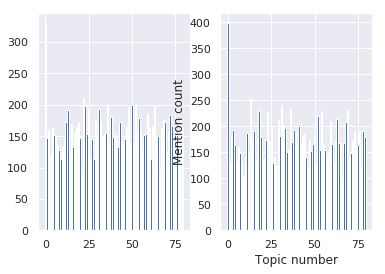

In [141]:
topic_plot(topic_counts, 1, 2)

<BarContainer object of 40 artists>

<Figure size 432x288 with 0 Axes>

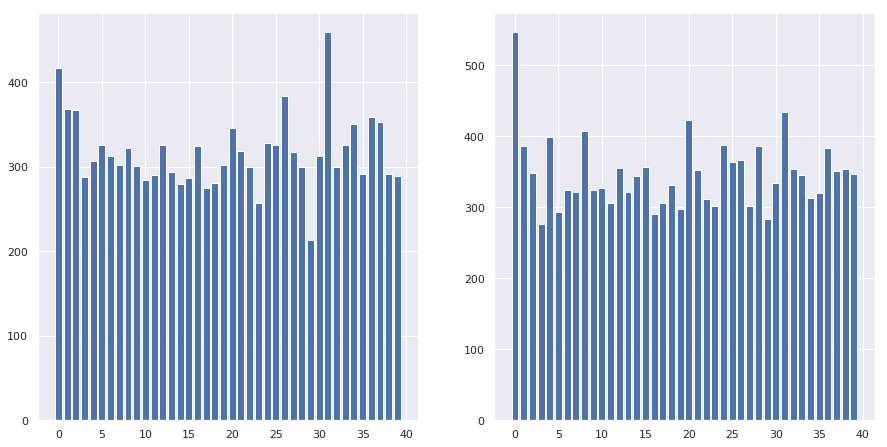

In [106]:
fig = plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))
ax[0].bar(topic_counts.loc['2018-08-07', 'Dominant_Topic'], topic_counts.loc['2018-08-07', 'counts'])
ax[1].bar(topic_counts.loc['2018-08-08', 'Dominant_Topic'], topic_counts.loc['2018-08-08', 'counts'])

AttributeError: 'Series' object has no attribute 'plt'

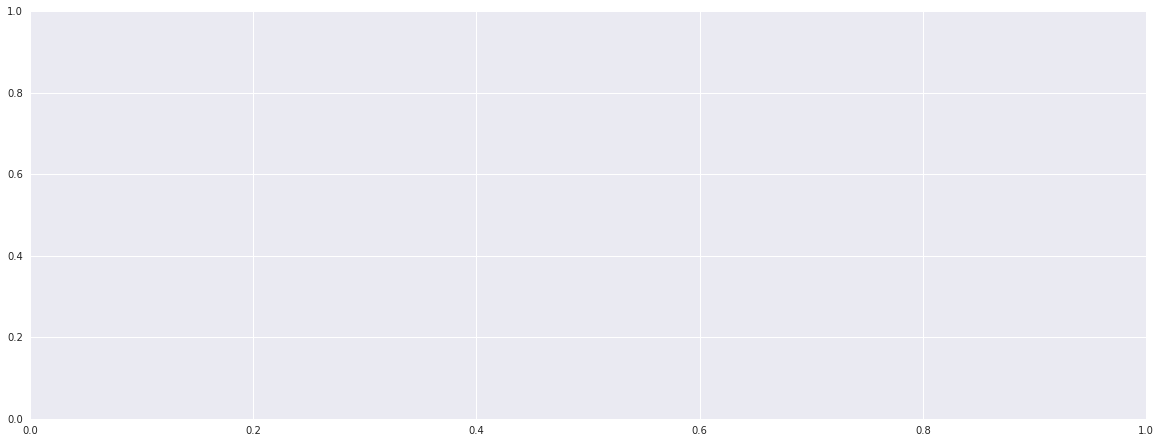

In [116]:
plt.figure(figsize=(20, 7.5))
fig, ax = plt.subplot()
full_df.loc[:, 'Dominant_Topic'].resample('D').count().bar(ax=ax)
plt.legend()
plt.ylabel("Number of tweets per hour")
plt.xlabel("Date") 
# ax.grid(axis='both')
plt.show()

In [113]:
test_count = full_df['Dominant_Topic'].apply(pd.value_counts)

TypeError: 'float' object is not iterable

In [57]:
user_text = df_part.loc[:, ['user_id', 'clean_text']]
user_text.reset_index()
user_text = pd.DataFrame(user_text.groupby(user_text['user_id'])['clean_text'].apply(lambda x: '. '.join(x.astype(str))))

user_tags = df_part.loc[:, ['user_id', 'topics']]
user_tags.reset_index()
user_tags = pd.DataFrame(user_tags.groupby(user_tags['user_id'])['tags'].apply(lambda x: '. '.join(x.astype(str))))

user_tweetcount = pd.DataFrame(df_part.loc[:, 'user_id'].groupby(df_part['user_id']).count())

user_dflist = [user_text, user_tags, user_tweetcount]

NameError: name 'df_part' is not defined

In [35]:
test_df = pd.read_pickle('../Data/all_data_lda.pickle')

In [36]:
test_df.head()

created_at  \
created_at                                
2018-08-02 00:00:14 2018-08-02 00:00:14   
2018-08-02 00:00:32 2018-08-02 00:00:32   
2018-08-02 00:00:32 2018-08-02 00:00:32   
2018-08-02 00:01:33 2018-08-02 00:01:33   
2018-08-02 00:02:08 2018-08-02 00:02:08   

                                                             full_text  \
created_at                                                               
2018-08-02 00:00:14  @BILD Für Sami A macht man Rundflüge. gute Mig...   
2018-08-02 00:00:32  @bembelpix @AfD_Hessen NoAFD schreiben aber ke...   
2018-08-02 00:00:32  RT @Walnusskipferl: @AssetsKater72 @dr_ecksack...   
2018-08-02 00:01:33  @NeotherealNeo @vonduessel @AfD @AndreasKalbit...   
2018-08-02 00:02:08  Damit wir die Werte #AfD besser verstehen. #Af...   

                                                                  tags  \
created_at                                                               
2018-08-02 00:00:14  [CSU, AfD, Bild, CSU, Bild, CSU, SPD, FDP, AFD...   
2018-08-02 00:00:32                                                 []   
2018-08-02 00:00:32                                                 []   
2018-08-02 00:01:33                                                 []   
2018-08-02 00:02:08                                    [AfD, AfDwirkt]   

                                                              mentions  \
created_at                                                               
2018-08-02 00:00:14                                             [BILD]   
2018-08-02 00:00:32                            [bembelpix, AfD_Hessen]   
2018-08-02 00:00:32  [Walnusskipferl, AssetsKater72, dr_ecksack_, i...   
2018-08-02 00:01:33   [NeotherealNeo, vonduessel, AfD, AndreasKalbitz]   
2018-08-02 00:02:08                                                 []   

                                                            clean_text  \
created_at                                                               
2018-08-02 00:00:14   Fuer  Sami  A  macht  man  Rundfluege   gute ...   
2018-08-02 00:00:32    NoAFD  schreiben  aber  keine  Argumente  li...   
2018-08-02 00:00:32         Ich  kenne  nur  die  REPs  Baden  Wuer...   
2018-08-02 00:01:33      Drittens  in  kauf  nehmen  ist  ungleich ...   
2018-08-02 00:02:08  Damit  wir  die  Werte   AfD  besser  verstehe...   

                                  parties  \
created_at                                  
2018-08-02 00:00:14  [AfD, SPD, CSU, FDP]   
2018-08-02 00:00:32                 [AfD]   
2018-08-02 00:00:32                    []   
2018-08-02 00:01:33                 [AfD]   
2018-08-02 00:02:08                 [AfD]   

                                                               stemmed  \
created_at                                                               
2018-08-02 00:00:14   fuer  sami  a  macht  man  rundflueg   gut  m...   
2018-08-02 00:00:32    noafd  schreib  aber  kein  argument  lief  ...   
2018-08-02 00:00:32         ich  kenn  nur  die  reps  bad  wuertte...   
2018-08-02 00:01:33      dritt  in  kauf  nehm  ist  ungleich  woll...   
2018-08-02 00:02:08  damit  wir  die  wert   afd  bess  versteh    ...   

                                user_id  
created_at                               
2018-08-02 00:00:14  884513792062881794  
2018-08-02 00:00:32  702527680722419712  
2018-08-02 00:00:32          3438043463  
2018-08-02 00:01:33  846319908254367744  
2018-08-02 00:02:08           165708897